# Прогнозирование оттока клиентов в телеком компании

Требуется разработать модель для отдела маркетинга, которая прогнозирует уйдет клиент, или нет

In [1]:
!pip install lightgbm
!pip install tensorflow
!pip install scikeras[tensorflow]
!pip install category_encoders
!pip install optuna

     |████████████████████████████████| 511.7 MB 859 bytes/s a 0:00:012B/s eta 0:00:07
     |████████████████████████████████| 1.1 MB 47.6 MB/s eta 0:00:01
     |████████████████████████████████| 438 kB 96.8 MB/s eta 0:00:01
     |████████████████████████████████| 1.6 MB 91.2 MB/s eta 0:00:01
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.1
    Uninstalling protobuf-3.20.1:
      Successfully uninstalled protobuf-3.20.1
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.7.0
    Uninstalling tensorflow-estimator-2.7.0:
      Successfully uninstalled tensorflow-estimator-2.7.0
  Attempting uninstall: keras
    Found existing installation: keras 2.7.0
    Uninstalling keras-2.7.0:
      Successfully uninstalled keras-2.7.0
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 2.0
    Uninstalling flatbuffers-2.0:
      Successfully uninstalled flatbuffers-2.0
ERROR: pip's dependen

In [1]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import optuna
import tensorflow as tf

from datetime import datetime

from category_encoders import OneHotEncoder

from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from scikeras.wrappers import KerasClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import f_classif
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_predict
from sklearn.compose import ColumnTransformer

from keras.models import Sequential
from keras.layers import Dense

from tensorflow import keras
from tensorflow.keras.optimizers import Adam

from sklearn.utils import shuffle

## Импорт данных

### Информация о договоре

In [5]:
contract_df = pd.read_csv('data/contract.csv')
contract_df.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


### Персональные данные клиента

In [6]:
personal_df = pd.read_csv('data/personal.csv')
personal_df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


### Информация об интернет-услугах

In [7]:
internet_df = pd.read_csv('data/internet.csv')
internet_df.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


### Информация об услугах телефонии

In [8]:
phone_df = pd.read_csv('data/phone.csv')
phone_df.head()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


## Анализ пропусков и общий анализ данных

### Договора

In [9]:
contract_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


In [10]:
contract_df.describe()

,MonthlyCharges
count,7043.000000
mean,64.761692
std,30.090047
min,18.250000
25%,35.500000
50%,70.350000
75%,89.850000
max,118.750000


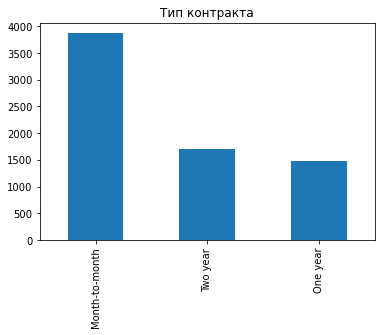

In [11]:
# Тип контракта
contract_df['Type'].value_counts().plot(kind='bar', title = 'Тип контракта');

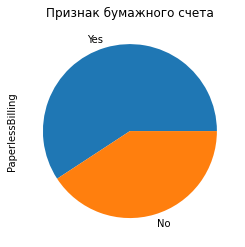

In [12]:
# Признак бумажного счета
contract_df['PaperlessBilling'].value_counts().plot(kind='pie', title='Признак бумажного счета');

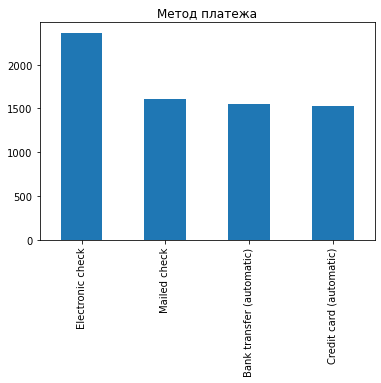

In [13]:
# Метод платежа
contract_df['PaymentMethod'].value_counts().plot(kind='bar', title='Метод платежа');

In [14]:
# Общие платежи
def isfloat(num):
    try:
        float(num)
        return True
    except ValueError:
        return False

not_float_value = contract_df[~contract_df['TotalCharges'].apply(lambda t: isfloat(t))]['TotalCharges'].unique()
print('Найдены некорректные значения общей суммы платежей', not_float_value)

for val in not_float_value:
    print('Всего некорректных значений', val, '-', len(contract_df.query('TotalCharges in @val')))

Найдены некорректные значения общей суммы платежей [' ']
Всего некорректных значений   - 11


In [15]:
# Общие платежи - анализ некорректных строк
contract_df.query('TotalCharges in @not_float_value').head() 

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,


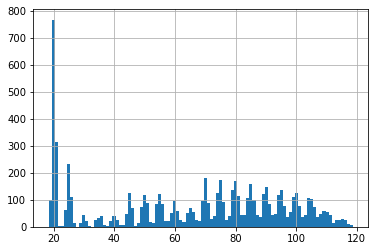

In [16]:
# Месячные платежи
contract_df['MonthlyCharges'].hist(bins=100);

In [17]:
# Начало действия договора  (месяц)
contract_df['BeginDate'].unique()

array(['2020-01-01', '2017-04-01', '2019-10-01', '2016-05-01',
       '2019-09-01', '2019-03-01', '2018-04-01', '2019-04-01',
       '2017-07-01', '2014-12-01', '2019-01-01', '2018-10-01',
       '2015-04-01', '2015-09-01', '2018-01-01', '2014-05-01',
       '2015-10-01', '2014-03-01', '2018-05-01', '2019-11-01',
       '2019-02-01', '2016-01-01', '2017-08-01', '2015-12-01',
       '2014-02-01', '2018-06-01', '2019-12-01', '2017-11-01',
       '2019-06-01', '2016-04-01', '2017-02-01', '2018-12-01',
       '2014-04-01', '2018-09-01', '2014-11-01', '2016-07-01',
       '2015-02-01', '2018-07-01', '2014-08-01', '2016-03-01',
       '2018-08-01', '2014-10-01', '2015-06-01', '2016-08-01',
       '2019-05-01', '2017-03-01', '2016-02-01', '2017-09-01',
       '2014-09-01', '2017-12-01', '2016-12-01', '2017-06-01',
       '2015-05-01', '2016-10-01', '2016-09-01', '2019-08-01',
       '2019-07-01', '2017-05-01', '2017-10-01', '2014-07-01',
       '2018-03-01', '2015-01-01', '2018-11-01', '2015-

In [18]:
# Окончание действия договора (месяц)
contract_df['EndDate'].unique()

array(['No', '2019-12-01 00:00:00', '2019-11-01 00:00:00',
       '2019-10-01 00:00:00', '2020-01-01 00:00:00'], dtype=object)

Выводы:
- Пропусков в данных нет
- Всего 7043 записей договоров
- Поле общих сумм платежей имеет некорректное значение ' ', всего 11 записей. Можно удалить и преобразовать к нужному типу float
- Поле BeginDate нужно преобразовать к типу Date
- Поле EndDate имеет значение No (без окончания действия). Нужно заменить на большое значение в будущем 
- Поле PaperlessBilling привести к типу Bool


### Персональные данные клиента

In [19]:
personal_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [20]:
personal_df.describe()

,SeniorCitizen
count,7043.000000
mean,0.162147
std,0.368612
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


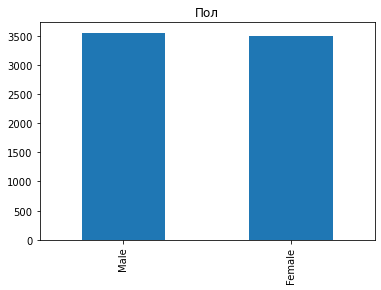

In [21]:
# Пол
personal_df['gender'].value_counts().plot(kind='bar', title='Пол');

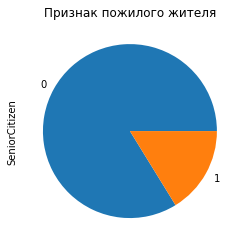

In [22]:
# Признак пожилого жителя
personal_df['SeniorCitizen'].value_counts().plot(kind='pie', title='Признак пожилого жителя');

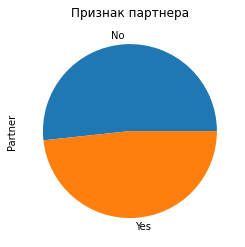

In [23]:
# Признак партнера
personal_df['Partner'].value_counts().plot(kind='pie', title = 'Признак партнера');

<AxesSubplot:ylabel='Dependents'>

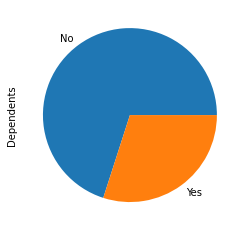

In [24]:
# Признак наличия тждивенцев
personal_df['Dependents'].value_counts().plot(kind='pie')

Выводы:
- Пропусков в данных нет
- Всего 7043 записей (совпадает с количеством договоров)
- Соотношение мужчин и женщин в данных схожи 1:1 
- Поле SeniorCitizen преобразовать к Bool (0/1)
- Поле Partner,Dependents преобразовать к Bool (Yes/No)

<div class="alert alert-success" style="border-color: green; border-radius: 5px">
    <p><u><b>✅ КОММЕНТАРИЙ РЕВЬЮЕРА</b></u></p>
    <p>ОК!</p>
</div>

### Интернет-услуги

In [25]:
internet_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [26]:
internet_df.describe()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
count,5517,5517,5517,5517,5517,5517,5517,5517
unique,5517,2,2,2,2,2,2,2
top,1422-DGUBX,Fiber optic,No,No,No,No,No,No
freq,1,3096,3498,3088,3095,3473,2810,2785


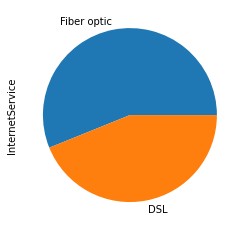

In [27]:
internet_df['InternetService'].value_counts().plot(kind='pie');

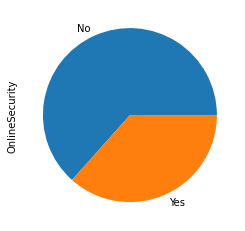

In [28]:
internet_df['OnlineSecurity'].value_counts().plot(kind='pie');

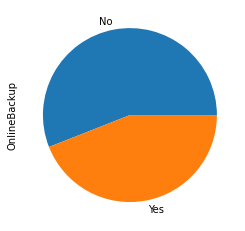

In [29]:
internet_df['OnlineBackup'].value_counts().plot(kind='pie');

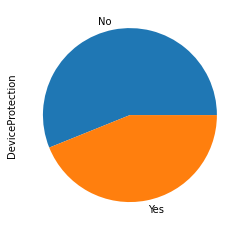

In [30]:
internet_df['DeviceProtection'].value_counts().plot(kind='pie');

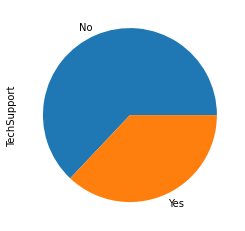

In [31]:
internet_df['TechSupport'].value_counts().plot(kind='pie');

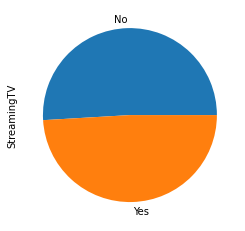

In [32]:
internet_df['StreamingTV'].value_counts().plot(kind='pie');

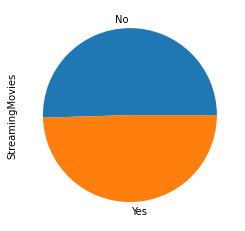

In [33]:
internet_df['StreamingMovies'].value_counts().plot(kind='pie');

- Пропусков нет
- Всего 5517 записей. Не все клиенты пользуются интернет услугами
- Поля OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies преобразовать к типу Bool (Yes/No)


## Услуги телефонии

In [34]:
phone_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


In [35]:
phone_df.describe()

,customerID,MultipleLines
count,6361,6361
unique,6361,2
top,7625-XCQRH,No
freq,1,3390


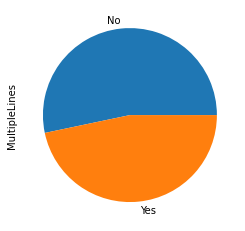

In [36]:
phone_df['MultipleLines'].value_counts().plot(kind='pie');

- Пропусков нет
- Всего 6361 записей (меньше записей клиентов)
- Поле MultipleLines преобразовать к типу Bool (Yes/No)

<div class="alert alert-success" style="border-color: green; border-radius: 5px">
    <p><u><b>✅ КОММЕНТАРИЙ РЕВЬЮЕРА</b></u></p>
    <p>И в итоге - чёткая работа по разделу, ОК.</p>
</div>

## Обработка данных (пропуски, приведение к нужному типу. некорректные значения)

### Договора

In [37]:
# Индексация
contract_df.index = contract_df['customerID']
contract_df = contract_df.drop(columns='customerID')
contract_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   BeginDate         7043 non-null   object 
 1   EndDate           7043 non-null   object 
 2   Type              7043 non-null   object 
 3   PaperlessBilling  7043 non-null   object 
 4   PaymentMethod     7043 non-null   object 
 5   MonthlyCharges    7043 non-null   float64
 6   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(6)
memory usage: 440.2+ KB


In [38]:
# Поле общих сумм платежей TotalCharges имеет некорректное значение ' ', всего 11 записей. Можно удалить и преобразовать к нужному типу float
contract_df = contract_df.query('TotalCharges != " "')
contract_df.shape

(7032, 7)

In [39]:
# Преобразрование к типу float
contract_df['TotalCharges'] = contract_df['TotalCharges'].astype('float')

In [40]:
# Поле BeginDate нужно преобразовать к типу Date
contract_df['BeginDate'] = pd.to_datetime(contract_df['BeginDate']).dt.date
contract_df['BeginDate'].head()

customerID
7590-VHVEG    2020-01-01
5575-GNVDE    2017-04-01
3668-QPYBK    2019-10-01
7795-CFOCW    2016-05-01
9237-HQITU    2019-09-01
Name: BeginDate, dtype: object

In [41]:
actual_date = datetime.strptime('2020-02-01', '%Y-%m-%d').date()
contract_df['IsArchive'] = contract_df['EndDate'].apply(lambda v: v != 'No')
contract_df['IsArchive'].value_counts()

False    5163
True     1869
Name: IsArchive, dtype: int64

In [42]:
# Поле EndDate имеет значение No (без окончания действия). Нужно заменить на большое значение в будущем 
contract_df.loc[contract_df['EndDate'] == 'No', 'EndDate'] = actual_date
contract_df['EndDate'] = pd.to_datetime(contract_df['EndDate']).dt.date
contract_df['EndDate'].unique()

array([datetime.date(2020, 2, 1), datetime.date(2019, 12, 1),
       datetime.date(2019, 11, 1), datetime.date(2019, 10, 1),
       datetime.date(2020, 1, 1)], dtype=object)

In [43]:
# Вычисляем время жизни абонента в днях
contract_df['ContractDays'] = (contract_df['EndDate'] - contract_df['BeginDate']).dt.days

### Персональные данные

In [44]:
# Индексация
personal_df.index = personal_df['customerID']
personal_df = personal_df.drop(columns='customerID')
personal_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   gender         7043 non-null   object
 1   SeniorCitizen  7043 non-null   int64 
 2   Partner        7043 non-null   object
 3   Dependents     7043 non-null   object
dtypes: int64(1), object(3)
memory usage: 275.1+ KB


### Интернет-услуги

In [48]:
# Индексация
internet_df.index = internet_df['customerID']
internet_df = internet_df.drop(columns='customerID')
internet_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5517 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   InternetService   5517 non-null   object
 1   OnlineSecurity    5517 non-null   object
 2   OnlineBackup      5517 non-null   object
 3   DeviceProtection  5517 non-null   object
 4   TechSupport       5517 non-null   object
 5   StreamingTV       5517 non-null   object
 6   StreamingMovies   5517 non-null   object
dtypes: object(7)
memory usage: 344.8+ KB


## Телефонные услуги

In [49]:
# Индексация
phone_df.index = phone_df['customerID']
phone_df = phone_df.drop(columns='customerID')
phone_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6361 entries, 5575-GNVDE to 3186-AJIEK
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   MultipleLines  6361 non-null   object
dtypes: object(1)
memory usage: 99.4+ KB


## Анализ активных и архивных клиентов

### Выделяем активных и архив
Информация о договорах актуальна на 1 февраля 2020.

### Объединяем данные по клиенту

In [50]:
data = contract_df.join([personal_df, phone_df, internet_df], how='left')
# Признак наличия телефонной связи
data['IsPhone'] = data['MultipleLines'].apply(lambda v: 0 if pd.isnull(v) else 1)
# Признак наличия интернет услуг
data['IsInternet'] = data['InternetService'].apply(lambda v: 0 if pd.isnull(v) else 1)
data.head()

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,IsArchive,ContractDays,gender,...,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,IsPhone,IsInternet
customerID,,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,29.85,False,31.0,Female,...,NaN,DSL,No,Yes,No,No,No,No,0,1
5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,1889.50,False,1036.0,Male,...,No,DSL,Yes,No,Yes,No,No,No,1,1
3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,True,61.0,Male,...,No,DSL,Yes,Yes,No,No,No,No,1,1
7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1840.75,False,1371.0,Male,...,NaN,DSL,Yes,No,Yes,Yes,No,No,0,1
9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,True,61.0,Female,...,No,Fiber optic,No,No,No,No,No,No,1,1


In [51]:
# Выделяем активных клиентов и клиентов в архиве
active_data = data.query('IsArchive == False')
archive_data = data.query('IsArchive == True')

### Статистика

In [52]:
compare_data_stat = active_data.describe().join(archive_data.describe(), how='inner', lsuffix='_active', rsuffix='_archive')
compare_data_stat

,MonthlyCharges_active,TotalCharges_active,ContractDays_active,SeniorCitizen_active,IsPhone_active,IsInternet_active,MonthlyCharges_archive,TotalCharges_archive,ContractDays_archive,SeniorCitizen_archive,IsPhone_archive,IsInternet_archive
count,5163.000000,5163.000000,5163.000000,5163.000000,5163.000000,5163.000000,1869.000000,1869.000000,1869.000000,1869.000000,1869.000000,1869.000000
mean,61.307408,2555.344141,1146.885532,0.128995,0.901220,0.727484,74.441332,1531.796094,547.352060,0.254682,0.909042,0.939540
std,31.094557,2329.456984,732.773458,0.335227,0.298395,0.445297,24.666053,1890.822994,594.389607,0.435799,0.287626,0.238401
min,18.250000,18.800000,31.000000,0.000000,0.000000,0.000000,18.850000,18.850000,30.000000,0.000000,0.000000,0.000000
25%,25.100000,577.825000,457.000000,0.000000,1.000000,0.000000,56.150000,134.500000,61.000000,0.000000,1.000000,1.000000
50%,64.450000,1683.600000,1157.000000,0.000000,1.000000,1.000000,79.650000,703.550000,304.000000,0.000000,1.000000,1.000000
75%,88.475000,4264.125000,1857.000000,0.000000,1.000000,1.000000,94.200000,2331.300000,883.000000,1.000000,1.000000,1.000000
max,118.750000,8672.450000,2191.000000,1.000000,1.000000,1.000000,118.350000,8684.800000,2191.000000,1.000000,1.000000,1.000000


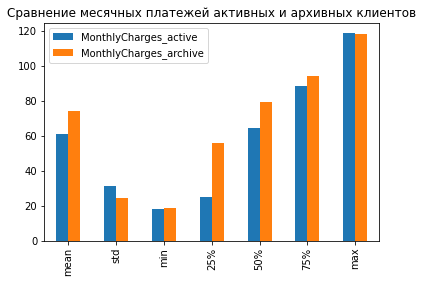

In [53]:
compare_data_stat = compare_data_stat.query('index != "count"')
compare_data_stat[['MonthlyCharges_active', 'MonthlyCharges_archive']].plot(kind='bar', title='Сравнение месячных платежей активных и архивных клиентов');

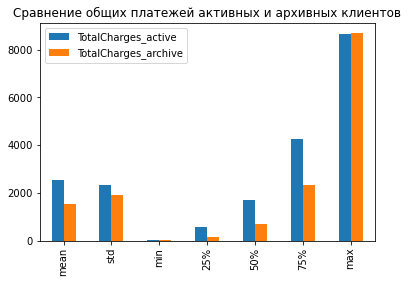

In [54]:
compare_data_stat[['TotalCharges_active', 'TotalCharges_archive']].plot(kind='bar', title='Сравнение общих платежей активных и архивных клиентов');

### Распределение ежемесячных платежей

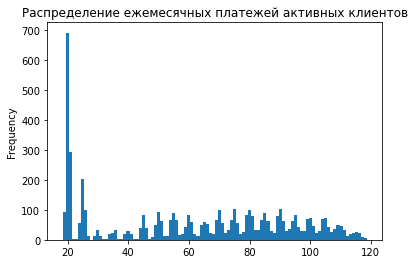

In [55]:
active_data['MonthlyCharges'].plot(kind='hist',bins=100,title='Распределение ежемесячных платежей активных клиентов');

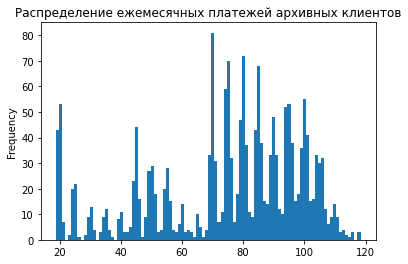

In [56]:
archive_data['MonthlyCharges'].plot(kind='hist',bins=100,title='Распределение ежемесячных платежей архивных клиентов');

### Доля пользователей телефонной сети

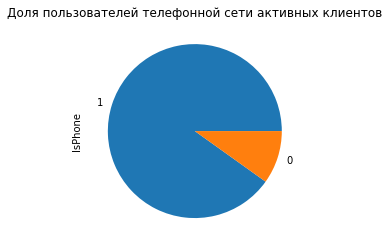

In [57]:
active_data['IsPhone'].value_counts().plot(kind='pie', title='Доля пользователей телефонной сети активных клиентов');

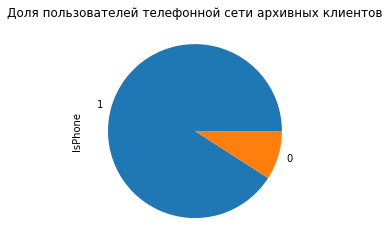

In [58]:
archive_data['IsPhone'].value_counts().plot(kind='pie', title='Доля пользователей телефонной сети архивных клиентов');

### Доля пользователей интернет услуг

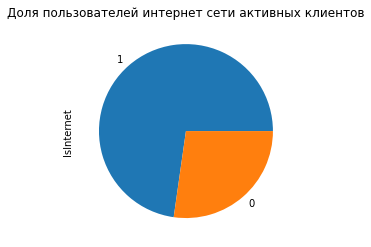

In [59]:
active_data['IsInternet'].value_counts().plot(kind='pie', title='Доля пользователей интернет сети активных клиентов');

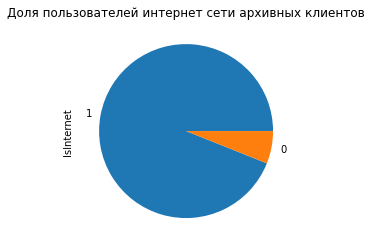

In [60]:
archive_data['IsInternet'].value_counts().plot(kind='pie', title='Доля пользователей интернет сети архивных клиентов');

### Доля пользователей всех услуг (интернет, телефония)


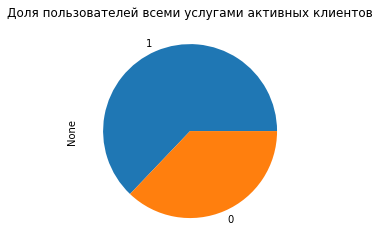

In [61]:
(active_data['IsInternet'] & active_data['IsPhone']).value_counts().plot(kind='pie', title='Доля пользователей всеми услугами активных клиентов');

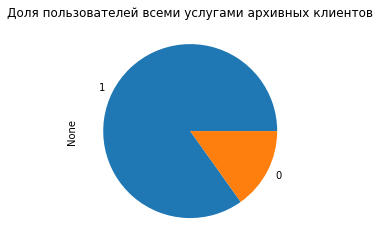

In [62]:
(archive_data['IsInternet'] & archive_data['IsPhone']).value_counts().plot(kind='pie', title='Доля пользователей всеми услугами архивных клиентов');

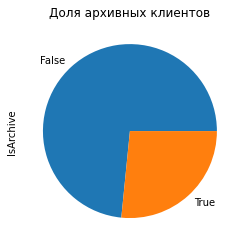

In [63]:
### Доля архивных клиентов
(data['IsArchive']).value_counts().plot(kind='pie', title='Доля архивных клиентов');

## Выводы EDA

 - Все клиенты поделены на два сигмента:
    - действующие
    - архивные (перестали пользоваться услугами)
 - Доля пользователей телефонией действующих и активных клиентов совпадает, что говорит о том, что данный фактор не мог повлиять на решение отказаться от услуг
 - Доля пользователей услуг интернета действующих и активных клиентов отличается - большее количество архивных клиентов пользовалась услугами интернета, в тоже время, более четверти существующих клиентов интернет услугами не пользуются.


## Подготовка данных для построения модели
 - Задача прогнозирования относится к задаче классификации (уйдет клиент или нет)
 - Доля архивных клиентов порядка четверти - дисбаланс целевых классов

### Выделение фич и целевого признака

In [64]:
# Удаляем ненужные признаки
data = data.drop(['BeginDate', 'EndDate'], axis = 1)

# Заполняем пропуски (топовые значения)
data = data.fillna(data.mode().iloc[0])

# Выделяем фичи и таргет
features = data.drop(['IsArchive'], axis = 1)
target = data['IsArchive']

features.head()

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,ContractDays,gender,SeniorCitizen,Partner,Dependents,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,IsPhone,IsInternet
customerID,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,Month-to-month,Yes,Electronic check,29.85,29.85,31.0,Female,0,Yes,No,No,DSL,No,Yes,No,No,No,No,0,1
5575-GNVDE,One year,No,Mailed check,56.95,1889.50,1036.0,Male,0,No,No,No,DSL,Yes,No,Yes,No,No,No,1,1
3668-QPYBK,Month-to-month,Yes,Mailed check,53.85,108.15,61.0,Male,0,No,No,No,DSL,Yes,Yes,No,No,No,No,1,1
7795-CFOCW,One year,No,Bank transfer (automatic),42.30,1840.75,1371.0,Male,0,No,No,No,DSL,Yes,No,Yes,Yes,No,No,0,1
9237-HQITU,Month-to-month,Yes,Electronic check,70.70,151.65,61.0,Female,0,No,No,No,Fiber optic,No,No,No,No,No,No,1,1


### Анализ фич (корреляция, пропуски)

In [65]:
# Матрица коррекляции
features.corr()

,MonthlyCharges,TotalCharges,ContractDays,SeniorCitizen,IsPhone,IsInternet
MonthlyCharges,1.000000,0.651065,0.246715,0.219874,0.248033,0.763191
TotalCharges,0.651065,1.000000,0.825811,0.102411,0.113008,0.374878
ContractDays,0.246715,0.825811,1.000000,0.015630,0.007875,0.037417
SeniorCitizen,0.219874,0.102411,0.015630,1.000000,0.008392,0.182519
IsPhone,0.248033,0.113008,0.007875,0.008392,1.000000,-0.171817
IsInternet,0.763191,0.374878,0.037417,0.182519,-0.171817,1.000000


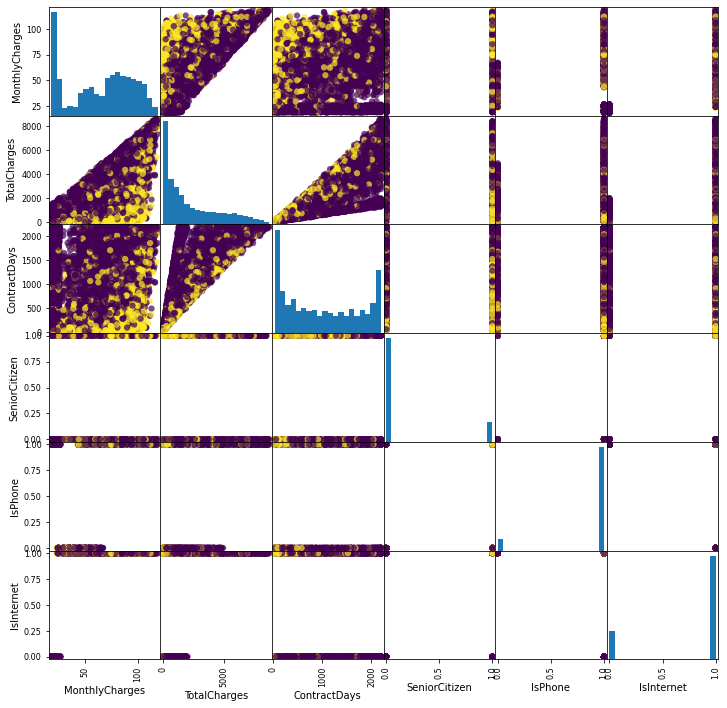

In [78]:
# Матрица корреляции
scat_mtrx = pd.plotting.scatter_matrix(features, c=target, figsize=(12,12), marker='o', hist_kwds={'bins': 20}, 
                                     s=40, alpha=.7)

Наблюдается коррекляция:
- Месячных платжей и признака наличия интернет услуг


### Разбивка данных на обучающую и тестовую выборку

In [80]:
random_state = 250722

In [81]:
# Выделяем тестовый и обучающий набор
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.20, random_state=random_state)


categorical_cols = [c for c in features_train.columns if features_train[c].dtype in [object]]
numerical_cols = [c for c in features_train.columns if features_train[c].dtype in [float, int]]

### Увеличение выборки целевого класса

In [82]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

features_upsampled, target_upsampled = upsample(features_train, target_train, 3)

features_train = features_upsampled
target_train = target_upsampled

# Актуальные балансы классов
target_train.value_counts()

True     4467
False    4136
Name: IsArchive, dtype: int64

## Выбор модели обучения
- В качестве метрики качества предполагается использовать ROC-AUC
- Проверям следующие модели случайный лес, логистическая регрессия, lightgbm
- Для сравнения также будем использовать частотную dummy модель
- Применяем кросс-валидацию для оценки качества

### Dummy -модель

In [83]:
strategies = ['most_frequent', 'prior', 'stratified'] 

dummy_results = []
for strategy in strategies:
    dc = DummyClassifier(strategy = strategy, random_state = random_state)
    dc.fit(features_train, target_train)
    predicted_test = dc.predict(features_test)
    result = roc_auc_score(target_test, predicted_test )
    dummy_results.append({'strategy':strategy, 
                          'score': result})

pd.DataFrame.from_records(dummy_results)

,strategy,score
0,most_frequent,0.500000
1,prior,0.500000
2,stratified,0.496901


### Логистическая регрессия

In [84]:
classifier = make_pipeline(
    ColumnTransformer([
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(), categorical_cols),    
    ]),
    LogisticRegression(random_state=random_state)
)
oof_pred = cross_val_predict(classifier, 
                             features_train, 
                             target_train, 
                             cv=5,
                             method="predict_proba")
print("ROC_AUC кросс-валидация:", roc_auc_score(target_train, oof_pred[:,1]))

ROC_AUC кросс-валидация: 0.8413635302772664


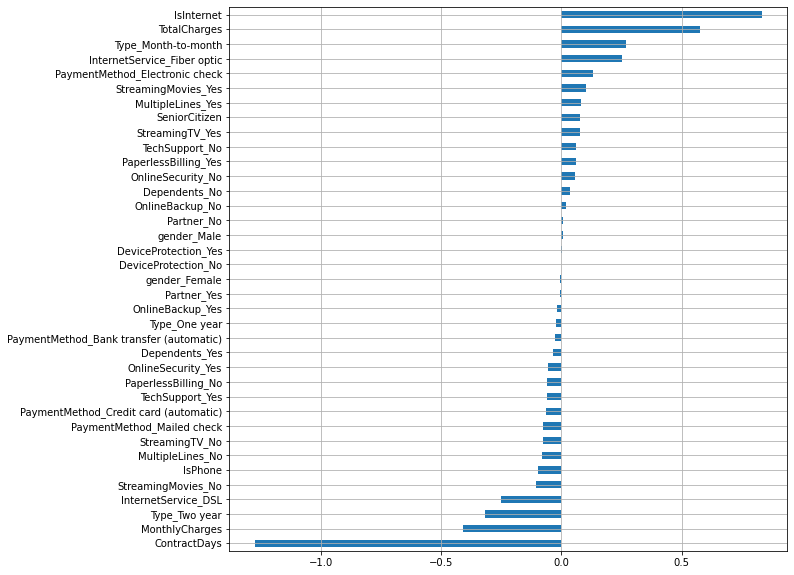

In [96]:
# Анализ важности фич
features_train_ohe = pd.get_dummies(features_train)
scaler = StandardScaler()
scaler.fit(features_train_ohe)
features_train_transform = scaler.transform(features_train_ohe)

classifier = LogisticRegression(random_state=random_state)
classifier.fit(features_train_transform, target_train)

(pd.DataFrame(data={'score': classifier.coef_[0]}, 
                      index=features_train_ohe.columns).sort_values(by='score')
                                         .plot(kind='barh', grid=True,
                                               figsize=(10,10), legend=False));


### Случайный лес

In [85]:
classifier = make_pipeline(
    ColumnTransformer([
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(), categorical_cols),    
    ]),
    RandomForestClassifier(random_state=random_state)
)
oof_pred = cross_val_predict(classifier, 
                             features_train, 
                             target_train, 
                             cv=5,
                             method="predict_proba")
print("ROC_AUC кросс-валидация:", roc_auc_score(target_train, oof_pred[:,1]))

ROC_AUC кросс-валидация: 0.9755618680554022


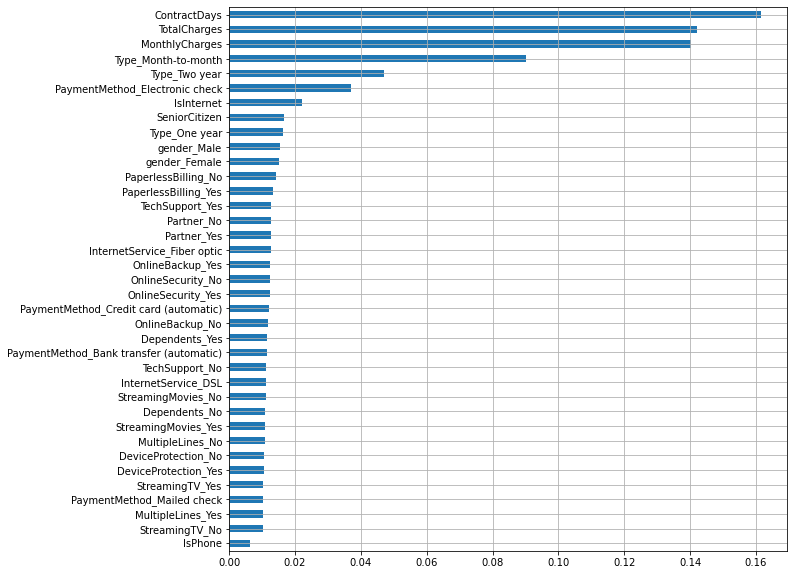

In [97]:
# Анализ важности фич
features_train_ohe = pd.get_dummies(features_train)
scaler = StandardScaler()
scaler.fit(features_train_ohe)
features_train_transform = scaler.transform(features_train_ohe)

classifier = RandomForestClassifier(random_state=random_state)
classifier.fit(features_train_transform, target_train)

(pd.DataFrame(data={'score': classifier.feature_importances_}, 
                      index=features_train_ohe.columns).sort_values(by='score')
                                         .plot(kind='barh', grid=True,
                                               figsize=(10,10), legend=False));


Топ самых важных для модели признаков (по убыванию):
- ContractDays
- TotalCharges
- Type
- PaymentMethod - Electronic check
- IsInterntet
- SeniorCitizen
- Gender

При этом, для модели по сути мало важны наличие у клиента телефона

### LightGBM

In [72]:
classifier = make_pipeline(
    ColumnTransformer([
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(), categorical_cols),    
    ]),
    lgb.LGBMClassifier(random_state=random_state)
)
oof_pred = cross_val_predict(classifier, 
                             features_train, 
                             target_train, 
                             cv=5,
                             method="predict_proba")
print("ROC_AUC кросс-валидация:", roc_auc_score(target_train, oof_pred[:,1]))

ROC_AUC кросс-валидация: 0.9478364929751338


### Нейросеть

In [ ]:
# Прямое кодирование категорий (для определения длины размера)
def create_baseline():
    optimizer = Adam(learning_rate=0.001)
    model = Sequential()
    model.add(Dense(120, input_dim=34, activation='relu'))
    model.add(Dense(1,  activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

estimator = KerasClassifier(build_fn=create_baseline, epochs=10, batch_size=10, verbose=0)


classifier = make_pipeline(
    ColumnTransformer([
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(), categorical_cols),    
    ]),
    create_baseline()
)
oof_pred = cross_val_predict(classifier, 
                             features_train, 
                             target_train, 
                             cv=5,
                             method="predict")
print("ROC_AUC кросс-валидация:", roc_auc_score(target_train, oof_pred))

## Тестирование модели
- В качестве целевой модели выбираем классификатор LightGBM

### Базовая модель

In [74]:
# Создаем пайплайн: применяем масштабирование признаков и OHE кодирование
classifier = make_pipeline(
    ColumnTransformer([
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(), categorical_cols),    
    ]),
    lgb.LGBMClassifier(n_jobs=-1)
)
classifier.fit(features_train, target_train)
predicted_test = classifier.predict_proba(features_test)
result = roc_auc_score(target_test, predicted_test[:,1] )
print("ROC_AUC на тестовых данных:", result)

ROC_AUC на тестовых данных: 0.8987418643980937


### Оптимизация гиперпараметров

In [75]:
def objective(trial):
    dtrain = lgb.Dataset(features_train, label=target_train)

    param = {
        'learning_rate': 0.03, 
        "objective": "binary",
        "metric": "binary_logloss",
        "verbosity": -1,
        "boosting_type": "gbdt",
         "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
         "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
         "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
         "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
         "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
         "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
    }
    
    # Создаем пайплайн: применяем масштабирование признаков и OHE кодирование
    classifier = make_pipeline(
        ColumnTransformer([
            ('num', StandardScaler(), numerical_cols),
            ('cat', OneHotEncoder(), categorical_cols),    
        ]),
        lgb.LGBMClassifier(n_jobs=-1, **param)
    )
    classifier.fit(features_train, target_train)
    predicted_test = classifier.predict_proba(features_test)
    result = roc_auc_score(target_test, predicted_test[:,1] )
    return result

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=1000)
print('Лучшие параметры:', study.best_trial.params)

[I 2022-07-29 19:43:55,258] A new study created in memory with name: no-name-1068cde7-7679-48c9-ba67-ce9da470f6cd


[LightGBM] [Warning] feature_fraction is set=0.7470427332121017, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7470427332121017
[LightGBM] [Warning] lambda_l1 is set=0.15350328155884013, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15350328155884013
[LightGBM] [Warning] bagging_fraction is set=0.8785063753360408, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8785063753360408
[LightGBM] [Warning] lambda_l2 is set=7.94565475894788e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.94565475894788e-05
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2022-07-29 19:43:56,387] Trial 0 finished with value: 0.8730256751908985 and parameters: {'lambda_l1': 0.15350328155884013, 'lambda_l2': 7.94565475894788e-05, 'num_leaves': 249, 'feature_fraction': 0.7470427332121017, 'bagging_fraction': 0.8785063753360408, 'bagging_freq': 3, 'min_child_samples': 60}. Best is trial 0 with value: 0.8730256751908985.


[LightGBM] [Warning] feature_fraction is set=0.745348445892817, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.745348445892817
[LightGBM] [Warning] lambda_l1 is set=0.02064362533560448, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.02064362533560448
[LightGBM] [Warning] bagging_fraction is set=0.6627191159898985, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6627191159898985
[LightGBM] [Warning] lambda_l2 is set=1.3051324644815078e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3051324644815078e-07
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2022-07-29 19:43:57,388] Trial 1 finished with value: 0.8614590273151232 and parameters: {'lambda_l1': 0.02064362533560448, 'lambda_l2': 1.3051324644815078e-07, 'num_leaves': 150, 'feature_fraction': 0.745348445892817, 'bagging_fraction': 0.6627191159898985, 'bagging_freq': 3, 'min_child_samples': 95}. Best is trial 0 with value: 0.8730256751908985.


[LightGBM] [Warning] feature_fraction is set=0.696091049140185, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.696091049140185
[LightGBM] [Warning] lambda_l1 is set=1.0560977978736596, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0560977978736596
[LightGBM] [Warning] bagging_fraction is set=0.8177058052830661, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8177058052830661
[LightGBM] [Warning] lambda_l2 is set=1.9980644120760294, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9980644120760294
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2022-07-29 19:43:58,512] Trial 2 finished with value: 0.8797903961461591 and parameters: {'lambda_l1': 1.0560977978736596, 'lambda_l2': 1.9980644120760294, 'num_leaves': 53, 'feature_fraction': 0.696091049140185, 'bagging_fraction': 0.8177058052830661, 'bagging_freq': 3, 'min_child_samples': 15}. Best is trial 2 with value: 0.8797903961461591.


[LightGBM] [Warning] feature_fraction is set=0.6561814586038672, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6561814586038672
[LightGBM] [Warning] lambda_l1 is set=0.0011339420827841571, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0011339420827841571
[LightGBM] [Warning] bagging_fraction is set=0.7901602491795281, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7901602491795281
[LightGBM] [Warning] lambda_l2 is set=5.2960540615818594e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.2960540615818594e-08
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2022-07-29 19:43:59,481] Trial 3 finished with value: 0.8716137959309179 and parameters: {'lambda_l1': 0.0011339420827841571, 'lambda_l2': 5.2960540615818594e-08, 'num_leaves': 33, 'feature_fraction': 0.6561814586038672, 'bagging_fraction': 0.7901602491795281, 'bagging_freq': 4, 'min_child_samples': 57}. Best is trial 2 with value: 0.8797903961461591.


[LightGBM] [Warning] feature_fraction is set=0.4786540358292557, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4786540358292557
[LightGBM] [Warning] lambda_l1 is set=0.00046701758132819925, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00046701758132819925
[LightGBM] [Warning] bagging_fraction is set=0.7296844708744076, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7296844708744076
[LightGBM] [Warning] lambda_l2 is set=0.3498747058174764, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.3498747058174764
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-07-29 19:44:01,001] Trial 4 finished with value: 0.8849356839030391 and parameters: {'lambda_l1': 0.00046701758132819925, 'lambda_l2': 0.3498747058174764, 'num_leaves': 227, 'feature_fraction': 0.4786540358292557, 'bagging_fraction': 0.7296844708744076, 'bagging_freq': 1, 'min_child_samples': 6}. Best is trial 4 with value: 0.8849356839030391.


[LightGBM] [Warning] feature_fraction is set=0.9788854485716396, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9788854485716396
[LightGBM] [Warning] lambda_l1 is set=0.6941954130679954, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6941954130679954
[LightGBM] [Warning] bagging_fraction is set=0.4709463107802637, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4709463107802637
[LightGBM] [Warning] lambda_l2 is set=6.986445412851682e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.986445412851682e-05
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2022-07-29 19:44:01,938] Trial 5 finished with value: 0.8629746835443037 and parameters: {'lambda_l1': 0.6941954130679954, 'lambda_l2': 6.986445412851682e-05, 'num_leaves': 162, 'feature_fraction': 0.9788854485716396, 'bagging_fraction': 0.4709463107802637, 'bagging_freq': 2, 'min_child_samples': 76}. Best is trial 4 with value: 0.8849356839030391.


[LightGBM] [Warning] feature_fraction is set=0.6575295005107067, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6575295005107067
[LightGBM] [Warning] lambda_l1 is set=0.05063476404598906, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.05063476404598906
[LightGBM] [Warning] bagging_fraction is set=0.8619914618145617, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8619914618145617
[LightGBM] [Warning] lambda_l2 is set=0.00028404487106529455, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00028404487106529455
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2022-07-29 19:44:03,104] Trial 6 finished with value: 0.8699866755496336 and parameters: {'lambda_l1': 0.05063476404598906, 'lambda_l2': 0.00028404487106529455, 'num_leaves': 173, 'feature_fraction': 0.6575295005107067, 'bagging_fraction': 0.8619914618145617, 'bagging_freq': 5, 'min_child_samples': 56}. Best is trial 4 with value: 0.8849356839030391.


[LightGBM] [Warning] feature_fraction is set=0.8393048971059428, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8393048971059428
[LightGBM] [Warning] lambda_l1 is set=6.276695362393185e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.276695362393185e-07
[LightGBM] [Warning] bagging_fraction is set=0.6369696555390945, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6369696555390945
[LightGBM] [Warning] lambda_l2 is set=0.005466454308210455, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.005466454308210455
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:44:04,358] Trial 7 finished with value: 0.870634961307846 and parameters: {'lambda_l1': 6.276695362393185e-07, 'lambda_l2': 0.005466454308210455, 'num_leaves': 228, 'feature_fraction': 0.8393048971059428, 'bagging_fraction': 0.6369696555390945, 'bagging_freq': 6, 'min_child_samples': 39}. Best is trial 4 with value: 0.8849356839030391.


[LightGBM] [Warning] feature_fraction is set=0.4994696311791451, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4994696311791451
[LightGBM] [Warning] lambda_l1 is set=0.0009951198923834098, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0009951198923834098
[LightGBM] [Warning] bagging_fraction is set=0.9516287405077888, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9516287405077888
[LightGBM] [Warning] lambda_l2 is set=0.0010841425745964199, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0010841425745964199
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:44:05,282] Trial 8 finished with value: 0.8640611387280274 and parameters: {'lambda_l1': 0.0009951198923834098, 'lambda_l2': 0.0010841425745964199, 'num_leaves': 9, 'feature_fraction': 0.4994696311791451, 'bagging_fraction': 0.9516287405077888, 'bagging_freq': 6, 'min_child_samples': 60}. Best is trial 4 with value: 0.8849356839030391.


[LightGBM] [Warning] feature_fraction is set=0.823551723620436, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.823551723620436
[LightGBM] [Warning] lambda_l1 is set=2.079071837137546e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.079071837137546e-06
[LightGBM] [Warning] bagging_fraction is set=0.5586221395453268, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5586221395453268
[LightGBM] [Warning] lambda_l2 is set=5.060062179462373e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.060062179462373e-07
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2022-07-29 19:44:06,278] Trial 9 finished with value: 0.8725465074565674 and parameters: {'lambda_l1': 2.079071837137546e-06, 'lambda_l2': 5.060062179462373e-07, 'num_leaves': 42, 'feature_fraction': 0.823551723620436, 'bagging_fraction': 0.5586221395453268, 'bagging_freq': 2, 'min_child_samples': 30}. Best is trial 4 with value: 0.8849356839030391.


[LightGBM] [Warning] feature_fraction is set=0.4023832246492193, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4023832246492193
[LightGBM] [Warning] lambda_l1 is set=1.8848215278995022e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8848215278995022e-05
[LightGBM] [Warning] bagging_fraction is set=0.7352642301232694, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7352642301232694
[LightGBM] [Warning] lambda_l2 is set=4.260613214230684, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.260613214230684
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-07-29 19:44:07,402] Trial 10 finished with value: 0.8793342899605392 and parameters: {'lambda_l1': 1.8848215278995022e-05, 'lambda_l2': 4.260613214230684, 'num_leaves': 95, 'feature_fraction': 0.4023832246492193, 'bagging_fraction': 0.7352642301232694, 'bagging_freq': 1, 'min_child_samples': 7}. Best is trial 4 with value: 0.8849356839030391.


[LightGBM] [Warning] feature_fraction is set=0.5260886844416715, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5260886844416715
[LightGBM] [Warning] lambda_l1 is set=5.6652195456279704e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.6652195456279704e-08
[LightGBM] [Warning] bagging_fraction is set=0.7623072485140351, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7623072485140351
[LightGBM] [Warning] lambda_l2 is set=6.2895765657596145, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.2895765657596145
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-07-29 19:44:08,538] Trial 11 finished with value: 0.8760364884948495 and parameters: {'lambda_l1': 5.6652195456279704e-08, 'lambda_l2': 6.2895765657596145, 'num_leaves': 84, 'feature_fraction': 0.5260886844416715, 'bagging_fraction': 0.7623072485140351, 'bagging_freq': 1, 'min_child_samples': 5}. Best is trial 4 with value: 0.8849356839030391.


[LightGBM] [Warning] feature_fraction is set=0.5741219365451209, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5741219365451209
[LightGBM] [Warning] lambda_l1 is set=8.29432274780237, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.29432274780237
[LightGBM] [Warning] bagging_fraction is set=0.8502091062056799, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8502091062056799
[LightGBM] [Warning] lambda_l2 is set=0.09011792242323001, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.09011792242323001
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2022-07-29 19:44:09,508] Trial 12 finished with value: 0.8691282734587199 and parameters: {'lambda_l1': 8.29432274780237, 'lambda_l2': 0.09011792242323001, 'num_leaves': 195, 'feature_fraction': 0.5741219365451209, 'bagging_fraction': 0.8502091062056799, 'bagging_freq': 3, 'min_child_samples': 24}. Best is trial 4 with value: 0.8849356839030391.


[LightGBM] [Warning] feature_fraction is set=0.4000198060072328, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4000198060072328
[LightGBM] [Warning] lambda_l1 is set=3.489774222134053e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.489774222134053e-05
[LightGBM] [Warning] bagging_fraction is set=0.9855434719436277, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9855434719436277
[LightGBM] [Warning] lambda_l2 is set=0.25619186657200993, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.25619186657200993
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-07-29 19:44:10,840] Trial 13 finished with value: 0.8875518884846 and parameters: {'lambda_l1': 3.489774222134053e-05, 'lambda_l2': 0.25619186657200993, 'num_leaves': 111, 'feature_fraction': 0.4000198060072328, 'bagging_fraction': 0.9855434719436277, 'bagging_freq': 1, 'min_child_samples': 18}. Best is trial 13 with value: 0.8875518884846.


[LightGBM] [Warning] feature_fraction is set=0.418359817343234, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.418359817343234
[LightGBM] [Warning] lambda_l1 is set=3.98590620521832e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.98590620521832e-05
[LightGBM] [Warning] bagging_fraction is set=0.9875600454677137, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9875600454677137
[LightGBM] [Warning] lambda_l2 is set=0.05811821392767157, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.05811821392767157
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-07-29 19:44:12,209] Trial 14 finished with value: 0.880825603443858 and parameters: {'lambda_l1': 3.98590620521832e-05, 'lambda_l2': 0.05811821392767157, 'num_leaves': 123, 'feature_fraction': 0.418359817343234, 'bagging_fraction': 0.9875600454677137, 'bagging_freq': 1, 'min_child_samples': 39}. Best is trial 13 with value: 0.8875518884846.


[LightGBM] [Warning] feature_fraction is set=0.4773049449417361, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4773049449417361
[LightGBM] [Warning] lambda_l1 is set=0.00010646277963629549, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00010646277963629549
[LightGBM] [Warning] bagging_fraction is set=0.4219365422092273, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4219365422092273
[LightGBM] [Warning] lambda_l2 is set=0.1092801707134904, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1092801707134904
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2022-07-29 19:44:13,429] Trial 15 finished with value: 0.8780915287244402 and parameters: {'lambda_l1': 0.00010646277963629549, 'lambda_l2': 0.1092801707134904, 'num_leaves': 120, 'feature_fraction': 0.4773049449417361, 'bagging_fraction': 0.4219365422092273, 'bagging_freq': 7, 'min_child_samples': 19}. Best is trial 13 with value: 0.8875518884846.


[LightGBM] [Warning] feature_fraction is set=0.597219688083061, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.597219688083061
[LightGBM] [Warning] lambda_l1 is set=0.00696918185903863, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00696918185903863
[LightGBM] [Warning] bagging_fraction is set=0.5805489446852432, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5805489446852432
[LightGBM] [Warning] lambda_l2 is set=4.166179900223246e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.166179900223246e-06
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2022-07-29 19:44:14,625] Trial 16 finished with value: 0.874755291344232 and parameters: {'lambda_l1': 0.00696918185903863, 'lambda_l2': 4.166179900223246e-06, 'num_leaves': 197, 'feature_fraction': 0.597219688083061, 'bagging_fraction': 0.5805489446852432, 'bagging_freq': 2, 'min_child_samples': 34}. Best is trial 13 with value: 0.8875518884846.


[LightGBM] [Warning] feature_fraction is set=0.45590654124630636, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.45590654124630636
[LightGBM] [Warning] lambda_l1 is set=1.0710527446395263e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0710527446395263e-08
[LightGBM] [Warning] bagging_fraction is set=0.9295735145701809, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9295735145701809
[LightGBM] [Warning] lambda_l2 is set=0.2827841940815813, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2827841940815813
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-07-29 19:44:15,799] Trial 17 finished with value: 0.8815046379336852 and parameters: {'lambda_l1': 1.0710527446395263e-08, 'lambda_l2': 0.2827841940815813, 'num_leaves': 84, 'feature_fraction': 0.45590654124630636, 'bagging_fraction': 0.9295735145701809, 'bagging_freq': 1, 'min_child_samples': 16}. Best is trial 13 with value: 0.8875518884846.


[LightGBM] [Warning] feature_fraction is set=0.539776432096355, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.539776432096355
[LightGBM] [Warning] lambda_l1 is set=4.131190308247344e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.131190308247344e-06
[LightGBM] [Warning] bagging_fraction is set=0.6804554895998424, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6804554895998424
[LightGBM] [Warning] lambda_l2 is set=0.004348038231940155, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.004348038231940155
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2022-07-29 19:44:16,914] Trial 18 finished with value: 0.8724260749244094 and parameters: {'lambda_l1': 4.131190308247344e-06, 'lambda_l2': 0.004348038231940155, 'num_leaves': 218, 'feature_fraction': 0.539776432096355, 'bagging_fraction': 0.6804554895998424, 'bagging_freq': 4, 'min_child_samples': 46}. Best is trial 13 with value: 0.8875518884846.


[LightGBM] [Warning] feature_fraction is set=0.6064692941500507, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6064692941500507
[LightGBM] [Warning] lambda_l1 is set=0.00037889627137516294, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00037889627137516294
[LightGBM] [Warning] bagging_fraction is set=0.5315678301673052, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5315678301673052
[LightGBM] [Warning] lambda_l2 is set=0.7951537343427876, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.7951537343427876
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2022-07-29 19:44:18,444] Trial 19 finished with value: 0.8775790498641931 and parameters: {'lambda_l1': 0.00037889627137516294, 'lambda_l2': 0.7951537343427876, 'num_leaves': 143, 'feature_fraction': 0.6064692941500507, 'bagging_fraction': 0.5315678301673052, 'bagging_freq': 2, 'min_child_samples': 5}. Best is trial 13 with value: 0.8875518884846.


[LightGBM] [Warning] feature_fraction is set=0.45646270824358987, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.45646270824358987
[LightGBM] [Warning] lambda_l1 is set=0.002214192521692302, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002214192521692302
[LightGBM] [Warning] bagging_fraction is set=0.9974320441591307, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9974320441591307
[LightGBM] [Warning] lambda_l2 is set=0.018854735300818593, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.018854735300818593
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-07-29 19:44:19,675] Trial 20 finished with value: 0.868792599805258 and parameters: {'lambda_l1': 0.002214192521692302, 'lambda_l2': 0.018854735300818593, 'num_leaves': 255, 'feature_fraction': 0.45646270824358987, 'bagging_fraction': 0.9974320441591307, 'bagging_freq': 1, 'min_child_samples': 73}. Best is trial 13 with value: 0.8875518884846.


[LightGBM] [Warning] feature_fraction is set=0.44596786889690704, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.44596786889690704
[LightGBM] [Warning] lambda_l1 is set=1.360561248809945e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.360561248809945e-08
[LightGBM] [Warning] bagging_fraction is set=0.9265444584651267, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9265444584651267
[LightGBM] [Warning] lambda_l2 is set=0.2887785989439302, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2887785989439302
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-07-29 19:44:20,800] Trial 21 finished with value: 0.8817121918720853 and parameters: {'lambda_l1': 1.360561248809945e-08, 'lambda_l2': 0.2887785989439302, 'num_leaves': 88, 'feature_fraction': 0.44596786889690704, 'bagging_fraction': 0.9265444584651267, 'bagging_freq': 1, 'min_child_samples': 16}. Best is trial 13 with value: 0.8875518884846.


[LightGBM] [Warning] feature_fraction is set=0.40541921520942775, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.40541921520942775
[LightGBM] [Warning] lambda_l1 is set=2.249718445046679e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.249718445046679e-07
[LightGBM] [Warning] bagging_fraction is set=0.921244636109291, subsample=1.0 will be ignored. Current value: bagging_fraction=0.921244636109291
[LightGBM] [Warning] lambda_l2 is set=0.3393655217051496, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.3393655217051496
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2022-07-29 19:44:22,028] Trial 22 finished with value: 0.8836647363296265 and parameters: {'lambda_l1': 2.249718445046679e-07, 'lambda_l2': 0.3393655217051496, 'num_leaves': 104, 'feature_fraction': 0.40541921520942775, 'bagging_fraction': 0.921244636109291, 'bagging_freq': 2, 'min_child_samples': 22}. Best is trial 13 with value: 0.8875518884846.


[LightGBM] [Warning] feature_fraction is set=0.5095862708350135, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5095862708350135
[LightGBM] [Warning] lambda_l1 is set=1.2491457799727055e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2491457799727055e-06
[LightGBM] [Warning] bagging_fraction is set=0.8980755766075529, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8980755766075529
[LightGBM] [Warning] lambda_l2 is set=0.017077192215565962, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.017077192215565962
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2022-07-29 19:44:23,285] Trial 23 finished with value: 0.8774714293035413 and parameters: {'lambda_l1': 1.2491457799727055e-06, 'lambda_l2': 0.017077192215565962, 'num_leaves': 109, 'feature_fraction': 0.5095862708350135, 'bagging_fraction': 0.8980755766075529, 'bagging_freq': 2, 'min_child_samples': 26}. Best is trial 13 with value: 0.8875518884846.


[LightGBM] [Warning] feature_fraction is set=0.4213804759166984, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4213804759166984
[LightGBM] [Warning] lambda_l1 is set=1.480172663597782e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.480172663597782e-07
[LightGBM] [Warning] bagging_fraction is set=0.7123455746923018, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7123455746923018
[LightGBM] [Warning] lambda_l2 is set=0.9127764943560149, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.9127764943560149
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2022-07-29 19:44:24,460] Trial 24 finished with value: 0.8842259006815969 and parameters: {'lambda_l1': 1.480172663597782e-07, 'lambda_l2': 0.9127764943560149, 'num_leaves': 65, 'feature_fraction': 0.4213804759166984, 'bagging_fraction': 0.7123455746923018, 'bagging_freq': 2, 'min_child_samples': 13}. Best is trial 13 with value: 0.8875518884846.


[LightGBM] [Warning] feature_fraction is set=0.5505659652947216, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5505659652947216
[LightGBM] [Warning] lambda_l1 is set=2.0028505274371363e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0028505274371363e-05
[LightGBM] [Warning] bagging_fraction is set=0.7091086905374522, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7091086905374522
[LightGBM] [Warning] lambda_l2 is set=1.4963070851406077, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4963070851406077
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-07-29 19:44:25,613] Trial 25 finished with value: 0.8780889663301389 and parameters: {'lambda_l1': 2.0028505274371363e-05, 'lambda_l2': 1.4963070851406077, 'num_leaves': 66, 'feature_fraction': 0.5505659652947216, 'bagging_fraction': 0.7091086905374522, 'bagging_freq': 1, 'min_child_samples': 13}. Best is trial 13 with value: 0.8875518884846.


[LightGBM] [Warning] feature_fraction is set=0.4719443359119183, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4719443359119183
[LightGBM] [Warning] lambda_l1 is set=0.00017101798727106487, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00017101798727106487
[LightGBM] [Warning] bagging_fraction is set=0.604294454225453, subsample=1.0 will be ignored. Current value: bagging_fraction=0.604294454225453
[LightGBM] [Warning] lambda_l2 is set=7.294865432808489, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.294865432808489
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2022-07-29 19:44:26,719] Trial 26 finished with value: 0.8717598524060881 and parameters: {'lambda_l1': 0.00017101798727106487, 'lambda_l2': 7.294865432808489, 'num_leaves': 64, 'feature_fraction': 0.4719443359119183, 'bagging_fraction': 0.604294454225453, 'bagging_freq': 2, 'min_child_samples': 10}. Best is trial 13 with value: 0.8875518884846.


[LightGBM] [Warning] feature_fraction is set=0.9842937845826365, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9842937845826365
[LightGBM] [Warning] lambda_l1 is set=5.7344764162951324e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.7344764162951324e-06
[LightGBM] [Warning] bagging_fraction is set=0.80692146029267, subsample=1.0 will be ignored. Current value: bagging_fraction=0.80692146029267
[LightGBM] [Warning] lambda_l2 is set=0.03327866349067245, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.03327866349067245
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2022-07-29 19:44:27,638] Trial 27 finished with value: 0.8699277404807053 and parameters: {'lambda_l1': 5.7344764162951324e-06, 'lambda_l2': 0.03327866349067245, 'num_leaves': 13, 'feature_fraction': 0.9842937845826365, 'bagging_fraction': 0.80692146029267, 'bagging_freq': 3, 'min_child_samples': 31}. Best is trial 13 with value: 0.8875518884846.


[LightGBM] [Warning] feature_fraction is set=0.42805624223870287, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42805624223870287
[LightGBM] [Warning] lambda_l1 is set=2.042371496058279e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.042371496058279e-07
[LightGBM] [Warning] bagging_fraction is set=0.7286018067492077, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7286018067492077
[LightGBM] [Warning] lambda_l2 is set=0.002935389373988259, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.002935389373988259
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-07-29 19:44:28,785] Trial 28 finished with value: 0.872139086762671 and parameters: {'lambda_l1': 2.042371496058279e-07, 'lambda_l2': 0.002935389373988259, 'num_leaves': 139, 'feature_fraction': 0.42805624223870287, 'bagging_fraction': 0.7286018067492077, 'bagging_freq': 1, 'min_child_samples': 47}. Best is trial 13 with value: 0.8875518884846.


[LightGBM] [Warning] feature_fraction is set=0.49708245927065103, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.49708245927065103
[LightGBM] [Warning] lambda_l1 is set=0.006307839407310445, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.006307839407310445
[LightGBM] [Warning] bagging_fraction is set=0.5099551476549271, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5099551476549271
[LightGBM] [Warning] lambda_l2 is set=0.6312122347722717, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.6312122347722717
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2022-07-29 19:44:29,790] Trial 29 finished with value: 0.8627171629170296 and parameters: {'lambda_l1': 0.006307839407310445, 'lambda_l2': 0.6312122347722717, 'num_leaves': 175, 'feature_fraction': 0.49708245927065103, 'bagging_fraction': 0.5099551476549271, 'bagging_freq': 4, 'min_child_samples': 73}. Best is trial 13 with value: 0.8875518884846.


[LightGBM] [Warning] feature_fraction is set=0.9175624208330225, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9175624208330225
[LightGBM] [Warning] lambda_l1 is set=5.421377406569786e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.421377406569786e-08
[LightGBM] [Warning] bagging_fraction is set=0.6218557312290511, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6218557312290511
[LightGBM] [Warning] lambda_l2 is set=3.092672964816247e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.092672964816247e-05
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2022-07-29 19:44:30,859] Trial 30 finished with value: 0.8621611233536616 and parameters: {'lambda_l1': 5.421377406569786e-08, 'lambda_l2': 3.092672964816247e-05, 'num_leaves': 236, 'feature_fraction': 0.9175624208330225, 'bagging_fraction': 0.6218557312290511, 'bagging_freq': 5, 'min_child_samples': 100}. Best is trial 13 with value: 0.8875518884846.


[LightGBM] [Warning] feature_fraction is set=0.40554115531722607, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.40554115531722607
[LightGBM] [Warning] lambda_l1 is set=1.614077006653925e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.614077006653925e-07
[LightGBM] [Warning] bagging_fraction is set=0.8919304944884887, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8919304944884887
[LightGBM] [Warning] lambda_l2 is set=0.2546187445561386, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2546187445561386
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2022-07-29 19:44:32,202] Trial 31 finished with value: 0.882875518884846 and parameters: {'lambda_l1': 1.614077006653925e-07, 'lambda_l2': 0.2546187445561386, 'num_leaves': 106, 'feature_fraction': 0.40554115531722607, 'bagging_fraction': 0.8919304944884887, 'bagging_freq': 2, 'min_child_samples': 22}. Best is trial 13 with value: 0.8875518884846.


[LightGBM] [Warning] feature_fraction is set=0.4373884273520597, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4373884273520597
[LightGBM] [Warning] lambda_l1 is set=4.881174230927152e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.881174230927152e-07
[LightGBM] [Warning] bagging_fraction is set=0.9629118901794338, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9629118901794338
[LightGBM] [Warning] lambda_l2 is set=1.0020652025938324, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0020652025938324
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2022-07-29 19:44:33,456] Trial 32 finished with value: 0.8824655357966484 and parameters: {'lambda_l1': 4.881174230927152e-07, 'lambda_l2': 1.0020652025938324, 'num_leaves': 75, 'feature_fraction': 0.4373884273520597, 'bagging_fraction': 0.9629118901794338, 'bagging_freq': 3, 'min_child_samples': 11}. Best is trial 13 with value: 0.8875518884846.


[LightGBM] [Warning] feature_fraction is set=0.4050135896568568, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4050135896568568
[LightGBM] [Warning] lambda_l1 is set=8.472456715417016e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.472456715417016e-06
[LightGBM] [Warning] bagging_fraction is set=0.8289678148296962, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8289678148296962
[LightGBM] [Warning] lambda_l2 is set=2.503801628481294, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.503801628481294
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2022-07-29 19:44:34,715] Trial 33 finished with value: 0.881860810741557 and parameters: {'lambda_l1': 8.472456715417016e-06, 'lambda_l2': 2.503801628481294, 'num_leaves': 106, 'feature_fraction': 0.4050135896568568, 'bagging_fraction': 0.8289678148296962, 'bagging_freq': 2, 'min_child_samples': 23}. Best is trial 13 with value: 0.8875518884846.


[LightGBM] [Warning] feature_fraction is set=0.47471502309638347, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.47471502309638347
[LightGBM] [Warning] lambda_l1 is set=4.768006007680816e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.768006007680816e-05
[LightGBM] [Warning] bagging_fraction is set=0.7629349734619095, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7629349734619095
[LightGBM] [Warning] lambda_l2 is set=0.14916277666611544, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.14916277666611544
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2022-07-29 19:44:35,791] Trial 34 finished with value: 0.8823553528416952 and parameters: {'lambda_l1': 4.768006007680816e-05, 'lambda_l2': 0.14916277666611544, 'num_leaves': 49, 'feature_fraction': 0.47471502309638347, 'bagging_fraction': 0.7629349734619095, 'bagging_freq': 3, 'min_child_samples': 19}. Best is trial 13 with value: 0.8875518884846.


[LightGBM] [Warning] feature_fraction is set=0.6285417916055276, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6285417916055276
[LightGBM] [Warning] lambda_l1 is set=7.470427989296151e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.470427989296151e-08
[LightGBM] [Warning] bagging_fraction is set=0.6610036937901844, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6610036937901844
[LightGBM] [Warning] lambda_l2 is set=0.010918231947776738, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.010918231947776738
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2022-07-29 19:44:36,725] Trial 35 finished with value: 0.8773330600112745 and parameters: {'lambda_l1': 7.470427989296151e-08, 'lambda_l2': 0.010918231947776738, 'num_leaves': 28, 'feature_fraction': 0.6285417916055276, 'bagging_fraction': 0.6610036937901844, 'bagging_freq': 2, 'min_child_samples': 12}. Best is trial 13 with value: 0.8875518884846.


[LightGBM] [Warning] feature_fraction is set=0.5520893907126119, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5520893907126119
[LightGBM] [Warning] lambda_l1 is set=0.0004996524136078557, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0004996524136078557
[LightGBM] [Warning] bagging_fraction is set=0.7742380849339651, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7742380849339651
[LightGBM] [Warning] lambda_l2 is set=0.0005846182202571174, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0005846182202571174
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-07-29 19:44:38,014] Trial 36 finished with value: 0.8702070414595398 and parameters: {'lambda_l1': 0.0004996524136078557, 'lambda_l2': 0.0005846182202571174, 'num_leaves': 135, 'feature_fraction': 0.5520893907126119, 'bagging_fraction': 0.7742380849339651, 'bagging_freq': 1, 'min_child_samples': 29}. Best is trial 13 with value: 0.8875518884846.


[LightGBM] [Warning] feature_fraction is set=0.44038961964945167, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.44038961964945167
[LightGBM] [Warning] lambda_l1 is set=0.30561662949880214, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.30561662949880214
[LightGBM] [Warning] bagging_fraction is set=0.8632901735757336, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8632901735757336
[LightGBM] [Warning] lambda_l2 is set=0.6748523594646498, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.6748523594646498
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2022-07-29 19:44:39,356] Trial 37 finished with value: 0.8831138215548608 and parameters: {'lambda_l1': 0.30561662949880214, 'lambda_l2': 0.6748523594646498, 'num_leaves': 160, 'feature_fraction': 0.44038961964945167, 'bagging_fraction': 0.8632901735757336, 'bagging_freq': 2, 'min_child_samples': 17}. Best is trial 13 with value: 0.8875518884846.


[LightGBM] [Warning] feature_fraction is set=0.8069318423793287, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8069318423793287
[LightGBM] [Warning] lambda_l1 is set=0.05032176852158568, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.05032176852158568
[LightGBM] [Warning] bagging_fraction is set=0.9181524424718982, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9181524424718982
[LightGBM] [Warning] lambda_l2 is set=0.0446511604691727, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0446511604691727
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2022-07-29 19:44:40,670] Trial 38 finished with value: 0.8718751601496438 and parameters: {'lambda_l1': 0.05032176852158568, 'lambda_l2': 0.0446511604691727, 'num_leaves': 120, 'feature_fraction': 0.8069318423793287, 'bagging_fraction': 0.9181524424718982, 'bagging_freq': 3, 'min_child_samples': 38}. Best is trial 13 with value: 0.8875518884846.


[LightGBM] [Warning] feature_fraction is set=0.7279526313790887, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7279526313790887
[LightGBM] [Warning] lambda_l1 is set=1.4630435974777315e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4630435974777315e-06
[LightGBM] [Warning] bagging_fraction is set=0.9656496304275309, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9656496304275309
[LightGBM] [Warning] lambda_l2 is set=0.0015899445940356647, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0015899445940356647
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-07-29 19:44:41,705] Trial 39 finished with value: 0.8655716701686056 and parameters: {'lambda_l1': 1.4630435974777315e-06, 'lambda_l2': 0.0015899445940356647, 'num_leaves': 66, 'feature_fraction': 0.7279526313790887, 'bagging_fraction': 0.9656496304275309, 'bagging_freq': 1, 'min_child_samples': 89}. Best is trial 13 with value: 0.8875518884846.


[LightGBM] [Warning] feature_fraction is set=0.691973733833942, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.691973733833942
[LightGBM] [Warning] lambda_l1 is set=0.0029476446476724466, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0029476446476724466
[LightGBM] [Warning] bagging_fraction is set=0.8350768348946404, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8350768348946404
[LightGBM] [Warning] lambda_l2 is set=0.00016273170116698973, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00016273170116698973
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2022-07-29 19:44:43,234] Trial 40 finished with value: 0.8833034387331523 and parameters: {'lambda_l1': 0.0029476446476724466, 'lambda_l2': 0.00016273170116698973, 'num_leaves': 151, 'feature_fraction': 0.691973733833942, 'bagging_fraction': 0.8350768348946404, 'bagging_freq': 3, 'min_child_samples': 9}. Best is trial 13 with value: 0.8875518884846.


[LightGBM] [Warning] feature_fraction is set=0.6974723731940621, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6974723731940621
[LightGBM] [Warning] lambda_l1 is set=0.004602243129753083, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.004602243129753083
[LightGBM] [Warning] bagging_fraction is set=0.8327302315984648, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8327302315984648
[LightGBM] [Warning] lambda_l2 is set=0.00016079756868827568, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00016079756868827568
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2022-07-29 19:44:44,576] Trial 41 finished with value: 0.8800876338851021 and parameters: {'lambda_l1': 0.004602243129753083, 'lambda_l2': 0.00016079756868827568, 'num_leaves': 152, 'feature_fraction': 0.6974723731940621, 'bagging_fraction': 0.8327302315984648, 'bagging_freq': 3, 'min_child_samples': 9}. Best is trial 13 with value: 0.8875518884846.


[LightGBM] [Warning] feature_fraction is set=0.7864774647207649, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7864774647207649
[LightGBM] [Warning] lambda_l1 is set=0.01955171506179673, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01955171506179673
[LightGBM] [Warning] bagging_fraction is set=0.7941537755652993, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7941537755652993
[LightGBM] [Warning] lambda_l2 is set=1.2693470039172976e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2693470039172976e-05
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2022-07-29 19:44:46,197] Trial 42 finished with value: 0.8763542253882028 and parameters: {'lambda_l1': 0.01955171506179673, 'lambda_l2': 1.2693470039172976e-05, 'num_leaves': 192, 'feature_fraction': 0.7864774647207649, 'bagging_fraction': 0.7941537755652993, 'bagging_freq': 2, 'min_child_samples': 13}. Best is trial 13 with value: 0.8875518884846.


[LightGBM] [Warning] feature_fraction is set=0.8661430420286303, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8661430420286303
[LightGBM] [Warning] lambda_l1 is set=0.0007758605681054265, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0007758605681054265
[LightGBM] [Warning] bagging_fraction is set=0.8872662862649723, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8872662862649723
[LightGBM] [Warning] lambda_l2 is set=5.037022816266816e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.037022816266816e-07
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2022-07-29 19:44:47,465] Trial 43 finished with value: 0.8823143545328755 and parameters: {'lambda_l1': 0.0007758605681054265, 'lambda_l2': 5.037022816266816e-07, 'num_leaves': 97, 'feature_fraction': 0.8661430420286303, 'bagging_fraction': 0.8872662862649723, 'bagging_freq': 4, 'min_child_samples': 5}. Best is trial 13 with value: 0.8875518884846.


[LightGBM] [Warning] feature_fraction is set=0.49577262713586145, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.49577262713586145
[LightGBM] [Warning] lambda_l1 is set=0.0020289248678453504, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0020289248678453504
[LightGBM] [Warning] bagging_fraction is set=0.7333159753291323, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7333159753291323
[LightGBM] [Warning] lambda_l2 is set=8.903840089998984e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.903840089998984e-05
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2022-07-29 19:44:48,951] Trial 44 finished with value: 0.8806231742940603 and parameters: {'lambda_l1': 0.0020289248678453504, 'lambda_l2': 8.903840089998984e-05, 'num_leaves': 211, 'feature_fraction': 0.49577262713586145, 'bagging_fraction': 0.7333159753291323, 'bagging_freq': 2, 'min_child_samples': 21}. Best is trial 13 with value: 0.8875518884846.


[LightGBM] [Warning] feature_fraction is set=0.7548419220010009, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7548419220010009
[LightGBM] [Warning] lambda_l1 is set=0.00014609508356041006, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00014609508356041006
[LightGBM] [Warning] bagging_fraction is set=0.6674894900044493, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6674894900044493
[LightGBM] [Warning] lambda_l2 is set=6.220850621014331e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.220850621014331e-06
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-07-29 19:44:50,264] Trial 45 finished with value: 0.8741710654435504 and parameters: {'lambda_l1': 0.00014609508356041006, 'lambda_l2': 6.220850621014331e-06, 'num_leaves': 176, 'feature_fraction': 0.7548419220010009, 'bagging_fraction': 0.6674894900044493, 'bagging_freq': 1, 'min_child_samples': 26}. Best is trial 13 with value: 0.8875518884846.


[LightGBM] [Warning] feature_fraction is set=0.5170987273771555, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5170987273771555
[LightGBM] [Warning] lambda_l1 is set=0.02048755487960722, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.02048755487960722
[LightGBM] [Warning] bagging_fraction is set=0.6960113419501688, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6960113419501688
[LightGBM] [Warning] lambda_l2 is set=2.7098924801757316, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.7098924801757316
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2022-07-29 19:44:51,689] Trial 46 finished with value: 0.8784656382924205 and parameters: {'lambda_l1': 0.02048755487960722, 'lambda_l2': 2.7098924801757316, 'num_leaves': 239, 'feature_fraction': 0.5170987273771555, 'bagging_fraction': 0.6960113419501688, 'bagging_freq': 3, 'min_child_samples': 9}. Best is trial 13 with value: 0.8875518884846.


[LightGBM] [Warning] feature_fraction is set=0.6428636135310327, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6428636135310327
[LightGBM] [Warning] lambda_l1 is set=2.995086989558482e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.995086989558482e-07
[LightGBM] [Warning] bagging_fraction is set=0.9495333612617762, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9495333612617762
[LightGBM] [Warning] lambda_l2 is set=1.3001371074211457e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3001371074211457e-08
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-07-29 19:44:52,674] Trial 47 finished with value: 0.870645210885051 and parameters: {'lambda_l1': 2.995086989558482e-07, 'lambda_l2': 1.3001371074211457e-08, 'num_leaves': 33, 'feature_fraction': 0.6428636135310327, 'bagging_fraction': 0.9495333612617762, 'bagging_freq': 1, 'min_child_samples': 35}. Best is trial 13 with value: 0.8875518884846.


[LightGBM] [Warning] feature_fraction is set=0.425634432661481, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.425634432661481
[LightGBM] [Warning] lambda_l1 is set=3.5622220143177556e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.5622220143177556e-08
[LightGBM] [Warning] bagging_fraction is set=0.8361896719463958, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8361896719463958
[LightGBM] [Warning] lambda_l2 is set=0.0008938786979000404, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0008938786979000404
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2022-07-29 19:44:53,828] Trial 48 finished with value: 0.8724440116845179 and parameters: {'lambda_l1': 3.5622220143177556e-08, 'lambda_l2': 0.0008938786979000404, 'num_leaves': 113, 'feature_fraction': 0.425634432661481, 'bagging_fraction': 0.8361896719463958, 'bagging_freq': 2, 'min_child_samples': 65}. Best is trial 13 with value: 0.8875518884846.


[LightGBM] [Warning] feature_fraction is set=0.40018985736298773, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.40018985736298773
[LightGBM] [Warning] lambda_l1 is set=5.247896099675585e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.247896099675585e-05
[LightGBM] [Warning] bagging_fraction is set=0.8710664570857954, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8710664570857954
[LightGBM] [Warning] lambda_l2 is set=7.752582141285743, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.752582141285743
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2022-07-29 19:44:54,995] Trial 49 finished with value: 0.8781145902731512 and parameters: {'lambda_l1': 5.247896099675585e-05, 'lambda_l2': 7.752582141285743, 'num_leaves': 129, 'feature_fraction': 0.40018985736298773, 'bagging_fraction': 0.8710664570857954, 'bagging_freq': 3, 'min_child_samples': 18}. Best is trial 13 with value: 0.8875518884846.


[LightGBM] [Warning] feature_fraction is set=0.679367307382607, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.679367307382607
[LightGBM] [Warning] lambda_l1 is set=3.3727643840937535e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.3727643840937535e-06
[LightGBM] [Warning] bagging_fraction is set=0.9708695193897598, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9708695193897598
[LightGBM] [Warning] lambda_l2 is set=0.007473272367845119, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.007473272367845119
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2022-07-29 19:44:56,069] Trial 50 finished with value: 0.8728898682929329 and parameters: {'lambda_l1': 3.3727643840937535e-06, 'lambda_l2': 0.007473272367845119, 'num_leaves': 78, 'feature_fraction': 0.679367307382607, 'bagging_fraction': 0.9708695193897598, 'bagging_freq': 5, 'min_child_samples': 46}. Best is trial 13 with value: 0.8875518884846.


[LightGBM] [Warning] feature_fraction is set=0.4530239279027136, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4530239279027136
[LightGBM] [Warning] lambda_l1 is set=0.06823030404393544, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.06823030404393544
[LightGBM] [Warning] bagging_fraction is set=0.9093515742448354, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9093515742448354
[LightGBM] [Warning] lambda_l2 is set=0.4974063135223006, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.4974063135223006
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2022-07-29 19:44:57,340] Trial 51 finished with value: 0.8820401783426434 and parameters: {'lambda_l1': 0.06823030404393544, 'lambda_l2': 0.4974063135223006, 'num_leaves': 156, 'feature_fraction': 0.4530239279027136, 'bagging_fraction': 0.9093515742448354, 'bagging_freq': 2, 'min_child_samples': 15}. Best is trial 13 with value: 0.8875518884846.


[LightGBM] [Warning] feature_fraction is set=0.47813282821933495, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.47813282821933495
[LightGBM] [Warning] lambda_l1 is set=0.9458533341256061, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9458533341256061
[LightGBM] [Warning] bagging_fraction is set=0.9420018988472912, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9420018988472912
[LightGBM] [Warning] lambda_l2 is set=0.14284039270677218, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.14284039270677218
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2022-07-29 19:44:58,726] Trial 52 finished with value: 0.889132885768462 and parameters: {'lambda_l1': 0.9458533341256061, 'lambda_l2': 0.14284039270677218, 'num_leaves': 186, 'feature_fraction': 0.47813282821933495, 'bagging_fraction': 0.9420018988472912, 'bagging_freq': 2, 'min_child_samples': 8}. Best is trial 52 with value: 0.889132885768462.


[LightGBM] [Warning] feature_fraction is set=0.4801021051028605, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4801021051028605
[LightGBM] [Warning] lambda_l1 is set=0.37404002679663995, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.37404002679663995
[LightGBM] [Warning] bagging_fraction is set=0.9428864629381791, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9428864629381791
[LightGBM] [Warning] lambda_l2 is set=0.14407029015917394, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.14407029015917394
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-07-29 19:45:00,173] Trial 53 finished with value: 0.8871470301850048 and parameters: {'lambda_l1': 0.37404002679663995, 'lambda_l2': 0.14407029015917394, 'num_leaves': 185, 'feature_fraction': 0.4801021051028605, 'bagging_fraction': 0.9428864629381791, 'bagging_freq': 1, 'min_child_samples': 8}. Best is trial 52 with value: 0.889132885768462.


[LightGBM] [Warning] feature_fraction is set=0.5750264919809039, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5750264919809039
[LightGBM] [Warning] lambda_l1 is set=9.42855325501445, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.42855325501445
[LightGBM] [Warning] bagging_fraction is set=0.9986605537819853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9986605537819853
[LightGBM] [Warning] lambda_l2 is set=0.12504578283335302, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.12504578283335302
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-07-29 19:45:01,200] Trial 54 finished with value: 0.8693909188745965 and parameters: {'lambda_l1': 9.42855325501445, 'lambda_l2': 0.12504578283335302, 'num_leaves': 208, 'feature_fraction': 0.5750264919809039, 'bagging_fraction': 0.9986605537819853, 'bagging_freq': 1, 'min_child_samples': 5}. Best is trial 52 with value: 0.889132885768462.


[LightGBM] [Warning] feature_fraction is set=0.48396985396727654, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.48396985396727654
[LightGBM] [Warning] lambda_l1 is set=2.403564639888846, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.403564639888846
[LightGBM] [Warning] bagging_fraction is set=0.9296170840312235, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9296170840312235
[LightGBM] [Warning] lambda_l2 is set=0.0724224188144317, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0724224188144317
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-07-29 19:45:02,456] Trial 55 finished with value: 0.8838748526623277 and parameters: {'lambda_l1': 2.403564639888846, 'lambda_l2': 0.0724224188144317, 'num_leaves': 167, 'feature_fraction': 0.48396985396727654, 'bagging_fraction': 0.9296170840312235, 'bagging_freq': 1, 'min_child_samples': 12}. Best is trial 52 with value: 0.889132885768462.


[LightGBM] [Warning] feature_fraction is set=0.47894852412057776, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.47894852412057776
[LightGBM] [Warning] lambda_l1 is set=4.7202634396385115, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.7202634396385115
[LightGBM] [Warning] bagging_fraction is set=0.9442855888966175, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9442855888966175
[LightGBM] [Warning] lambda_l2 is set=0.06551933798583481, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.06551933798583481
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-07-29 19:45:03,688] Trial 56 finished with value: 0.8797032747399169 and parameters: {'lambda_l1': 4.7202634396385115, 'lambda_l2': 0.06551933798583481, 'num_leaves': 186, 'feature_fraction': 0.47894852412057776, 'bagging_fraction': 0.9442855888966175, 'bagging_freq': 1, 'min_child_samples': 13}. Best is trial 52 with value: 0.889132885768462.


[LightGBM] [Warning] feature_fraction is set=0.5294525858894734, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5294525858894734
[LightGBM] [Warning] lambda_l1 is set=2.670103799688017, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.670103799688017
[LightGBM] [Warning] bagging_fraction is set=0.4098116971808613, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4098116971808613
[LightGBM] [Warning] lambda_l2 is set=0.021823696306235124, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.021823696306235124
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-07-29 19:45:04,731] Trial 57 finished with value: 0.875518884846 and parameters: {'lambda_l1': 2.670103799688017, 'lambda_l2': 0.021823696306235124, 'num_leaves': 204, 'feature_fraction': 0.5294525858894734, 'bagging_fraction': 0.4098116971808613, 'bagging_freq': 1, 'min_child_samples': 7}. Best is trial 52 with value: 0.889132885768462.


[LightGBM] [Warning] feature_fraction is set=0.57235177372906, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.57235177372906
[LightGBM] [Warning] lambda_l1 is set=0.7171178236345319, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7171178236345319
[LightGBM] [Warning] bagging_fraction is set=0.9855553304806922, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9855553304806922
[LightGBM] [Warning] lambda_l2 is set=1.4493605951995578, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4493605951995578
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-07-29 19:45:06,142] Trial 58 finished with value: 0.8782990826628402 and parameters: {'lambda_l1': 0.7171178236345319, 'lambda_l2': 1.4493605951995578, 'num_leaves': 221, 'feature_fraction': 0.57235177372906, 'bagging_fraction': 0.9855553304806922, 'bagging_freq': 1, 'min_child_samples': 16}. Best is trial 52 with value: 0.889132885768462.


[LightGBM] [Warning] feature_fraction is set=0.48771646307094874, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.48771646307094874
[LightGBM] [Warning] lambda_l1 is set=1.8112105946481074, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8112105946481074
[LightGBM] [Warning] bagging_fraction is set=0.9283887800491659, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9283887800491659
[LightGBM] [Warning] lambda_l2 is set=0.17396078574186122, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.17396078574186122
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-07-29 19:45:07,331] Trial 59 finished with value: 0.8792036078511762 and parameters: {'lambda_l1': 1.8112105946481074, 'lambda_l2': 0.17396078574186122, 'num_leaves': 185, 'feature_fraction': 0.48771646307094874, 'bagging_fraction': 0.9283887800491659, 'bagging_freq': 1, 'min_child_samples': 26}. Best is trial 52 with value: 0.889132885768462.


[LightGBM] [Warning] feature_fraction is set=0.45996860276634627, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.45996860276634627
[LightGBM] [Warning] lambda_l1 is set=0.30162315273659673, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.30162315273659673
[LightGBM] [Warning] bagging_fraction is set=0.9402294580391409, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9402294580391409
[LightGBM] [Warning] lambda_l2 is set=0.07568694458628304, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.07568694458628304
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-07-29 19:45:08,683] Trial 60 finished with value: 0.8876595090452518 and parameters: {'lambda_l1': 0.30162315273659673, 'lambda_l2': 0.07568694458628304, 'num_leaves': 174, 'feature_fraction': 0.45996860276634627, 'bagging_fraction': 0.9402294580391409, 'bagging_freq': 1, 'min_child_samples': 9}. Best is trial 52 with value: 0.889132885768462.


[LightGBM] [Warning] feature_fraction is set=0.4620080675320117, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4620080675320117
[LightGBM] [Warning] lambda_l1 is set=0.29507400702495695, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.29507400702495695
[LightGBM] [Warning] bagging_fraction is set=0.9463176421715085, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9463176421715085
[LightGBM] [Warning] lambda_l2 is set=0.05438200319261508, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.05438200319261508
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-07-29 19:45:10,079] Trial 61 finished with value: 0.8869215394864962 and parameters: {'lambda_l1': 0.29507400702495695, 'lambda_l2': 0.05438200319261508, 'num_leaves': 184, 'feature_fraction': 0.4620080675320117, 'bagging_fraction': 0.9463176421715085, 'bagging_freq': 1, 'min_child_samples': 8}. Best is trial 52 with value: 0.889132885768462.


[LightGBM] [Warning] feature_fraction is set=0.45672866462041756, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.45672866462041756
[LightGBM] [Warning] lambda_l1 is set=0.26159313955666896, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.26159313955666896
[LightGBM] [Warning] bagging_fraction is set=0.9816693768958823, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9816693768958823
[LightGBM] [Warning] lambda_l2 is set=0.03718482317685785, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.03718482317685785
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-07-29 19:45:11,404] Trial 62 finished with value: 0.8869446010352074 and parameters: {'lambda_l1': 0.26159313955666896, 'lambda_l2': 0.03718482317685785, 'num_leaves': 169, 'feature_fraction': 0.45672866462041756, 'bagging_fraction': 0.9816693768958823, 'bagging_freq': 1, 'min_child_samples': 7}. Best is trial 52 with value: 0.889132885768462.


[LightGBM] [Warning] feature_fraction is set=0.464909521856722, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.464909521856722
[LightGBM] [Warning] lambda_l1 is set=0.3002903597421223, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3002903597421223
[LightGBM] [Warning] bagging_fraction is set=0.9799647771591691, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9799647771591691
[LightGBM] [Warning] lambda_l2 is set=0.029449457306503935, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.029449457306503935
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-07-29 19:45:12,762] Trial 63 finished with value: 0.8878132527033259 and parameters: {'lambda_l1': 0.3002903597421223, 'lambda_l2': 0.029449457306503935, 'num_leaves': 169, 'feature_fraction': 0.464909521856722, 'bagging_fraction': 0.9799647771591691, 'bagging_freq': 1, 'min_child_samples': 8}. Best is trial 52 with value: 0.889132885768462.


[LightGBM] [Warning] feature_fraction is set=0.4615254807480956, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4615254807480956
[LightGBM] [Warning] lambda_l1 is set=0.3382909332276046, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3382909332276046
[LightGBM] [Warning] bagging_fraction is set=0.9750271042810469, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9750271042810469
[LightGBM] [Warning] lambda_l2 is set=0.024400580254146972, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.024400580254146972
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-07-29 19:45:14,113] Trial 64 finished with value: 0.889765797160867 and parameters: {'lambda_l1': 0.3382909332276046, 'lambda_l2': 0.024400580254146972, 'num_leaves': 167, 'feature_fraction': 0.4615254807480956, 'bagging_fraction': 0.9750271042810469, 'bagging_freq': 1, 'min_child_samples': 8}. Best is trial 64 with value: 0.889765797160867.


[LightGBM] [Warning] feature_fraction is set=0.5193094580944575, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5193094580944575
[LightGBM] [Warning] lambda_l1 is set=0.14591659342089183, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.14591659342089183
[LightGBM] [Warning] bagging_fraction is set=0.9785014021274745, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9785014021274745
[LightGBM] [Warning] lambda_l2 is set=0.030825539472525563, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.030825539472525563
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-07-29 19:45:15,474] Trial 65 finished with value: 0.8846691948957105 and parameters: {'lambda_l1': 0.14591659342089183, 'lambda_l2': 0.030825539472525563, 'num_leaves': 164, 'feature_fraction': 0.5193094580944575, 'bagging_fraction': 0.9785014021274745, 'bagging_freq': 1, 'min_child_samples': 5}. Best is trial 64 with value: 0.889765797160867.


[LightGBM] [Warning] feature_fraction is set=0.4473031212270396, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4473031212270396
[LightGBM] [Warning] lambda_l1 is set=0.34638554020270995, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.34638554020270995
[LightGBM] [Warning] bagging_fraction is set=0.9983051810361832, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9983051810361832
[LightGBM] [Warning] lambda_l2 is set=0.0034317515065298496, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0034317515065298496
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-07-29 19:45:16,746] Trial 66 finished with value: 0.8848511248910983 and parameters: {'lambda_l1': 0.34638554020270995, 'lambda_l2': 0.0034317515065298496, 'num_leaves': 146, 'feature_fraction': 0.4473031212270396, 'bagging_fraction': 0.9983051810361832, 'bagging_freq': 1, 'min_child_samples': 19}. Best is trial 64 with value: 0.889765797160867.


[LightGBM] [Warning] feature_fraction is set=0.5096853699648927, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5096853699648927
[LightGBM] [Warning] lambda_l1 is set=0.1206363197513646, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1206363197513646
[LightGBM] [Warning] bagging_fraction is set=0.9608403925202114, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9608403925202114
[LightGBM] [Warning] lambda_l2 is set=0.0120461706301991, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0120461706301991
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-07-29 19:45:18,114] Trial 67 finished with value: 0.8872905242658741 and parameters: {'lambda_l1': 0.1206363197513646, 'lambda_l2': 0.0120461706301991, 'num_leaves': 169, 'feature_fraction': 0.5096853699648927, 'bagging_fraction': 0.9608403925202114, 'bagging_freq': 1, 'min_child_samples': 9}. Best is trial 64 with value: 0.889765797160867.


[LightGBM] [Warning] feature_fraction is set=0.5061648847344592, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5061648847344592
[LightGBM] [Warning] lambda_l1 is set=0.08698780517899156, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.08698780517899156
[LightGBM] [Warning] bagging_fraction is set=0.8981371347096623, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8981371347096623
[LightGBM] [Warning] lambda_l2 is set=0.01181981046561158, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.01181981046561158
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-07-29 19:45:19,823] Trial 68 finished with value: 0.8821016758058731 and parameters: {'lambda_l1': 0.08698780517899156, 'lambda_l2': 0.01181981046561158, 'num_leaves': 178, 'feature_fraction': 0.5061648847344592, 'bagging_fraction': 0.8981371347096623, 'bagging_freq': 1, 'min_child_samples': 15}. Best is trial 64 with value: 0.889765797160867.


[LightGBM] [Warning] feature_fraction is set=0.4282704865179228, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4282704865179228
[LightGBM] [Warning] lambda_l1 is set=1.0426568407430108, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0426568407430108
[LightGBM] [Warning] bagging_fraction is set=0.960271464709328, subsample=1.0 will be ignored. Current value: bagging_fraction=0.960271464709328
[LightGBM] [Warning] lambda_l2 is set=0.007910034249011254, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.007910034249011254
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-07-29 19:45:21,151] Trial 69 finished with value: 0.8879490596012913 and parameters: {'lambda_l1': 1.0426568407430108, 'lambda_l2': 0.007910034249011254, 'num_leaves': 132, 'feature_fraction': 0.4282704865179228, 'bagging_fraction': 0.960271464709328, 'bagging_freq': 1, 'min_child_samples': 10}. Best is trial 64 with value: 0.889765797160867.


[LightGBM] [Warning] feature_fraction is set=0.4276414493429234, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4276414493429234
[LightGBM] [Warning] lambda_l1 is set=1.0545186806118179, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0545186806118179
[LightGBM] [Warning] bagging_fraction is set=0.9621099661815944, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9621099661815944
[LightGBM] [Warning] lambda_l2 is set=0.0020013134659259426, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0020013134659259426
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2022-07-29 19:45:22,393] Trial 70 finished with value: 0.8775739250755906 and parameters: {'lambda_l1': 1.0545186806118179, 'lambda_l2': 0.0020013134659259426, 'num_leaves': 129, 'feature_fraction': 0.4276414493429234, 'bagging_fraction': 0.9621099661815944, 'bagging_freq': 2, 'min_child_samples': 52}. Best is trial 64 with value: 0.889765797160867.


[LightGBM] [Warning] feature_fraction is set=0.5401440512063735, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5401440512063735
[LightGBM] [Warning] lambda_l1 is set=0.6449194972151769, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6449194972151769
[LightGBM] [Warning] bagging_fraction is set=0.9461170265333984, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9461170265333984
[LightGBM] [Warning] lambda_l2 is set=0.00824788571562151, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00824788571562151
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-07-29 19:45:24,150] Trial 71 finished with value: 0.8850151181263773 and parameters: {'lambda_l1': 0.6449194972151769, 'lambda_l2': 0.00824788571562151, 'num_leaves': 203, 'feature_fraction': 0.5401440512063735, 'bagging_fraction': 0.9461170265333984, 'bagging_freq': 1, 'min_child_samples': 10}. Best is trial 64 with value: 0.889765797160867.


[LightGBM] [Warning] feature_fraction is set=0.46782564391101816, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.46782564391101816
[LightGBM] [Warning] lambda_l1 is set=0.14208706609900024, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.14208706609900024
[LightGBM] [Warning] bagging_fraction is set=0.9091640705974038, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9091640705974038
[LightGBM] [Warning] lambda_l2 is set=0.016350361605763114, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.016350361605763114
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2022-07-29 19:45:25,579] Trial 72 finished with value: 0.8812227745605494 and parameters: {'lambda_l1': 0.14208706609900024, 'lambda_l2': 0.016350361605763114, 'num_leaves': 194, 'feature_fraction': 0.46782564391101816, 'bagging_fraction': 0.9091640705974038, 'bagging_freq': 7, 'min_child_samples': 11}. Best is trial 64 with value: 0.889765797160867.


[LightGBM] [Warning] feature_fraction is set=0.4372950691911594, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4372950691911594
[LightGBM] [Warning] lambda_l1 is set=4.53274267671098, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.53274267671098
[LightGBM] [Warning] bagging_fraction is set=0.9398689147693923, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9398689147693923
[LightGBM] [Warning] lambda_l2 is set=0.19415299483778334, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.19415299483778334
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-07-29 19:45:26,643] Trial 73 finished with value: 0.8807871675293394 and parameters: {'lambda_l1': 4.53274267671098, 'lambda_l2': 0.19415299483778334, 'num_leaves': 161, 'feature_fraction': 0.4372950691911594, 'bagging_fraction': 0.9398689147693923, 'bagging_freq': 1, 'min_child_samples': 15}. Best is trial 64 with value: 0.889765797160867.


[LightGBM] [Warning] feature_fraction is set=0.49666188313395904, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.49666188313395904
[LightGBM] [Warning] lambda_l1 is set=0.6284668558624981, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6284668558624981
[LightGBM] [Warning] bagging_fraction is set=0.9665147963252784, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9665147963252784
[LightGBM] [Warning] lambda_l2 is set=0.09735082697446616, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.09735082697446616
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-07-29 19:45:27,995] Trial 74 finished with value: 0.8834366832368165 and parameters: {'lambda_l1': 0.6284668558624981, 'lambda_l2': 0.09735082697446616, 'num_leaves': 138, 'feature_fraction': 0.49666188313395904, 'bagging_fraction': 0.9665147963252784, 'bagging_freq': 1, 'min_child_samples': 20}. Best is trial 64 with value: 0.889765797160867.


[LightGBM] [Warning] feature_fraction is set=0.414668431089389, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.414668431089389
[LightGBM] [Warning] lambda_l1 is set=1.6277946189776857, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6277946189776857
[LightGBM] [Warning] bagging_fraction is set=0.8773767543022832, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8773767543022832
[LightGBM] [Warning] lambda_l2 is set=0.0258012648046742, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0258012648046742
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-07-29 19:45:29,270] Trial 75 finished with value: 0.8933377748167888 and parameters: {'lambda_l1': 1.6277946189776857, 'lambda_l2': 0.0258012648046742, 'num_leaves': 177, 'feature_fraction': 0.414668431089389, 'bagging_fraction': 0.8773767543022832, 'bagging_freq': 1, 'min_child_samples': 8}. Best is trial 75 with value: 0.8933377748167888.


[LightGBM] [Warning] feature_fraction is set=0.4174559281129815, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4174559281129815
[LightGBM] [Warning] lambda_l1 is set=1.2616354004708956, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2616354004708956
[LightGBM] [Warning] bagging_fraction is set=0.8805229254561108, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8805229254561108
[LightGBM] [Warning] lambda_l2 is set=0.0041349140967374435, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0041349140967374435
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-07-29 19:45:30,580] Trial 76 finished with value: 0.8920155793573515 and parameters: {'lambda_l1': 1.2616354004708956, 'lambda_l2': 0.0041349140967374435, 'num_leaves': 173, 'feature_fraction': 0.4174559281129815, 'bagging_fraction': 0.8805229254561108, 'bagging_freq': 1, 'min_child_samples': 10}. Best is trial 75 with value: 0.8933377748167888.


[LightGBM] [Warning] feature_fraction is set=0.4156462023279596, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4156462023279596
[LightGBM] [Warning] lambda_l1 is set=1.1220906215716708, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1220906215716708
[LightGBM] [Warning] bagging_fraction is set=0.8798753745312375, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8798753745312375
[LightGBM] [Warning] lambda_l2 is set=0.005455252538602748, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.005455252538602748
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2022-07-29 19:45:31,926] Trial 77 finished with value: 0.8864654333008762 and parameters: {'lambda_l1': 1.1220906215716708, 'lambda_l2': 0.005455252538602748, 'num_leaves': 177, 'feature_fraction': 0.4156462023279596, 'bagging_fraction': 0.8798753745312375, 'bagging_freq': 2, 'min_child_samples': 14}. Best is trial 75 with value: 0.8933377748167888.


[LightGBM] [Warning] feature_fraction is set=0.41780007100514016, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41780007100514016
[LightGBM] [Warning] lambda_l1 is set=4.535749812501748, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.535749812501748
[LightGBM] [Warning] bagging_fraction is set=0.848166497562067, subsample=1.0 will be ignored. Current value: bagging_fraction=0.848166497562067
[LightGBM] [Warning] lambda_l2 is set=0.0004251378052919685, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004251378052919685
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-07-29 19:45:32,962] Trial 78 finished with value: 0.8785104801926922 and parameters: {'lambda_l1': 4.535749812501748, 'lambda_l2': 0.0004251378052919685, 'num_leaves': 148, 'feature_fraction': 0.41780007100514016, 'bagging_fraction': 0.848166497562067, 'bagging_freq': 1, 'min_child_samples': 17}. Best is trial 75 with value: 0.8933377748167888.


[LightGBM] [Warning] feature_fraction is set=0.43361630559602216, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.43361630559602216
[LightGBM] [Warning] lambda_l1 is set=1.4893117071701065, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4893117071701065
[LightGBM] [Warning] bagging_fraction is set=0.9113429486979948, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9113429486979948
[LightGBM] [Warning] lambda_l2 is set=0.03393025325767581, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.03393025325767581
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2022-07-29 19:45:34,186] Trial 79 finished with value: 0.8872597755342592 and parameters: {'lambda_l1': 1.4893117071701065, 'lambda_l2': 0.03393025325767581, 'num_leaves': 156, 'feature_fraction': 0.43361630559602216, 'bagging_fraction': 0.9113429486979948, 'bagging_freq': 2, 'min_child_samples': 11}. Best is trial 75 with value: 0.8933377748167888.


[LightGBM] [Warning] feature_fraction is set=0.44563552215966074, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.44563552215966074
[LightGBM] [Warning] lambda_l1 is set=0.013206640671579018, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.013206640671579018
[LightGBM] [Warning] bagging_fraction is set=0.9801895214847082, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9801895214847082
[LightGBM] [Warning] lambda_l2 is set=0.4180724985919172, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.4180724985919172
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-07-29 19:45:35,407] Trial 80 finished with value: 0.8820939886229691 and parameters: {'lambda_l1': 0.013206640671579018, 'lambda_l2': 0.4180724985919172, 'num_leaves': 118, 'feature_fraction': 0.44563552215966074, 'bagging_fraction': 0.9801895214847082, 'bagging_freq': 1, 'min_child_samples': 24}. Best is trial 75 with value: 0.8933377748167888.


[LightGBM] [Warning] feature_fraction is set=0.4639351941074657, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4639351941074657
[LightGBM] [Warning] lambda_l1 is set=0.04155494708198673, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.04155494708198673
[LightGBM] [Warning] bagging_fraction is set=0.959039366115366, subsample=1.0 will be ignored. Current value: bagging_fraction=0.959039366115366
[LightGBM] [Warning] lambda_l2 is set=0.021520305992968388, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.021520305992968388
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-07-29 19:45:37,021] Trial 81 finished with value: 0.8874212063752369 and parameters: {'lambda_l1': 0.04155494708198673, 'lambda_l2': 0.021520305992968388, 'num_leaves': 169, 'feature_fraction': 0.4639351941074657, 'bagging_fraction': 0.959039366115366, 'bagging_freq': 1, 'min_child_samples': 7}. Best is trial 75 with value: 0.8933377748167888.


[LightGBM] [Warning] feature_fraction is set=0.4645764807467457, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4645764807467457
[LightGBM] [Warning] lambda_l1 is set=0.5239449057442749, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5239449057442749
[LightGBM] [Warning] bagging_fraction is set=0.9321003412199566, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9321003412199566
[LightGBM] [Warning] lambda_l2 is set=0.02311615947131829, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02311615947131829
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-07-29 19:45:38,409] Trial 82 finished with value: 0.8875749500333111 and parameters: {'lambda_l1': 0.5239449057442749, 'lambda_l2': 0.02311615947131829, 'num_leaves': 198, 'feature_fraction': 0.4645764807467457, 'bagging_fraction': 0.9321003412199566, 'bagging_freq': 1, 'min_child_samples': 6}. Best is trial 75 with value: 0.8933377748167888.


[LightGBM] [Warning] feature_fraction is set=0.41479762048067487, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41479762048067487
[LightGBM] [Warning] lambda_l1 is set=0.5288862289621041, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5288862289621041
[LightGBM] [Warning] bagging_fraction is set=0.9307877679277001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9307877679277001
[LightGBM] [Warning] lambda_l2 is set=0.00207866694480464, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00207866694480464
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-07-29 19:45:39,991] Trial 83 finished with value: 0.896074411930508 and parameters: {'lambda_l1': 0.5288862289621041, 'lambda_l2': 0.00207866694480464, 'num_leaves': 199, 'feature_fraction': 0.41479762048067487, 'bagging_fraction': 0.9307877679277001, 'bagging_freq': 1, 'min_child_samples': 5}. Best is trial 83 with value: 0.896074411930508.


[LightGBM] [Warning] feature_fraction is set=0.41192248346267024, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41192248346267024
[LightGBM] [Warning] lambda_l1 is set=0.21226783319212422, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.21226783319212422
[LightGBM] [Warning] bagging_fraction is set=0.8944130759152704, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8944130759152704
[LightGBM] [Warning] lambda_l2 is set=0.0024935825963979317, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0024935825963979317
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-07-29 19:45:41,459] Trial 84 finished with value: 0.894037308461026 and parameters: {'lambda_l1': 0.21226783319212422, 'lambda_l2': 0.0024935825963979317, 'num_leaves': 216, 'feature_fraction': 0.41192248346267024, 'bagging_fraction': 0.8944130759152704, 'bagging_freq': 1, 'min_child_samples': 6}. Best is trial 83 with value: 0.896074411930508.


[LightGBM] [Warning] feature_fraction is set=0.42697862355475574, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42697862355475574
[LightGBM] [Warning] lambda_l1 is set=2.824798081222987, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.824798081222987
[LightGBM] [Warning] bagging_fraction is set=0.877790046619273, subsample=1.0 will be ignored. Current value: bagging_fraction=0.877790046619273
[LightGBM] [Warning] lambda_l2 is set=0.0021822648018148386, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0021822648018148386
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2022-07-29 19:45:42,799] Trial 85 finished with value: 0.8843745195510685 and parameters: {'lambda_l1': 2.824798081222987, 'lambda_l2': 0.0021822648018148386, 'num_leaves': 215, 'feature_fraction': 0.42697862355475574, 'bagging_fraction': 0.877790046619273, 'bagging_freq': 2, 'min_child_samples': 11}. Best is trial 83 with value: 0.896074411930508.


[LightGBM] [Warning] feature_fraction is set=0.4184833857623689, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4184833857623689
[LightGBM] [Warning] lambda_l1 is set=0.20672225629160487, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.20672225629160487
[LightGBM] [Warning] bagging_fraction is set=0.897184395582179, subsample=1.0 will be ignored. Current value: bagging_fraction=0.897184395582179
[LightGBM] [Warning] lambda_l2 is set=0.0008484497347578297, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0008484497347578297
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2022-07-29 19:45:44,191] Trial 86 finished with value: 0.8922026341413417 and parameters: {'lambda_l1': 0.20672225629160487, 'lambda_l2': 0.0008484497347578297, 'num_leaves': 191, 'feature_fraction': 0.4184833857623689, 'bagging_fraction': 0.897184395582179, 'bagging_freq': 5, 'min_child_samples': 5}. Best is trial 83 with value: 0.896074411930508.


[LightGBM] [Warning] feature_fraction is set=0.4075333407739328, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4075333407739328
[LightGBM] [Warning] lambda_l1 is set=1.2228498605785605, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2228498605785605
[LightGBM] [Warning] bagging_fraction is set=0.8951311943758252, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8951311943758252
[LightGBM] [Warning] lambda_l2 is set=0.000823531767643876, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.000823531767643876
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2022-07-29 19:45:45,757] Trial 87 finished with value: 0.8938528160713372 and parameters: {'lambda_l1': 1.2228498605785605, 'lambda_l2': 0.000823531767643876, 'num_leaves': 236, 'feature_fraction': 0.4075333407739328, 'bagging_fraction': 0.8951311943758252, 'bagging_freq': 4, 'min_child_samples': 5}. Best is trial 83 with value: 0.896074411930508.


[LightGBM] [Warning] feature_fraction is set=0.4112983000220522, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4112983000220522
[LightGBM] [Warning] lambda_l1 is set=0.9017541844401079, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9017541844401079
[LightGBM] [Warning] bagging_fraction is set=0.8606721590793366, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8606721590793366
[LightGBM] [Warning] lambda_l2 is set=0.0011462424816809436, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0011462424816809436
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2022-07-29 19:45:47,247] Trial 88 finished with value: 0.892238507661559 and parameters: {'lambda_l1': 0.9017541844401079, 'lambda_l2': 0.0011462424816809436, 'num_leaves': 228, 'feature_fraction': 0.4112983000220522, 'bagging_fraction': 0.8606721590793366, 'bagging_freq': 5, 'min_child_samples': 5}. Best is trial 83 with value: 0.896074411930508.


[LightGBM] [Warning] feature_fraction is set=0.41224755332405294, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41224755332405294
[LightGBM] [Warning] lambda_l1 is set=0.040914555701508024, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.040914555701508024
[LightGBM] [Warning] bagging_fraction is set=0.8554501013187423, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8554501013187423
[LightGBM] [Warning] lambda_l2 is set=0.0006346483381166215, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0006346483381166215
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2022-07-29 19:45:49,105] Trial 89 finished with value: 0.8898196074411931 and parameters: {'lambda_l1': 0.040914555701508024, 'lambda_l2': 0.0006346483381166215, 'num_leaves': 229, 'feature_fraction': 0.41224755332405294, 'bagging_fraction': 0.8554501013187423, 'bagging_freq': 5, 'min_child_samples': 6}. Best is trial 83 with value: 0.896074411930508.


[LightGBM] [Warning] feature_fraction is set=0.4117470829672919, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4117470829672919
[LightGBM] [Warning] lambda_l1 is set=6.101642693007006, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.101642693007006
[LightGBM] [Warning] bagging_fraction is set=0.856892018040754, subsample=1.0 will be ignored. Current value: bagging_fraction=0.856892018040754
[LightGBM] [Warning] lambda_l2 is set=0.001244248834012775, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.001244248834012775
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2022-07-29 19:45:50,162] Trial 90 finished with value: 0.8753612975964741 and parameters: {'lambda_l1': 6.101642693007006, 'lambda_l2': 0.001244248834012775, 'num_leaves': 240, 'feature_fraction': 0.4117470829672919, 'bagging_fraction': 0.856892018040754, 'bagging_freq': 5, 'min_child_samples': 5}. Best is trial 83 with value: 0.896074411930508.


[LightGBM] [Warning] feature_fraction is set=0.41151246743993014, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41151246743993014
[LightGBM] [Warning] lambda_l1 is set=0.17035844851782775, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.17035844851782775
[LightGBM] [Warning] bagging_fraction is set=0.889183933213453, subsample=1.0 will be ignored. Current value: bagging_fraction=0.889183933213453
[LightGBM] [Warning] lambda_l2 is set=0.0007685193563993126, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0007685193563993126
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:45:51,664] Trial 91 finished with value: 0.8932327166504381 and parameters: {'lambda_l1': 0.17035844851782775, 'lambda_l2': 0.0007685193563993126, 'num_leaves': 230, 'feature_fraction': 0.41151246743993014, 'bagging_fraction': 0.889183933213453, 'bagging_freq': 6, 'min_child_samples': 6}. Best is trial 83 with value: 0.896074411930508.


[LightGBM] [Warning] feature_fraction is set=0.41092569259362877, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41092569259362877
[LightGBM] [Warning] lambda_l1 is set=0.18080055206310014, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.18080055206310014
[LightGBM] [Warning] bagging_fraction is set=0.9002027415743357, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9002027415743357
[LightGBM] [Warning] lambda_l2 is set=0.000768734525316015, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.000768734525316015
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:45:53,116] Trial 92 finished with value: 0.8890047660534002 and parameters: {'lambda_l1': 0.18080055206310014, 'lambda_l2': 0.000768734525316015, 'num_leaves': 233, 'feature_fraction': 0.41092569259362877, 'bagging_fraction': 0.9002027415743357, 'bagging_freq': 6, 'min_child_samples': 13}. Best is trial 83 with value: 0.896074411930508.


[LightGBM] [Warning] feature_fraction is set=0.4027120439155897, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4027120439155897
[LightGBM] [Warning] lambda_l1 is set=0.03202619568350381, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.03202619568350381
[LightGBM] [Warning] bagging_fraction is set=0.8682572451007096, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8682572451007096
[LightGBM] [Warning] lambda_l2 is set=0.00022179607061684043, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00022179607061684043
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:45:54,986] Trial 93 finished with value: 0.892794547224927 and parameters: {'lambda_l1': 0.03202619568350381, 'lambda_l2': 0.00022179607061684043, 'num_leaves': 248, 'feature_fraction': 0.4027120439155897, 'bagging_fraction': 0.8682572451007096, 'bagging_freq': 6, 'min_child_samples': 5}. Best is trial 83 with value: 0.896074411930508.


[LightGBM] [Warning] feature_fraction is set=0.4000265980219229, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4000265980219229
[LightGBM] [Warning] lambda_l1 is set=0.046019386088697684, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.046019386088697684
[LightGBM] [Warning] bagging_fraction is set=0.8671430619973213, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8671430619973213
[LightGBM] [Warning] lambda_l2 is set=0.0002441567885201532, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0002441567885201532
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:45:56,582] Trial 94 finished with value: 0.8940142469123149 and parameters: {'lambda_l1': 0.046019386088697684, 'lambda_l2': 0.0002441567885201532, 'num_leaves': 248, 'feature_fraction': 0.4000265980219229, 'bagging_fraction': 0.8671430619973213, 'bagging_freq': 6, 'min_child_samples': 5}. Best is trial 83 with value: 0.896074411930508.


[LightGBM] [Warning] feature_fraction is set=0.40139731771412646, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.40139731771412646
[LightGBM] [Warning] lambda_l1 is set=0.027111844678180713, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.027111844678180713
[LightGBM] [Warning] bagging_fraction is set=0.8120170951107424, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8120170951107424
[LightGBM] [Warning] lambda_l2 is set=0.0003135250838692852, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0003135250838692852
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:45:58,246] Trial 95 finished with value: 0.8910444319171835 and parameters: {'lambda_l1': 0.027111844678180713, 'lambda_l2': 0.0003135250838692852, 'num_leaves': 256, 'feature_fraction': 0.40139731771412646, 'bagging_fraction': 0.8120170951107424, 'bagging_freq': 6, 'min_child_samples': 5}. Best is trial 83 with value: 0.896074411930508.


[LightGBM] [Warning] feature_fraction is set=0.4438588696583283, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4438588696583283
[LightGBM] [Warning] lambda_l1 is set=0.09051917622875566, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.09051917622875566
[LightGBM] [Warning] bagging_fraction is set=0.8864298204884519, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8864298204884519
[LightGBM] [Warning] lambda_l2 is set=0.00018636883208671907, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00018636883208671907
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:45:59,304] Trial 96 finished with value: 0.8673781581509763 and parameters: {'lambda_l1': 0.09051917622875566, 'lambda_l2': 0.00018636883208671907, 'num_leaves': 247, 'feature_fraction': 0.4438588696583283, 'bagging_fraction': 0.8864298204884519, 'bagging_freq': 6, 'min_child_samples': 87}. Best is trial 83 with value: 0.896074411930508.


[LightGBM] [Warning] feature_fraction is set=0.4001947223796243, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4001947223796243
[LightGBM] [Warning] lambda_l1 is set=0.1943045838428744, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1943045838428744
[LightGBM] [Warning] bagging_fraction is set=0.8676633070688542, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8676633070688542
[LightGBM] [Warning] lambda_l2 is set=3.73742805251393e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.73742805251393e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:46:00,822] Trial 97 finished with value: 0.8975682878081279 and parameters: {'lambda_l1': 0.1943045838428744, 'lambda_l2': 3.73742805251393e-05, 'num_leaves': 226, 'feature_fraction': 0.4001947223796243, 'bagging_fraction': 0.8676633070688542, 'bagging_freq': 6, 'min_child_samples': 5}. Best is trial 97 with value: 0.8975682878081279.


[LightGBM] [Warning] feature_fraction is set=0.40133626157491037, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.40133626157491037
[LightGBM] [Warning] lambda_l1 is set=0.009643746188545823, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.009643746188545823
[LightGBM] [Warning] bagging_fraction is set=0.8216570121037743, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8216570121037743
[LightGBM] [Warning] lambda_l2 is set=1.8612417594405843e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.8612417594405843e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:46:02,455] Trial 98 finished with value: 0.8897888587095782 and parameters: {'lambda_l1': 0.009643746188545823, 'lambda_l2': 1.8612417594405843e-05, 'num_leaves': 247, 'feature_fraction': 0.40133626157491037, 'bagging_fraction': 0.8216570121037743, 'bagging_freq': 6, 'min_child_samples': 5}. Best is trial 97 with value: 0.8975682878081279.


[LightGBM] [Warning] feature_fraction is set=0.9567799507116562, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9567799507116562
[LightGBM] [Warning] lambda_l1 is set=0.16482938635270786, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.16482938635270786
[LightGBM] [Warning] bagging_fraction is set=0.8445723464024687, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8445723464024687
[LightGBM] [Warning] lambda_l2 is set=6.17154206103306e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.17154206103306e-05
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2022-07-29 19:46:04,054] Trial 99 finished with value: 0.8724747604161329 and parameters: {'lambda_l1': 0.16482938635270786, 'lambda_l2': 6.17154206103306e-05, 'num_leaves': 225, 'feature_fraction': 0.9567799507116562, 'bagging_fraction': 0.8445723464024687, 'bagging_freq': 7, 'min_child_samples': 12}. Best is trial 97 with value: 0.8975682878081279.


[LightGBM] [Warning] feature_fraction is set=0.43754391735142656, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.43754391735142656
[LightGBM] [Warning] lambda_l1 is set=0.06524097093807542, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.06524097093807542
[LightGBM] [Warning] bagging_fraction is set=0.8678727567712486, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8678727567712486
[LightGBM] [Warning] lambda_l2 is set=8.74364912940752e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.74364912940752e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:46:05,639] Trial 100 finished with value: 0.8903243991185363 and parameters: {'lambda_l1': 0.06524097093807542, 'lambda_l2': 8.74364912940752e-05, 'num_leaves': 241, 'feature_fraction': 0.43754391735142656, 'bagging_fraction': 0.8678727567712486, 'bagging_freq': 6, 'min_child_samples': 7}. Best is trial 97 with value: 0.8975682878081279.


[LightGBM] [Warning] feature_fraction is set=0.4192338542240959, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4192338542240959
[LightGBM] [Warning] lambda_l1 is set=1.702718574369321, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.702718574369321
[LightGBM] [Warning] bagging_fraction is set=0.8759650131272032, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8759650131272032
[LightGBM] [Warning] lambda_l2 is set=0.0002116269813894307, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0002116269813894307
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2022-07-29 19:46:06,928] Trial 101 finished with value: 0.8917362783785169 and parameters: {'lambda_l1': 1.702718574369321, 'lambda_l2': 0.0002116269813894307, 'num_leaves': 222, 'feature_fraction': 0.4192338542240959, 'bagging_fraction': 0.8759650131272032, 'bagging_freq': 5, 'min_child_samples': 10}. Best is trial 97 with value: 0.8975682878081279.


[LightGBM] [Warning] feature_fraction is set=0.4199406226447163, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4199406226447163
[LightGBM] [Warning] lambda_l1 is set=0.5302476785745727, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5302476785745727
[LightGBM] [Warning] bagging_fraction is set=0.8971711658332204, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8971711658332204
[LightGBM] [Warning] lambda_l2 is set=0.000408492609345507, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.000408492609345507
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:46:08,478] Trial 102 finished with value: 0.8904499564392968 and parameters: {'lambda_l1': 0.5302476785745727, 'lambda_l2': 0.000408492609345507, 'num_leaves': 231, 'feature_fraction': 0.4199406226447163, 'bagging_fraction': 0.8971711658332204, 'bagging_freq': 6, 'min_child_samples': 14}. Best is trial 97 with value: 0.8975682878081279.


[LightGBM] [Warning] feature_fraction is set=0.4010200136651116, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4010200136651116
[LightGBM] [Warning] lambda_l1 is set=0.21001549489070778, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.21001549489070778
[LightGBM] [Warning] bagging_fraction is set=0.7970970489673675, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7970970489673675
[LightGBM] [Warning] lambda_l2 is set=0.00122606212061395, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00122606212061395
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2022-07-29 19:46:09,941] Trial 103 finished with value: 0.8934274586173321 and parameters: {'lambda_l1': 0.21001549489070778, 'lambda_l2': 0.00122606212061395, 'num_leaves': 215, 'feature_fraction': 0.4010200136651116, 'bagging_fraction': 0.7970970489673675, 'bagging_freq': 4, 'min_child_samples': 7}. Best is trial 97 with value: 0.8975682878081279.


[LightGBM] [Warning] feature_fraction is set=0.4348706931966497, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4348706931966497
[LightGBM] [Warning] lambda_l1 is set=0.2145141060372305, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2145141060372305
[LightGBM] [Warning] bagging_fraction is set=0.7955889823414969, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7955889823414969
[LightGBM] [Warning] lambda_l2 is set=0.0011170693980302158, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0011170693980302158
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2022-07-29 19:46:11,751] Trial 104 finished with value: 0.8865730538615282 and parameters: {'lambda_l1': 0.2145141060372305, 'lambda_l2': 0.0011170693980302158, 'num_leaves': 217, 'feature_fraction': 0.4348706931966497, 'bagging_fraction': 0.7955889823414969, 'bagging_freq': 4, 'min_child_samples': 7}. Best is trial 97 with value: 0.8975682878081279.


[LightGBM] [Warning] feature_fraction is set=0.40127764172118896, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.40127764172118896
[LightGBM] [Warning] lambda_l1 is set=0.033923781160126, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.033923781160126
[LightGBM] [Warning] bagging_fraction is set=0.8636113268732499, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8636113268732499
[LightGBM] [Warning] lambda_l2 is set=5.997034009228361e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.997034009228361e-05
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2022-07-29 19:46:13,209] Trial 105 finished with value: 0.8925408701891047 and parameters: {'lambda_l1': 0.033923781160126, 'lambda_l2': 5.997034009228361e-05, 'num_leaves': 212, 'feature_fraction': 0.40127764172118896, 'bagging_fraction': 0.8636113268732499, 'bagging_freq': 4, 'min_child_samples': 5}. Best is trial 97 with value: 0.8975682878081279.


[LightGBM] [Warning] feature_fraction is set=0.4031230798621951, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4031230798621951
[LightGBM] [Warning] lambda_l1 is set=0.02832610230037834, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.02832610230037834
[LightGBM] [Warning] bagging_fraction is set=0.8430475431147411, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8430475431147411
[LightGBM] [Warning] lambda_l2 is set=2.491293759162501e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.491293759162501e-05
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2022-07-29 19:46:14,682] Trial 106 finished with value: 0.8871649669451135 and parameters: {'lambda_l1': 0.02832610230037834, 'lambda_l2': 2.491293759162501e-05, 'num_leaves': 211, 'feature_fraction': 0.4031230798621951, 'bagging_fraction': 0.8430475431147411, 'bagging_freq': 4, 'min_child_samples': 7}. Best is trial 97 with value: 0.8975682878081279.


[LightGBM] [Warning] feature_fraction is set=0.4492280514207848, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4492280514207848
[LightGBM] [Warning] lambda_l1 is set=0.09781552691604738, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.09781552691604738
[LightGBM] [Warning] bagging_fraction is set=0.8625464460955174, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8625464460955174
[LightGBM] [Warning] lambda_l2 is set=5.449956682474276e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.449956682474276e-05
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2022-07-29 19:46:16,412] Trial 107 finished with value: 0.8837416081586634 and parameters: {'lambda_l1': 0.09781552691604738, 'lambda_l2': 5.449956682474276e-05, 'num_leaves': 244, 'feature_fraction': 0.4492280514207848, 'bagging_fraction': 0.8625464460955174, 'bagging_freq': 4, 'min_child_samples': 12}. Best is trial 97 with value: 0.8975682878081279.


[LightGBM] [Warning] feature_fraction is set=0.4284466087074259, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4284466087074259
[LightGBM] [Warning] lambda_l1 is set=0.05651418158957162, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.05651418158957162
[LightGBM] [Warning] bagging_fraction is set=0.7647439869329216, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7647439869329216
[LightGBM] [Warning] lambda_l2 is set=0.0001343434630958388, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0001343434630958388
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:46:18,043] Trial 108 finished with value: 0.8807359196433147 and parameters: {'lambda_l1': 0.05651418158957162, 'lambda_l2': 0.0001343434630958388, 'num_leaves': 251, 'feature_fraction': 0.4284466087074259, 'bagging_fraction': 0.7647439869329216, 'bagging_freq': 6, 'min_child_samples': 17}. Best is trial 97 with value: 0.8975682878081279.


[LightGBM] [Warning] feature_fraction is set=0.44719743614462726, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.44719743614462726
[LightGBM] [Warning] lambda_l1 is set=0.01191110812007337, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01191110812007337
[LightGBM] [Warning] bagging_fraction is set=0.8218076065599746, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8218076065599746
[LightGBM] [Warning] lambda_l2 is set=4.114920912836593e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.114920912836593e-05
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2022-07-29 19:46:19,622] Trial 109 finished with value: 0.8834725567570337 and parameters: {'lambda_l1': 0.01191110812007337, 'lambda_l2': 4.114920912836593e-05, 'num_leaves': 226, 'feature_fraction': 0.44719743614462726, 'bagging_fraction': 0.8218076065599746, 'bagging_freq': 4, 'min_child_samples': 9}. Best is trial 97 with value: 0.8975682878081279.


[LightGBM] [Warning] feature_fraction is set=0.4076354869134797, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4076354869134797
[LightGBM] [Warning] lambda_l1 is set=0.43563537590311896, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.43563537590311896
[LightGBM] [Warning] bagging_fraction is set=0.9153678443258052, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9153678443258052
[LightGBM] [Warning] lambda_l2 is set=0.0005201743342530308, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0005201743342530308
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:46:21,053] Trial 110 finished with value: 0.8958976067237225 and parameters: {'lambda_l1': 0.43563537590311896, 'lambda_l2': 0.0005201743342530308, 'num_leaves': 236, 'feature_fraction': 0.4076354869134797, 'bagging_fraction': 0.9153678443258052, 'bagging_freq': 6, 'min_child_samples': 5}. Best is trial 97 with value: 0.8975682878081279.


[LightGBM] [Warning] feature_fraction is set=0.406038225760349, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.406038225760349
[LightGBM] [Warning] lambda_l1 is set=0.4115374085143311, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4115374085143311
[LightGBM] [Warning] bagging_fraction is set=0.9178079043751454, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9178079043751454
[LightGBM] [Warning] lambda_l2 is set=0.0004778255440393697, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004778255440393697
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:46:22,767] Trial 111 finished with value: 0.8965817660021524 and parameters: {'lambda_l1': 0.4115374085143311, 'lambda_l2': 0.0004778255440393697, 'num_leaves': 236, 'feature_fraction': 0.406038225760349, 'bagging_fraction': 0.9178079043751454, 'bagging_freq': 6, 'min_child_samples': 5}. Best is trial 97 with value: 0.8975682878081279.


[LightGBM] [Warning] feature_fraction is set=0.4018605983348522, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4018605983348522
[LightGBM] [Warning] lambda_l1 is set=0.43902525381688107, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.43902525381688107
[LightGBM] [Warning] bagging_fraction is set=0.9148765731298723, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9148765731298723
[LightGBM] [Warning] lambda_l2 is set=0.00026245269471417197, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00026245269471417197
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:46:24,352] Trial 112 finished with value: 0.8951083892789423 and parameters: {'lambda_l1': 0.43902525381688107, 'lambda_l2': 0.00026245269471417197, 'num_leaves': 251, 'feature_fraction': 0.4018605983348522, 'bagging_fraction': 0.9148765731298723, 'bagging_freq': 6, 'min_child_samples': 7}. Best is trial 97 with value: 0.8975682878081279.


[LightGBM] [Warning] feature_fraction is set=0.40001450793774296, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.40001450793774296
[LightGBM] [Warning] lambda_l1 is set=0.4926769973378721, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4926769973378721
[LightGBM] [Warning] bagging_fraction is set=0.9206615754425749, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9206615754425749
[LightGBM] [Warning] lambda_l2 is set=0.0004722362240699964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004722362240699964
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:46:25,887] Trial 113 finished with value: 0.8949905191410855 and parameters: {'lambda_l1': 0.4926769973378721, 'lambda_l2': 0.0004722362240699964, 'num_leaves': 237, 'feature_fraction': 0.40001450793774296, 'bagging_fraction': 0.9206615754425749, 'bagging_freq': 6, 'min_child_samples': 9}. Best is trial 97 with value: 0.8975682878081279.


[LightGBM] [Warning] feature_fraction is set=0.42988307161813627, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42988307161813627
[LightGBM] [Warning] lambda_l1 is set=0.4524756474903815, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4524756474903815
[LightGBM] [Warning] bagging_fraction is set=0.915552554369378, subsample=1.0 will be ignored. Current value: bagging_fraction=0.915552554369378
[LightGBM] [Warning] lambda_l2 is set=0.0004773513221857427, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004773513221857427
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:46:27,011] Trial 114 finished with value: 0.8741505662891407 and parameters: {'lambda_l1': 0.4524756474903815, 'lambda_l2': 0.0004773513221857427, 'num_leaves': 234, 'feature_fraction': 0.42988307161813627, 'bagging_fraction': 0.915552554369378, 'bagging_freq': 6, 'min_child_samples': 63}. Best is trial 97 with value: 0.8975682878081279.


[LightGBM] [Warning] feature_fraction is set=0.42329704365823134, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42329704365823134
[LightGBM] [Warning] lambda_l1 is set=0.6902128812232136, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6902128812232136
[LightGBM] [Warning] bagging_fraction is set=0.9150964859669528, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9150964859669528
[LightGBM] [Warning] lambda_l2 is set=0.0016550778010418308, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0016550778010418308
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2022-07-29 19:46:28,703] Trial 115 finished with value: 0.8916927176753958 and parameters: {'lambda_l1': 0.6902128812232136, 'lambda_l2': 0.0016550778010418308, 'num_leaves': 236, 'feature_fraction': 0.42329704365823134, 'bagging_fraction': 0.9150964859669528, 'bagging_freq': 7, 'min_child_samples': 8}. Best is trial 97 with value: 0.8975682878081279.


[LightGBM] [Warning] feature_fraction is set=0.43915360626133054, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.43915360626133054
[LightGBM] [Warning] lambda_l1 is set=2.905125022032282, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.905125022032282
[LightGBM] [Warning] bagging_fraction is set=0.9062893199643376, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9062893199643376
[LightGBM] [Warning] lambda_l2 is set=0.0028547251535101076, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0028547251535101076
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:46:29,922] Trial 116 finished with value: 0.8879618715727975 and parameters: {'lambda_l1': 2.905125022032282, 'lambda_l2': 0.0028547251535101076, 'num_leaves': 205, 'feature_fraction': 0.43915360626133054, 'bagging_fraction': 0.9062893199643376, 'bagging_freq': 6, 'min_child_samples': 11}. Best is trial 97 with value: 0.8975682878081279.


[LightGBM] [Warning] feature_fraction is set=0.4512862537357795, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4512862537357795
[LightGBM] [Warning] lambda_l1 is set=2.1308370805393393, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1308370805393393
[LightGBM] [Warning] bagging_fraction is set=0.9241969525278548, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9241969525278548
[LightGBM] [Warning] lambda_l2 is set=0.00010931184849523201, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00010931184849523201
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:46:31,150] Trial 117 finished with value: 0.885545533746733 and parameters: {'lambda_l1': 2.1308370805393393, 'lambda_l2': 0.00010931184849523201, 'num_leaves': 252, 'feature_fraction': 0.4512862537357795, 'bagging_fraction': 0.9241969525278548, 'bagging_freq': 6, 'min_child_samples': 14}. Best is trial 97 with value: 0.8975682878081279.


[LightGBM] [Warning] feature_fraction is set=0.41299027715035913, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41299027715035913
[LightGBM] [Warning] lambda_l1 is set=0.4233294903584176, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4233294903584176
[LightGBM] [Warning] bagging_fraction is set=0.8881565370842631, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8881565370842631
[LightGBM] [Warning] lambda_l2 is set=0.00031137891944162045, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00031137891944162045
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2022-07-29 19:46:32,795] Trial 118 finished with value: 0.8920130169630502 and parameters: {'lambda_l1': 0.4233294903584176, 'lambda_l2': 0.00031137891944162045, 'num_leaves': 219, 'feature_fraction': 0.41299027715035913, 'bagging_fraction': 0.8881565370842631, 'bagging_freq': 7, 'min_child_samples': 9}. Best is trial 97 with value: 0.8975682878081279.


[LightGBM] [Warning] feature_fraction is set=0.4367392698369011, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4367392698369011
[LightGBM] [Warning] lambda_l1 is set=0.11459851407625787, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.11459851407625787
[LightGBM] [Warning] bagging_fraction is set=0.9254522463121451, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9254522463121451
[LightGBM] [Warning] lambda_l2 is set=0.0005568826010700361, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0005568826010700361
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:46:34,686] Trial 119 finished with value: 0.8917516527443243 and parameters: {'lambda_l1': 0.11459851407625787, 'lambda_l2': 0.0005568826010700361, 'num_leaves': 244, 'feature_fraction': 0.4367392698369011, 'bagging_fraction': 0.9254522463121451, 'bagging_freq': 6, 'min_child_samples': 7}. Best is trial 97 with value: 0.8975682878081279.


[LightGBM] [Warning] feature_fraction is set=0.4237727647228703, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4237727647228703
[LightGBM] [Warning] lambda_l1 is set=0.2445613796793275, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2445613796793275
[LightGBM] [Warning] bagging_fraction is set=0.8870522746696103, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8870522746696103
[LightGBM] [Warning] lambda_l2 is set=0.0023058861021075655, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0023058861021075655
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:46:36,167] Trial 120 finished with value: 0.8912391738840773 and parameters: {'lambda_l1': 0.2445613796793275, 'lambda_l2': 0.0023058861021075655, 'num_leaves': 239, 'feature_fraction': 0.4237727647228703, 'bagging_fraction': 0.8870522746696103, 'bagging_freq': 6, 'min_child_samples': 12}. Best is trial 97 with value: 0.8975682878081279.


[LightGBM] [Warning] feature_fraction is set=0.40006263285169197, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.40006263285169197
[LightGBM] [Warning] lambda_l1 is set=0.718959799850937, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.718959799850937
[LightGBM] [Warning] bagging_fraction is set=0.9042907688296402, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9042907688296402
[LightGBM] [Warning] lambda_l2 is set=0.00020136928287957945, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00020136928287957945
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:46:37,598] Trial 121 finished with value: 0.8951083892789422 and parameters: {'lambda_l1': 0.718959799850937, 'lambda_l2': 0.00020136928287957945, 'num_leaves': 252, 'feature_fraction': 0.40006263285169197, 'bagging_fraction': 0.9042907688296402, 'bagging_freq': 6, 'min_child_samples': 7}. Best is trial 97 with value: 0.8975682878081279.


[LightGBM] [Warning] feature_fraction is set=0.4011280209031285, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4011280209031285
[LightGBM] [Warning] lambda_l1 is set=0.6795302232165156, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6795302232165156
[LightGBM] [Warning] bagging_fraction is set=0.9047841939213994, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9047841939213994
[LightGBM] [Warning] lambda_l2 is set=0.0004114711922939033, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004114711922939033
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:46:39,069] Trial 122 finished with value: 0.8958053605288782 and parameters: {'lambda_l1': 0.6795302232165156, 'lambda_l2': 0.0004114711922939033, 'num_leaves': 225, 'feature_fraction': 0.4011280209031285, 'bagging_fraction': 0.9047841939213994, 'bagging_freq': 6, 'min_child_samples': 10}. Best is trial 97 with value: 0.8975682878081279.


[LightGBM] [Warning] feature_fraction is set=0.4043305862595364, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4043305862595364
[LightGBM] [Warning] lambda_l1 is set=0.7575267600601081, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7575267600601081
[LightGBM] [Warning] bagging_fraction is set=0.9055010714252297, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9055010714252297
[LightGBM] [Warning] lambda_l2 is set=7.792101848254706e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.792101848254706e-06
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:46:40,583] Trial 123 finished with value: 0.8953723158919694 and parameters: {'lambda_l1': 0.7575267600601081, 'lambda_l2': 7.792101848254706e-06, 'num_leaves': 223, 'feature_fraction': 0.4043305862595364, 'bagging_fraction': 0.9055010714252297, 'bagging_freq': 6, 'min_child_samples': 10}. Best is trial 97 with value: 0.8975682878081279.


[LightGBM] [Warning] feature_fraction is set=0.4011032108750687, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4011032108750687
[LightGBM] [Warning] lambda_l1 is set=0.7566421814732583, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7566421814732583
[LightGBM] [Warning] bagging_fraction is set=0.9345636340934005, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9345636340934005
[LightGBM] [Warning] lambda_l2 is set=6.932951167789693e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.932951167789693e-06
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:46:41,973] Trial 124 finished with value: 0.8945190385896581 and parameters: {'lambda_l1': 0.7566421814732583, 'lambda_l2': 6.932951167789693e-06, 'num_leaves': 224, 'feature_fraction': 0.4011032108750687, 'bagging_fraction': 0.9345636340934005, 'bagging_freq': 6, 'min_child_samples': 10}. Best is trial 97 with value: 0.8975682878081279.


[LightGBM] [Warning] feature_fraction is set=0.400642989989224, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.400642989989224
[LightGBM] [Warning] lambda_l1 is set=0.7503303538220196, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7503303538220196
[LightGBM] [Warning] bagging_fraction is set=0.933163527703149, subsample=1.0 will be ignored. Current value: bagging_fraction=0.933163527703149
[LightGBM] [Warning] lambda_l2 is set=1.7323134258354407e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.7323134258354407e-06
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:46:43,450] Trial 125 finished with value: 0.8942653615538358 and parameters: {'lambda_l1': 0.7503303538220196, 'lambda_l2': 1.7323134258354407e-06, 'num_leaves': 223, 'feature_fraction': 0.400642989989224, 'bagging_fraction': 0.933163527703149, 'bagging_freq': 6, 'min_child_samples': 10}. Best is trial 97 with value: 0.8975682878081279.


[LightGBM] [Warning] feature_fraction is set=0.42853319357967257, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42853319357967257
[LightGBM] [Warning] lambda_l1 is set=0.7511573942977635, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7511573942977635
[LightGBM] [Warning] bagging_fraction is set=0.9289885683695456, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9289885683695456
[LightGBM] [Warning] lambda_l2 is set=1.5010837653760754e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5010837653760754e-06
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:46:44,889] Trial 126 finished with value: 0.8859247681033158 and parameters: {'lambda_l1': 0.7511573942977635, 'lambda_l2': 1.5010837653760754e-06, 'num_leaves': 224, 'feature_fraction': 0.42853319357967257, 'bagging_fraction': 0.9289885683695456, 'bagging_freq': 6, 'min_child_samples': 15}. Best is trial 97 with value: 0.8975682878081279.


[LightGBM] [Warning] feature_fraction is set=0.8808214176497432, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8808214176497432
[LightGBM] [Warning] lambda_l1 is set=0.46012338261834734, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.46012338261834734
[LightGBM] [Warning] bagging_fraction is set=0.9176400047505675, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9176400047505675
[LightGBM] [Warning] lambda_l2 is set=5.3635040882022045e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.3635040882022045e-06
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:46:46,619] Trial 127 finished with value: 0.8716266079024241 and parameters: {'lambda_l1': 0.46012338261834734, 'lambda_l2': 5.3635040882022045e-06, 'num_leaves': 253, 'feature_fraction': 0.8808214176497432, 'bagging_fraction': 0.9176400047505675, 'bagging_freq': 6, 'min_child_samples': 10}. Best is trial 97 with value: 0.8975682878081279.


[LightGBM] [Warning] feature_fraction is set=0.43935025975573294, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.43935025975573294
[LightGBM] [Warning] lambda_l1 is set=0.813379489031817, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.813379489031817
[LightGBM] [Warning] bagging_fraction is set=0.9068327369265775, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9068327369265775
[LightGBM] [Warning] lambda_l2 is set=1.3999722366640408e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3999722366640408e-06
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:46:48,239] Trial 128 finished with value: 0.888479475221647 and parameters: {'lambda_l1': 0.813379489031817, 'lambda_l2': 1.3999722366640408e-06, 'num_leaves': 244, 'feature_fraction': 0.43935025975573294, 'bagging_fraction': 0.9068327369265775, 'bagging_freq': 6, 'min_child_samples': 13}. Best is trial 97 with value: 0.8975682878081279.


[LightGBM] [Warning] feature_fraction is set=0.4232470735318371, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4232470735318371
[LightGBM] [Warning] lambda_l1 is set=0.3853127954617902, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3853127954617902
[LightGBM] [Warning] bagging_fraction is set=0.9340531717620595, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9340531717620595
[LightGBM] [Warning] lambda_l2 is set=1.083612108443668e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.083612108443668e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:46:49,823] Trial 129 finished with value: 0.8962665915031005 and parameters: {'lambda_l1': 0.3853127954617902, 'lambda_l2': 1.083612108443668e-05, 'num_leaves': 222, 'feature_fraction': 0.4232470735318371, 'bagging_fraction': 0.9340531717620595, 'bagging_freq': 6, 'min_child_samples': 9}. Best is trial 97 with value: 0.8975682878081279.


[LightGBM] [Warning] feature_fraction is set=0.4206126944629748, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4206126944629748
[LightGBM] [Warning] lambda_l1 is set=3.5619097407446296, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.5619097407446296
[LightGBM] [Warning] bagging_fraction is set=0.951931550184458, subsample=1.0 will be ignored. Current value: bagging_fraction=0.951931550184458
[LightGBM] [Warning] lambda_l2 is set=1.032337715865783e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.032337715865783e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:46:51,029] Trial 130 finished with value: 0.8821375493260902 and parameters: {'lambda_l1': 3.5619097407446296, 'lambda_l2': 1.032337715865783e-05, 'num_leaves': 220, 'feature_fraction': 0.4206126944629748, 'bagging_fraction': 0.951931550184458, 'bagging_freq': 6, 'min_child_samples': 20}. Best is trial 97 with value: 0.8975682878081279.


[LightGBM] [Warning] feature_fraction is set=0.40267392115922057, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.40267392115922057
[LightGBM] [Warning] lambda_l1 is set=0.4792464071015609, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4792464071015609
[LightGBM] [Warning] bagging_fraction is set=0.934265184102745, subsample=1.0 will be ignored. Current value: bagging_fraction=0.934265184102745
[LightGBM] [Warning] lambda_l2 is set=1.234828334896871e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.234828334896871e-06
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:46:52,474] Trial 131 finished with value: 0.894593348024394 and parameters: {'lambda_l1': 0.4792464071015609, 'lambda_l2': 1.234828334896871e-06, 'num_leaves': 235, 'feature_fraction': 0.40267392115922057, 'bagging_fraction': 0.934265184102745, 'bagging_freq': 6, 'min_child_samples': 10}. Best is trial 97 with value: 0.8975682878081279.


[LightGBM] [Warning] feature_fraction is set=0.41673751481983073, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41673751481983073
[LightGBM] [Warning] lambda_l1 is set=0.4846238957665213, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4846238957665213
[LightGBM] [Warning] bagging_fraction is set=0.9409715359539387, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9409715359539387
[LightGBM] [Warning] lambda_l2 is set=1.4152740586006081e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4152740586006081e-06
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:46:53,740] Trial 132 finished with value: 0.8771485676215856 and parameters: {'lambda_l1': 0.4846238957665213, 'lambda_l2': 1.4152740586006081e-06, 'num_leaves': 234, 'feature_fraction': 0.41673751481983073, 'bagging_fraction': 0.9409715359539387, 'bagging_freq': 6, 'min_child_samples': 43}. Best is trial 97 with value: 0.8975682878081279.


[LightGBM] [Warning] feature_fraction is set=0.45316491516569235, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.45316491516569235
[LightGBM] [Warning] lambda_l1 is set=0.3395621595261699, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3395621595261699
[LightGBM] [Warning] bagging_fraction is set=0.9331827746180924, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9331827746180924
[LightGBM] [Warning] lambda_l2 is set=2.3512048268334054e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.3512048268334054e-06
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2022-07-29 19:46:55,257] Trial 133 finished with value: 0.8821734228463076 and parameters: {'lambda_l1': 0.3395621595261699, 'lambda_l2': 2.3512048268334054e-06, 'num_leaves': 224, 'feature_fraction': 0.45316491516569235, 'bagging_fraction': 0.9331827746180924, 'bagging_freq': 7, 'min_child_samples': 16}. Best is trial 97 with value: 0.8975682878081279.


[LightGBM] [Warning] feature_fraction is set=0.43153340707276094, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.43153340707276094
[LightGBM] [Warning] lambda_l1 is set=1.5306768768278338, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5306768768278338
[LightGBM] [Warning] bagging_fraction is set=0.9537731811482901, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9537731811482901
[LightGBM] [Warning] lambda_l2 is set=3.0433866588500566e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.0433866588500566e-07
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:46:56,657] Trial 134 finished with value: 0.8905678265771537 and parameters: {'lambda_l1': 1.5306768768278338, 'lambda_l2': 3.0433866588500566e-07, 'num_leaves': 229, 'feature_fraction': 0.43153340707276094, 'bagging_fraction': 0.9537731811482901, 'bagging_freq': 6, 'min_child_samples': 10}. Best is trial 97 with value: 0.8975682878081279.


[LightGBM] [Warning] feature_fraction is set=0.40074367938776206, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.40074367938776206
[LightGBM] [Warning] lambda_l1 is set=0.8484406055742425, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8484406055742425
[LightGBM] [Warning] bagging_fraction is set=0.9192924283013355, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9192924283013355
[LightGBM] [Warning] lambda_l2 is set=1.2462804772909185e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2462804772909185e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:46:58,068] Trial 135 finished with value: 0.8904217701019833 and parameters: {'lambda_l1': 0.8484406055742425, 'lambda_l2': 1.2462804772909185e-05, 'num_leaves': 241, 'feature_fraction': 0.40074367938776206, 'bagging_fraction': 0.9192924283013355, 'bagging_freq': 6, 'min_child_samples': 11}. Best is trial 97 with value: 0.8975682878081279.


[LightGBM] [Warning] feature_fraction is set=0.4148239173890449, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4148239173890449
[LightGBM] [Warning] lambda_l1 is set=0.5842311893158953, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5842311893158953
[LightGBM] [Warning] bagging_fraction is set=0.4615487879146597, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4615487879146597
[LightGBM] [Warning] lambda_l2 is set=3.113563491104165e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.113563491104165e-06
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:46:59,489] Trial 136 finished with value: 0.8850099933377747 and parameters: {'lambda_l1': 0.5842311893158953, 'lambda_l2': 3.113563491104165e-06, 'num_leaves': 256, 'feature_fraction': 0.4148239173890449, 'bagging_fraction': 0.4615487879146597, 'bagging_freq': 6, 'min_child_samples': 13}. Best is trial 97 with value: 0.8975682878081279.


[LightGBM] [Warning] feature_fraction is set=0.4261897945635465, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4261897945635465
[LightGBM] [Warning] lambda_l1 is set=0.3062120536979132, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3062120536979132
[LightGBM] [Warning] bagging_fraction is set=0.9358073290390828, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9358073290390828
[LightGBM] [Warning] lambda_l2 is set=8.200129010655382e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.200129010655382e-06
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:47:00,916] Trial 137 finished with value: 0.8956464920822017 and parameters: {'lambda_l1': 0.3062120536979132, 'lambda_l2': 8.200129010655382e-06, 'num_leaves': 202, 'feature_fraction': 0.4261897945635465, 'bagging_fraction': 0.9358073290390828, 'bagging_freq': 6, 'min_child_samples': 9}. Best is trial 97 with value: 0.8975682878081279.


[LightGBM] [Warning] feature_fraction is set=0.42788010626639367, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42788010626639367
[LightGBM] [Warning] lambda_l1 is set=1.123074916867657, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.123074916867657
[LightGBM] [Warning] bagging_fraction is set=0.940974917719469, subsample=1.0 will be ignored. Current value: bagging_fraction=0.940974917719469
[LightGBM] [Warning] lambda_l2 is set=8.794205225239191e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.794205225239191e-07
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:47:02,608] Trial 138 finished with value: 0.8907087582637216 and parameters: {'lambda_l1': 1.123074916867657, 'lambda_l2': 8.794205225239191e-07, 'num_leaves': 198, 'feature_fraction': 0.42788010626639367, 'bagging_fraction': 0.940974917719469, 'bagging_freq': 6, 'min_child_samples': 9}. Best is trial 97 with value: 0.8975682878081279.


[LightGBM] [Warning] feature_fraction is set=0.4437738667251527, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4437738667251527
[LightGBM] [Warning] lambda_l1 is set=2.094861070514444, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.094861070514444
[LightGBM] [Warning] bagging_fraction is set=0.907966678949208, subsample=1.0 will be ignored. Current value: bagging_fraction=0.907966678949208
[LightGBM] [Warning] lambda_l2 is set=7.0125301254497145e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.0125301254497145e-06
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:47:03,790] Trial 139 finished with value: 0.8875160149643827 and parameters: {'lambda_l1': 2.094861070514444, 'lambda_l2': 7.0125301254497145e-06, 'num_leaves': 208, 'feature_fraction': 0.4437738667251527, 'bagging_fraction': 0.907966678949208, 'bagging_freq': 6, 'min_child_samples': 17}. Best is trial 97 with value: 0.8975682878081279.


[LightGBM] [Warning] feature_fraction is set=0.4712325114151573, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4712325114151573
[LightGBM] [Warning] lambda_l1 is set=0.32109463273741945, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.32109463273741945
[LightGBM] [Warning] bagging_fraction is set=0.9340446144342821, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9340446144342821
[LightGBM] [Warning] lambda_l2 is set=8.764988853951011e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.764988853951011e-06
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:47:05,536] Trial 140 finished with value: 0.8838799774509303 and parameters: {'lambda_l1': 0.32109463273741945, 'lambda_l2': 8.764988853951011e-06, 'num_leaves': 237, 'feature_fraction': 0.4712325114151573, 'bagging_fraction': 0.9340446144342821, 'bagging_freq': 6, 'min_child_samples': 14}. Best is trial 97 with value: 0.8975682878081279.


[LightGBM] [Warning] feature_fraction is set=0.4109410955191353, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4109410955191353
[LightGBM] [Warning] lambda_l1 is set=0.13603689958980253, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.13603689958980253
[LightGBM] [Warning] bagging_fraction is set=0.9181010305976937, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9181010305976937
[LightGBM] [Warning] lambda_l2 is set=4.742721146677296e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.742721146677296e-07
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:47:07,008] Trial 141 finished with value: 0.8931840311587147 and parameters: {'lambda_l1': 0.13603689958980253, 'lambda_l2': 4.742721146677296e-07, 'num_leaves': 215, 'feature_fraction': 0.4109410955191353, 'bagging_fraction': 0.9181010305976937, 'bagging_freq': 6, 'min_child_samples': 8}. Best is trial 97 with value: 0.8975682878081279.


[LightGBM] [Warning] feature_fraction is set=0.40059122158018856, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.40059122158018856
[LightGBM] [Warning] lambda_l1 is set=0.42223532997265667, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.42223532997265667
[LightGBM] [Warning] bagging_fraction is set=0.900473494536626, subsample=1.0 will be ignored. Current value: bagging_fraction=0.900473494536626
[LightGBM] [Warning] lambda_l2 is set=1.742018049708671e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.742018049708671e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:47:08,429] Trial 142 finished with value: 0.8937554450878901 and parameters: {'lambda_l1': 0.42223532997265667, 'lambda_l2': 1.742018049708671e-05, 'num_leaves': 221, 'feature_fraction': 0.40059122158018856, 'bagging_fraction': 0.900473494536626, 'bagging_freq': 6, 'min_child_samples': 11}. Best is trial 97 with value: 0.8975682878081279.


[LightGBM] [Warning] feature_fraction is set=0.4228480695176398, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4228480695176398
[LightGBM] [Warning] lambda_l1 is set=0.23874030540937816, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.23874030540937816
[LightGBM] [Warning] bagging_fraction is set=0.923522613165407, subsample=1.0 will be ignored. Current value: bagging_fraction=0.923522613165407
[LightGBM] [Warning] lambda_l2 is set=3.246478100254686e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.246478100254686e-06
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:47:09,915] Trial 143 finished with value: 0.8964280223440784 and parameters: {'lambda_l1': 0.23874030540937816, 'lambda_l2': 3.246478100254686e-06, 'num_leaves': 231, 'feature_fraction': 0.4228480695176398, 'bagging_fraction': 0.923522613165407, 'bagging_freq': 6, 'min_child_samples': 9}. Best is trial 97 with value: 0.8975682878081279.


[LightGBM] [Warning] feature_fraction is set=0.424383140013564, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.424383140013564
[LightGBM] [Warning] lambda_l1 is set=0.7890619188916338, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7890619188916338
[LightGBM] [Warning] bagging_fraction is set=0.953107335979331, subsample=1.0 will be ignored. Current value: bagging_fraction=0.953107335979331
[LightGBM] [Warning] lambda_l2 is set=4.68815426344403e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.68815426344403e-06
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:47:11,336] Trial 144 finished with value: 0.8933890227028135 and parameters: {'lambda_l1': 0.7890619188916338, 'lambda_l2': 4.68815426344403e-06, 'num_leaves': 230, 'feature_fraction': 0.424383140013564, 'bagging_fraction': 0.953107335979331, 'bagging_freq': 6, 'min_child_samples': 9}. Best is trial 97 with value: 0.8975682878081279.


[LightGBM] [Warning] feature_fraction is set=0.43646232602692125, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.43646232602692125
[LightGBM] [Warning] lambda_l1 is set=0.2947540558816571, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2947540558816571
[LightGBM] [Warning] bagging_fraction is set=0.9706502256562929, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9706502256562929
[LightGBM] [Warning] lambda_l2 is set=3.102418429643349e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.102418429643349e-06
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:47:12,939] Trial 145 finished with value: 0.8908983754420129 and parameters: {'lambda_l1': 0.2947540558816571, 'lambda_l2': 3.102418429643349e-06, 'num_leaves': 233, 'feature_fraction': 0.43646232602692125, 'bagging_fraction': 0.9706502256562929, 'bagging_freq': 6, 'min_child_samples': 11}. Best is trial 97 with value: 0.8975682878081279.


[LightGBM] [Warning] feature_fraction is set=0.4515589238301395, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4515589238301395
[LightGBM] [Warning] lambda_l1 is set=1.2416216953155779, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2416216953155779
[LightGBM] [Warning] bagging_fraction is set=0.9314010987997223, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9314010987997223
[LightGBM] [Warning] lambda_l2 is set=3.075770225986073e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.075770225986073e-05
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2022-07-29 19:47:14,470] Trial 146 finished with value: 0.8893020037923436 and parameters: {'lambda_l1': 1.2416216953155779, 'lambda_l2': 3.075770225986073e-05, 'num_leaves': 226, 'feature_fraction': 0.4515589238301395, 'bagging_fraction': 0.9314010987997223, 'bagging_freq': 5, 'min_child_samples': 7}. Best is trial 97 with value: 0.8975682878081279.


[LightGBM] [Warning] feature_fraction is set=0.4187153076754265, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4187153076754265
[LightGBM] [Warning] lambda_l1 is set=0.6052047252468054, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6052047252468054
[LightGBM] [Warning] bagging_fraction is set=0.9233083403581203, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9233083403581203
[LightGBM] [Warning] lambda_l2 is set=2.461080134050061e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.461080134050061e-06
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2022-07-29 19:47:15,981] Trial 147 finished with value: 0.8892430687234152 and parameters: {'lambda_l1': 0.6052047252468054, 'lambda_l2': 2.461080134050061e-06, 'num_leaves': 242, 'feature_fraction': 0.4187153076754265, 'bagging_fraction': 0.9233083403581203, 'bagging_freq': 7, 'min_child_samples': 13}. Best is trial 97 with value: 0.8975682878081279.


[LightGBM] [Warning] feature_fraction is set=0.4001034178878947, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4001034178878947
[LightGBM] [Warning] lambda_l1 is set=0.266791251468703, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.266791251468703
[LightGBM] [Warning] bagging_fraction is set=0.9075125986684712, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9075125986684712
[LightGBM] [Warning] lambda_l2 is set=1.9274637483286175e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9274637483286175e-07
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:47:17,352] Trial 148 finished with value: 0.8952108850509917 and parameters: {'lambda_l1': 0.266791251468703, 'lambda_l2': 1.9274637483286175e-07, 'num_leaves': 203, 'feature_fraction': 0.4001034178878947, 'bagging_fraction': 0.9075125986684712, 'bagging_freq': 6, 'min_child_samples': 9}. Best is trial 97 with value: 0.8975682878081279.


[LightGBM] [Warning] feature_fraction is set=0.4317212582475209, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4317212582475209
[LightGBM] [Warning] lambda_l1 is set=0.11918480429457223, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.11918480429457223
[LightGBM] [Warning] bagging_fraction is set=0.9093233325136887, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9093233325136887
[LightGBM] [Warning] lambda_l2 is set=1.6104435096436842e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.6104435096436842e-07
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:47:18,768] Trial 149 finished with value: 0.8903628350330549 and parameters: {'lambda_l1': 0.11918480429457223, 'lambda_l2': 1.6104435096436842e-07, 'num_leaves': 199, 'feature_fraction': 0.4317212582475209, 'bagging_fraction': 0.9093233325136887, 'bagging_freq': 6, 'min_child_samples': 8}. Best is trial 97 with value: 0.8975682878081279.


[LightGBM] [Warning] feature_fraction is set=0.4126158884068858, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4126158884068858
[LightGBM] [Warning] lambda_l1 is set=0.07727713533956151, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.07727713533956151
[LightGBM] [Warning] bagging_fraction is set=0.9465368082711861, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9465368082711861
[LightGBM] [Warning] lambda_l2 is set=1.969610382666981e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.969610382666981e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:47:20,001] Trial 150 finished with value: 0.8698329318915594 and parameters: {'lambda_l1': 0.07727713533956151, 'lambda_l2': 1.969610382666981e-05, 'num_leaves': 210, 'feature_fraction': 0.4126158884068858, 'bagging_fraction': 0.9465368082711861, 'bagging_freq': 6, 'min_child_samples': 77}. Best is trial 97 with value: 0.8975682878081279.


[LightGBM] [Warning] feature_fraction is set=0.40118096898321287, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.40118096898321287
[LightGBM] [Warning] lambda_l1 is set=0.4227460685943813, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4227460685943813
[LightGBM] [Warning] bagging_fraction is set=0.93334532109675, subsample=1.0 will be ignored. Current value: bagging_fraction=0.93334532109675
[LightGBM] [Warning] lambda_l2 is set=1.1579935329529692e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1579935329529692e-08
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:47:21,398] Trial 151 finished with value: 0.8961333469994363 and parameters: {'lambda_l1': 0.4227460685943813, 'lambda_l2': 1.1579935329529692e-08, 'num_leaves': 205, 'feature_fraction': 0.40118096898321287, 'bagging_fraction': 0.93334532109675, 'bagging_freq': 6, 'min_child_samples': 10}. Best is trial 97 with value: 0.8975682878081279.


[LightGBM] [Warning] feature_fraction is set=0.40003199754870705, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.40003199754870705
[LightGBM] [Warning] lambda_l1 is set=0.22913998974296967, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.22913998974296967
[LightGBM] [Warning] bagging_fraction is set=0.9197502654999287, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9197502654999287
[LightGBM] [Warning] lambda_l2 is set=5.7900015811351457e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.7900015811351457e-08
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:47:22,889] Trial 152 finished with value: 0.8905345154512376 and parameters: {'lambda_l1': 0.22913998974296967, 'lambda_l2': 5.7900015811351457e-08, 'num_leaves': 237, 'feature_fraction': 0.40003199754870705, 'bagging_fraction': 0.9197502654999287, 'bagging_freq': 6, 'min_child_samples': 12}. Best is trial 97 with value: 0.8975682878081279.


[LightGBM] [Warning] feature_fraction is set=0.422438129368397, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.422438129368397
[LightGBM] [Warning] lambda_l1 is set=0.4114955877448433, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4114955877448433
[LightGBM] [Warning] bagging_fraction is set=0.9042532164308262, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9042532164308262
[LightGBM] [Warning] lambda_l2 is set=7.305804630197268e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.305804630197268e-06
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:47:24,296] Trial 153 finished with value: 0.8967867575462511 and parameters: {'lambda_l1': 0.4114955877448433, 'lambda_l2': 7.305804630197268e-06, 'num_leaves': 202, 'feature_fraction': 0.422438129368397, 'bagging_fraction': 0.9042532164308262, 'bagging_freq': 6, 'min_child_samples': 7}. Best is trial 97 with value: 0.8975682878081279.


[LightGBM] [Warning] feature_fraction is set=0.42185716967727355, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42185716967727355
[LightGBM] [Warning] lambda_l1 is set=0.35264728957087527, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.35264728957087527
[LightGBM] [Warning] bagging_fraction is set=0.900495280899842, subsample=1.0 will be ignored. Current value: bagging_fraction=0.900495280899842
[LightGBM] [Warning] lambda_l2 is set=4.1706831774305824e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.1706831774305824e-06
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:47:25,714] Trial 154 finished with value: 0.8964587710756932 and parameters: {'lambda_l1': 0.35264728957087527, 'lambda_l2': 4.1706831774305824e-06, 'num_leaves': 201, 'feature_fraction': 0.42185716967727355, 'bagging_fraction': 0.900495280899842, 'bagging_freq': 6, 'min_child_samples': 7}. Best is trial 97 with value: 0.8975682878081279.


[LightGBM] [Warning] feature_fraction is set=0.4246498083828315, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4246498083828315
[LightGBM] [Warning] lambda_l1 is set=0.28053290970899647, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.28053290970899647
[LightGBM] [Warning] bagging_fraction is set=0.9023405987690992, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9023405987690992
[LightGBM] [Warning] lambda_l2 is set=1.1597728182535386e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1597728182535386e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:47:27,414] Trial 155 finished with value: 0.8950878901245324 and parameters: {'lambda_l1': 0.28053290970899647, 'lambda_l2': 1.1597728182535386e-05, 'num_leaves': 203, 'feature_fraction': 0.4246498083828315, 'bagging_fraction': 0.9023405987690992, 'bagging_freq': 6, 'min_child_samples': 7}. Best is trial 97 with value: 0.8975682878081279.


[LightGBM] [Warning] feature_fraction is set=0.4410471983122922, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4410471983122922
[LightGBM] [Warning] lambda_l1 is set=0.1512612779232477, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1512612779232477
[LightGBM] [Warning] bagging_fraction is set=0.8994343938800384, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8994343938800384
[LightGBM] [Warning] lambda_l2 is set=4.230311491485005e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.230311491485005e-06
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:47:28,860] Trial 156 finished with value: 0.89248962230308 and parameters: {'lambda_l1': 0.1512612779232477, 'lambda_l2': 4.230311491485005e-06, 'num_leaves': 203, 'feature_fraction': 0.4410471983122922, 'bagging_fraction': 0.8994343938800384, 'bagging_freq': 6, 'min_child_samples': 7}. Best is trial 97 with value: 0.8975682878081279.


[LightGBM] [Warning] feature_fraction is set=0.4244180164757726, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4244180164757726
[LightGBM] [Warning] lambda_l1 is set=0.1761664532149341, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1761664532149341
[LightGBM] [Warning] bagging_fraction is set=0.8796530298252957, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8796530298252957
[LightGBM] [Warning] lambda_l2 is set=1.4840449325205261e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4840449325205261e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:47:30,262] Trial 157 finished with value: 0.8947086557679494 and parameters: {'lambda_l1': 0.1761664532149341, 'lambda_l2': 1.4840449325205261e-05, 'num_leaves': 191, 'feature_fraction': 0.4244180164757726, 'bagging_fraction': 0.8796530298252957, 'bagging_freq': 6, 'min_child_samples': 7}. Best is trial 97 with value: 0.8975682878081279.


[LightGBM] [Warning] feature_fraction is set=0.45881046356233557, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.45881046356233557
[LightGBM] [Warning] lambda_l1 is set=0.28394372553495223, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.28394372553495223
[LightGBM] [Warning] bagging_fraction is set=0.5644310137637576, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5644310137637576
[LightGBM] [Warning] lambda_l2 is set=1.9804663450404922e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9804663450404922e-08
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:47:31,646] Trial 158 finished with value: 0.8869522882181109 and parameters: {'lambda_l1': 0.28394372553495223, 'lambda_l2': 1.9804663450404922e-08, 'num_leaves': 194, 'feature_fraction': 0.45881046356233557, 'bagging_fraction': 0.5644310137637576, 'bagging_freq': 6, 'min_child_samples': 5}. Best is trial 97 with value: 0.8975682878081279.


[LightGBM] [Warning] feature_fraction is set=0.6059081527790716, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6059081527790716
[LightGBM] [Warning] lambda_l1 is set=0.37480280002559413, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.37480280002559413
[LightGBM] [Warning] bagging_fraction is set=0.9030229132080049, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9030229132080049
[LightGBM] [Warning] lambda_l2 is set=5.049582073244974e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.049582073244974e-08
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:47:33,595] Trial 159 finished with value: 0.8812970839952853 and parameters: {'lambda_l1': 0.37480280002559413, 'lambda_l2': 5.049582073244974e-08, 'num_leaves': 204, 'feature_fraction': 0.6059081527790716, 'bagging_fraction': 0.9030229132080049, 'bagging_freq': 6, 'min_child_samples': 7}. Best is trial 97 with value: 0.8975682878081279.


[LightGBM] [Warning] feature_fraction is set=0.4215214799222374, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4215214799222374
[LightGBM] [Warning] lambda_l1 is set=0.226145098574134, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.226145098574134
[LightGBM] [Warning] bagging_fraction is set=0.8897415614931724, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8897415614931724
[LightGBM] [Warning] lambda_l2 is set=3.665330696224712e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.665330696224712e-05
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2022-07-29 19:47:35,019] Trial 160 finished with value: 0.8878106903090248 and parameters: {'lambda_l1': 0.226145098574134, 'lambda_l2': 3.665330696224712e-05, 'num_leaves': 201, 'feature_fraction': 0.4215214799222374, 'bagging_fraction': 0.8897415614931724, 'bagging_freq': 7, 'min_child_samples': 15}. Best is trial 97 with value: 0.8975682878081279.


[LightGBM] [Warning] feature_fraction is set=0.41408261439260274, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41408261439260274
[LightGBM] [Warning] lambda_l1 is set=0.4704671507915339, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4704671507915339
[LightGBM] [Warning] bagging_fraction is set=0.9123957965070533, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9123957965070533
[LightGBM] [Warning] lambda_l2 is set=1.2804157100958797e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2804157100958797e-08
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:47:36,450] Trial 161 finished with value: 0.8935530159380926 and parameters: {'lambda_l1': 0.4704671507915339, 'lambda_l2': 1.2804157100958797e-08, 'num_leaves': 208, 'feature_fraction': 0.41408261439260274, 'bagging_fraction': 0.9123957965070533, 'bagging_freq': 6, 'min_child_samples': 9}. Best is trial 97 with value: 0.8975682878081279.


[LightGBM] [Warning] feature_fraction is set=0.43421857145746584, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.43421857145746584
[LightGBM] [Warning] lambda_l1 is set=0.366319085818515, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.366319085818515
[LightGBM] [Warning] bagging_fraction is set=0.9088850007683322, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9088850007683322
[LightGBM] [Warning] lambda_l2 is set=9.086286408211444e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.086286408211444e-06
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:47:38,034] Trial 162 finished with value: 0.8929226669399888 and parameters: {'lambda_l1': 0.366319085818515, 'lambda_l2': 9.086286408211444e-06, 'num_leaves': 214, 'feature_fraction': 0.43421857145746584, 'bagging_fraction': 0.9088850007683322, 'bagging_freq': 6, 'min_child_samples': 8}. Best is trial 97 with value: 0.8975682878081279.


[LightGBM] [Warning] feature_fraction is set=0.41221548900013266, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41221548900013266
[LightGBM] [Warning] lambda_l1 is set=1.148597739983215, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.148597739983215
[LightGBM] [Warning] bagging_fraction is set=0.9233217435745205, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9233217435745205
[LightGBM] [Warning] lambda_l2 is set=0.000140809606401161, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.000140809606401161
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:47:39,459] Trial 163 finished with value: 0.895052016604315 and parameters: {'lambda_l1': 1.148597739983215, 'lambda_l2': 0.000140809606401161, 'num_leaves': 189, 'feature_fraction': 0.41221548900013266, 'bagging_fraction': 0.9233217435745205, 'bagging_freq': 6, 'min_child_samples': 5}. Best is trial 97 with value: 0.8975682878081279.


[LightGBM] [Warning] feature_fraction is set=0.7474438911717857, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7474438911717857
[LightGBM] [Warning] lambda_l1 is set=1.3211357054152266, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3211357054152266
[LightGBM] [Warning] bagging_fraction is set=0.887493147371957, subsample=1.0 will be ignored. Current value: bagging_fraction=0.887493147371957
[LightGBM] [Warning] lambda_l2 is set=2.6268955121806295e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.6268955121806295e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:47:40,953] Trial 164 finished with value: 0.8818172500384359 and parameters: {'lambda_l1': 1.3211357054152266, 'lambda_l2': 2.6268955121806295e-05, 'num_leaves': 187, 'feature_fraction': 0.7474438911717857, 'bagging_fraction': 0.887493147371957, 'bagging_freq': 6, 'min_child_samples': 5}. Best is trial 97 with value: 0.8975682878081279.


[LightGBM] [Warning] feature_fraction is set=0.4444735455779288, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4444735455779288
[LightGBM] [Warning] lambda_l1 is set=0.10025213481873671, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.10025213481873671
[LightGBM] [Warning] bagging_fraction is set=0.920347687075116, subsample=1.0 will be ignored. Current value: bagging_fraction=0.920347687075116
[LightGBM] [Warning] lambda_l2 is set=0.00011975338303184709, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00011975338303184709
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:47:42,654] Trial 165 finished with value: 0.891977143442833 and parameters: {'lambda_l1': 0.10025213481873671, 'lambda_l2': 0.00011975338303184709, 'num_leaves': 196, 'feature_fraction': 0.4444735455779288, 'bagging_fraction': 0.920347687075116, 'bagging_freq': 6, 'min_child_samples': 7}. Best is trial 97 with value: 0.8975682878081279.


[LightGBM] [Warning] feature_fraction is set=0.424838104814958, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.424838104814958
[LightGBM] [Warning] lambda_l1 is set=0.9952166622548957, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9952166622548957
[LightGBM] [Warning] bagging_fraction is set=0.956231689758459, subsample=1.0 will be ignored. Current value: bagging_fraction=0.956231689758459
[LightGBM] [Warning] lambda_l2 is set=0.0001633198365184812, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0001633198365184812
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2022-07-29 19:47:44,081] Trial 166 finished with value: 0.8954466253267053 and parameters: {'lambda_l1': 0.9952166622548957, 'lambda_l2': 0.0001633198365184812, 'num_leaves': 209, 'feature_fraction': 0.424838104814958, 'bagging_fraction': 0.956231689758459, 'bagging_freq': 5, 'min_child_samples': 5}. Best is trial 97 with value: 0.8975682878081279.


[LightGBM] [Warning] feature_fraction is set=0.4282001187872059, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4282001187872059
[LightGBM] [Warning] lambda_l1 is set=0.21697394672163986, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.21697394672163986
[LightGBM] [Warning] bagging_fraction is set=0.9577147509648011, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9577147509648011
[LightGBM] [Warning] lambda_l2 is set=0.0003374652104545623, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0003374652104545623
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:47:45,229] Trial 167 finished with value: 0.8740045098139702 and parameters: {'lambda_l1': 0.21697394672163986, 'lambda_l2': 0.0003374652104545623, 'num_leaves': 205, 'feature_fraction': 0.4282001187872059, 'bagging_fraction': 0.9577147509648011, 'bagging_freq': 6, 'min_child_samples': 54}. Best is trial 97 with value: 0.8975682878081279.


[LightGBM] [Warning] feature_fraction is set=0.4546342380421377, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4546342380421377
[LightGBM] [Warning] lambda_l1 is set=1.9329077825766188, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9329077825766188
[LightGBM] [Warning] bagging_fraction is set=0.948733020255992, subsample=1.0 will be ignored. Current value: bagging_fraction=0.948733020255992
[LightGBM] [Warning] lambda_l2 is set=2.8991791359577797e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.8991791359577797e-08
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2022-07-29 19:47:46,561] Trial 168 finished with value: 0.8872110900425358 and parameters: {'lambda_l1': 1.9329077825766188, 'lambda_l2': 2.8991791359577797e-08, 'num_leaves': 208, 'feature_fraction': 0.4546342380421377, 'bagging_fraction': 0.948733020255992, 'bagging_freq': 5, 'min_child_samples': 12}. Best is trial 97 with value: 0.8975682878081279.


[LightGBM] [Warning] feature_fraction is set=0.7719356509537167, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7719356509537167
[LightGBM] [Warning] lambda_l1 is set=0.5882648873088467, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5882648873088467
[LightGBM] [Warning] bagging_fraction is set=0.8990421637438429, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8990421637438429
[LightGBM] [Warning] lambda_l2 is set=1.0786657152953783e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0786657152953783e-05
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2022-07-29 19:47:48,168] Trial 169 finished with value: 0.8809280992159074 and parameters: {'lambda_l1': 0.5882648873088467, 'lambda_l2': 1.0786657152953783e-05, 'num_leaves': 216, 'feature_fraction': 0.7719356509537167, 'bagging_fraction': 0.8990421637438429, 'bagging_freq': 5, 'min_child_samples': 7}. Best is trial 97 with value: 0.8975682878081279.


[LightGBM] [Warning] feature_fraction is set=0.42220141385355014, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42220141385355014
[LightGBM] [Warning] lambda_l1 is set=0.30123274908388087, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.30123274908388087
[LightGBM] [Warning] bagging_fraction is set=0.8801238725461205, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8801238725461205
[LightGBM] [Warning] lambda_l2 is set=6.318923993522809e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.318923993522809e-06
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:47:49,578] Trial 170 finished with value: 0.8949879567467842 and parameters: {'lambda_l1': 0.30123274908388087, 'lambda_l2': 6.318923993522809e-06, 'num_leaves': 199, 'feature_fraction': 0.42220141385355014, 'bagging_fraction': 0.8801238725461205, 'bagging_freq': 6, 'min_child_samples': 9}. Best is trial 97 with value: 0.8975682878081279.


[LightGBM] [Warning] feature_fraction is set=0.41283456077455694, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41283456077455694
[LightGBM] [Warning] lambda_l1 is set=0.9618950082294919, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9618950082294919
[LightGBM] [Warning] bagging_fraction is set=0.9267949546432952, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9267949546432952
[LightGBM] [Warning] lambda_l2 is set=8.050182276324968e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.050182276324968e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:47:50,969] Trial 171 finished with value: 0.8971044944396045 and parameters: {'lambda_l1': 0.9618950082294919, 'lambda_l2': 8.050182276324968e-05, 'num_leaves': 191, 'feature_fraction': 0.41283456077455694, 'bagging_fraction': 0.9267949546432952, 'bagging_freq': 6, 'min_child_samples': 5}. Best is trial 97 with value: 0.8975682878081279.


[LightGBM] [Warning] feature_fraction is set=0.4132248709920985, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4132248709920985
[LightGBM] [Warning] lambda_l1 is set=0.8224660182175277, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8224660182175277
[LightGBM] [Warning] bagging_fraction is set=0.941768376011614, subsample=1.0 will be ignored. Current value: bagging_fraction=0.941768376011614
[LightGBM] [Warning] lambda_l2 is set=8.432526114753623e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.432526114753623e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:47:53,314] Trial 172 finished with value: 0.8931686567929072 and parameters: {'lambda_l1': 0.8224660182175277, 'lambda_l2': 8.432526114753623e-05, 'num_leaves': 209, 'feature_fraction': 0.4132248709920985, 'bagging_fraction': 0.941768376011614, 'bagging_freq': 6, 'min_child_samples': 6}. Best is trial 97 with value: 0.8975682878081279.


[LightGBM] [Warning] feature_fraction is set=0.4363087474382666, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4363087474382666
[LightGBM] [Warning] lambda_l1 is set=0.5365358733964234, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5365358733964234
[LightGBM] [Warning] bagging_fraction is set=0.90445836040017, subsample=1.0 will be ignored. Current value: bagging_fraction=0.90445836040017
[LightGBM] [Warning] lambda_l2 is set=0.00021657125903232175, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00021657125903232175
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:47:55,003] Trial 173 finished with value: 0.8932890893250652 and parameters: {'lambda_l1': 0.5365358733964234, 'lambda_l2': 0.00021657125903232175, 'num_leaves': 201, 'feature_fraction': 0.4363087474382666, 'bagging_fraction': 0.90445836040017, 'bagging_freq': 6, 'min_child_samples': 5}. Best is trial 97 with value: 0.8975682878081279.


[LightGBM] [Warning] feature_fraction is set=0.42170252198745356, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42170252198745356
[LightGBM] [Warning] lambda_l1 is set=0.9741774581365971, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9741774581365971
[LightGBM] [Warning] bagging_fraction is set=0.9123226648901619, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9123226648901619
[LightGBM] [Warning] lambda_l2 is set=4.4150094972704976e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.4150094972704976e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:47:57,896] Trial 174 finished with value: 0.8955132475785375 and parameters: {'lambda_l1': 0.9741774581365971, 'lambda_l2': 4.4150094972704976e-05, 'num_leaves': 219, 'feature_fraction': 0.42170252198745356, 'bagging_fraction': 0.9123226648901619, 'bagging_freq': 6, 'min_child_samples': 8}. Best is trial 97 with value: 0.8975682878081279.


[LightGBM] [Warning] feature_fraction is set=0.41225399069456725, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41225399069456725
[LightGBM] [Warning] lambda_l1 is set=1.6289163351741986, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6289163351741986
[LightGBM] [Warning] bagging_fraction is set=0.967497069157602, subsample=1.0 will be ignored. Current value: bagging_fraction=0.967497069157602
[LightGBM] [Warning] lambda_l2 is set=4.2842193994980074e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.2842193994980074e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:47:59,492] Trial 175 finished with value: 0.8909649976938452 and parameters: {'lambda_l1': 1.6289163351741986, 'lambda_l2': 4.2842193994980074e-05, 'num_leaves': 212, 'feature_fraction': 0.41225399069456725, 'bagging_fraction': 0.967497069157602, 'bagging_freq': 6, 'min_child_samples': 11}. Best is trial 97 with value: 0.8975682878081279.


[LightGBM] [Warning] feature_fraction is set=0.41313410284950053, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41313410284950053
[LightGBM] [Warning] lambda_l1 is set=3.0100506678456456, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0100506678456456
[LightGBM] [Warning] bagging_fraction is set=0.9293246635487521, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9293246635487521
[LightGBM] [Warning] lambda_l2 is set=6.45811150405396e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.45811150405396e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:48:00,778] Trial 176 finished with value: 0.8865653666786244 and parameters: {'lambda_l1': 3.0100506678456456, 'lambda_l2': 6.45811150405396e-05, 'num_leaves': 219, 'feature_fraction': 0.41313410284950053, 'bagging_fraction': 0.9293246635487521, 'bagging_freq': 6, 'min_child_samples': 9}. Best is trial 97 with value: 0.8975682878081279.


[LightGBM] [Warning] feature_fraction is set=0.44433107321460724, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.44433107321460724
[LightGBM] [Warning] lambda_l1 is set=1.2485220076660817, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2485220076660817
[LightGBM] [Warning] bagging_fraction is set=0.9154936760839465, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9154936760839465
[LightGBM] [Warning] lambda_l2 is set=9.831188646290434e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.831188646290434e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:48:02,294] Trial 177 finished with value: 0.8926587403269615 and parameters: {'lambda_l1': 1.2485220076660817, 'lambda_l2': 9.831188646290434e-05, 'num_leaves': 219, 'feature_fraction': 0.44433107321460724, 'bagging_fraction': 0.9154936760839465, 'bagging_freq': 6, 'min_child_samples': 5}. Best is trial 97 with value: 0.8975682878081279.


[LightGBM] [Warning] feature_fraction is set=0.9991509280851716, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9991509280851716
[LightGBM] [Warning] lambda_l1 is set=0.9698349232655751, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9698349232655751
[LightGBM] [Warning] bagging_fraction is set=0.9559415661210143, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9559415661210143
[LightGBM] [Warning] lambda_l2 is set=0.0001790836120165159, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0001790836120165159
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:48:03,708] Trial 178 finished with value: 0.8702557269512632 and parameters: {'lambda_l1': 0.9698349232655751, 'lambda_l2': 0.0001790836120165159, 'num_leaves': 180, 'feature_fraction': 0.9991509280851716, 'bagging_fraction': 0.9559415661210143, 'bagging_freq': 6, 'min_child_samples': 12}. Best is trial 97 with value: 0.8975682878081279.


[LightGBM] [Warning] feature_fraction is set=0.6627587418657069, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6627587418657069
[LightGBM] [Warning] lambda_l1 is set=0.6782900487038155, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6782900487038155
[LightGBM] [Warning] bagging_fraction is set=0.9406720780809349, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9406720780809349
[LightGBM] [Warning] lambda_l2 is set=8.941101692983502e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.941101692983502e-08
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2022-07-29 19:48:05,294] Trial 179 finished with value: 0.8781235586532055 and parameters: {'lambda_l1': 0.6782900487038155, 'lambda_l2': 8.941101692983502e-08, 'num_leaves': 228, 'feature_fraction': 0.6627587418657069, 'bagging_fraction': 0.9406720780809349, 'bagging_freq': 5, 'min_child_samples': 9}. Best is trial 97 with value: 0.8975682878081279.


[LightGBM] [Warning] feature_fraction is set=0.4322063434282581, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4322063434282581
[LightGBM] [Warning] lambda_l1 is set=0.4062363145755283, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4062363145755283
[LightGBM] [Warning] bagging_fraction is set=0.9902313252234236, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9902313252234236
[LightGBM] [Warning] lambda_l2 is set=0.0002797962883536446, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0002797962883536446
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:48:06,832] Trial 180 finished with value: 0.8932609029877517 and parameters: {'lambda_l1': 0.4062363145755283, 'lambda_l2': 0.0002797962883536446, 'num_leaves': 249, 'feature_fraction': 0.4322063434282581, 'bagging_fraction': 0.9902313252234236, 'bagging_freq': 6, 'min_child_samples': 7}. Best is trial 97 with value: 0.8975682878081279.


[LightGBM] [Warning] feature_fraction is set=0.4220634471521346, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4220634471521346
[LightGBM] [Warning] lambda_l1 is set=0.2697517263954166, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2697517263954166
[LightGBM] [Warning] bagging_fraction is set=0.8953422793442867, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8953422793442867
[LightGBM] [Warning] lambda_l2 is set=1.2928974467842577e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2928974467842577e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:48:08,260] Trial 181 finished with value: 0.893655511710142 and parameters: {'lambda_l1': 0.2697517263954166, 'lambda_l2': 1.2928974467842577e-05, 'num_leaves': 206, 'feature_fraction': 0.4220634471521346, 'bagging_fraction': 0.8953422793442867, 'bagging_freq': 6, 'min_child_samples': 7}. Best is trial 97 with value: 0.8975682878081279.


[LightGBM] [Warning] feature_fraction is set=0.42272975333785945, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42272975333785945
[LightGBM] [Warning] lambda_l1 is set=0.1561710534473635, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1561710534473635
[LightGBM] [Warning] bagging_fraction is set=0.9078129423917634, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9078129423917634
[LightGBM] [Warning] lambda_l2 is set=2.0498997325510445e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.0498997325510445e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:48:09,699] Trial 182 finished with value: 0.8957361758827448 and parameters: {'lambda_l1': 0.1561710534473635, 'lambda_l2': 2.0498997325510445e-05, 'num_leaves': 195, 'feature_fraction': 0.42272975333785945, 'bagging_fraction': 0.9078129423917634, 'bagging_freq': 6, 'min_child_samples': 8}. Best is trial 97 with value: 0.8975682878081279.


[LightGBM] [Warning] feature_fraction is set=0.41405686153907095, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41405686153907095
[LightGBM] [Warning] lambda_l1 is set=0.15092691099693195, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15092691099693195
[LightGBM] [Warning] bagging_fraction is set=0.9153517591632866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9153517591632866
[LightGBM] [Warning] lambda_l2 is set=4.458674887000803e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.458674887000803e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:48:11,168] Trial 183 finished with value: 0.8926074924409368 and parameters: {'lambda_l1': 0.15092691099693195, 'lambda_l2': 4.458674887000803e-05, 'num_leaves': 217, 'feature_fraction': 0.41405686153907095, 'bagging_fraction': 0.9153517591632866, 'bagging_freq': 6, 'min_child_samples': 10}. Best is trial 97 with value: 0.8975682878081279.


[LightGBM] [Warning] feature_fraction is set=0.4111808006758668, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4111808006758668
[LightGBM] [Warning] lambda_l1 is set=0.6224870874247654, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6224870874247654
[LightGBM] [Warning] bagging_fraction is set=0.9258655528255483, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9258655528255483
[LightGBM] [Warning] lambda_l2 is set=2.025475259975879e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.025475259975879e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:48:12,726] Trial 184 finished with value: 0.8971121816225082 and parameters: {'lambda_l1': 0.6224870874247654, 'lambda_l2': 2.025475259975879e-05, 'num_leaves': 191, 'feature_fraction': 0.4111808006758668, 'bagging_fraction': 0.9258655528255483, 'bagging_freq': 6, 'min_child_samples': 5}. Best is trial 97 with value: 0.8975682878081279.


[LightGBM] [Warning] feature_fraction is set=0.4322598074037588, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4322598074037588
[LightGBM] [Warning] lambda_l1 is set=0.43293910549239417, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.43293910549239417
[LightGBM] [Warning] bagging_fraction is set=0.936762049496603, subsample=1.0 will be ignored. Current value: bagging_fraction=0.936762049496603
[LightGBM] [Warning] lambda_l2 is set=2.175587491247715e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.175587491247715e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:48:14,209] Trial 185 finished with value: 0.8926100548352383 and parameters: {'lambda_l1': 0.43293910549239417, 'lambda_l2': 2.175587491247715e-05, 'num_leaves': 193, 'feature_fraction': 0.4322598074037588, 'bagging_fraction': 0.936762049496603, 'bagging_freq': 6, 'min_child_samples': 5}. Best is trial 97 with value: 0.8975682878081279.


[LightGBM] [Warning] feature_fraction is set=0.4113520551909745, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4113520551909745
[LightGBM] [Warning] lambda_l1 is set=0.1716273965515564, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1716273965515564
[LightGBM] [Warning] bagging_fraction is set=0.6402994340063834, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6402994340063834
[LightGBM] [Warning] lambda_l2 is set=1.8259887228230506e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.8259887228230506e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:48:15,647] Trial 186 finished with value: 0.8914467278224774 and parameters: {'lambda_l1': 0.1716273965515564, 'lambda_l2': 1.8259887228230506e-05, 'num_leaves': 196, 'feature_fraction': 0.4113520551909745, 'bagging_fraction': 0.6402994340063834, 'bagging_freq': 6, 'min_child_samples': 9}. Best is trial 97 with value: 0.8975682878081279.


[LightGBM] [Warning] feature_fraction is set=0.4448814489282422, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4448814489282422
[LightGBM] [Warning] lambda_l1 is set=1.8509229075275744, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8509229075275744
[LightGBM] [Warning] bagging_fraction is set=0.9282172932494079, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9282172932494079
[LightGBM] [Warning] lambda_l2 is set=2.9291319643742625e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.9291319643742625e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:48:16,956] Trial 187 finished with value: 0.8884205401527188 and parameters: {'lambda_l1': 1.8509229075275744, 'lambda_l2': 2.9291319643742625e-05, 'num_leaves': 184, 'feature_fraction': 0.4448814489282422, 'bagging_fraction': 0.9282172932494079, 'bagging_freq': 6, 'min_child_samples': 11}. Best is trial 97 with value: 0.8975682878081279.


[LightGBM] [Warning] feature_fraction is set=0.425564904857279, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.425564904857279
[LightGBM] [Warning] lambda_l1 is set=0.8511615524976253, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8511615524976253
[LightGBM] [Warning] bagging_fraction is set=0.9480791667350171, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9480791667350171
[LightGBM] [Warning] lambda_l2 is set=3.840337462829991e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.840337462829991e-06
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:48:18,324] Trial 188 finished with value: 0.8959232306667351 and parameters: {'lambda_l1': 0.8511615524976253, 'lambda_l2': 3.840337462829991e-06, 'num_leaves': 191, 'feature_fraction': 0.425564904857279, 'bagging_fraction': 0.9480791667350171, 'bagging_freq': 6, 'min_child_samples': 5}. Best is trial 97 with value: 0.8975682878081279.


[LightGBM] [Warning] feature_fraction is set=0.7204451701620044, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7204451701620044
[LightGBM] [Warning] lambda_l1 is set=0.0002701640388485555, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0002701640388485555
[LightGBM] [Warning] bagging_fraction is set=0.9661972980359064, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9661972980359064
[LightGBM] [Warning] lambda_l2 is set=3.4299450769049853e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.4299450769049853e-06
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:48:19,837] Trial 189 finished with value: 0.874929534156716 and parameters: {'lambda_l1': 0.0002701640388485555, 'lambda_l2': 3.4299450769049853e-06, 'num_leaves': 192, 'feature_fraction': 0.7204451701620044, 'bagging_fraction': 0.9661972980359064, 'bagging_freq': 6, 'min_child_samples': 5}. Best is trial 97 with value: 0.8975682878081279.


[LightGBM] [Warning] feature_fraction is set=0.42758617403587007, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42758617403587007
[LightGBM] [Warning] lambda_l1 is set=0.9595575056494137, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9595575056494137
[LightGBM] [Warning] bagging_fraction is set=0.9525373386093634, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9525373386093634
[LightGBM] [Warning] lambda_l2 is set=4.668845819102763e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.668845819102763e-06
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2022-07-29 19:48:21,234] Trial 190 finished with value: 0.8887767129605905 and parameters: {'lambda_l1': 0.9595575056494137, 'lambda_l2': 4.668845819102763e-06, 'num_leaves': 197, 'feature_fraction': 0.42758617403587007, 'bagging_fraction': 0.9525373386093634, 'bagging_freq': 7, 'min_child_samples': 8}. Best is trial 97 with value: 0.8975682878081279.


[LightGBM] [Warning] feature_fraction is set=0.41931913055162, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41931913055162
[LightGBM] [Warning] lambda_l1 is set=0.5723001291140974, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5723001291140974
[LightGBM] [Warning] bagging_fraction is set=0.9256907265844393, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9256907265844393
[LightGBM] [Warning] lambda_l2 is set=8.156451239906541e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.156451239906541e-07
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:48:22,686] Trial 191 finished with value: 0.8973581714754268 and parameters: {'lambda_l1': 0.5723001291140974, 'lambda_l2': 8.156451239906541e-07, 'num_leaves': 210, 'feature_fraction': 0.41931913055162, 'bagging_fraction': 0.9256907265844393, 'bagging_freq': 6, 'min_child_samples': 5}. Best is trial 97 with value: 0.8975682878081279.


[LightGBM] [Warning] feature_fraction is set=0.42453464648242867, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42453464648242867
[LightGBM] [Warning] lambda_l1 is set=0.7410967083931308, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7410967083931308
[LightGBM] [Warning] bagging_fraction is set=0.9276351098865889, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9276351098865889
[LightGBM] [Warning] lambda_l2 is set=1.860728022536418e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.860728022536418e-07
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:48:24,069] Trial 192 finished with value: 0.8988827960846615 and parameters: {'lambda_l1': 0.7410967083931308, 'lambda_l2': 1.860728022536418e-07, 'num_leaves': 210, 'feature_fraction': 0.42453464648242867, 'bagging_fraction': 0.9276351098865889, 'bagging_freq': 6, 'min_child_samples': 5}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.454291636746566, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.454291636746566
[LightGBM] [Warning] lambda_l1 is set=0.6232048053733366, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6232048053733366
[LightGBM] [Warning] bagging_fraction is set=0.9265221495530814, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9265221495530814
[LightGBM] [Warning] lambda_l2 is set=2.4015570424355492e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.4015570424355492e-06
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:48:25,574] Trial 193 finished with value: 0.8928893558140726 and parameters: {'lambda_l1': 0.6232048053733366, 'lambda_l2': 2.4015570424355492e-06, 'num_leaves': 211, 'feature_fraction': 0.454291636746566, 'bagging_fraction': 0.9265221495530814, 'bagging_freq': 6, 'min_child_samples': 5}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.43854274208327215, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.43854274208327215
[LightGBM] [Warning] lambda_l1 is set=0.937416714712215, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.937416714712215
[LightGBM] [Warning] bagging_fraction is set=0.9450987276145564, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9450987276145564
[LightGBM] [Warning] lambda_l2 is set=7.851074694578811e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.851074694578811e-06
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:48:27,077] Trial 194 finished with value: 0.8927689232819146 and parameters: {'lambda_l1': 0.937416714712215, 'lambda_l2': 7.851074694578811e-06, 'num_leaves': 221, 'feature_fraction': 0.43854274208327215, 'bagging_fraction': 0.9450987276145564, 'bagging_freq': 6, 'min_child_samples': 7}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.42411727473903715, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42411727473903715
[LightGBM] [Warning] lambda_l1 is set=2.52719169102884, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.52719169102884
[LightGBM] [Warning] bagging_fraction is set=0.9372199527328724, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9372199527328724
[LightGBM] [Warning] lambda_l2 is set=7.998941874443127e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.998941874443127e-07
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:48:28,408] Trial 195 finished with value: 0.8894378106903091 and parameters: {'lambda_l1': 2.52719169102884, 'lambda_l2': 7.998941874443127e-07, 'num_leaves': 213, 'feature_fraction': 0.42411727473903715, 'bagging_fraction': 0.9372199527328724, 'bagging_freq': 6, 'min_child_samples': 5}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.420627323738991, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.420627323738991
[LightGBM] [Warning] lambda_l1 is set=1.346366090049865, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.346366090049865
[LightGBM] [Warning] bagging_fraction is set=0.9292730347095708, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9292730347095708
[LightGBM] [Warning] lambda_l2 is set=5.838488259847532e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.838488259847532e-06
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:48:29,706] Trial 196 finished with value: 0.8922282580843541 and parameters: {'lambda_l1': 1.346366090049865, 'lambda_l2': 5.838488259847532e-06, 'num_leaves': 182, 'feature_fraction': 0.420627323738991, 'bagging_fraction': 0.9292730347095708, 'bagging_freq': 6, 'min_child_samples': 8}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4664029904943088, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4664029904943088
[LightGBM] [Warning] lambda_l1 is set=0.6943636624098186, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6943636624098186
[LightGBM] [Warning] bagging_fraction is set=0.9587708782879086, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9587708782879086
[LightGBM] [Warning] lambda_l2 is set=6.60095862145349e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.60095862145349e-07
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:48:30,883] Trial 197 finished with value: 0.8811254035771023 and parameters: {'lambda_l1': 0.6943636624098186, 'lambda_l2': 6.60095862145349e-07, 'num_leaves': 207, 'feature_fraction': 0.4664029904943088, 'bagging_fraction': 0.9587708782879086, 'bagging_freq': 6, 'min_child_samples': 34}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.43916405592090374, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.43916405592090374
[LightGBM] [Warning] lambda_l1 is set=0.3381703523873553, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3381703523873553
[LightGBM] [Warning] bagging_fraction is set=0.9734090954515501, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9734090954515501
[LightGBM] [Warning] lambda_l2 is set=3.852629184779044e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.852629184779044e-06
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:48:32,356] Trial 198 finished with value: 0.8917849638702404 and parameters: {'lambda_l1': 0.3381703523873553, 'lambda_l2': 3.852629184779044e-06, 'num_leaves': 198, 'feature_fraction': 0.43916405592090374, 'bagging_fraction': 0.9734090954515501, 'bagging_freq': 6, 'min_child_samples': 5}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4134494616575915, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4134494616575915
[LightGBM] [Warning] lambda_l1 is set=0.4883697742704171, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4883697742704171
[LightGBM] [Warning] bagging_fraction is set=0.9205178830565841, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9205178830565841
[LightGBM] [Warning] lambda_l2 is set=1.646190498365095e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.646190498365095e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:48:33,781] Trial 199 finished with value: 0.8941603033874852 and parameters: {'lambda_l1': 0.4883697742704171, 'lambda_l2': 1.646190498365095e-05, 'num_leaves': 187, 'feature_fraction': 0.4134494616575915, 'bagging_fraction': 0.9205178830565841, 'bagging_freq': 6, 'min_child_samples': 10}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.42895308221559825, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42895308221559825
[LightGBM] [Warning] lambda_l1 is set=1.0003895864799315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0003895864799315
[LightGBM] [Warning] bagging_fraction is set=0.948250311906982, subsample=1.0 will be ignored. Current value: bagging_fraction=0.948250311906982
[LightGBM] [Warning] lambda_l2 is set=8.82659209914767e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.82659209914767e-06
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:48:35,195] Trial 200 finished with value: 0.891477476554092 and parameters: {'lambda_l1': 1.0003895864799315, 'lambda_l2': 8.82659209914767e-06, 'num_leaves': 191, 'feature_fraction': 0.42895308221559825, 'bagging_fraction': 0.948250311906982, 'bagging_freq': 6, 'min_child_samples': 7}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.40975900475570554, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.40975900475570554
[LightGBM] [Warning] lambda_l1 is set=0.25952822639900364, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.25952822639900364
[LightGBM] [Warning] bagging_fraction is set=0.9129913280424032, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9129913280424032
[LightGBM] [Warning] lambda_l2 is set=2.0932387094695081e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.0932387094695081e-07
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:48:36,608] Trial 201 finished with value: 0.8950443294214113 and parameters: {'lambda_l1': 0.25952822639900364, 'lambda_l2': 2.0932387094695081e-07, 'num_leaves': 202, 'feature_fraction': 0.40975900475570554, 'bagging_fraction': 0.9129913280424032, 'bagging_freq': 6, 'min_child_samples': 9}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.41932314128436843, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41932314128436843
[LightGBM] [Warning] lambda_l1 is set=0.5967183799998488, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5967183799998488
[LightGBM] [Warning] bagging_fraction is set=0.906257833678102, subsample=1.0 will be ignored. Current value: bagging_fraction=0.906257833678102
[LightGBM] [Warning] lambda_l2 is set=2.717458396933297e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.717458396933297e-07
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:48:37,968] Trial 202 finished with value: 0.8954312509608978 and parameters: {'lambda_l1': 0.5967183799998488, 'lambda_l2': 2.717458396933297e-07, 'num_leaves': 202, 'feature_fraction': 0.41932314128436843, 'bagging_fraction': 0.906257833678102, 'bagging_freq': 6, 'min_child_samples': 7}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4211495080282367, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4211495080282367
[LightGBM] [Warning] lambda_l1 is set=0.6183621674222817, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6183621674222817
[LightGBM] [Warning] bagging_fraction is set=0.8907252137644293, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8907252137644293
[LightGBM] [Warning] lambda_l2 is set=4.908128383377671e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.908128383377671e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:48:39,334] Trial 203 finished with value: 0.8962896530518115 and parameters: {'lambda_l1': 0.6183621674222817, 'lambda_l2': 4.908128383377671e-05, 'num_leaves': 213, 'feature_fraction': 0.4211495080282367, 'bagging_fraction': 0.8907252137644293, 'bagging_freq': 6, 'min_child_samples': 5}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4232258198111369, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4232258198111369
[LightGBM] [Warning] lambda_l1 is set=0.5261035929182317, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5261035929182317
[LightGBM] [Warning] bagging_fraction is set=0.8916130643168815, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8916130643168815
[LightGBM] [Warning] lambda_l2 is set=3.5687888903319056e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.5687888903319056e-07
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:48:40,788] Trial 204 finished with value: 0.894070619586942 and parameters: {'lambda_l1': 0.5261035929182317, 'lambda_l2': 3.5687888903319056e-07, 'num_leaves': 212, 'feature_fraction': 0.4232258198111369, 'bagging_fraction': 0.8916130643168815, 'bagging_freq': 6, 'min_child_samples': 5}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4426144582287702, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4426144582287702
[LightGBM] [Warning] lambda_l1 is set=1.5797218002689908, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5797218002689908
[LightGBM] [Warning] bagging_fraction is set=0.9312169327072742, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9312169327072742
[LightGBM] [Warning] lambda_l2 is set=4.815428946926117e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.815428946926117e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:48:42,109] Trial 205 finished with value: 0.8902526520781018 and parameters: {'lambda_l1': 1.5797218002689908, 'lambda_l2': 4.815428946926117e-05, 'num_leaves': 196, 'feature_fraction': 0.4426144582287702, 'bagging_fraction': 0.9312169327072742, 'bagging_freq': 6, 'min_child_samples': 6}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.451881098298937, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.451881098298937
[LightGBM] [Warning] lambda_l1 is set=0.43738278076840564, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.43738278076840564
[LightGBM] [Warning] bagging_fraction is set=0.8745377238263092, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8745377238263092
[LightGBM] [Warning] lambda_l2 is set=2.9450460990367757e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.9450460990367757e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:48:43,620] Trial 206 finished with value: 0.8935427663608876 and parameters: {'lambda_l1': 0.43738278076840564, 'lambda_l2': 2.9450460990367757e-05, 'num_leaves': 206, 'feature_fraction': 0.451881098298937, 'bagging_fraction': 0.8745377238263092, 'bagging_freq': 6, 'min_child_samples': 7}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4320157724309059, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4320157724309059
[LightGBM] [Warning] lambda_l1 is set=0.3589802843113255, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3589802843113255
[LightGBM] [Warning] bagging_fraction is set=0.9234063697921933, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9234063697921933
[LightGBM] [Warning] lambda_l2 is set=8.231072227577597e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.231072227577597e-08
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:48:45,075] Trial 207 finished with value: 0.892520371034695 and parameters: {'lambda_l1': 0.3589802843113255, 'lambda_l2': 8.231072227577597e-08, 'num_leaves': 201, 'feature_fraction': 0.4320157724309059, 'bagging_fraction': 0.9234063697921933, 'bagging_freq': 6, 'min_child_samples': 5}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4169696641099259, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4169696641099259
[LightGBM] [Warning] lambda_l1 is set=0.9293807389376771, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9293807389376771
[LightGBM] [Warning] bagging_fraction is set=0.8932960470555689, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8932960470555689
[LightGBM] [Warning] lambda_l2 is set=6.990571832189337e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.990571832189337e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:48:46,494] Trial 208 finished with value: 0.8959514170040486 and parameters: {'lambda_l1': 0.9293807389376771, 'lambda_l2': 6.990571832189337e-05, 'num_leaves': 214, 'feature_fraction': 0.4169696641099259, 'bagging_fraction': 0.8932960470555689, 'bagging_freq': 6, 'min_child_samples': 8}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4130893297049917, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4130893297049917
[LightGBM] [Warning] lambda_l1 is set=0.9681884525141585, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9681884525141585
[LightGBM] [Warning] bagging_fraction is set=0.8907156758672944, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8907156758672944
[LightGBM] [Warning] lambda_l2 is set=7.497268974752495e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.497268974752495e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:48:47,909] Trial 209 finished with value: 0.8953723158919694 and parameters: {'lambda_l1': 0.9681884525141585, 'lambda_l2': 7.497268974752495e-05, 'num_leaves': 216, 'feature_fraction': 0.4130893297049917, 'bagging_fraction': 0.8907156758672944, 'bagging_freq': 6, 'min_child_samples': 8}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4326164322308033, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4326164322308033
[LightGBM] [Warning] lambda_l1 is set=0.20311658024237336, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.20311658024237336
[LightGBM] [Warning] bagging_fraction is set=0.9359933848816325, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9359933848816325
[LightGBM] [Warning] lambda_l2 is set=6.056921619552419e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.056921619552419e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:48:49,358] Trial 210 finished with value: 0.8860400758468713 and parameters: {'lambda_l1': 0.20311658024237336, 'lambda_l2': 6.056921619552419e-05, 'num_leaves': 229, 'feature_fraction': 0.4326164322308033, 'bagging_fraction': 0.9359933848816325, 'bagging_freq': 6, 'min_child_samples': 13}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.42032188702510836, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42032188702510836
[LightGBM] [Warning] lambda_l1 is set=0.6935603516694293, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6935603516694293
[LightGBM] [Warning] bagging_fraction is set=0.9096154950773317, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9096154950773317
[LightGBM] [Warning] lambda_l2 is set=3.818208646237245e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.818208646237245e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:48:50,785] Trial 211 finished with value: 0.894877773791831 and parameters: {'lambda_l1': 0.6935603516694293, 'lambda_l2': 3.818208646237245e-05, 'num_leaves': 212, 'feature_fraction': 0.42032188702510836, 'bagging_fraction': 0.9096154950773317, 'bagging_freq': 6, 'min_child_samples': 7}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4197594128797364, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4197594128797364
[LightGBM] [Warning] lambda_l1 is set=0.6153768521696072, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6153768521696072
[LightGBM] [Warning] bagging_fraction is set=0.8952648947126474, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8952648947126474
[LightGBM] [Warning] lambda_l2 is set=0.00011174746287483755, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00011174746287483755
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:48:52,274] Trial 212 finished with value: 0.8961077230564238 and parameters: {'lambda_l1': 0.6153768521696072, 'lambda_l2': 0.00011174746287483755, 'num_leaves': 219, 'feature_fraction': 0.4197594128797364, 'bagging_fraction': 0.8952648947126474, 'bagging_freq': 6, 'min_child_samples': 5}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.41231986974589063, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41231986974589063
[LightGBM] [Warning] lambda_l1 is set=1.198254940870109, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.198254940870109
[LightGBM] [Warning] bagging_fraction is set=0.8905434801243499, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8905434801243499
[LightGBM] [Warning] lambda_l2 is set=0.00012461741771452922, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00012461741771452922
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:48:53,763] Trial 213 finished with value: 0.8965202685389229 and parameters: {'lambda_l1': 1.198254940870109, 'lambda_l2': 0.00012461741771452922, 'num_leaves': 219, 'feature_fraction': 0.41231986974589063, 'bagging_fraction': 0.8905434801243499, 'bagging_freq': 6, 'min_child_samples': 5}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.410023387227992, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.410023387227992
[LightGBM] [Warning] lambda_l1 is set=1.9841613376374143, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9841613376374143
[LightGBM] [Warning] bagging_fraction is set=0.8847502907859424, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8847502907859424
[LightGBM] [Warning] lambda_l2 is set=8.064160220594088e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.064160220594088e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:48:55,038] Trial 214 finished with value: 0.8920950135806898 and parameters: {'lambda_l1': 1.9841613376374143, 'lambda_l2': 8.064160220594088e-05, 'num_leaves': 225, 'feature_fraction': 0.410023387227992, 'bagging_fraction': 0.8847502907859424, 'bagging_freq': 6, 'min_child_samples': 9}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.41133895760790645, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41133895760790645
[LightGBM] [Warning] lambda_l1 is set=1.527573239103563e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.527573239103563e-05
[LightGBM] [Warning] bagging_fraction is set=0.8748592840493933, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8748592840493933
[LightGBM] [Warning] lambda_l2 is set=9.896878000393334e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.896878000393334e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:48:56,606] Trial 215 finished with value: 0.8903679598216573 and parameters: {'lambda_l1': 1.527573239103563e-05, 'lambda_l2': 9.896878000393334e-05, 'num_leaves': 221, 'feature_fraction': 0.41133895760790645, 'bagging_fraction': 0.8748592840493933, 'bagging_freq': 6, 'min_child_samples': 5}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.43798969347651523, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.43798969347651523
[LightGBM] [Warning] lambda_l1 is set=0.36473563471005077, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.36473563471005077
[LightGBM] [Warning] bagging_fraction is set=0.8940449762437792, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8940449762437792
[LightGBM] [Warning] lambda_l2 is set=2.3752722031016897e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.3752722031016897e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:48:58,019] Trial 216 finished with value: 0.891551785988828 and parameters: {'lambda_l1': 0.36473563471005077, 'lambda_l2': 2.3752722031016897e-05, 'num_leaves': 217, 'feature_fraction': 0.43798969347651523, 'bagging_fraction': 0.8940449762437792, 'bagging_freq': 6, 'min_child_samples': 7}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.42163169097432207, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42163169097432207
[LightGBM] [Warning] lambda_l1 is set=1.3119332089487243, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3119332089487243
[LightGBM] [Warning] bagging_fraction is set=0.8982701128405337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8982701128405337
[LightGBM] [Warning] lambda_l2 is set=5.670943720037282e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.670943720037282e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:48:59,445] Trial 217 finished with value: 0.8933557115768975 and parameters: {'lambda_l1': 1.3119332089487243, 'lambda_l2': 5.670943720037282e-05, 'num_leaves': 223, 'feature_fraction': 0.42163169097432207, 'bagging_fraction': 0.8982701128405337, 'bagging_freq': 6, 'min_child_samples': 11}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4094894588729084, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4094894588729084
[LightGBM] [Warning] lambda_l1 is set=3.960524728660657, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.960524728660657
[LightGBM] [Warning] bagging_fraction is set=0.9170712376372866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9170712376372866
[LightGBM] [Warning] lambda_l2 is set=0.00013957084539862585, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00013957084539862585
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:49:00,579] Trial 218 finished with value: 0.8850996771383182 and parameters: {'lambda_l1': 3.960524728660657, 'lambda_l2': 0.00013957084539862585, 'num_leaves': 231, 'feature_fraction': 0.4094894588729084, 'bagging_fraction': 0.9170712376372866, 'bagging_freq': 6, 'min_child_samples': 8}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4467374842526692, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4467374842526692
[LightGBM] [Warning] lambda_l1 is set=0.5834613146775753, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5834613146775753
[LightGBM] [Warning] bagging_fraction is set=0.8853540613382802, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8853540613382802
[LightGBM] [Warning] lambda_l2 is set=1.9475913540658653e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9475913540658653e-06
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:49:01,916] Trial 219 finished with value: 0.8933941474914159 and parameters: {'lambda_l1': 0.5834613146775753, 'lambda_l2': 1.9475913540658653e-06, 'num_leaves': 213, 'feature_fraction': 0.4467374842526692, 'bagging_fraction': 0.8853540613382802, 'bagging_freq': 6, 'min_child_samples': 5}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4301519286046223, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4301519286046223
[LightGBM] [Warning] lambda_l1 is set=0.21538945047410787, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.21538945047410787
[LightGBM] [Warning] bagging_fraction is set=0.9209670549548491, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9209670549548491
[LightGBM] [Warning] lambda_l2 is set=1.5359290377964732e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5359290377964732e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:49:03,359] Trial 220 finished with value: 0.8907933172756622 and parameters: {'lambda_l1': 0.21538945047410787, 'lambda_l2': 1.5359290377964732e-05, 'num_leaves': 228, 'feature_fraction': 0.4301519286046223, 'bagging_fraction': 0.9209670549548491, 'bagging_freq': 6, 'min_child_samples': 9}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.42113528060123523, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42113528060123523
[LightGBM] [Warning] lambda_l1 is set=0.982490284788676, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.982490284788676
[LightGBM] [Warning] bagging_fraction is set=0.9439612306935911, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9439612306935911
[LightGBM] [Warning] lambda_l2 is set=0.0001221319129033097, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0001221319129033097
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:49:04,766] Trial 221 finished with value: 0.8943499205657766 and parameters: {'lambda_l1': 0.982490284788676, 'lambda_l2': 0.0001221319129033097, 'num_leaves': 207, 'feature_fraction': 0.42113528060123523, 'bagging_fraction': 0.9439612306935911, 'bagging_freq': 6, 'min_child_samples': 5}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.40060706580382216, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.40060706580382216
[LightGBM] [Warning] lambda_l1 is set=0.8226504908952571, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8226504908952571
[LightGBM] [Warning] bagging_fraction is set=0.902694851047576, subsample=1.0 will be ignored. Current value: bagging_fraction=0.902694851047576
[LightGBM] [Warning] lambda_l2 is set=0.00016683518194164342, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00016683518194164342
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:49:06,232] Trial 222 finished with value: 0.8953800030748731 and parameters: {'lambda_l1': 0.8226504908952571, 'lambda_l2': 0.00016683518194164342, 'num_leaves': 219, 'feature_fraction': 0.40060706580382216, 'bagging_fraction': 0.902694851047576, 'bagging_freq': 6, 'min_child_samples': 7}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.42440310978293255, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42440310978293255
[LightGBM] [Warning] lambda_l1 is set=0.39703114419427793, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.39703114419427793
[LightGBM] [Warning] bagging_fraction is set=0.9151166475184692, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9151166475184692
[LightGBM] [Warning] lambda_l2 is set=0.00040150974794348084, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00040150974794348084
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:49:07,807] Trial 223 finished with value: 0.8946164095731051 and parameters: {'lambda_l1': 0.39703114419427793, 'lambda_l2': 0.00040150974794348084, 'num_leaves': 207, 'feature_fraction': 0.42440310978293255, 'bagging_fraction': 0.9151166475184692, 'bagging_freq': 6, 'min_child_samples': 5}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.409674013822802, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.409674013822802
[LightGBM] [Warning] lambda_l1 is set=0.5904967969955841, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5904967969955841
[LightGBM] [Warning] bagging_fraction is set=0.9281065456954137, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9281065456954137
[LightGBM] [Warning] lambda_l2 is set=3.467167694447766e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.467167694447766e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:49:09,446] Trial 224 finished with value: 0.8971019320453031 and parameters: {'lambda_l1': 0.5904967969955841, 'lambda_l2': 3.467167694447766e-05, 'num_leaves': 211, 'feature_fraction': 0.409674013822802, 'bagging_fraction': 0.9281065456954137, 'bagging_freq': 6, 'min_child_samples': 7}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.41139274682541305, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41139274682541305
[LightGBM] [Warning] lambda_l1 is set=0.5189783395507519, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5189783395507519
[LightGBM] [Warning] bagging_fraction is set=0.9269723100361424, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9269723100361424
[LightGBM] [Warning] lambda_l2 is set=3.032236557773956e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.032236557773956e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:49:11,017] Trial 225 finished with value: 0.8965048941731154 and parameters: {'lambda_l1': 0.5189783395507519, 'lambda_l2': 3.032236557773956e-05, 'num_leaves': 216, 'feature_fraction': 0.41139274682541305, 'bagging_fraction': 0.9269723100361424, 'bagging_freq': 6, 'min_child_samples': 8}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4099841053489686, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4099841053489686
[LightGBM] [Warning] lambda_l1 is set=0.5472489502283769, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5472489502283769
[LightGBM] [Warning] bagging_fraction is set=0.9247888284774605, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9247888284774605
[LightGBM] [Warning] lambda_l2 is set=3.2062129012748976e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.2062129012748976e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:49:12,705] Trial 226 finished with value: 0.8929969763747245 and parameters: {'lambda_l1': 0.5472489502283769, 'lambda_l2': 3.2062129012748976e-05, 'num_leaves': 193, 'feature_fraction': 0.4099841053489686, 'bagging_fraction': 0.9247888284774605, 'bagging_freq': 6, 'min_child_samples': 11}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.40061629962286577, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.40061629962286577
[LightGBM] [Warning] lambda_l1 is set=0.32099669546580184, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.32099669546580184
[LightGBM] [Warning] bagging_fraction is set=0.9344716915542123, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9344716915542123
[LightGBM] [Warning] lambda_l2 is set=2.4586289775113177e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.4586289775113177e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:49:14,137] Trial 227 finished with value: 0.8946164095731052 and parameters: {'lambda_l1': 0.32099669546580184, 'lambda_l2': 2.4586289775113177e-05, 'num_leaves': 215, 'feature_fraction': 0.40061629962286577, 'bagging_fraction': 0.9344716915542123, 'bagging_freq': 6, 'min_child_samples': 7}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4122843345357157, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4122843345357157
[LightGBM] [Warning] lambda_l1 is set=0.13892819264868475, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.13892819264868475
[LightGBM] [Warning] bagging_fraction is set=0.8958952176046219, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8958952176046219
[LightGBM] [Warning] lambda_l2 is set=1.19480181815936e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.19480181815936e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:49:15,566] Trial 228 finished with value: 0.8931917183416184 and parameters: {'lambda_l1': 0.13892819264868475, 'lambda_l2': 1.19480181815936e-05, 'num_leaves': 199, 'feature_fraction': 0.4122843345357157, 'bagging_fraction': 0.8958952176046219, 'bagging_freq': 6, 'min_child_samples': 9}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4348909812941689, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4348909812941689
[LightGBM] [Warning] lambda_l1 is set=0.5382430653656801, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5382430653656801
[LightGBM] [Warning] bagging_fraction is set=0.9255734197174778, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9255734197174778
[LightGBM] [Warning] lambda_l2 is set=4.958978719147774e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.958978719147774e-06
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:49:17,061] Trial 229 finished with value: 0.8927125506072875 and parameters: {'lambda_l1': 0.5382430653656801, 'lambda_l2': 4.958978719147774e-06, 'num_leaves': 226, 'feature_fraction': 0.4348909812941689, 'bagging_fraction': 0.9255734197174778, 'bagging_freq': 6, 'min_child_samples': 7}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.833985686642962, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.833985686642962
[LightGBM] [Warning] lambda_l1 is set=0.2873623937406365, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2873623937406365
[LightGBM] [Warning] bagging_fraction is set=0.9418730024233086, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9418730024233086
[LightGBM] [Warning] lambda_l2 is set=6.0905218341286986e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.0905218341286986e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:49:18,764] Trial 230 finished with value: 0.8721032132424538 and parameters: {'lambda_l1': 0.2873623937406365, 'lambda_l2': 6.0905218341286986e-05, 'num_leaves': 211, 'feature_fraction': 0.833985686642962, 'bagging_fraction': 0.9418730024233086, 'bagging_freq': 6, 'min_child_samples': 10}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.41547829649213297, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41547829649213297
[LightGBM] [Warning] lambda_l1 is set=0.7428601226572464, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7428601226572464
[LightGBM] [Warning] bagging_fraction is set=0.9096441865350583, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9096441865350583
[LightGBM] [Warning] lambda_l2 is set=4.57521003083583e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.57521003083583e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:49:20,195] Trial 231 finished with value: 0.8967765079690464 and parameters: {'lambda_l1': 0.7428601226572464, 'lambda_l2': 4.57521003083583e-05, 'num_leaves': 218, 'feature_fraction': 0.41547829649213297, 'bagging_fraction': 0.9096441865350583, 'bagging_freq': 6, 'min_child_samples': 8}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4004994880710047, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4004994880710047
[LightGBM] [Warning] lambda_l1 is set=0.7213039937581455, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7213039937581455
[LightGBM] [Warning] bagging_fraction is set=0.9073566254593046, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9073566254593046
[LightGBM] [Warning] lambda_l2 is set=3.6508086263260956e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.6508086263260956e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:49:21,743] Trial 232 finished with value: 0.8954696868754164 and parameters: {'lambda_l1': 0.7213039937581455, 'lambda_l2': 3.6508086263260956e-05, 'num_leaves': 217, 'feature_fraction': 0.4004994880710047, 'bagging_fraction': 0.9073566254593046, 'bagging_freq': 6, 'min_child_samples': 7}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4136883416068974, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4136883416068974
[LightGBM] [Warning] lambda_l1 is set=0.41966777863165, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.41966777863165
[LightGBM] [Warning] bagging_fraction is set=0.931394688118397, subsample=1.0 will be ignored. Current value: bagging_fraction=0.931394688118397
[LightGBM] [Warning] lambda_l2 is set=2.1040117269159876e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.1040117269159876e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:49:23,242] Trial 233 finished with value: 0.8960462255931942 and parameters: {'lambda_l1': 0.41966777863165, 'lambda_l2': 2.1040117269159876e-05, 'num_leaves': 233, 'feature_fraction': 0.4136883416068974, 'bagging_fraction': 0.931394688118397, 'bagging_freq': 6, 'min_child_samples': 5}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.41226623691694453, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41226623691694453
[LightGBM] [Warning] lambda_l1 is set=0.39397803387701025, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.39397803387701025
[LightGBM] [Warning] bagging_fraction is set=0.9152391423788055, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9152391423788055
[LightGBM] [Warning] lambda_l2 is set=2.1034146601552328e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.1034146601552328e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:49:24,745] Trial 234 finished with value: 0.8955824322246708 and parameters: {'lambda_l1': 0.39397803387701025, 'lambda_l2': 2.1034146601552328e-05, 'num_leaves': 234, 'feature_fraction': 0.41226623691694453, 'bagging_fraction': 0.9152391423788055, 'bagging_freq': 6, 'min_child_samples': 5}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.41474217651211887, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41474217651211887
[LightGBM] [Warning] lambda_l1 is set=1.4328497702311602, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4328497702311602
[LightGBM] [Warning] bagging_fraction is set=0.8979673684024971, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8979673684024971
[LightGBM] [Warning] lambda_l2 is set=6.957630063533278e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.957630063533278e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:49:26,185] Trial 235 finished with value: 0.8951083892789422 and parameters: {'lambda_l1': 1.4328497702311602, 'lambda_l2': 6.957630063533278e-05, 'num_leaves': 224, 'feature_fraction': 0.41474217651211887, 'bagging_fraction': 0.8979673684024971, 'bagging_freq': 6, 'min_child_samples': 5}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.41055472241769064, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41055472241769064
[LightGBM] [Warning] lambda_l1 is set=0.7373575136636782, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7373575136636782
[LightGBM] [Warning] bagging_fraction is set=0.719445107255917, subsample=1.0 will be ignored. Current value: bagging_fraction=0.719445107255917
[LightGBM] [Warning] lambda_l2 is set=4.0285801948172275e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.0285801948172275e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:49:27,611] Trial 236 finished with value: 0.8914928509198995 and parameters: {'lambda_l1': 0.7373575136636782, 'lambda_l2': 4.0285801948172275e-05, 'num_leaves': 232, 'feature_fraction': 0.41055472241769064, 'bagging_fraction': 0.719445107255917, 'bagging_freq': 6, 'min_child_samples': 7}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4208303622598076, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4208303622598076
[LightGBM] [Warning] lambda_l1 is set=0.5245838019608472, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5245838019608472
[LightGBM] [Warning] bagging_fraction is set=0.8802433564115258, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8802433564115258
[LightGBM] [Warning] lambda_l2 is set=1.604531651669257e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.604531651669257e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:49:29,149] Trial 237 finished with value: 0.8949623328037718 and parameters: {'lambda_l1': 0.5245838019608472, 'lambda_l2': 1.604531651669257e-05, 'num_leaves': 227, 'feature_fraction': 0.4208303622598076, 'bagging_fraction': 0.8802433564115258, 'bagging_freq': 6, 'min_child_samples': 7}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4348970473697861, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4348970473697861
[LightGBM] [Warning] lambda_l1 is set=0.2056184866160696, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2056184866160696
[LightGBM] [Warning] bagging_fraction is set=0.9263327491565616, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9263327491565616
[LightGBM] [Warning] lambda_l2 is set=2.4572891444082683e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.4572891444082683e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:49:30,683] Trial 238 finished with value: 0.8937810690309024 and parameters: {'lambda_l1': 0.2056184866160696, 'lambda_l2': 2.4572891444082683e-05, 'num_leaves': 221, 'feature_fraction': 0.4348970473697861, 'bagging_fraction': 0.9263327491565616, 'bagging_freq': 6, 'min_child_samples': 5}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4114166185949825, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4114166185949825
[LightGBM] [Warning] lambda_l1 is set=1.2527213952903764, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2527213952903764
[LightGBM] [Warning] bagging_fraction is set=0.9097205620045835, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9097205620045835
[LightGBM] [Warning] lambda_l2 is set=0.0006151568076882998, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0006151568076882998
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:49:32,052] Trial 239 finished with value: 0.8941961769077025 and parameters: {'lambda_l1': 1.2527213952903764, 'lambda_l2': 0.0006151568076882998, 'num_leaves': 214, 'feature_fraction': 0.4114166185949825, 'bagging_fraction': 0.9097205620045835, 'bagging_freq': 6, 'min_child_samples': 9}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.40154461137176556, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.40154461137176556
[LightGBM] [Warning] lambda_l1 is set=0.4392260817377917, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4392260817377917
[LightGBM] [Warning] bagging_fraction is set=0.7432228576597615, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7432228576597615
[LightGBM] [Warning] lambda_l2 is set=9.433160456536506e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.433160456536506e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:49:33,451] Trial 240 finished with value: 0.8892558806949213 and parameters: {'lambda_l1': 0.4392260817377917, 'lambda_l2': 9.433160456536506e-05, 'num_leaves': 209, 'feature_fraction': 0.40154461137176556, 'bagging_fraction': 0.7432228576597615, 'bagging_freq': 6, 'min_child_samples': 11}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4278746580717848, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4278746580717848
[LightGBM] [Warning] lambda_l1 is set=0.3190016605093874, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3190016605093874
[LightGBM] [Warning] bagging_fraction is set=0.9313021917488538, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9313021917488538
[LightGBM] [Warning] lambda_l2 is set=1.0761939673544817e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0761939673544817e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:49:34,883] Trial 241 finished with value: 0.8926869266642751 and parameters: {'lambda_l1': 0.3190016605093874, 'lambda_l2': 1.0761939673544817e-05, 'num_leaves': 204, 'feature_fraction': 0.4278746580717848, 'bagging_fraction': 0.9313021917488538, 'bagging_freq': 6, 'min_child_samples': 8}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4223347697572633, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4223347697572633
[LightGBM] [Warning] lambda_l1 is set=0.0016705278767203697, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0016705278767203697
[LightGBM] [Warning] bagging_fraction is set=0.938567972284163, subsample=1.0 will be ignored. Current value: bagging_fraction=0.938567972284163
[LightGBM] [Warning] lambda_l2 is set=6.646636983658333e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.646636983658333e-06
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:49:36,391] Trial 242 finished with value: 0.8874109567980323 and parameters: {'lambda_l1': 0.0016705278767203697, 'lambda_l2': 6.646636983658333e-06, 'num_leaves': 194, 'feature_fraction': 0.4223347697572633, 'bagging_fraction': 0.938567972284163, 'bagging_freq': 6, 'min_child_samples': 6}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.43133812757181456, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.43133812757181456
[LightGBM] [Warning] lambda_l1 is set=0.5785476958146398, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5785476958146398
[LightGBM] [Warning] bagging_fraction is set=0.9210564600338349, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9210564600338349
[LightGBM] [Warning] lambda_l2 is set=4.239587443758161e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.239587443758161e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:49:37,850] Trial 243 finished with value: 0.8905678265771537 and parameters: {'lambda_l1': 0.5785476958146398, 'lambda_l2': 4.239587443758161e-05, 'num_leaves': 239, 'feature_fraction': 0.43133812757181456, 'bagging_fraction': 0.9210564600338349, 'bagging_freq': 6, 'min_child_samples': 9}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.41749169282555115, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41749169282555115
[LightGBM] [Warning] lambda_l1 is set=0.26848952300566803, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.26848952300566803
[LightGBM] [Warning] bagging_fraction is set=0.9495425068359289, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9495425068359289
[LightGBM] [Warning] lambda_l2 is set=3.365301203950018e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.365301203950018e-06
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:49:39,289] Trial 244 finished with value: 0.8954722492697177 and parameters: {'lambda_l1': 0.26848952300566803, 'lambda_l2': 3.365301203950018e-06, 'num_leaves': 189, 'feature_fraction': 0.41749169282555115, 'bagging_fraction': 0.9495425068359289, 'bagging_freq': 6, 'min_child_samples': 5}. Best is trial 192 with value: 0.8988827960846615.
[I 2022-07-29 19:49:40,163] Trial 245 finished with value: 0.8604225388202738 and parameters: {'lambda_l1': 0.7247990289407364, 'lambda_l2': 1.540150602250234e-05, 'num_leaves': 6, 'feature_fraction': 0.40766904460539294, 'bagging_fraction': 0.9352158099540607, 'bagging_freq': 6, 'min_child_samples': 71}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.40766904460539294, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.40766904460539294
[LightGBM] [Warning] lambda_l1 is set=0.7247990289407364, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7247990289407364
[LightGBM] [Warning] bagging_fraction is set=0.9352158099540607, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9352158099540607
[LightGBM] [Warning] lambda_l2 is set=1.540150602250234e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.540150602250234e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.4004106991757668, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4004106991757668
[LightGBM] [Warning] lambda_l1 is set=0.45727940962968544, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.45727940962968544
[LightGBM] [Warning] baggin

[I 2022-07-29 19:49:41,529] Trial 246 finished with value: 0.895595244196177 and parameters: {'lambda_l1': 0.45727940962968544, 'lambda_l2': 5.8197247324523714e-05, 'num_leaves': 200, 'feature_fraction': 0.4004106991757668, 'bagging_fraction': 0.8922153127080763, 'bagging_freq': 6, 'min_child_samples': 7}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.44216784317226254, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.44216784317226254
[LightGBM] [Warning] lambda_l1 is set=0.9053029617974798, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9053029617974798
[LightGBM] [Warning] bagging_fraction is set=0.909278241033797, subsample=1.0 will be ignored. Current value: bagging_fraction=0.909278241033797
[LightGBM] [Warning] lambda_l2 is set=2.5375974366002965e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.5375974366002965e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:49:43,142] Trial 247 finished with value: 0.8930200379234357 and parameters: {'lambda_l1': 0.9053029617974798, 'lambda_l2': 2.5375974366002965e-05, 'num_leaves': 212, 'feature_fraction': 0.44216784317226254, 'bagging_fraction': 0.909278241033797, 'bagging_freq': 6, 'min_child_samples': 9}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.6303354271690801, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6303354271690801
[LightGBM] [Warning] lambda_l1 is set=0.39252769417440736, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.39252769417440736
[LightGBM] [Warning] bagging_fraction is set=0.9222329202319404, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9222329202319404
[LightGBM] [Warning] lambda_l2 is set=9.535837540579124e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.535837540579124e-07
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:49:44,708] Trial 248 finished with value: 0.8786116947675909 and parameters: {'lambda_l1': 0.39252769417440736, 'lambda_l2': 9.535837540579124e-07, 'num_leaves': 219, 'feature_fraction': 0.6303354271690801, 'bagging_fraction': 0.9222329202319404, 'bagging_freq': 6, 'min_child_samples': 7}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.42230213644115167, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42230213644115167
[LightGBM] [Warning] lambda_l1 is set=0.20019198440368638, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.20019198440368638
[LightGBM] [Warning] bagging_fraction is set=0.5148605675538681, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5148605675538681
[LightGBM] [Warning] lambda_l2 is set=3.126440097114583e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.126440097114583e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:49:46,102] Trial 249 finished with value: 0.8903987085532721 and parameters: {'lambda_l1': 0.20019198440368638, 'lambda_l2': 3.126440097114583e-05, 'num_leaves': 205, 'feature_fraction': 0.42230213644115167, 'bagging_fraction': 0.5148605675538681, 'bagging_freq': 6, 'min_child_samples': 5}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4299012096896114, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4299012096896114
[LightGBM] [Warning] lambda_l1 is set=1.8267313637809617, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8267313637809617
[LightGBM] [Warning] bagging_fraction is set=0.9025706491999071, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9025706491999071
[LightGBM] [Warning] lambda_l2 is set=1.012720308463221e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.012720308463221e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:49:47,425] Trial 250 finished with value: 0.8901809050376672 and parameters: {'lambda_l1': 1.8267313637809617, 'lambda_l2': 1.012720308463221e-05, 'num_leaves': 233, 'feature_fraction': 0.4299012096896114, 'bagging_fraction': 0.9025706491999071, 'bagging_freq': 6, 'min_child_samples': 12}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4153937142912056, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4153937142912056
[LightGBM] [Warning] lambda_l1 is set=0.6376494863151223, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6376494863151223
[LightGBM] [Warning] bagging_fraction is set=0.6868874381420123, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6868874381420123
[LightGBM] [Warning] lambda_l2 is set=5.529513445477854e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.529513445477854e-06
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:49:48,788] Trial 251 finished with value: 0.891956644288423 and parameters: {'lambda_l1': 0.6376494863151223, 'lambda_l2': 5.529513445477854e-06, 'num_leaves': 221, 'feature_fraction': 0.4153937142912056, 'bagging_fraction': 0.6868874381420123, 'bagging_freq': 6, 'min_child_samples': 10}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4422334270987865, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4422334270987865
[LightGBM] [Warning] lambda_l1 is set=7.293599065480613e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.293599065480613e-05
[LightGBM] [Warning] bagging_fraction is set=0.9446811828361222, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9446811828361222
[LightGBM] [Warning] lambda_l2 is set=1.8583332441872792e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.8583332441872792e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:49:50,104] Trial 252 finished with value: 0.8750525290831754 and parameters: {'lambda_l1': 7.293599065480613e-05, 'lambda_l2': 1.8583332441872792e-05, 'num_leaves': 227, 'feature_fraction': 0.4422334270987865, 'bagging_fraction': 0.9446811828361222, 'bagging_freq': 6, 'min_child_samples': 37}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4103284882518784, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4103284882518784
[LightGBM] [Warning] lambda_l1 is set=0.3284700650243416, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3284700650243416
[LightGBM] [Warning] bagging_fraction is set=0.9304513876831365, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9304513876831365
[LightGBM] [Warning] lambda_l2 is set=2.5795834873191526e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.5795834873191526e-08
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:49:51,316] Trial 253 finished with value: 0.8779659714036795 and parameters: {'lambda_l1': 0.3284700650243416, 'lambda_l2': 2.5795834873191526e-08, 'num_leaves': 215, 'feature_fraction': 0.4103284882518784, 'bagging_fraction': 0.9304513876831365, 'bagging_freq': 6, 'min_child_samples': 43}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.42587030267503784, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42587030267503784
[LightGBM] [Warning] lambda_l1 is set=0.13218414590669603, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.13218414590669603
[LightGBM] [Warning] bagging_fraction is set=0.9174378267624864, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9174378267624864
[LightGBM] [Warning] lambda_l2 is set=0.00010878745502152679, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00010878745502152679
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:49:52,824] Trial 254 finished with value: 0.8958232972889868 and parameters: {'lambda_l1': 0.13218414590669603, 'lambda_l2': 0.00010878745502152679, 'num_leaves': 208, 'feature_fraction': 0.42587030267503784, 'bagging_fraction': 0.9174378267624864, 'bagging_freq': 6, 'min_child_samples': 8}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.5852333729097711, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5852333729097711
[LightGBM] [Warning] lambda_l1 is set=0.13392232744333227, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.13392232744333227
[LightGBM] [Warning] bagging_fraction is set=0.8875124011237862, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8875124011237862
[LightGBM] [Warning] lambda_l2 is set=9.54320880495785e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.54320880495785e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:49:54,242] Trial 255 finished with value: 0.87618254497002 and parameters: {'lambda_l1': 0.13392232744333227, 'lambda_l2': 9.54320880495785e-05, 'num_leaves': 207, 'feature_fraction': 0.5852333729097711, 'bagging_fraction': 0.8875124011237862, 'bagging_freq': 6, 'min_child_samples': 29}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4002855730156648, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4002855730156648
[LightGBM] [Warning] lambda_l1 is set=1.1932343098732991, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1932343098732991
[LightGBM] [Warning] bagging_fraction is set=0.9171766954562721, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9171766954562721
[LightGBM] [Warning] lambda_l2 is set=6.342850587909438e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.342850587909438e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:49:55,710] Trial 256 finished with value: 0.8949469584379645 and parameters: {'lambda_l1': 1.1932343098732991, 'lambda_l2': 6.342850587909438e-05, 'num_leaves': 211, 'feature_fraction': 0.4002855730156648, 'bagging_fraction': 0.9171766954562721, 'bagging_freq': 6, 'min_child_samples': 7}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.41967569611920064, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41967569611920064
[LightGBM] [Warning] lambda_l1 is set=0.08696542459162333, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.08696542459162333
[LightGBM] [Warning] bagging_fraction is set=0.8723024434470658, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8723024434470658
[LightGBM] [Warning] lambda_l2 is set=0.000127434646505385, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.000127434646505385
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:49:57,335] Trial 257 finished with value: 0.8929047301798801 and parameters: {'lambda_l1': 0.08696542459162333, 'lambda_l2': 0.000127434646505385, 'num_leaves': 230, 'feature_fraction': 0.41967569611920064, 'bagging_fraction': 0.8723024434470658, 'bagging_freq': 6, 'min_child_samples': 5}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.43318796810020066, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.43318796810020066
[LightGBM] [Warning] lambda_l1 is set=0.1754765994596752, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1754765994596752
[LightGBM] [Warning] bagging_fraction is set=0.8987565755177602, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8987565755177602
[LightGBM] [Warning] lambda_l2 is set=0.0003061555682759413, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0003061555682759413
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:49:58,289] Trial 258 finished with value: 0.8767654896735511 and parameters: {'lambda_l1': 0.1754765994596752, 'lambda_l2': 0.0003061555682759413, 'num_leaves': 21, 'feature_fraction': 0.43318796810020066, 'bagging_fraction': 0.8987565755177602, 'bagging_freq': 6, 'min_child_samples': 8}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4121350528883327, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4121350528883327
[LightGBM] [Warning] lambda_l1 is set=0.8208181277870714, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8208181277870714
[LightGBM] [Warning] bagging_fraction is set=0.5973390879285582, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5973390879285582
[LightGBM] [Warning] lambda_l2 is set=5.2137446331093354e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.2137446331093354e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:49:59,718] Trial 259 finished with value: 0.8904704555937067 and parameters: {'lambda_l1': 0.8208181277870714, 'lambda_l2': 5.2137446331093354e-05, 'num_leaves': 223, 'feature_fraction': 0.4121350528883327, 'bagging_fraction': 0.5973390879285582, 'bagging_freq': 6, 'min_child_samples': 7}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.44739042605051965, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.44739042605051965
[LightGBM] [Warning] lambda_l1 is set=0.5101844351946044, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5101844351946044
[LightGBM] [Warning] bagging_fraction is set=0.9155192398385555, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9155192398385555
[LightGBM] [Warning] lambda_l2 is set=8.589997961636819e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.589997961636819e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:50:01,175] Trial 260 finished with value: 0.8901527187003536 and parameters: {'lambda_l1': 0.5101844351946044, 'lambda_l2': 8.589997961636819e-05, 'num_leaves': 216, 'feature_fraction': 0.44739042605051965, 'bagging_fraction': 0.9155192398385555, 'bagging_freq': 6, 'min_child_samples': 11}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.42384424911413604, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42384424911413604
[LightGBM] [Warning] lambda_l1 is set=0.24237161504819815, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.24237161504819815
[LightGBM] [Warning] bagging_fraction is set=0.9063734236417836, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9063734236417836
[LightGBM] [Warning] lambda_l2 is set=0.00022745590883466816, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00022745590883466816
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:50:02,586] Trial 261 finished with value: 0.8957489878542509 and parameters: {'lambda_l1': 0.24237161504819815, 'lambda_l2': 0.00022745590883466816, 'num_leaves': 195, 'feature_fraction': 0.42384424911413604, 'bagging_fraction': 0.9063734236417836, 'bagging_freq': 6, 'min_child_samples': 5}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4335726445798495, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4335726445798495
[LightGBM] [Warning] lambda_l1 is set=0.2718982385515035, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2718982385515035
[LightGBM] [Warning] bagging_fraction is set=0.9257593313181696, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9257593313181696
[LightGBM] [Warning] lambda_l2 is set=0.00021882023779967654, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00021882023779967654
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:50:04,139] Trial 262 finished with value: 0.8935273919950804 and parameters: {'lambda_l1': 0.2718982385515035, 'lambda_l2': 0.00021882023779967654, 'num_leaves': 209, 'feature_fraction': 0.4335726445798495, 'bagging_fraction': 0.9257593313181696, 'bagging_freq': 6, 'min_child_samples': 5}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.41093492447878704, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41093492447878704
[LightGBM] [Warning] lambda_l1 is set=1.1385284095644035, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1385284095644035
[LightGBM] [Warning] bagging_fraction is set=0.885380553138507, subsample=1.0 will be ignored. Current value: bagging_fraction=0.885380553138507
[LightGBM] [Warning] lambda_l2 is set=0.0005283173443153675, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0005283173443153675
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:50:05,659] Trial 263 finished with value: 0.8952185722338953 and parameters: {'lambda_l1': 1.1385284095644035, 'lambda_l2': 0.0005283173443153675, 'num_leaves': 239, 'feature_fraction': 0.41093492447878704, 'bagging_fraction': 0.885380553138507, 'bagging_freq': 6, 'min_child_samples': 5}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4006578644812061, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4006578644812061
[LightGBM] [Warning] lambda_l1 is set=2.4258377948940915, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4258377948940915
[LightGBM] [Warning] bagging_fraction is set=0.8572388012322816, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8572388012322816
[LightGBM] [Warning] lambda_l2 is set=0.00031163868445971995, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00031163868445971995
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:50:06,686] Trial 264 finished with value: 0.8662020191667094 and parameters: {'lambda_l1': 2.4258377948940915, 'lambda_l2': 0.00031163868445971995, 'num_leaves': 202, 'feature_fraction': 0.4006578644812061, 'bagging_fraction': 0.8572388012322816, 'bagging_freq': 6, 'min_child_samples': 92}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.42618942286288136, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42618942286288136
[LightGBM] [Warning] lambda_l1 is set=0.5974829169609788, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5974829169609788
[LightGBM] [Warning] bagging_fraction is set=0.8995505624378671, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8995505624378671
[LightGBM] [Warning] lambda_l2 is set=0.0001432485392375181, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0001432485392375181
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:50:07,791] Trial 265 finished with value: 0.8864141854148515 and parameters: {'lambda_l1': 0.5974829169609788, 'lambda_l2': 0.0001432485392375181, 'num_leaves': 57, 'feature_fraction': 0.42618942286288136, 'bagging_fraction': 0.8995505624378671, 'bagging_freq': 6, 'min_child_samples': 7}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4202355145900866, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4202355145900866
[LightGBM] [Warning] lambda_l1 is set=0.3866082765030645, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3866082765030645
[LightGBM] [Warning] bagging_fraction is set=0.913546901800562, subsample=1.0 will be ignored. Current value: bagging_fraction=0.913546901800562
[LightGBM] [Warning] lambda_l2 is set=1.0289336650563078e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0289336650563078e-08
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:50:09,254] Trial 266 finished with value: 0.897078870496592 and parameters: {'lambda_l1': 0.3866082765030645, 'lambda_l2': 1.0289336650563078e-08, 'num_leaves': 217, 'feature_fraction': 0.4202355145900866, 'bagging_fraction': 0.913546901800562, 'bagging_freq': 6, 'min_child_samples': 5}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.45445819627678125, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.45445819627678125
[LightGBM] [Warning] lambda_l1 is set=0.3991748127853914, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3991748127853914
[LightGBM] [Warning] bagging_fraction is set=0.9458637434090658, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9458637434090658
[LightGBM] [Warning] lambda_l2 is set=1.0980691834156564e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0980691834156564e-08
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:50:10,717] Trial 267 finished with value: 0.8915159124686107 and parameters: {'lambda_l1': 0.3991748127853914, 'lambda_l2': 1.0980691834156564e-08, 'num_leaves': 219, 'feature_fraction': 0.45445819627678125, 'bagging_fraction': 0.9458637434090658, 'bagging_freq': 6, 'min_child_samples': 9}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.41299879165851483, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41299879165851483
[LightGBM] [Warning] lambda_l1 is set=0.5381162528802812, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5381162528802812
[LightGBM] [Warning] bagging_fraction is set=0.9272996120775256, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9272996120775256
[LightGBM] [Warning] lambda_l2 is set=0.0013055484064178225, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0013055484064178225
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:50:12,323] Trial 268 finished with value: 0.8969558755701328 and parameters: {'lambda_l1': 0.5381162528802812, 'lambda_l2': 0.0013055484064178225, 'num_leaves': 226, 'feature_fraction': 0.41299879165851483, 'bagging_fraction': 0.9272996120775256, 'bagging_freq': 6, 'min_child_samples': 7}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4396268477755591, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4396268477755591
[LightGBM] [Warning] lambda_l1 is set=0.917729465997122, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.917729465997122
[LightGBM] [Warning] bagging_fraction is set=0.9322896120182009, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9322896120182009
[LightGBM] [Warning] lambda_l2 is set=1.7320373703459968e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.7320373703459968e-08
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:50:13,777] Trial 269 finished with value: 0.892141136678112 and parameters: {'lambda_l1': 0.917729465997122, 'lambda_l2': 1.7320373703459968e-08, 'num_leaves': 213, 'feature_fraction': 0.4396268477755591, 'bagging_fraction': 0.9322896120182009, 'bagging_freq': 6, 'min_child_samples': 7}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.41679556062498585, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41679556062498585
[LightGBM] [Warning] lambda_l1 is set=0.4389714120127409, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4389714120127409
[LightGBM] [Warning] bagging_fraction is set=0.9599147321613156, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9599147321613156
[LightGBM] [Warning] lambda_l2 is set=0.004389518185342696, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.004389518185342696
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2022-07-29 19:50:15,287] Trial 270 finished with value: 0.8977271562548044 and parameters: {'lambda_l1': 0.4389714120127409, 'lambda_l2': 0.004389518185342696, 'num_leaves': 232, 'feature_fraction': 0.41679556062498585, 'bagging_fraction': 0.9599147321613156, 'bagging_freq': 3, 'min_child_samples': 5}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.41291863782653726, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41291863782653726
[LightGBM] [Warning] lambda_l1 is set=0.4850525302792559, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4850525302792559
[LightGBM] [Warning] bagging_fraction is set=0.9573106299273555, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9573106299273555
[LightGBM] [Warning] lambda_l2 is set=0.0033201139442623835, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0033201139442623835
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2022-07-29 19:50:16,462] Trial 271 finished with value: 0.8921385742838108 and parameters: {'lambda_l1': 0.4850525302792559, 'lambda_l2': 0.0033201139442623835, 'num_leaves': 98, 'feature_fraction': 0.41291863782653726, 'bagging_fraction': 0.9573106299273555, 'bagging_freq': 3, 'min_child_samples': 5}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4170469318754809, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4170469318754809
[LightGBM] [Warning] lambda_l1 is set=1.5020112960757213, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5020112960757213
[LightGBM] [Warning] bagging_fraction is set=0.964068705621718, subsample=1.0 will be ignored. Current value: bagging_fraction=0.964068705621718
[LightGBM] [Warning] lambda_l2 is set=0.0014800560748530127, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0014800560748530127
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2022-07-29 19:50:17,917] Trial 272 finished with value: 0.8943089222569569 and parameters: {'lambda_l1': 1.5020112960757213, 'lambda_l2': 0.0014800560748530127, 'num_leaves': 234, 'feature_fraction': 0.4170469318754809, 'bagging_fraction': 0.964068705621718, 'bagging_freq': 7, 'min_child_samples': 5}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.410441856240975, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.410441856240975
[LightGBM] [Warning] lambda_l1 is set=0.7536271776776022, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7536271776776022
[LightGBM] [Warning] bagging_fraction is set=0.9454882998082377, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9454882998082377
[LightGBM] [Warning] lambda_l2 is set=0.004788735570051709, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.004788735570051709
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:50:19,393] Trial 273 finished with value: 0.8950443294214113 and parameters: {'lambda_l1': 0.7536271776776022, 'lambda_l2': 0.004788735570051709, 'num_leaves': 229, 'feature_fraction': 0.410441856240975, 'bagging_fraction': 0.9454882998082377, 'bagging_freq': 6, 'min_child_samples': 7}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4356272754740425, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4356272754740425
[LightGBM] [Warning] lambda_l1 is set=0.4519726202037296, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4519726202037296
[LightGBM] [Warning] bagging_fraction is set=0.9295454748484765, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9295454748484765
[LightGBM] [Warning] lambda_l2 is set=0.0019392811491583336, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0019392811491583336
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2022-07-29 19:50:20,927] Trial 274 finished with value: 0.8918977092194947 and parameters: {'lambda_l1': 0.4519726202037296, 'lambda_l2': 0.0019392811491583336, 'num_leaves': 225, 'feature_fraction': 0.4356272754740425, 'bagging_fraction': 0.9295454748484765, 'bagging_freq': 3, 'min_child_samples': 6}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.8067456306427085, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8067456306427085
[LightGBM] [Warning] lambda_l1 is set=0.3322408466290903, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3322408466290903
[LightGBM] [Warning] bagging_fraction is set=0.9549634128771548, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9549634128771548
[LightGBM] [Warning] lambda_l2 is set=2.0553693596786848e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.0553693596786848e-08
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:50:22,546] Trial 275 finished with value: 0.8719750935273919 and parameters: {'lambda_l1': 0.3322408466290903, 'lambda_l2': 2.0553693596786848e-08, 'num_leaves': 237, 'feature_fraction': 0.8067456306427085, 'bagging_fraction': 0.9549634128771548, 'bagging_freq': 6, 'min_child_samples': 5}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.40055747222305155, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.40055747222305155
[LightGBM] [Warning] lambda_l1 is set=0.6790907224999313, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6790907224999313
[LightGBM] [Warning] bagging_fraction is set=0.9386996924235518, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9386996924235518
[LightGBM] [Warning] lambda_l2 is set=0.007662790895766211, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.007662790895766211
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:50:23,925] Trial 276 finished with value: 0.8948675242146262 and parameters: {'lambda_l1': 0.6790907224999313, 'lambda_l2': 0.007662790895766211, 'num_leaves': 222, 'feature_fraction': 0.40055747222305155, 'bagging_fraction': 0.9386996924235518, 'bagging_freq': 6, 'min_child_samples': 9}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.419674419509628, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.419674419509628
[LightGBM] [Warning] lambda_l1 is set=1.227499866583424, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.227499866583424
[LightGBM] [Warning] bagging_fraction is set=0.9196111236993832, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9196111236993832
[LightGBM] [Warning] lambda_l2 is set=3.3271645062809185e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.3271645062809185e-08
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:50:25,032] Trial 277 finished with value: 0.8751370880951161 and parameters: {'lambda_l1': 1.227499866583424, 'lambda_l2': 3.3271645062809185e-08, 'num_leaves': 229, 'feature_fraction': 0.419674419509628, 'bagging_fraction': 0.9196111236993832, 'bagging_freq': 6, 'min_child_samples': 50}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.44479670947460276, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.44479670947460276
[LightGBM] [Warning] lambda_l1 is set=0.003810657405342786, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.003810657405342786
[LightGBM] [Warning] bagging_fraction is set=0.9743451052269098, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9743451052269098
[LightGBM] [Warning] lambda_l2 is set=0.0008101184419974641, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0008101184419974641
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:50:26,626] Trial 278 finished with value: 0.8869446010352073 and parameters: {'lambda_l1': 0.003810657405342786, 'lambda_l2': 0.0008101184419974641, 'num_leaves': 219, 'feature_fraction': 0.44479670947460276, 'bagging_fraction': 0.9743451052269098, 'bagging_freq': 6, 'min_child_samples': 7}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4293082593182174, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4293082593182174
[LightGBM] [Warning] lambda_l1 is set=0.4187583810890673, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4187583810890673
[LightGBM] [Warning] bagging_fraction is set=0.9382426020276031, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9382426020276031
[LightGBM] [Warning] lambda_l2 is set=2.3175354205915687e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.3175354205915687e-06
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:50:28,158] Trial 279 finished with value: 0.8899374775790498 and parameters: {'lambda_l1': 0.4187583810890673, 'lambda_l2': 2.3175354205915687e-06, 'num_leaves': 233, 'feature_fraction': 0.4293082593182174, 'bagging_fraction': 0.9382426020276031, 'bagging_freq': 6, 'min_child_samples': 9}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4114981041178869, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4114981041178869
[LightGBM] [Warning] lambda_l1 is set=0.9149853469801067, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9149853469801067
[LightGBM] [Warning] bagging_fraction is set=0.9502907275190521, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9502907275190521
[LightGBM] [Warning] lambda_l2 is set=1.4908150358358827e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4908150358358827e-08
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:50:29,283] Trial 280 finished with value: 0.8725055091477476 and parameters: {'lambda_l1': 0.9149853469801067, 'lambda_l2': 1.4908150358358827e-08, 'num_leaves': 216, 'feature_fraction': 0.4114981041178869, 'bagging_fraction': 0.9502907275190521, 'bagging_freq': 6, 'min_child_samples': 58}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.9042550882050316, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9042550882050316
[LightGBM] [Warning] lambda_l1 is set=0.6130131800786861, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6130131800786861
[LightGBM] [Warning] bagging_fraction is set=0.9235080524252843, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9235080524252843
[LightGBM] [Warning] lambda_l2 is set=0.0036346618462194465, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0036346618462194465
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2022-07-29 19:50:30,919] Trial 281 finished with value: 0.8712038128427203 and parameters: {'lambda_l1': 0.6130131800786861, 'lambda_l2': 0.0036346618462194465, 'num_leaves': 226, 'feature_fraction': 0.9042550882050316, 'bagging_fraction': 0.9235080524252843, 'bagging_freq': 5, 'min_child_samples': 5}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.41811070940365164, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41811070940365164
[LightGBM] [Warning] lambda_l1 is set=0.2660673557527404, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2660673557527404
[LightGBM] [Warning] bagging_fraction is set=0.9123316011839856, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9123316011839856
[LightGBM] [Warning] lambda_l2 is set=0.0013041424943843385, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0013041424943843385
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:50:32,405] Trial 282 finished with value: 0.896164095731051 and parameters: {'lambda_l1': 0.2660673557527404, 'lambda_l2': 0.0013041424943843385, 'num_leaves': 214, 'feature_fraction': 0.41811070940365164, 'bagging_fraction': 0.9123316011839856, 'bagging_freq': 6, 'min_child_samples': 7}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4211245212142708, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4211245212142708
[LightGBM] [Warning] lambda_l1 is set=0.2504209741927731, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2504209741927731
[LightGBM] [Warning] bagging_fraction is set=0.8920454283149413, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8920454283149413
[LightGBM] [Warning] lambda_l2 is set=0.0015164401781222825, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0015164401781222825
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:50:33,870] Trial 283 finished with value: 0.893209655101727 and parameters: {'lambda_l1': 0.2504209741927731, 'lambda_l2': 0.0015164401781222825, 'num_leaves': 213, 'feature_fraction': 0.4211245212142708, 'bagging_fraction': 0.8920454283149413, 'bagging_freq': 6, 'min_child_samples': 11}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4388962762627605, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4388962762627605
[LightGBM] [Warning] lambda_l1 is set=1.7144109582856535, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7144109582856535
[LightGBM] [Warning] bagging_fraction is set=0.875806292766318, subsample=1.0 will be ignored. Current value: bagging_fraction=0.875806292766318
[LightGBM] [Warning] lambda_l2 is set=1.0009720174799524e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0009720174799524e-08
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:50:35,312] Trial 284 finished with value: 0.8882949828319583 and parameters: {'lambda_l1': 1.7144109582856535, 'lambda_l2': 1.0009720174799524e-08, 'num_leaves': 216, 'feature_fraction': 0.4388962762627605, 'bagging_fraction': 0.875806292766318, 'bagging_freq': 6, 'min_child_samples': 7}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4328635177591018, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4328635177591018
[LightGBM] [Warning] lambda_l1 is set=0.300755756794787, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.300755756794787
[LightGBM] [Warning] bagging_fraction is set=0.9116163884805281, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9116163884805281
[LightGBM] [Warning] lambda_l2 is set=1.0088394884020029e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0088394884020029e-07
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:50:36,826] Trial 285 finished with value: 0.8924281248398502 and parameters: {'lambda_l1': 0.300755756794787, 'lambda_l2': 1.0088394884020029e-07, 'num_leaves': 221, 'feature_fraction': 0.4328635177591018, 'bagging_fraction': 0.9116163884805281, 'bagging_freq': 6, 'min_child_samples': 9}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.41938031218394956, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41938031218394956
[LightGBM] [Warning] lambda_l1 is set=8.582176838513732e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.582176838513732e-07
[LightGBM] [Warning] bagging_fraction is set=0.9298091085768543, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9298091085768543
[LightGBM] [Warning] lambda_l2 is set=3.763476213553577e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.763476213553577e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:50:38,405] Trial 286 finished with value: 0.8874673294726593 and parameters: {'lambda_l1': 8.582176838513732e-07, 'lambda_l2': 3.763476213553577e-05, 'num_leaves': 211, 'feature_fraction': 0.41938031218394956, 'bagging_fraction': 0.9298091085768543, 'bagging_freq': 6, 'min_child_samples': 7}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.46041136140147576, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.46041136140147576
[LightGBM] [Warning] lambda_l1 is set=0.6562144544423328, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6562144544423328
[LightGBM] [Warning] bagging_fraction is set=0.9632075053232656, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9632075053232656
[LightGBM] [Warning] lambda_l2 is set=0.0025053021809322232, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0025053021809322232
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:50:39,865] Trial 287 finished with value: 0.8870880951160764 and parameters: {'lambda_l1': 0.6562144544423328, 'lambda_l2': 0.0025053021809322232, 'num_leaves': 206, 'feature_fraction': 0.46041136140147576, 'bagging_fraction': 0.9632075053232656, 'bagging_freq': 6, 'min_child_samples': 10}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.41119550364049, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41119550364049
[LightGBM] [Warning] lambda_l1 is set=0.21462902954959545, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.21462902954959545
[LightGBM] [Warning] bagging_fraction is set=0.9392133987927601, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9392133987927601
[LightGBM] [Warning] lambda_l2 is set=0.0010393079334037878, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0010393079334037878
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:50:41,340] Trial 288 finished with value: 0.8904550812278993 and parameters: {'lambda_l1': 0.21462902954959545, 'lambda_l2': 0.0010393079334037878, 'num_leaves': 243, 'feature_fraction': 0.41119550364049, 'bagging_fraction': 0.9392133987927601, 'bagging_freq': 6, 'min_child_samples': 13}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4003518350643296, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4003518350643296
[LightGBM] [Warning] lambda_l1 is set=1.0040230869355415, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0040230869355415
[LightGBM] [Warning] bagging_fraction is set=0.9017254049361224, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9017254049361224
[LightGBM] [Warning] lambda_l2 is set=5.103190587363829e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.103190587363829e-08
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:50:42,807] Trial 289 finished with value: 0.8953313175831497 and parameters: {'lambda_l1': 1.0040230869355415, 'lambda_l2': 5.103190587363829e-08, 'num_leaves': 217, 'feature_fraction': 0.4003518350643296, 'bagging_fraction': 0.9017254049361224, 'bagging_freq': 6, 'min_child_samples': 7}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4509981155199618, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4509981155199618
[LightGBM] [Warning] lambda_l1 is set=0.4117572467156848, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4117572467156848
[LightGBM] [Warning] bagging_fraction is set=0.9219421187957396, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9219421187957396
[LightGBM] [Warning] lambda_l2 is set=0.0016513214238265258, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0016513214238265258
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:50:44,404] Trial 290 finished with value: 0.8955132475785373 and parameters: {'lambda_l1': 0.4117572467156848, 'lambda_l2': 0.0016513214238265258, 'num_leaves': 224, 'feature_fraction': 0.4509981155199618, 'bagging_fraction': 0.9219421187957396, 'bagging_freq': 6, 'min_child_samples': 5}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.42883773923559176, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42883773923559176
[LightGBM] [Warning] lambda_l1 is set=0.5314138138349254, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5314138138349254
[LightGBM] [Warning] bagging_fraction is set=0.7818386215154602, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7818386215154602
[LightGBM] [Warning] lambda_l2 is set=0.005358862788697132, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.005358862788697132
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:50:45,975] Trial 291 finished with value: 0.8892763798493312 and parameters: {'lambda_l1': 0.5314138138349254, 'lambda_l2': 0.005358862788697132, 'num_leaves': 205, 'feature_fraction': 0.42883773923559176, 'bagging_fraction': 0.7818386215154602, 'bagging_freq': 6, 'min_child_samples': 8}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.41857489074851084, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41857489074851084
[LightGBM] [Warning] lambda_l1 is set=2.630815026762908, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.630815026762908
[LightGBM] [Warning] bagging_fraction is set=0.9088913576782631, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9088913576782631
[LightGBM] [Warning] lambda_l2 is set=4.0848216692964305e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.0848216692964305e-07
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2022-07-29 19:50:47,221] Trial 292 finished with value: 0.8857184953620663 and parameters: {'lambda_l1': 2.630815026762908, 'lambda_l2': 4.0848216692964305e-07, 'num_leaves': 188, 'feature_fraction': 0.41857489074851084, 'bagging_fraction': 0.9088913576782631, 'bagging_freq': 7, 'min_child_samples': 10}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.43622662008883956, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.43622662008883956
[LightGBM] [Warning] lambda_l1 is set=0.341209932808836, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.341209932808836
[LightGBM] [Warning] bagging_fraction is set=0.8872145693910795, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8872145693910795
[LightGBM] [Warning] lambda_l2 is set=3.5165839221424737e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.5165839221424737e-06
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:50:48,743] Trial 293 finished with value: 0.8940424332496286 and parameters: {'lambda_l1': 0.341209932808836, 'lambda_l2': 3.5165839221424737e-06, 'num_leaves': 200, 'feature_fraction': 0.43622662008883956, 'bagging_fraction': 0.8872145693910795, 'bagging_freq': 6, 'min_child_samples': 7}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4101312701629573, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4101312701629573
[LightGBM] [Warning] lambda_l1 is set=1.2101770416728033, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2101770416728033
[LightGBM] [Warning] bagging_fraction is set=0.9498232183868611, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9498232183868611
[LightGBM] [Warning] lambda_l2 is set=3.907512237508003e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.907512237508003e-05
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2022-07-29 19:50:50,242] Trial 294 finished with value: 0.8960359760159893 and parameters: {'lambda_l1': 1.2101770416728033, 'lambda_l2': 3.907512237508003e-05, 'num_leaves': 210, 'feature_fraction': 0.4101312701629573, 'bagging_fraction': 0.9498232183868611, 'bagging_freq': 2, 'min_child_samples': 5}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4087309461576914, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4087309461576914
[LightGBM] [Warning] lambda_l1 is set=7.669245367799889, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.669245367799889
[LightGBM] [Warning] bagging_fraction is set=0.9278102186111726, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9278102186111726
[LightGBM] [Warning] lambda_l2 is set=4.541838231626562e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.541838231626562e-05
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2022-07-29 19:50:51,252] Trial 295 finished with value: 0.8628824373494594 and parameters: {'lambda_l1': 7.669245367799889, 'lambda_l2': 4.541838231626562e-05, 'num_leaves': 214, 'feature_fraction': 0.4087309461576914, 'bagging_fraction': 0.9278102186111726, 'bagging_freq': 2, 'min_child_samples': 98}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4121024296702987, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4121024296702987
[LightGBM] [Warning] lambda_l1 is set=1.520919195477777, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.520919195477777
[LightGBM] [Warning] bagging_fraction is set=0.8633443037738479, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8633443037738479
[LightGBM] [Warning] lambda_l2 is set=2.6133529072347373e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.6133529072347373e-05
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2022-07-29 19:50:52,674] Trial 296 finished with value: 0.892010454568749 and parameters: {'lambda_l1': 1.520919195477777, 'lambda_l2': 2.6133529072347373e-05, 'num_leaves': 209, 'feature_fraction': 0.4121024296702987, 'bagging_fraction': 0.8633443037738479, 'bagging_freq': 3, 'min_child_samples': 9}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.41721115485567684, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41721115485567684
[LightGBM] [Warning] lambda_l1 is set=1.0518579869953086, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0518579869953086
[LightGBM] [Warning] bagging_fraction is set=0.4677615842730121, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4677615842730121
[LightGBM] [Warning] lambda_l2 is set=3.44157870207033e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.44157870207033e-05
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2022-07-29 19:50:53,869] Trial 297 finished with value: 0.8849561830574488 and parameters: {'lambda_l1': 1.0518579869953086, 'lambda_l2': 3.44157870207033e-05, 'num_leaves': 217, 'feature_fraction': 0.41721115485567684, 'bagging_fraction': 0.4677615842730121, 'bagging_freq': 3, 'min_child_samples': 12}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.40132580992915734, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.40132580992915734
[LightGBM] [Warning] lambda_l1 is set=0.20103189466115645, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.20103189466115645
[LightGBM] [Warning] bagging_fraction is set=0.913909164057153, subsample=1.0 will be ignored. Current value: bagging_fraction=0.913909164057153
[LightGBM] [Warning] lambda_l2 is set=6.089545207401551e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.089545207401551e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:50:55,428] Trial 298 finished with value: 0.894670219853431 and parameters: {'lambda_l1': 0.20103189466115645, 'lambda_l2': 6.089545207401551e-05, 'num_leaves': 222, 'feature_fraction': 0.40132580992915734, 'bagging_fraction': 0.913909164057153, 'bagging_freq': 6, 'min_child_samples': 5}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.42600686277548805, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42600686277548805
[LightGBM] [Warning] lambda_l1 is set=0.5532686197563377, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5532686197563377
[LightGBM] [Warning] bagging_fraction is set=0.8975142852235284, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8975142852235284
[LightGBM] [Warning] lambda_l2 is set=1.5084922411532027e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5084922411532027e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:50:56,866] Trial 299 finished with value: 0.8971378055655205 and parameters: {'lambda_l1': 0.5532686197563377, 'lambda_l2': 1.5084922411532027e-05, 'num_leaves': 211, 'feature_fraction': 0.42600686277548805, 'bagging_fraction': 0.8975142852235284, 'bagging_freq': 6, 'min_child_samples': 7}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.43096422705467335, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.43096422705467335
[LightGBM] [Warning] lambda_l1 is set=0.3001171531247873, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3001171531247873
[LightGBM] [Warning] bagging_fraction is set=0.9383982485840563, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9383982485840563
[LightGBM] [Warning] lambda_l2 is set=1.654966202654274e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.654966202654274e-05
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2022-07-29 19:50:58,353] Trial 300 finished with value: 0.8908496899502896 and parameters: {'lambda_l1': 0.3001171531247873, 'lambda_l2': 1.654966202654274e-05, 'num_leaves': 208, 'feature_fraction': 0.43096422705467335, 'bagging_fraction': 0.9383982485840563, 'bagging_freq': 2, 'min_child_samples': 7}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.5510554511975572, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5510554511975572
[LightGBM] [Warning] lambda_l1 is set=0.49335587263643443, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.49335587263643443
[LightGBM] [Warning] bagging_fraction is set=0.9823123931989256, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9823123931989256
[LightGBM] [Warning] lambda_l2 is set=1.4641458257849332e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4641458257849332e-05
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2022-07-29 19:50:59,988] Trial 301 finished with value: 0.8875672628504074 and parameters: {'lambda_l1': 0.49335587263643443, 'lambda_l2': 1.4641458257849332e-05, 'num_leaves': 230, 'feature_fraction': 0.5510554511975572, 'bagging_fraction': 0.9823123931989256, 'bagging_freq': 2, 'min_child_samples': 5}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.44407471560167155, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.44407471560167155
[LightGBM] [Warning] lambda_l1 is set=0.6236249101034949, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6236249101034949
[LightGBM] [Warning] bagging_fraction is set=0.9548418992693724, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9548418992693724
[LightGBM] [Warning] lambda_l2 is set=1.1128181578017695e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1128181578017695e-05
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2022-07-29 19:51:01,436] Trial 302 finished with value: 0.8907907548813613 and parameters: {'lambda_l1': 0.6236249101034949, 'lambda_l2': 1.1128181578017695e-05, 'num_leaves': 203, 'feature_fraction': 0.44407471560167155, 'bagging_fraction': 0.9548418992693724, 'bagging_freq': 2, 'min_child_samples': 7}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.42453658402228583, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42453658402228583
[LightGBM] [Warning] lambda_l1 is set=0.19430595171905424, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.19430595171905424
[LightGBM] [Warning] bagging_fraction is set=0.9231213123133382, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9231213123133382
[LightGBM] [Warning] lambda_l2 is set=0.0025548571061133857, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0025548571061133857
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2022-07-29 19:51:02,934] Trial 303 finished with value: 0.8940424332496284 and parameters: {'lambda_l1': 0.19430595171905424, 'lambda_l2': 0.0025548571061133857, 'num_leaves': 211, 'feature_fraction': 0.42453658402228583, 'bagging_fraction': 0.9231213123133382, 'bagging_freq': 4, 'min_child_samples': 10}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.40106338916621015, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.40106338916621015
[LightGBM] [Warning] lambda_l1 is set=0.3970061832076909, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3970061832076909
[LightGBM] [Warning] bagging_fraction is set=0.9070945678914669, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9070945678914669
[LightGBM] [Warning] lambda_l2 is set=2.5791238438510483e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.5791238438510483e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:51:04,408] Trial 304 finished with value: 0.895900169118024 and parameters: {'lambda_l1': 0.3970061832076909, 'lambda_l2': 2.5791238438510483e-05, 'num_leaves': 219, 'feature_fraction': 0.40106338916621015, 'bagging_fraction': 0.9070945678914669, 'bagging_freq': 6, 'min_child_samples': 5}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.40002012608594767, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.40002012608594767
[LightGBM] [Warning] lambda_l1 is set=0.10544458058909335, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.10544458058909335
[LightGBM] [Warning] bagging_fraction is set=0.8970794409955022, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8970794409955022
[LightGBM] [Warning] lambda_l2 is set=0.001132321371342812, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.001132321371342812
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:51:05,863] Trial 305 finished with value: 0.8929790396146159 and parameters: {'lambda_l1': 0.10544458058909335, 'lambda_l2': 0.001132321371342812, 'num_leaves': 205, 'feature_fraction': 0.40002012608594767, 'bagging_fraction': 0.8970794409955022, 'bagging_freq': 6, 'min_child_samples': 8}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4217050034214496, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4217050034214496
[LightGBM] [Warning] lambda_l1 is set=0.6299898864422062, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6299898864422062
[LightGBM] [Warning] bagging_fraction is set=0.9329994956797548, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9329994956797548
[LightGBM] [Warning] lambda_l2 is set=6.238007062012345e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.238007062012345e-07
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:51:07,424] Trial 306 finished with value: 0.8961230974222314 and parameters: {'lambda_l1': 0.6299898864422062, 'lambda_l2': 6.238007062012345e-07, 'num_leaves': 228, 'feature_fraction': 0.4217050034214496, 'bagging_fraction': 0.9329994956797548, 'bagging_freq': 6, 'min_child_samples': 7}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.44844933188580977, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.44844933188580977
[LightGBM] [Warning] lambda_l1 is set=0.2924633652792144, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2924633652792144
[LightGBM] [Warning] bagging_fraction is set=0.9293030370652052, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9293030370652052
[LightGBM] [Warning] lambda_l2 is set=1.150306318811274e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.150306318811274e-06
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:51:08,986] Trial 307 finished with value: 0.8910982421975094 and parameters: {'lambda_l1': 0.2924633652792144, 'lambda_l2': 1.150306318811274e-06, 'num_leaves': 227, 'feature_fraction': 0.44844933188580977, 'bagging_fraction': 0.9293030370652052, 'bagging_freq': 6, 'min_child_samples': 11}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4324145677192887, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4324145677192887
[LightGBM] [Warning] lambda_l1 is set=0.6062623005533612, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6062623005533612
[LightGBM] [Warning] bagging_fraction is set=0.914875826292839, subsample=1.0 will be ignored. Current value: bagging_fraction=0.914875826292839
[LightGBM] [Warning] lambda_l2 is set=0.004134674068282385, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.004134674068282385
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:51:10,530] Trial 308 finished with value: 0.8926561779326603 and parameters: {'lambda_l1': 0.6062623005533612, 'lambda_l2': 0.004134674068282385, 'num_leaves': 235, 'feature_fraction': 0.4324145677192887, 'bagging_fraction': 0.914875826292839, 'bagging_freq': 6, 'min_child_samples': 9}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.42123249826400244, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42123249826400244
[LightGBM] [Warning] lambda_l1 is set=0.4034274180683852, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4034274180683852
[LightGBM] [Warning] bagging_fraction is set=0.8808992407486828, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8808992407486828
[LightGBM] [Warning] lambda_l2 is set=6.082487552868059e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.082487552868059e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2022-07-29 19:51:12,073] Trial 309 finished with value: 0.8944037308461026 and parameters: {'lambda_l1': 0.4034274180683852, 'lambda_l2': 6.082487552868059e-07, 'num_leaves': 230, 'feature_fraction': 0.42123249826400244, 'bagging_fraction': 0.8808992407486828, 'bagging_freq': 5, 'min_child_samples': 7}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4335416729305251, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4335416729305251
[LightGBM] [Warning] lambda_l1 is set=0.2320197085181541, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2320197085181541
[LightGBM] [Warning] bagging_fraction is set=0.9015092382304803, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9015092382304803
[LightGBM] [Warning] lambda_l2 is set=9.907193686742416e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.907193686742416e-06
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:51:13,654] Trial 310 finished with value: 0.8878670629836519 and parameters: {'lambda_l1': 0.2320197085181541, 'lambda_l2': 9.907193686742416e-06, 'num_leaves': 224, 'feature_fraction': 0.4335416729305251, 'bagging_fraction': 0.9015092382304803, 'bagging_freq': 6, 'min_child_samples': 12}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4419885208209884, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4419885208209884
[LightGBM] [Warning] lambda_l1 is set=0.6532057227476938, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6532057227476938
[LightGBM] [Warning] bagging_fraction is set=0.9315595678635864, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9315595678635864
[LightGBM] [Warning] lambda_l2 is set=6.822846303874635e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.822846303874635e-06
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:51:15,172] Trial 311 finished with value: 0.8901475939117512 and parameters: {'lambda_l1': 0.6532057227476938, 'lambda_l2': 6.822846303874635e-06, 'num_leaves': 240, 'feature_fraction': 0.4419885208209884, 'bagging_fraction': 0.9315595678635864, 'bagging_freq': 6, 'min_child_samples': 9}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.41891911248631186, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41891911248631186
[LightGBM] [Warning] lambda_l1 is set=0.3875136084934792, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3875136084934792
[LightGBM] [Warning] bagging_fraction is set=0.9163249720645714, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9163249720645714
[LightGBM] [Warning] lambda_l2 is set=1.2860270399875795e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2860270399875795e-07
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:51:16,627] Trial 312 finished with value: 0.8954184389893918 and parameters: {'lambda_l1': 0.3875136084934792, 'lambda_l2': 1.2860270399875795e-07, 'num_leaves': 221, 'feature_fraction': 0.41891911248631186, 'bagging_fraction': 0.9163249720645714, 'bagging_freq': 6, 'min_child_samples': 7}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4110807320814415, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4110807320814415
[LightGBM] [Warning] lambda_l1 is set=0.7915190576553891, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7915190576553891
[LightGBM] [Warning] bagging_fraction is set=0.9437992665038434, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9437992665038434
[LightGBM] [Warning] lambda_l2 is set=5.98564123111327e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.98564123111327e-07
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:51:18,256] Trial 313 finished with value: 0.8927817352534206 and parameters: {'lambda_l1': 0.7915190576553891, 'lambda_l2': 5.98564123111327e-07, 'num_leaves': 232, 'feature_fraction': 0.4110807320814415, 'bagging_fraction': 0.9437992665038434, 'bagging_freq': 6, 'min_child_samples': 6}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.46634671975188435, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.46634671975188435
[LightGBM] [Warning] lambda_l1 is set=0.1572980543410555, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1572980543410555
[LightGBM] [Warning] bagging_fraction is set=0.8938229596625373, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8938229596625373
[LightGBM] [Warning] lambda_l2 is set=1.9170833310944698e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9170833310944698e-07
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:51:19,848] Trial 314 finished with value: 0.8853738533285502 and parameters: {'lambda_l1': 0.1572980543410555, 'lambda_l2': 1.9170833310944698e-07, 'num_leaves': 224, 'feature_fraction': 0.46634671975188435, 'bagging_fraction': 0.8938229596625373, 'bagging_freq': 6, 'min_child_samples': 14}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.42718109609137267, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42718109609137267
[LightGBM] [Warning] lambda_l1 is set=0.49285383945793926, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.49285383945793926
[LightGBM] [Warning] bagging_fraction is set=0.9214947947743813, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9214947947743813
[LightGBM] [Warning] lambda_l2 is set=1.7464837585682431e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.7464837585682431e-06
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:51:21,282] Trial 315 finished with value: 0.8949443960436632 and parameters: {'lambda_l1': 0.49285383945793926, 'lambda_l2': 1.7464837585682431e-06, 'num_leaves': 199, 'feature_fraction': 0.42718109609137267, 'bagging_fraction': 0.9214947947743813, 'bagging_freq': 6, 'min_child_samples': 9}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.45198181870139875, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.45198181870139875
[LightGBM] [Warning] lambda_l1 is set=0.28011349419787446, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.28011349419787446
[LightGBM] [Warning] bagging_fraction is set=0.9077011514669644, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9077011514669644
[LightGBM] [Warning] lambda_l2 is set=2.017327556606408e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.017327556606408e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:51:22,411] Trial 316 finished with value: 0.8706221493363399 and parameters: {'lambda_l1': 0.28011349419787446, 'lambda_l2': 2.017327556606408e-05, 'num_leaves': 218, 'feature_fraction': 0.45198181870139875, 'bagging_fraction': 0.9077011514669644, 'bagging_freq': 6, 'min_child_samples': 86}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4226759926288922, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4226759926288922
[LightGBM] [Warning] lambda_l1 is set=0.0006066948037462041, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0006066948037462041
[LightGBM] [Warning] bagging_fraction is set=0.9341799791820726, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9341799791820726
[LightGBM] [Warning] lambda_l2 is set=0.002276737983755919, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.002276737983755919
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:51:24,058] Trial 317 finished with value: 0.8903295239071387 and parameters: {'lambda_l1': 0.0006066948037462041, 'lambda_l2': 0.002276737983755919, 'num_leaves': 213, 'feature_fraction': 0.4226759926288922, 'bagging_fraction': 0.9341799791820726, 'bagging_freq': 6, 'min_child_samples': 7}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4143575466576908, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4143575466576908
[LightGBM] [Warning] lambda_l1 is set=0.656203123425901, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.656203123425901
[LightGBM] [Warning] bagging_fraction is set=0.870404468307803, subsample=1.0 will be ignored. Current value: bagging_fraction=0.870404468307803
[LightGBM] [Warning] lambda_l2 is set=2.730461262323071e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.730461262323071e-07
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:51:25,542] Trial 318 finished with value: 0.8927304873673962 and parameters: {'lambda_l1': 0.656203123425901, 'lambda_l2': 2.730461262323071e-07, 'num_leaves': 227, 'feature_fraction': 0.4143575466576908, 'bagging_fraction': 0.870404468307803, 'bagging_freq': 6, 'min_child_samples': 11}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.43777486418100514, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.43777486418100514
[LightGBM] [Warning] lambda_l1 is set=1.9074717377457762, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9074717377457762
[LightGBM] [Warning] bagging_fraction is set=0.9224392332306216, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9224392332306216
[LightGBM] [Warning] lambda_l2 is set=1.3900430365861489e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3900430365861489e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:51:26,967] Trial 319 finished with value: 0.8900220365909906 and parameters: {'lambda_l1': 1.9074717377457762, 'lambda_l2': 1.3900430365861489e-05, 'num_leaves': 245, 'feature_fraction': 0.43777486418100514, 'bagging_fraction': 0.9224392332306216, 'bagging_freq': 6, 'min_child_samples': 5}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4115913999432544, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4115913999432544
[LightGBM] [Warning] lambda_l1 is set=0.9301794619477104, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9301794619477104
[LightGBM] [Warning] bagging_fraction is set=0.9044331887379989, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9044331887379989
[LightGBM] [Warning] lambda_l2 is set=0.0007633651509040368, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0007633651509040368
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:51:28,454] Trial 320 finished with value: 0.895008455901194 and parameters: {'lambda_l1': 0.9301794619477104, 'lambda_l2': 0.0007633651509040368, 'num_leaves': 235, 'feature_fraction': 0.4115913999432544, 'bagging_fraction': 0.9044331887379989, 'bagging_freq': 6, 'min_child_samples': 7}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4004245315808117, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4004245315808117
[LightGBM] [Warning] lambda_l1 is set=0.4041077958467131, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4041077958467131
[LightGBM] [Warning] bagging_fraction is set=0.9384456145950562, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9384456145950562
[LightGBM] [Warning] lambda_l2 is set=2.8614881792946113e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.8614881792946113e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:51:29,930] Trial 321 finished with value: 0.8944498539435247 and parameters: {'lambda_l1': 0.4041077958467131, 'lambda_l2': 2.8614881792946113e-05, 'num_leaves': 218, 'feature_fraction': 0.4004245315808117, 'bagging_fraction': 0.9384456145950562, 'bagging_freq': 6, 'min_child_samples': 9}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4274620863230417, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4274620863230417
[LightGBM] [Warning] lambda_l1 is set=0.227570800459485, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.227570800459485
[LightGBM] [Warning] bagging_fraction is set=0.892980475076283, subsample=1.0 will be ignored. Current value: bagging_fraction=0.892980475076283
[LightGBM] [Warning] lambda_l2 is set=1.5236618055174555e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5236618055174555e-08
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:51:31,474] Trial 322 finished with value: 0.8914390406395736 and parameters: {'lambda_l1': 0.227570800459485, 'lambda_l2': 1.5236618055174555e-08, 'num_leaves': 223, 'feature_fraction': 0.4274620863230417, 'bagging_fraction': 0.892980475076283, 'bagging_freq': 6, 'min_child_samples': 5}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4403339327380964, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4403339327380964
[LightGBM] [Warning] lambda_l1 is set=0.5192508106733194, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5192508106733194
[LightGBM] [Warning] bagging_fraction is set=0.9653066532207439, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9653066532207439
[LightGBM] [Warning] lambda_l2 is set=6.937821236616481e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.937821236616481e-06
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:51:33,010] Trial 323 finished with value: 0.890921436990724 and parameters: {'lambda_l1': 0.5192508106733194, 'lambda_l2': 6.937821236616481e-06, 'num_leaves': 230, 'feature_fraction': 0.4403339327380964, 'bagging_fraction': 0.9653066532207439, 'bagging_freq': 6, 'min_child_samples': 8}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.420008778117421, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.420008778117421
[LightGBM] [Warning] lambda_l1 is set=0.33266586125455827, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.33266586125455827
[LightGBM] [Warning] bagging_fraction is set=0.9136842156522618, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9136842156522618
[LightGBM] [Warning] lambda_l2 is set=1.1834972409691505e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1834972409691505e-06
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:51:34,484] Trial 324 finished with value: 0.8939681238148927 and parameters: {'lambda_l1': 0.33266586125455827, 'lambda_l2': 1.1834972409691505e-06, 'num_leaves': 198, 'feature_fraction': 0.420008778117421, 'bagging_fraction': 0.9136842156522618, 'bagging_freq': 6, 'min_child_samples': 11}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4107013882024453, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4107013882024453
[LightGBM] [Warning] lambda_l1 is set=1.295068876513868, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.295068876513868
[LightGBM] [Warning] bagging_fraction is set=0.8845050672974816, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8845050672974816
[LightGBM] [Warning] lambda_l2 is set=7.754534285830527e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.754534285830527e-05
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2022-07-29 19:51:35,815] Trial 325 finished with value: 0.8904550812278993 and parameters: {'lambda_l1': 1.295068876513868, 'lambda_l2': 7.754534285830527e-05, 'num_leaves': 214, 'feature_fraction': 0.4107013882024453, 'bagging_fraction': 0.8845050672974816, 'bagging_freq': 7, 'min_child_samples': 7}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4284094131113507, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4284094131113507
[LightGBM] [Warning] lambda_l1 is set=0.8189497151203413, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8189497151203413
[LightGBM] [Warning] bagging_fraction is set=0.9301728544312513, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9301728544312513
[LightGBM] [Warning] lambda_l2 is set=4.6197176892519985e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.6197176892519985e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:51:36,834] Trial 326 finished with value: 0.8875108901757802 and parameters: {'lambda_l1': 0.8189497151203413, 'lambda_l2': 4.6197176892519985e-05, 'num_leaves': 85, 'feature_fraction': 0.4284094131113507, 'bagging_fraction': 0.9301728544312513, 'bagging_freq': 6, 'min_child_samples': 5}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.40993651624590266, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.40993651624590266
[LightGBM] [Warning] lambda_l1 is set=0.13055008388496753, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.13055008388496753
[LightGBM] [Warning] bagging_fraction is set=0.914864841714528, subsample=1.0 will be ignored. Current value: bagging_fraction=0.914864841714528
[LightGBM] [Warning] lambda_l2 is set=0.013216978693171934, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.013216978693171934
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:51:38,214] Trial 327 finished with value: 0.8938938143801568 and parameters: {'lambda_l1': 0.13055008388496753, 'lambda_l2': 0.013216978693171934, 'num_leaves': 204, 'feature_fraction': 0.40993651624590266, 'bagging_fraction': 0.914864841714528, 'bagging_freq': 6, 'min_child_samples': 9}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4544298423410788, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4544298423410788
[LightGBM] [Warning] lambda_l1 is set=0.5581576568757032, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5581576568757032
[LightGBM] [Warning] bagging_fraction is set=0.9423725385540594, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9423725385540594
[LightGBM] [Warning] lambda_l2 is set=2.0150955710915336e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.0150955710915336e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:51:39,703] Trial 328 finished with value: 0.8933608363654998 and parameters: {'lambda_l1': 0.5581576568757032, 'lambda_l2': 2.0150955710915336e-05, 'num_leaves': 209, 'feature_fraction': 0.4544298423410788, 'bagging_fraction': 0.9423725385540594, 'bagging_freq': 6, 'min_child_samples': 7}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.42121784008093305, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42121784008093305
[LightGBM] [Warning] lambda_l1 is set=0.27685182901595046, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.27685182901595046
[LightGBM] [Warning] bagging_fraction is set=0.9013705775323491, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9013705775323491
[LightGBM] [Warning] lambda_l2 is set=4.7566633801743485e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.7566633801743485e-06
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:51:41,244] Trial 329 finished with value: 0.8953082560344386 and parameters: {'lambda_l1': 0.27685182901595046, 'lambda_l2': 4.7566633801743485e-06, 'num_leaves': 238, 'feature_fraction': 0.42121784008093305, 'bagging_fraction': 0.9013705775323491, 'bagging_freq': 6, 'min_child_samples': 5}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4383892333987299, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4383892333987299
[LightGBM] [Warning] lambda_l1 is set=0.8511753310928214, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8511753310928214
[LightGBM] [Warning] bagging_fraction is set=0.9243633167379085, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9243633167379085
[LightGBM] [Warning] lambda_l2 is set=0.006640834288568872, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.006640834288568872
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:51:42,942] Trial 330 finished with value: 0.8891841336544869 and parameters: {'lambda_l1': 0.8511753310928214, 'lambda_l2': 0.006640834288568872, 'num_leaves': 222, 'feature_fraction': 0.4383892333987299, 'bagging_fraction': 0.9243633167379085, 'bagging_freq': 6, 'min_child_samples': 10}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.401040943590413, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.401040943590413
[LightGBM] [Warning] lambda_l1 is set=0.1694750511768271, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1694750511768271
[LightGBM] [Warning] bagging_fraction is set=0.9477653392200707, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9477653392200707
[LightGBM] [Warning] lambda_l2 is set=3.545833584843187e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.545833584843187e-08
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:51:44,449] Trial 331 finished with value: 0.8917644647158304 and parameters: {'lambda_l1': 0.1694750511768271, 'lambda_l2': 3.545833584843187e-08, 'num_leaves': 228, 'feature_fraction': 0.401040943590413, 'bagging_fraction': 0.9477653392200707, 'bagging_freq': 6, 'min_child_samples': 13}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.42776029257691495, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42776029257691495
[LightGBM] [Warning] lambda_l1 is set=1.7298400172714937e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7298400172714937e-08
[LightGBM] [Warning] bagging_fraction is set=0.8789222329919552, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8789222329919552
[LightGBM] [Warning] lambda_l2 is set=2.850864696699246e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.850864696699246e-05
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2022-07-29 19:51:46,055] Trial 332 finished with value: 0.8859657664121356 and parameters: {'lambda_l1': 1.7298400172714937e-08, 'lambda_l2': 2.850864696699246e-05, 'num_leaves': 215, 'feature_fraction': 0.42776029257691495, 'bagging_fraction': 0.8789222329919552, 'bagging_freq': 5, 'min_child_samples': 7}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.41248583309282616, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41248583309282616
[LightGBM] [Warning] lambda_l1 is set=0.4321147600224273, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4321147600224273
[LightGBM] [Warning] bagging_fraction is set=0.9101315812271129, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9101315812271129
[LightGBM] [Warning] lambda_l2 is set=2.418666082300535e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.418666082300535e-06
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:51:47,458] Trial 333 finished with value: 0.8971198688054117 and parameters: {'lambda_l1': 0.4321147600224273, 'lambda_l2': 2.418666082300535e-06, 'num_leaves': 208, 'feature_fraction': 0.41248583309282616, 'bagging_fraction': 0.9101315812271129, 'bagging_freq': 6, 'min_child_samples': 5}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.40004135313207007, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.40004135313207007
[LightGBM] [Warning] lambda_l1 is set=1.9854743937316683, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9854743937316683
[LightGBM] [Warning] bagging_fraction is set=0.8980917420741253, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8980917420741253
[LightGBM] [Warning] lambda_l2 is set=9.138254774885997e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.138254774885997e-07
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:51:48,847] Trial 334 finished with value: 0.8905319530569364 and parameters: {'lambda_l1': 1.9854743937316683, 'lambda_l2': 9.138254774885997e-07, 'num_leaves': 203, 'feature_fraction': 0.40004135313207007, 'bagging_fraction': 0.8980917420741253, 'bagging_freq': 6, 'min_child_samples': 9}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4183781277398719, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4183781277398719
[LightGBM] [Warning] lambda_l1 is set=0.5982228976145796, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5982228976145796
[LightGBM] [Warning] bagging_fraction is set=0.9099137358998097, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9099137358998097
[LightGBM] [Warning] lambda_l2 is set=2.738072444131557e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.738072444131557e-06
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:51:50,264] Trial 335 finished with value: 0.8951109516732435 and parameters: {'lambda_l1': 0.5982228976145796, 'lambda_l2': 2.738072444131557e-06, 'num_leaves': 208, 'feature_fraction': 0.4183781277398719, 'bagging_fraction': 0.9099137358998097, 'bagging_freq': 6, 'min_child_samples': 7}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4455164379027964, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4455164379027964
[LightGBM] [Warning] lambda_l1 is set=1.2339239743673334, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2339239743673334
[LightGBM] [Warning] bagging_fraction is set=0.44164097533770963, subsample=1.0 will be ignored. Current value: bagging_fraction=0.44164097533770963
[LightGBM] [Warning] lambda_l2 is set=1.8162513825445432e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.8162513825445432e-06
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:51:51,581] Trial 336 finished with value: 0.8878209398862297 and parameters: {'lambda_l1': 1.2339239743673334, 'lambda_l2': 1.8162513825445432e-06, 'num_leaves': 211, 'feature_fraction': 0.4455164379027964, 'bagging_fraction': 0.44164097533770963, 'bagging_freq': 6, 'min_child_samples': 5}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.43290237898439077, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.43290237898439077
[LightGBM] [Warning] lambda_l1 is set=0.3474699555983518, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3474699555983518
[LightGBM] [Warning] bagging_fraction is set=0.8884449706963, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8884449706963
[LightGBM] [Warning] lambda_l2 is set=3.665085153712196e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.665085153712196e-06
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:51:53,174] Trial 337 finished with value: 0.8891123866140521 and parameters: {'lambda_l1': 0.3474699555983518, 'lambda_l2': 3.665085153712196e-06, 'num_leaves': 199, 'feature_fraction': 0.43290237898439077, 'bagging_fraction': 0.8884449706963, 'bagging_freq': 6, 'min_child_samples': 11}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4102188704491414, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4102188704491414
[LightGBM] [Warning] lambda_l1 is set=0.08243927425720525, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.08243927425720525
[LightGBM] [Warning] bagging_fraction is set=0.9163543320248233, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9163543320248233
[LightGBM] [Warning] lambda_l2 is set=2.523936461736215e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.523936461736215e-06
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:51:54,358] Trial 338 finished with value: 0.8828088966330139 and parameters: {'lambda_l1': 0.08243927425720525, 'lambda_l2': 2.523936461736215e-06, 'num_leaves': 44, 'feature_fraction': 0.4102188704491414, 'bagging_fraction': 0.9163543320248233, 'bagging_freq': 6, 'min_child_samples': 8}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.42299372179677824, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42299372179677824
[LightGBM] [Warning] lambda_l1 is set=0.7327753536498574, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7327753536498574
[LightGBM] [Warning] bagging_fraction is set=0.844888927899518, subsample=1.0 will be ignored. Current value: bagging_fraction=0.844888927899518
[LightGBM] [Warning] lambda_l2 is set=4.681044025936765e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.681044025936765e-06
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:51:55,592] Trial 339 finished with value: 0.8710603187618512 and parameters: {'lambda_l1': 0.7327753536498574, 'lambda_l2': 4.681044025936765e-06, 'num_leaves': 125, 'feature_fraction': 0.42299372179677824, 'bagging_fraction': 0.844888927899518, 'bagging_freq': 6, 'min_child_samples': 66}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4347147849881034, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4347147849881034
[LightGBM] [Warning] lambda_l1 is set=0.2624021039370227, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2624021039370227
[LightGBM] [Warning] bagging_fraction is set=0.646216261469799, subsample=1.0 will be ignored. Current value: bagging_fraction=0.646216261469799
[LightGBM] [Warning] lambda_l2 is set=4.076246919713168e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.076246919713168e-07
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2022-07-29 19:51:57,137] Trial 340 finished with value: 0.8895684927996721 and parameters: {'lambda_l1': 0.2624021039370227, 'lambda_l2': 4.076246919713168e-07, 'num_leaves': 217, 'feature_fraction': 0.4347147849881034, 'bagging_fraction': 0.646216261469799, 'bagging_freq': 4, 'min_child_samples': 6}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4110538496416603, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4110538496416603
[LightGBM] [Warning] lambda_l1 is set=0.46306455436717714, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.46306455436717714
[LightGBM] [Warning] bagging_fraction is set=0.8682068222039669, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8682068222039669
[LightGBM] [Warning] lambda_l2 is set=1.0651785483725378e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0651785483725378e-08
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:51:58,573] Trial 341 finished with value: 0.8958463588376979 and parameters: {'lambda_l1': 0.46306455436717714, 'lambda_l2': 1.0651785483725378e-08, 'num_leaves': 205, 'feature_fraction': 0.4110538496416603, 'bagging_fraction': 0.8682068222039669, 'bagging_freq': 6, 'min_child_samples': 9}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.6865543049779873, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6865543049779873
[LightGBM] [Warning] lambda_l1 is set=3.489417664449953, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.489417664449953
[LightGBM] [Warning] bagging_fraction is set=0.9036993871194381, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9036993871194381
[LightGBM] [Warning] lambda_l2 is set=0.0015613048791028416, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0015613048791028416
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:51:59,724] Trial 342 finished with value: 0.8773099984625635 and parameters: {'lambda_l1': 3.489417664449953, 'lambda_l2': 0.0015613048791028416, 'num_leaves': 194, 'feature_fraction': 0.6865543049779873, 'bagging_fraction': 0.9036993871194381, 'bagging_freq': 6, 'min_child_samples': 31}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.47760578745818716, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.47760578745818716
[LightGBM] [Warning] lambda_l1 is set=1.1758925363059245, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1758925363059245
[LightGBM] [Warning] bagging_fraction is set=0.9224714903745432, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9224714903745432
[LightGBM] [Warning] lambda_l2 is set=7.847683365033583e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.847683365033583e-06
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:52:01,468] Trial 343 finished with value: 0.8876723210167581 and parameters: {'lambda_l1': 1.1758925363059245, 'lambda_l2': 7.847683365033583e-06, 'num_leaves': 212, 'feature_fraction': 0.47760578745818716, 'bagging_fraction': 0.9224714903745432, 'bagging_freq': 6, 'min_child_samples': 5}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4234106723203247, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4234106723203247
[LightGBM] [Warning] lambda_l1 is set=0.4956287088341995, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4956287088341995
[LightGBM] [Warning] bagging_fraction is set=0.8911662905925724, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8911662905925724
[LightGBM] [Warning] lambda_l2 is set=0.0031404013914959313, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0031404013914959313
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:52:02,580] Trial 344 finished with value: 0.8683903038999642 and parameters: {'lambda_l1': 0.4956287088341995, 'lambda_l2': 0.0031404013914959313, 'num_leaves': 219, 'feature_fraction': 0.4234106723203247, 'bagging_fraction': 0.8911662905925724, 'bagging_freq': 6, 'min_child_samples': 80}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4112057942346573, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4112057942346573
[LightGBM] [Warning] lambda_l1 is set=0.19753032188030534, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.19753032188030534
[LightGBM] [Warning] bagging_fraction is set=0.9360778442965532, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9360778442965532
[LightGBM] [Warning] lambda_l2 is set=1.5418258464122865e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5418258464122865e-06
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:52:04,044] Trial 345 finished with value: 0.8948265259058065 and parameters: {'lambda_l1': 0.19753032188030534, 'lambda_l2': 1.5418258464122865e-06, 'num_leaves': 207, 'feature_fraction': 0.4112057942346573, 'bagging_fraction': 0.9360778442965532, 'bagging_freq': 6, 'min_child_samples': 7}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.5332888631134487, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5332888631134487
[LightGBM] [Warning] lambda_l1 is set=0.7660866249192853, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7660866249192853
[LightGBM] [Warning] bagging_fraction is set=0.9091605757782377, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9091605757782377
[LightGBM] [Warning] lambda_l2 is set=7.512427696511573e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.512427696511573e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:52:05,462] Trial 346 finished with value: 0.8823937887562138 and parameters: {'lambda_l1': 0.7660866249192853, 'lambda_l2': 7.512427696511573e-05, 'num_leaves': 182, 'feature_fraction': 0.5332888631134487, 'bagging_fraction': 0.9091605757782377, 'bagging_freq': 6, 'min_child_samples': 11}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4590212273353149, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4590212273353149
[LightGBM] [Warning] lambda_l1 is set=0.338042884279007, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.338042884279007
[LightGBM] [Warning] bagging_fraction is set=0.9239853947941487, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9239853947941487
[LightGBM] [Warning] lambda_l2 is set=1.1163329342695188e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1163329342695188e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:52:06,988] Trial 347 finished with value: 0.888412852969815 and parameters: {'lambda_l1': 0.338042884279007, 'lambda_l2': 1.1163329342695188e-05, 'num_leaves': 201, 'feature_fraction': 0.4590212273353149, 'bagging_fraction': 0.9239853947941487, 'bagging_freq': 6, 'min_child_samples': 8}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4417389209557819, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4417389209557819
[LightGBM] [Warning] lambda_l1 is set=1.966541575678973e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.966541575678973e-06
[LightGBM] [Warning] bagging_fraction is set=0.900487567147683, subsample=1.0 will be ignored. Current value: bagging_fraction=0.900487567147683
[LightGBM] [Warning] lambda_l2 is set=8.380836906256313e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.380836906256313e-07
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:52:08,958] Trial 348 finished with value: 0.8891969456259929 and parameters: {'lambda_l1': 1.966541575678973e-06, 'lambda_l2': 8.380836906256313e-07, 'num_leaves': 214, 'feature_fraction': 0.4417389209557819, 'bagging_fraction': 0.900487567147683, 'bagging_freq': 6, 'min_child_samples': 5}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.8587963697069659, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8587963697069659
[LightGBM] [Warning] lambda_l1 is set=1.607196438484405, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.607196438484405
[LightGBM] [Warning] bagging_fraction is set=0.9602157563268973, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9602157563268973
[LightGBM] [Warning] lambda_l2 is set=0.000918960461067998, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.000918960461067998
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:52:10,387] Trial 349 finished with value: 0.8732639778609133 and parameters: {'lambda_l1': 1.607196438484405, 'lambda_l2': 0.000918960461067998, 'num_leaves': 142, 'feature_fraction': 0.8587963697069659, 'bagging_fraction': 0.9602157563268973, 'bagging_freq': 6, 'min_child_samples': 9}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4207566397825017, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4207566397825017
[LightGBM] [Warning] lambda_l1 is set=0.9355805203175108, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9355805203175108
[LightGBM] [Warning] bagging_fraction is set=0.9151289781340138, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9151289781340138
[LightGBM] [Warning] lambda_l2 is set=0.00011214401711399344, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00011214401711399344
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2022-07-29 19:52:11,840] Trial 350 finished with value: 0.8938681904371445 and parameters: {'lambda_l1': 0.9355805203175108, 'lambda_l2': 0.00011214401711399344, 'num_leaves': 222, 'feature_fraction': 0.4207566397825017, 'bagging_fraction': 0.9151289781340138, 'bagging_freq': 5, 'min_child_samples': 7}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.40115219040923517, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.40115219040923517
[LightGBM] [Warning] lambda_l1 is set=0.5462585503333715, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5462585503333715
[LightGBM] [Warning] bagging_fraction is set=0.8759603155920244, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8759603155920244
[LightGBM] [Warning] lambda_l2 is set=4.3652480509374824e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.3652480509374824e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:52:13,211] Trial 351 finished with value: 0.8900604725055091 and parameters: {'lambda_l1': 0.5462585503333715, 'lambda_l2': 4.3652480509374824e-05, 'num_leaves': 210, 'feature_fraction': 0.40115219040923517, 'bagging_fraction': 0.8759603155920244, 'bagging_freq': 6, 'min_child_samples': 13}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.5642899828977059, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5642899828977059
[LightGBM] [Warning] lambda_l1 is set=0.2584427327468252, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2584427327468252
[LightGBM] [Warning] bagging_fraction is set=0.9367811947632216, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9367811947632216
[LightGBM] [Warning] lambda_l2 is set=2.2849378599308398e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.2849378599308398e-08
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:52:14,762] Trial 352 finished with value: 0.8825705939629991 and parameters: {'lambda_l1': 0.2584427327468252, 'lambda_l2': 2.2849378599308398e-08, 'num_leaves': 225, 'feature_fraction': 0.5642899828977059, 'bagging_fraction': 0.9367811947632216, 'bagging_freq': 6, 'min_child_samples': 5}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.42918215791969333, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42918215791969333
[LightGBM] [Warning] lambda_l1 is set=0.3944688842953819, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3944688842953819
[LightGBM] [Warning] bagging_fraction is set=0.5409163940318604, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5409163940318604
[LightGBM] [Warning] lambda_l2 is set=1.8543639843495571e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.8543639843495571e-06
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:52:16,154] Trial 353 finished with value: 0.8858940193717009 and parameters: {'lambda_l1': 0.3944688842953819, 'lambda_l2': 1.8543639843495571e-06, 'num_leaves': 196, 'feature_fraction': 0.42918215791969333, 'bagging_fraction': 0.5409163940318604, 'bagging_freq': 6, 'min_child_samples': 7}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4114760343061233, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4114760343061233
[LightGBM] [Warning] lambda_l1 is set=0.14315967579727146, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.14315967579727146
[LightGBM] [Warning] bagging_fraction is set=0.9512863645090683, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9512863645090683
[LightGBM] [Warning] lambda_l2 is set=0.0013829972692183485, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0013829972692183485
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2022-07-29 19:52:17,638] Trial 354 finished with value: 0.8898196074411931 and parameters: {'lambda_l1': 0.14315967579727146, 'lambda_l2': 0.0013829972692183485, 'num_leaves': 218, 'feature_fraction': 0.4114760343061233, 'bagging_fraction': 0.9512863645090683, 'bagging_freq': 7, 'min_child_samples': 10}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.7087397166032677, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7087397166032677
[LightGBM] [Warning] lambda_l1 is set=0.7703525663193269, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7703525663193269
[LightGBM] [Warning] bagging_fraction is set=0.9259640045870775, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9259640045870775
[LightGBM] [Warning] lambda_l2 is set=5.170988498004403e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.170988498004403e-06
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:52:19,149] Trial 355 finished with value: 0.8757879362476297 and parameters: {'lambda_l1': 0.7703525663193269, 'lambda_l2': 5.170988498004403e-06, 'num_leaves': 205, 'feature_fraction': 0.7087397166032677, 'bagging_fraction': 0.9259640045870775, 'bagging_freq': 6, 'min_child_samples': 7}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4459262574401529, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4459262574401529
[LightGBM] [Warning] lambda_l1 is set=0.5165852359856211, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5165852359856211
[LightGBM] [Warning] bagging_fraction is set=0.9074010718724316, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9074010718724316
[LightGBM] [Warning] lambda_l2 is set=0.00016120167589297744, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00016120167589297744
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:52:20,626] Trial 356 finished with value: 0.895226259416799 and parameters: {'lambda_l1': 0.5165852359856211, 'lambda_l2': 0.00016120167589297744, 'num_leaves': 213, 'feature_fraction': 0.4459262574401529, 'bagging_fraction': 0.9074010718724316, 'bagging_freq': 6, 'min_child_samples': 5}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.41960145696712625, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41960145696712625
[LightGBM] [Warning] lambda_l1 is set=1.1680392887312818, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1680392887312818
[LightGBM] [Warning] bagging_fraction is set=0.8862299326455831, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8862299326455831
[LightGBM] [Warning] lambda_l2 is set=6.496944925236683e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.496944925236683e-08
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:52:21,962] Trial 357 finished with value: 0.8945549121098755 and parameters: {'lambda_l1': 1.1680392887312818, 'lambda_l2': 6.496944925236683e-08, 'num_leaves': 220, 'feature_fraction': 0.41960145696712625, 'bagging_fraction': 0.8862299326455831, 'bagging_freq': 6, 'min_child_samples': 9}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.40045809232205687, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.40045809232205687
[LightGBM] [Warning] lambda_l1 is set=0.3381402312756986, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3381402312756986
[LightGBM] [Warning] bagging_fraction is set=0.9391926900018274, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9391926900018274
[LightGBM] [Warning] lambda_l2 is set=2.8253015905447954e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.8253015905447954e-06
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:52:23,506] Trial 358 finished with value: 0.8931404704555939 and parameters: {'lambda_l1': 0.3381402312756986, 'lambda_l2': 2.8253015905447954e-06, 'num_leaves': 226, 'feature_fraction': 0.40045809232205687, 'bagging_fraction': 0.9391926900018274, 'bagging_freq': 6, 'min_child_samples': 11}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4327967008581993, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4327967008581993
[LightGBM] [Warning] lambda_l1 is set=0.19995983756953487, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.19995983756953487
[LightGBM] [Warning] bagging_fraction is set=0.9724877153859202, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9724877153859202
[LightGBM] [Warning] lambda_l2 is set=1.2483091454560274e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2483091454560274e-07
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:52:25,043] Trial 359 finished with value: 0.8921052631578946 and parameters: {'lambda_l1': 0.19995983756953487, 'lambda_l2': 1.2483091454560274e-07, 'num_leaves': 208, 'feature_fraction': 0.4327967008581993, 'bagging_fraction': 0.9724877153859202, 'bagging_freq': 6, 'min_child_samples': 7}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.412740230967663, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.412740230967663
[LightGBM] [Warning] lambda_l1 is set=0.6081558146246258, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6081558146246258
[LightGBM] [Warning] bagging_fraction is set=0.9147791175630113, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9147791175630113
[LightGBM] [Warning] lambda_l2 is set=5.130976663236438e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.130976663236438e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:52:26,460] Trial 360 finished with value: 0.8966073899451649 and parameters: {'lambda_l1': 0.6081558146246258, 'lambda_l2': 5.130976663236438e-05, 'num_leaves': 199, 'feature_fraction': 0.412740230967663, 'bagging_fraction': 0.9147791175630113, 'bagging_freq': 6, 'min_child_samples': 9}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.41139522462106143, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41139522462106143
[LightGBM] [Warning] lambda_l1 is set=2.4245359245935636, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4245359245935636
[LightGBM] [Warning] bagging_fraction is set=0.8917153756779638, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8917153756779638
[LightGBM] [Warning] lambda_l2 is set=6.0431250140669284e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.0431250140669284e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:52:27,705] Trial 361 finished with value: 0.8879157484753755 and parameters: {'lambda_l1': 2.4245359245935636, 'lambda_l2': 6.0431250140669284e-05, 'num_leaves': 202, 'feature_fraction': 0.41139522462106143, 'bagging_fraction': 0.8917153756779638, 'bagging_freq': 6, 'min_child_samples': 15}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4278889429576911, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4278889429576911
[LightGBM] [Warning] lambda_l1 is set=0.714890794358371, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.714890794358371
[LightGBM] [Warning] bagging_fraction is set=0.9128520584554062, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9128520584554062
[LightGBM] [Warning] lambda_l2 is set=0.00010061076650890981, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00010061076650890981
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:52:29,138] Trial 362 finished with value: 0.8897683595551684 and parameters: {'lambda_l1': 0.714890794358371, 'lambda_l2': 0.00010061076650890981, 'num_leaves': 217, 'feature_fraction': 0.4278889429576911, 'bagging_fraction': 0.9128520584554062, 'bagging_freq': 6, 'min_child_samples': 11}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.41915407237347685, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41915407237347685
[LightGBM] [Warning] lambda_l1 is set=1.6391108999815391, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6391108999815391
[LightGBM] [Warning] bagging_fraction is set=0.8986471081079672, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8986471081079672
[LightGBM] [Warning] lambda_l2 is set=3.527439726471501e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.527439726471501e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:52:30,547] Trial 363 finished with value: 0.891759339927228 and parameters: {'lambda_l1': 1.6391108999815391, 'lambda_l2': 3.527439726471501e-05, 'num_leaves': 231, 'feature_fraction': 0.41915407237347685, 'bagging_fraction': 0.8986471081079672, 'bagging_freq': 6, 'min_child_samples': 9}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.44057514345947346, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.44057514345947346
[LightGBM] [Warning] lambda_l1 is set=1.0277169070395435, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0277169070395435
[LightGBM] [Warning] bagging_fraction is set=0.9222395197740701, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9222395197740701
[LightGBM] [Warning] lambda_l2 is set=6.77911854430791e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.77911854430791e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:52:31,994] Trial 364 finished with value: 0.8905012043253215 and parameters: {'lambda_l1': 1.0277169070395435, 'lambda_l2': 6.77911854430791e-05, 'num_leaves': 192, 'feature_fraction': 0.44057514345947346, 'bagging_fraction': 0.9222395197740701, 'bagging_freq': 6, 'min_child_samples': 9}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4102469087849422, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4102469087849422
[LightGBM] [Warning] lambda_l1 is set=0.4555305907547698, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4555305907547698
[LightGBM] [Warning] bagging_fraction is set=0.906999301602367, subsample=1.0 will be ignored. Current value: bagging_fraction=0.906999301602367
[LightGBM] [Warning] lambda_l2 is set=4.77873351503632e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.77873351503632e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:52:33,467] Trial 365 finished with value: 0.8905934505201659 and parameters: {'lambda_l1': 0.4555305907547698, 'lambda_l2': 4.77873351503632e-05, 'num_leaves': 212, 'feature_fraction': 0.4102469087849422, 'bagging_fraction': 0.906999301602367, 'bagging_freq': 6, 'min_child_samples': 13}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.43126865365202727, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.43126865365202727
[LightGBM] [Warning] lambda_l1 is set=0.3126788409300634, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3126788409300634
[LightGBM] [Warning] bagging_fraction is set=0.9266563085759673, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9266563085759673
[LightGBM] [Warning] lambda_l2 is set=1.6133102062940933e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.6133102062940933e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:52:35,032] Trial 366 finished with value: 0.8936913852303592 and parameters: {'lambda_l1': 0.3126788409300634, 'lambda_l2': 1.6133102062940933e-05, 'num_leaves': 224, 'feature_fraction': 0.43126865365202727, 'bagging_fraction': 0.9266563085759673, 'bagging_freq': 6, 'min_child_samples': 7}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4575486885379478, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4575486885379478
[LightGBM] [Warning] lambda_l1 is set=0.6387132089769728, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6387132089769728
[LightGBM] [Warning] bagging_fraction is set=0.9999656194890613, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9999656194890613
[LightGBM] [Warning] lambda_l2 is set=2.874610482405995e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.874610482405995e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:52:36,472] Trial 367 finished with value: 0.8886665300056373 and parameters: {'lambda_l1': 0.6387132089769728, 'lambda_l2': 2.874610482405995e-05, 'num_leaves': 198, 'feature_fraction': 0.4575486885379478, 'bagging_fraction': 0.9999656194890613, 'bagging_freq': 6, 'min_child_samples': 12}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4201669128608868, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4201669128608868
[LightGBM] [Warning] lambda_l1 is set=0.11660539271556257, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.11660539271556257
[LightGBM] [Warning] bagging_fraction is set=0.8971923813542688, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8971923813542688
[LightGBM] [Warning] lambda_l2 is set=6.986997612767593e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.986997612767593e-06
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:52:37,968] Trial 368 finished with value: 0.8946907190078408 and parameters: {'lambda_l1': 0.11660539271556257, 'lambda_l2': 6.986997612767593e-06, 'num_leaves': 215, 'feature_fraction': 0.4201669128608868, 'bagging_fraction': 0.8971923813542688, 'bagging_freq': 6, 'min_child_samples': 5}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4002577249180614, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4002577249180614
[LightGBM] [Warning] lambda_l1 is set=0.2168128799473855, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2168128799473855
[LightGBM] [Warning] bagging_fraction is set=0.8799358601684258, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8799358601684258
[LightGBM] [Warning] lambda_l2 is set=6.063823935614003e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.063823935614003e-07
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:52:39,388] Trial 369 finished with value: 0.8939860605750013 and parameters: {'lambda_l1': 0.2168128799473855, 'lambda_l2': 6.063823935614003e-07, 'num_leaves': 206, 'feature_fraction': 0.4002577249180614, 'bagging_fraction': 0.8799358601684258, 'bagging_freq': 6, 'min_child_samples': 8}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4001300529623762, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4001300529623762
[LightGBM] [Warning] lambda_l1 is set=0.9545568619081308, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9545568619081308
[LightGBM] [Warning] bagging_fraction is set=0.8594254436174263, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8594254436174263
[LightGBM] [Warning] lambda_l2 is set=0.00014606249440533243, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00014606249440533243
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:52:40,725] Trial 370 finished with value: 0.8909829344539538 and parameters: {'lambda_l1': 0.9545568619081308, 'lambda_l2': 0.00014606249440533243, 'num_leaves': 187, 'feature_fraction': 0.4001300529623762, 'bagging_fraction': 0.8594254436174263, 'bagging_freq': 6, 'min_child_samples': 10}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.6498747274082075, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6498747274082075
[LightGBM] [Warning] lambda_l1 is set=0.001061551523295576, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001061551523295576
[LightGBM] [Warning] bagging_fraction is set=0.916814003974937, subsample=1.0 will be ignored. Current value: bagging_fraction=0.916814003974937
[LightGBM] [Warning] lambda_l2 is set=1.2782291013358963e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2782291013358963e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:52:42,435] Trial 371 finished with value: 0.8785117613898428 and parameters: {'lambda_l1': 0.001061551523295576, 'lambda_l2': 1.2782291013358963e-05, 'num_leaves': 220, 'feature_fraction': 0.6498747274082075, 'bagging_fraction': 0.916814003974937, 'bagging_freq': 6, 'min_child_samples': 7}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.41888947930868176, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41888947930868176
[LightGBM] [Warning] lambda_l1 is set=9.130610222538748e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.130610222538748e-06
[LightGBM] [Warning] bagging_fraction is set=0.94767722434797, subsample=1.0 will be ignored. Current value: bagging_fraction=0.94767722434797
[LightGBM] [Warning] lambda_l2 is set=8.287295976248237e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.287295976248237e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:52:43,991] Trial 372 finished with value: 0.8851483626300415 and parameters: {'lambda_l1': 9.130610222538748e-06, 'lambda_l2': 8.287295976248237e-05, 'num_leaves': 228, 'feature_fraction': 0.41888947930868176, 'bagging_fraction': 0.94767722434797, 'bagging_freq': 6, 'min_child_samples': 5}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4332490684607294, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4332490684607294
[LightGBM] [Warning] lambda_l1 is set=0.3975145762023115, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3975145762023115
[LightGBM] [Warning] bagging_fraction is set=0.9306085731911796, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9306085731911796
[LightGBM] [Warning] lambda_l2 is set=4.801265898461297e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.801265898461297e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:52:45,555] Trial 373 finished with value: 0.8926100548352379 and parameters: {'lambda_l1': 0.3975145762023115, 'lambda_l2': 4.801265898461297e-05, 'num_leaves': 240, 'feature_fraction': 0.4332490684607294, 'bagging_fraction': 0.9306085731911796, 'bagging_freq': 6, 'min_child_samples': 9}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4479136085113102, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4479136085113102
[LightGBM] [Warning] lambda_l1 is set=0.5997413970363297, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5997413970363297
[LightGBM] [Warning] bagging_fraction is set=0.9100724736122491, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9100724736122491
[LightGBM] [Warning] lambda_l2 is set=2.834847788951241e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.834847788951241e-07
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:52:47,021] Trial 374 finished with value: 0.8930559114436529 and parameters: {'lambda_l1': 0.5997413970363297, 'lambda_l2': 2.834847788951241e-07, 'num_leaves': 209, 'feature_fraction': 0.4479136085113102, 'bagging_fraction': 0.9100724736122491, 'bagging_freq': 6, 'min_child_samples': 7}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4115448123757971, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4115448123757971
[LightGBM] [Warning] lambda_l1 is set=2.884937606708417e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.884937606708417e-05
[LightGBM] [Warning] bagging_fraction is set=0.8868387194845704, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8868387194845704
[LightGBM] [Warning] lambda_l2 is set=3.070681632361004e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.070681632361004e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:52:48,580] Trial 375 finished with value: 0.8855070978322145 and parameters: {'lambda_l1': 2.884937606708417e-05, 'lambda_l2': 3.070681632361004e-05, 'num_leaves': 215, 'feature_fraction': 0.4115448123757971, 'bagging_fraction': 0.8868387194845704, 'bagging_freq': 6, 'min_child_samples': 11}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.427812289485994, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.427812289485994
[LightGBM] [Warning] lambda_l1 is set=1.4231045715609747, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4231045715609747
[LightGBM] [Warning] bagging_fraction is set=0.9019553203521706, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9019553203521706
[LightGBM] [Warning] lambda_l2 is set=1.7358352441259102e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.7358352441259102e-05
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2022-07-29 19:52:50,053] Trial 376 finished with value: 0.8905985753087684 and parameters: {'lambda_l1': 1.4231045715609747, 'lambda_l2': 1.7358352441259102e-05, 'num_leaves': 201, 'feature_fraction': 0.427812289485994, 'bagging_fraction': 0.9019553203521706, 'bagging_freq': 3, 'min_child_samples': 5}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.412834840375687, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.412834840375687
[LightGBM] [Warning] lambda_l1 is set=0.32548828748014563, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.32548828748014563
[LightGBM] [Warning] bagging_fraction is set=0.9192245296542271, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9192245296542271
[LightGBM] [Warning] lambda_l2 is set=1.2544801725483618e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2544801725483618e-06
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:52:51,536] Trial 377 finished with value: 0.893155844821401 and parameters: {'lambda_l1': 0.32548828748014563, 'lambda_l2': 1.2544801725483618e-06, 'num_leaves': 235, 'feature_fraction': 0.412834840375687, 'bagging_fraction': 0.9192245296542271, 'bagging_freq': 6, 'min_child_samples': 8}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.43773834442416776, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.43773834442416776
[LightGBM] [Warning] lambda_l1 is set=0.7495659357821693, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7495659357821693
[LightGBM] [Warning] bagging_fraction is set=0.9386751423313511, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9386751423313511
[LightGBM] [Warning] lambda_l2 is set=8.570327800154387e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.570327800154387e-06
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:52:53,038] Trial 378 finished with value: 0.8920463280889663 and parameters: {'lambda_l1': 0.7495659357821693, 'lambda_l2': 8.570327800154387e-06, 'num_leaves': 222, 'feature_fraction': 0.43773834442416776, 'bagging_fraction': 0.9386751423313511, 'bagging_freq': 6, 'min_child_samples': 6}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4202311625293195, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4202311625293195
[LightGBM] [Warning] lambda_l1 is set=0.0606863268511661, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0606863268511661
[LightGBM] [Warning] bagging_fraction is set=0.8710804761365594, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8710804761365594
[LightGBM] [Warning] lambda_l2 is set=0.00039658131608001423, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00039658131608001423
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:52:54,562] Trial 379 finished with value: 0.8940578076154359 and parameters: {'lambda_l1': 0.0606863268511661, 'lambda_l2': 0.00039658131608001423, 'num_leaves': 227, 'feature_fraction': 0.4202311625293195, 'bagging_fraction': 0.8710804761365594, 'bagging_freq': 6, 'min_child_samples': 10}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4086188959466076, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4086188959466076
[LightGBM] [Warning] lambda_l1 is set=0.23931448967994093, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.23931448967994093
[LightGBM] [Warning] bagging_fraction is set=0.9598352866442749, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9598352866442749
[LightGBM] [Warning] lambda_l2 is set=0.00019932027620012113, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00019932027620012113
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:52:56,117] Trial 380 finished with value: 0.8977374058320093 and parameters: {'lambda_l1': 0.23931448967994093, 'lambda_l2': 0.00019932027620012113, 'num_leaves': 210, 'feature_fraction': 0.4086188959466076, 'bagging_fraction': 0.9598352866442749, 'bagging_freq': 6, 'min_child_samples': 7}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.40924163317348866, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.40924163317348866
[LightGBM] [Warning] lambda_l1 is set=0.1937988435134889, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1937988435134889
[LightGBM] [Warning] bagging_fraction is set=0.9774954461094777, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9774954461094777
[LightGBM] [Warning] lambda_l2 is set=0.0002959339257808249, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0002959339257808249
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:52:57,570] Trial 381 finished with value: 0.8885179111361656 and parameters: {'lambda_l1': 0.1937988435134889, 'lambda_l2': 0.0002959339257808249, 'num_leaves': 206, 'feature_fraction': 0.40924163317348866, 'bagging_fraction': 0.9774954461094777, 'bagging_freq': 6, 'min_child_samples': 14}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4096793021377841, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4096793021377841
[LightGBM] [Warning] lambda_l1 is set=0.2295622182464563, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2295622182464563
[LightGBM] [Warning] bagging_fraction is set=0.957529343092658, subsample=1.0 will be ignored. Current value: bagging_fraction=0.957529343092658
[LightGBM] [Warning] lambda_l2 is set=2.815270013753557e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.815270013753557e-06
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:52:59,066] Trial 382 finished with value: 0.8975580382309227 and parameters: {'lambda_l1': 0.2295622182464563, 'lambda_l2': 2.815270013753557e-06, 'num_leaves': 197, 'feature_fraction': 0.4096793021377841, 'bagging_fraction': 0.957529343092658, 'bagging_freq': 6, 'min_child_samples': 9}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.40006949078871, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.40006949078871
[LightGBM] [Warning] lambda_l1 is set=0.1012391356264566, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1012391356264566
[LightGBM] [Warning] bagging_fraction is set=0.9602755470247518, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9602755470247518
[LightGBM] [Warning] lambda_l2 is set=4.426039905608186e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.426039905608186e-06
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:53:00,500] Trial 383 finished with value: 0.8909957464254599 and parameters: {'lambda_l1': 0.1012391356264566, 'lambda_l2': 4.426039905608186e-06, 'num_leaves': 195, 'feature_fraction': 0.40006949078871, 'bagging_fraction': 0.9602755470247518, 'bagging_freq': 6, 'min_child_samples': 12}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.9718056834298573, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9718056834298573
[LightGBM] [Warning] lambda_l1 is set=0.14362390959711854, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.14362390959711854
[LightGBM] [Warning] bagging_fraction is set=0.9536467686653441, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9536467686653441
[LightGBM] [Warning] lambda_l2 is set=2.6997690357660244e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.6997690357660244e-06
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:53:02,009] Trial 384 finished with value: 0.8725170399221032 and parameters: {'lambda_l1': 0.14362390959711854, 'lambda_l2': 2.6997690357660244e-06, 'num_leaves': 191, 'feature_fraction': 0.9718056834298573, 'bagging_fraction': 0.9536467686653441, 'bagging_freq': 6, 'min_child_samples': 10}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.41047524923356493, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41047524923356493
[LightGBM] [Warning] lambda_l1 is set=0.22419919748449516, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.22419919748449516
[LightGBM] [Warning] bagging_fraction is set=0.974057716791753, subsample=1.0 will be ignored. Current value: bagging_fraction=0.974057716791753
[LightGBM] [Warning] lambda_l2 is set=3.5599377823727394e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.5599377823727394e-06
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2022-07-29 19:53:03,264] Trial 385 finished with value: 0.8808614769640752 and parameters: {'lambda_l1': 0.22419919748449516, 'lambda_l2': 3.5599377823727394e-06, 'num_leaves': 198, 'feature_fraction': 0.41047524923356493, 'bagging_fraction': 0.974057716791753, 'bagging_freq': 7, 'min_child_samples': 41}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4089375317483479, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4089375317483479
[LightGBM] [Warning] lambda_l1 is set=0.16894904397390836, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.16894904397390836
[LightGBM] [Warning] bagging_fraction is set=0.9557812455384619, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9557812455384619
[LightGBM] [Warning] lambda_l2 is set=0.00022451866025752622, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00022451866025752622
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:53:04,781] Trial 386 finished with value: 0.8957541126428534 and parameters: {'lambda_l1': 0.16894904397390836, 'lambda_l2': 0.00022451866025752622, 'num_leaves': 206, 'feature_fraction': 0.4089375317483479, 'bagging_fraction': 0.9557812455384619, 'bagging_freq': 6, 'min_child_samples': 9}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.40045006707911945, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.40045006707911945
[LightGBM] [Warning] lambda_l1 is set=0.005760176644361405, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005760176644361405
[LightGBM] [Warning] bagging_fraction is set=0.9890253266976264, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9890253266976264
[LightGBM] [Warning] lambda_l2 is set=6.485480479997059e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.485480479997059e-06
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:53:06,219] Trial 387 finished with value: 0.8800389483933787 and parameters: {'lambda_l1': 0.005760176644361405, 'lambda_l2': 6.485480479997059e-06, 'num_leaves': 201, 'feature_fraction': 0.40045006707911945, 'bagging_fraction': 0.9890253266976264, 'bagging_freq': 6, 'min_child_samples': 25}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.9440424491468107, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9440424491468107
[LightGBM] [Warning] lambda_l1 is set=0.26806232995350937, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.26806232995350937
[LightGBM] [Warning] bagging_fraction is set=0.9642973817737497, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9642973817737497
[LightGBM] [Warning] lambda_l2 is set=1.6877162228050937e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.6877162228050937e-08
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:53:07,814] Trial 388 finished with value: 0.8733331625070466 and parameters: {'lambda_l1': 0.26806232995350937, 'lambda_l2': 1.6877162228050937e-08, 'num_leaves': 210, 'feature_fraction': 0.9440424491468107, 'bagging_fraction': 0.9642973817737497, 'bagging_freq': 6, 'min_child_samples': 12}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.42864249003825, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42864249003825
[LightGBM] [Warning] lambda_l1 is set=0.09506837537027706, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.09506837537027706
[LightGBM] [Warning] bagging_fraction is set=0.9438249770551603, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9438249770551603
[LightGBM] [Warning] lambda_l2 is set=1.038002276128421e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.038002276128421e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:53:09,316] Trial 389 finished with value: 0.8895761799825758 and parameters: {'lambda_l1': 0.09506837537027706, 'lambda_l2': 1.038002276128421e-05, 'num_leaves': 185, 'feature_fraction': 0.42864249003825, 'bagging_fraction': 0.9438249770551603, 'bagging_freq': 6, 'min_child_samples': 8}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.42121993290969806, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42121993290969806
[LightGBM] [Warning] lambda_l1 is set=0.2954524436751994, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2954524436751994
[LightGBM] [Warning] bagging_fraction is set=0.9632039135440795, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9632039135440795
[LightGBM] [Warning] lambda_l2 is set=1.728945813249098e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.728945813249098e-06
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:53:10,769] Trial 390 finished with value: 0.8977835289294316 and parameters: {'lambda_l1': 0.2954524436751994, 'lambda_l2': 1.728945813249098e-06, 'num_leaves': 202, 'feature_fraction': 0.42121993290969806, 'bagging_fraction': 0.9632039135440795, 'bagging_freq': 6, 'min_child_samples': 7}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4467187108302171, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4467187108302171
[LightGBM] [Warning] lambda_l1 is set=0.15664661084426945, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15664661084426945
[LightGBM] [Warning] bagging_fraction is set=0.9729341096218088, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9729341096218088
[LightGBM] [Warning] lambda_l2 is set=2.1238608844324803e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.1238608844324803e-06
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:53:12,230] Trial 391 finished with value: 0.8923666273766209 and parameters: {'lambda_l1': 0.15664661084426945, 'lambda_l2': 2.1238608844324803e-06, 'num_leaves': 198, 'feature_fraction': 0.4467187108302171, 'bagging_fraction': 0.9729341096218088, 'bagging_freq': 6, 'min_child_samples': 7}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4367525255825824, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4367525255825824
[LightGBM] [Warning] lambda_l1 is set=0.3105522933585669, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3105522933585669
[LightGBM] [Warning] bagging_fraction is set=0.7534038182390187, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7534038182390187
[LightGBM] [Warning] lambda_l2 is set=1.5373916372505815e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5373916372505815e-06
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:53:13,681] Trial 392 finished with value: 0.8894121867472966 and parameters: {'lambda_l1': 0.3105522933585669, 'lambda_l2': 1.5373916372505815e-06, 'num_leaves': 193, 'feature_fraction': 0.4367525255825824, 'bagging_fraction': 0.7534038182390187, 'bagging_freq': 6, 'min_child_samples': 5}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4234585437188374, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4234585437188374
[LightGBM] [Warning] lambda_l1 is set=0.276203996016876, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.276203996016876
[LightGBM] [Warning] bagging_fraction is set=0.961840365531476, subsample=1.0 will be ignored. Current value: bagging_fraction=0.961840365531476
[LightGBM] [Warning] lambda_l2 is set=2.4509206697781243e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.4509206697781243e-06
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:53:15,137] Trial 393 finished with value: 0.8964767078358018 and parameters: {'lambda_l1': 0.276203996016876, 'lambda_l2': 2.4509206697781243e-06, 'num_leaves': 202, 'feature_fraction': 0.4234585437188374, 'bagging_fraction': 0.961840365531476, 'bagging_freq': 6, 'min_child_samples': 8}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4295667885290967, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4295667885290967
[LightGBM] [Warning] lambda_l1 is set=0.21215132577768142, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.21215132577768142
[LightGBM] [Warning] bagging_fraction is set=0.9656481301754747, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9656481301754747
[LightGBM] [Warning] lambda_l2 is set=2.327061368023572e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.327061368023572e-06
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:53:16,614] Trial 394 finished with value: 0.8910469943114846 and parameters: {'lambda_l1': 0.21215132577768142, 'lambda_l2': 2.327061368023572e-06, 'num_leaves': 201, 'feature_fraction': 0.4295667885290967, 'bagging_fraction': 0.9656481301754747, 'bagging_freq': 6, 'min_child_samples': 9}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.455009468321784, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.455009468321784
[LightGBM] [Warning] lambda_l1 is set=0.0002553261951592817, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0002553261951592817
[LightGBM] [Warning] bagging_fraction is set=0.9766732761874029, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9766732761874029
[LightGBM] [Warning] lambda_l2 is set=3.0545291282197016e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.0545291282197016e-06
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:53:18,124] Trial 395 finished with value: 0.8876697586224569 and parameters: {'lambda_l1': 0.0002553261951592817, 'lambda_l2': 3.0545291282197016e-06, 'num_leaves': 190, 'feature_fraction': 0.455009468321784, 'bagging_fraction': 0.9766732761874029, 'bagging_freq': 6, 'min_child_samples': 8}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.423162006531346, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.423162006531346
[LightGBM] [Warning] lambda_l1 is set=7.990590363957534e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.990590363957534e-08
[LightGBM] [Warning] bagging_fraction is set=0.9673293105635173, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9673293105635173
[LightGBM] [Warning] lambda_l2 is set=1.3013948368495491e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3013948368495491e-06
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:53:19,595] Trial 396 finished with value: 0.889665863783119 and parameters: {'lambda_l1': 7.990590363957534e-08, 'lambda_l2': 1.3013948368495491e-06, 'num_leaves': 178, 'feature_fraction': 0.423162006531346, 'bagging_fraction': 0.9673293105635173, 'bagging_freq': 6, 'min_child_samples': 6}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.7715075835448062, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7715075835448062
[LightGBM] [Warning] lambda_l1 is set=0.3967966835750426, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3967966835750426
[LightGBM] [Warning] bagging_fraction is set=0.9815333573056462, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9815333573056462
[LightGBM] [Warning] lambda_l2 is set=2.4454297681222958e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.4454297681222958e-06
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2022-07-29 19:53:21,113] Trial 397 finished with value: 0.8726259416799057 and parameters: {'lambda_l1': 0.3967966835750426, 'lambda_l2': 2.4454297681222958e-06, 'num_leaves': 204, 'feature_fraction': 0.7715075835448062, 'bagging_fraction': 0.9815333573056462, 'bagging_freq': 5, 'min_child_samples': 22}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4347975759584037, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4347975759584037
[LightGBM] [Warning] lambda_l1 is set=0.13667640397093347, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.13667640397093347
[LightGBM] [Warning] bagging_fraction is set=0.993611143774894, subsample=1.0 will be ignored. Current value: bagging_fraction=0.993611143774894
[LightGBM] [Warning] lambda_l2 is set=4.7937072244494885e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.7937072244494885e-06
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:53:23,045] Trial 398 finished with value: 0.8886357812740224 and parameters: {'lambda_l1': 0.13667640397093347, 'lambda_l2': 4.7937072244494885e-06, 'num_leaves': 196, 'feature_fraction': 0.4347975759584037, 'bagging_fraction': 0.993611143774894, 'bagging_freq': 6, 'min_child_samples': 11}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4162933741255469, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4162933741255469
[LightGBM] [Warning] lambda_l1 is set=0.06482135146016917, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.06482135146016917
[LightGBM] [Warning] bagging_fraction is set=0.9550303611763009, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9550303611763009
[LightGBM] [Warning] lambda_l2 is set=1.6437126575577745e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.6437126575577745e-06
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:53:24,727] Trial 399 finished with value: 0.893263465382053 and parameters: {'lambda_l1': 0.06482135146016917, 'lambda_l2': 1.6437126575577745e-06, 'num_leaves': 202, 'feature_fraction': 0.4162933741255469, 'bagging_fraction': 0.9550303611763009, 'bagging_freq': 6, 'min_child_samples': 5}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4232954276490469, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4232954276490469
[LightGBM] [Warning] lambda_l1 is set=0.4283782085553335, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4283782085553335
[LightGBM] [Warning] bagging_fraction is set=0.9848349996506183, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9848349996506183
[LightGBM] [Warning] lambda_l2 is set=1.9138508646803907e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9138508646803907e-06
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:53:26,306] Trial 400 finished with value: 0.8874903910213704 and parameters: {'lambda_l1': 0.4283782085553335, 'lambda_l2': 1.9138508646803907e-06, 'num_leaves': 209, 'feature_fraction': 0.4232954276490469, 'bagging_fraction': 0.9848349996506183, 'bagging_freq': 6, 'min_child_samples': 16}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4672452838458287, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4672452838458287
[LightGBM] [Warning] lambda_l1 is set=0.272036504023414, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.272036504023414
[LightGBM] [Warning] bagging_fraction is set=0.9585735627544185, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9585735627544185
[LightGBM] [Warning] lambda_l2 is set=3.842329886102044e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.842329886102044e-06
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:53:27,648] Trial 401 finished with value: 0.8745887357146518 and parameters: {'lambda_l1': 0.272036504023414, 'lambda_l2': 3.842329886102044e-06, 'num_leaves': 194, 'feature_fraction': 0.4672452838458287, 'bagging_fraction': 0.9585735627544185, 'bagging_freq': 6, 'min_child_samples': 47}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4437257772532521, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4437257772532521
[LightGBM] [Warning] lambda_l1 is set=5.2229395689700775, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.2229395689700775
[LightGBM] [Warning] bagging_fraction is set=0.9538094399777373, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9538094399777373
[LightGBM] [Warning] lambda_l2 is set=3.6860703565672895e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.6860703565672895e-06
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:53:28,905] Trial 402 finished with value: 0.8781760877363809 and parameters: {'lambda_l1': 5.2229395689700775, 'lambda_l2': 3.6860703565672895e-06, 'num_leaves': 189, 'feature_fraction': 0.4437257772532521, 'bagging_fraction': 0.9538094399777373, 'bagging_freq': 6, 'min_child_samples': 9}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.41173908729922293, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41173908729922293
[LightGBM] [Warning] lambda_l1 is set=0.5112195669305309, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5112195669305309
[LightGBM] [Warning] bagging_fraction is set=0.9665190588212933, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9665190588212933
[LightGBM] [Warning] lambda_l2 is set=1.233893916998153e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.233893916998153e-06
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2022-07-29 19:53:30,468] Trial 403 finished with value: 0.8946061599959001 and parameters: {'lambda_l1': 0.5112195669305309, 'lambda_l2': 1.233893916998153e-06, 'num_leaves': 199, 'feature_fraction': 0.41173908729922293, 'bagging_fraction': 0.9665190588212933, 'bagging_freq': 5, 'min_child_samples': 7}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.43143640209104184, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.43143640209104184
[LightGBM] [Warning] lambda_l1 is set=0.3326767606429435, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3326767606429435
[LightGBM] [Warning] bagging_fraction is set=0.9478148879593279, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9478148879593279
[LightGBM] [Warning] lambda_l2 is set=4.422523036794727, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.422523036794727
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:53:31,932] Trial 404 finished with value: 0.8829600778967868 and parameters: {'lambda_l1': 0.3326767606429435, 'lambda_l2': 4.422523036794727, 'num_leaves': 210, 'feature_fraction': 0.43143640209104184, 'bagging_fraction': 0.9478148879593279, 'bagging_freq': 6, 'min_child_samples': 13}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4119596506031581, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4119596506031581
[LightGBM] [Warning] lambda_l1 is set=0.014985628825077972, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.014985628825077972
[LightGBM] [Warning] bagging_fraction is set=0.488880492608061, subsample=1.0 will be ignored. Current value: bagging_fraction=0.488880492608061
[LightGBM] [Warning] lambda_l2 is set=5.811622167531535e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.811622167531535e-06
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:53:33,584] Trial 405 finished with value: 0.8878978117152666 and parameters: {'lambda_l1': 0.014985628825077972, 'lambda_l2': 5.811622167531535e-06, 'num_leaves': 206, 'feature_fraction': 0.4119596506031581, 'bagging_fraction': 0.488880492608061, 'bagging_freq': 6, 'min_child_samples': 5}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4248243366613708, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4248243366613708
[LightGBM] [Warning] lambda_l1 is set=0.19633900360311182, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.19633900360311182
[LightGBM] [Warning] bagging_fraction is set=0.9453537000836872, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9453537000836872
[LightGBM] [Warning] lambda_l2 is set=2.0298932907225674e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.0298932907225674e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:53:35,063] Trial 406 finished with value: 0.8953441295546559 and parameters: {'lambda_l1': 0.19633900360311182, 'lambda_l2': 2.0298932907225674e-05, 'num_leaves': 202, 'feature_fraction': 0.4248243366613708, 'bagging_fraction': 0.9453537000836872, 'bagging_freq': 6, 'min_child_samples': 10}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4429610520983138, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4429610520983138
[LightGBM] [Warning] lambda_l1 is set=1.0122858725780752, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0122858725780752
[LightGBM] [Warning] bagging_fraction is set=0.9659632124379331, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9659632124379331
[LightGBM] [Warning] lambda_l2 is set=5.083135356579063e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.083135356579063e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:53:36,526] Trial 407 finished with value: 0.8902962127812227 and parameters: {'lambda_l1': 1.0122858725780752, 'lambda_l2': 5.083135356579063e-05, 'num_leaves': 214, 'feature_fraction': 0.4429610520983138, 'bagging_fraction': 0.9659632124379331, 'bagging_freq': 6, 'min_child_samples': 7}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.41041108397447984, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41041108397447984
[LightGBM] [Warning] lambda_l1 is set=0.4972817779720555, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4972817779720555
[LightGBM] [Warning] bagging_fraction is set=0.6719411334134144, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6719411334134144
[LightGBM] [Warning] lambda_l2 is set=2.806168040562525e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.806168040562525e-06
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:53:37,867] Trial 408 finished with value: 0.891595346691949 and parameters: {'lambda_l1': 0.4972817779720555, 'lambda_l2': 2.806168040562525e-06, 'num_leaves': 196, 'feature_fraction': 0.41041108397447984, 'bagging_fraction': 0.6719411334134144, 'bagging_freq': 6, 'min_child_samples': 8}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4219973359074398, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4219973359074398
[LightGBM] [Warning] lambda_l1 is set=0.12278571247500135, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.12278571247500135
[LightGBM] [Warning] bagging_fraction is set=0.942645594281666, subsample=1.0 will be ignored. Current value: bagging_fraction=0.942645594281666
[LightGBM] [Warning] lambda_l2 is set=8.640521073696307e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.640521073696307e-07
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2022-07-29 19:53:39,342] Trial 409 finished with value: 0.8938912519858556 and parameters: {'lambda_l1': 0.12278571247500135, 'lambda_l2': 8.640521073696307e-07, 'num_leaves': 210, 'feature_fraction': 0.4219973359074398, 'bagging_fraction': 0.942645594281666, 'bagging_freq': 7, 'min_child_samples': 5}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.40051282750908057, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.40051282750908057
[LightGBM] [Warning] lambda_l1 is set=0.26735804298355076, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.26735804298355076
[LightGBM] [Warning] bagging_fraction is set=0.9288815575649889, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9288815575649889
[LightGBM] [Warning] lambda_l2 is set=0.00014938982970166945, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00014938982970166945
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:53:40,731] Trial 410 finished with value: 0.8925793061036232 and parameters: {'lambda_l1': 0.26735804298355076, 'lambda_l2': 0.00014938982970166945, 'num_leaves': 158, 'feature_fraction': 0.40051282750908057, 'bagging_fraction': 0.9288815575649889, 'bagging_freq': 6, 'min_child_samples': 9}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.43635740961310643, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.43635740961310643
[LightGBM] [Warning] lambda_l1 is set=4.397090098785188e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.397090098785188e-07
[LightGBM] [Warning] bagging_fraction is set=0.9824687751641776, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9824687751641776
[LightGBM] [Warning] lambda_l2 is set=3.692012323790799e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.692012323790799e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:53:42,609] Trial 411 finished with value: 0.8862963152769948 and parameters: {'lambda_l1': 4.397090098785188e-07, 'lambda_l2': 3.692012323790799e-05, 'num_leaves': 218, 'feature_fraction': 0.43635740961310643, 'bagging_fraction': 0.9824687751641776, 'bagging_freq': 6, 'min_child_samples': 7}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.41127944165200103, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41127944165200103
[LightGBM] [Warning] lambda_l1 is set=0.8704193602532279, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8704193602532279
[LightGBM] [Warning] bagging_fraction is set=0.9546352450330952, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9546352450330952
[LightGBM] [Warning] lambda_l2 is set=1.236977705844096e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.236977705844096e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:53:43,880] Trial 412 finished with value: 0.8884820376159484 and parameters: {'lambda_l1': 0.8704193602532279, 'lambda_l2': 1.236977705844096e-05, 'num_leaves': 70, 'feature_fraction': 0.41127944165200103, 'bagging_fraction': 0.9546352450330952, 'bagging_freq': 6, 'min_child_samples': 11}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.44918233472883623, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.44918233472883623
[LightGBM] [Warning] lambda_l1 is set=2.359027048460792, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.359027048460792
[LightGBM] [Warning] bagging_fraction is set=0.9382571747709427, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9382571747709427
[LightGBM] [Warning] lambda_l2 is set=2.037398319501751e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.037398319501751e-06
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:53:45,205] Trial 413 finished with value: 0.8888792087326398 and parameters: {'lambda_l1': 2.359027048460792, 'lambda_l2': 2.037398319501751e-06, 'num_leaves': 204, 'feature_fraction': 0.44918233472883623, 'bagging_fraction': 0.9382571747709427, 'bagging_freq': 6, 'min_child_samples': 5}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4890965473895977, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4890965473895977
[LightGBM] [Warning] lambda_l1 is set=0.4539762239229348, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4539762239229348
[LightGBM] [Warning] bagging_fraction is set=0.9245346855030717, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9245346855030717
[LightGBM] [Warning] lambda_l2 is set=7.068662621628206e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.068662621628206e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:53:46,646] Trial 414 finished with value: 0.8895351816737559 and parameters: {'lambda_l1': 0.4539762239229348, 'lambda_l2': 7.068662621628206e-05, 'num_leaves': 185, 'feature_fraction': 0.4890965473895977, 'bagging_fraction': 0.9245346855030717, 'bagging_freq': 6, 'min_child_samples': 7}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.42670238874873073, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42670238874873073
[LightGBM] [Warning] lambda_l1 is set=1.5889968179328253, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5889968179328253
[LightGBM] [Warning] bagging_fraction is set=0.943837088649795, subsample=1.0 will be ignored. Current value: bagging_fraction=0.943837088649795
[LightGBM] [Warning] lambda_l2 is set=7.932409734443524e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.932409734443524e-06
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:53:47,990] Trial 415 finished with value: 0.8907676933326499 and parameters: {'lambda_l1': 1.5889968179328253, 'lambda_l2': 7.932409734443524e-06, 'num_leaves': 213, 'feature_fraction': 0.42670238874873073, 'bagging_fraction': 0.943837088649795, 'bagging_freq': 6, 'min_child_samples': 9}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.41812663881774187, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41812663881774187
[LightGBM] [Warning] lambda_l1 is set=0.67357870484728, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.67357870484728
[LightGBM] [Warning] bagging_fraction is set=0.9172969484470875, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9172969484470875
[LightGBM] [Warning] lambda_l2 is set=2.7410257634054387e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.7410257634054387e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:53:49,488] Trial 416 finished with value: 0.8964664582585967 and parameters: {'lambda_l1': 0.67357870484728, 'lambda_l2': 2.7410257634054387e-05, 'num_leaves': 244, 'feature_fraction': 0.41812663881774187, 'bagging_fraction': 0.9172969484470875, 'bagging_freq': 6, 'min_child_samples': 7}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.41134057991151113, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41134057991151113
[LightGBM] [Warning] lambda_l1 is set=1.1772392533913802, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1772392533913802
[LightGBM] [Warning] bagging_fraction is set=0.9015694278056268, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9015694278056268
[LightGBM] [Warning] lambda_l2 is set=2.7551368042433428e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.7551368042433428e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:53:51,054] Trial 417 finished with value: 0.8952493209655101 and parameters: {'lambda_l1': 1.1772392533913802, 'lambda_l2': 2.7551368042433428e-05, 'num_leaves': 248, 'feature_fraction': 0.41134057991151113, 'bagging_fraction': 0.9015694278056268, 'bagging_freq': 6, 'min_child_samples': 5}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4197721741576887, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4197721741576887
[LightGBM] [Warning] lambda_l1 is set=0.5797788271136082, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5797788271136082
[LightGBM] [Warning] bagging_fraction is set=0.9122986494320457, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9122986494320457
[LightGBM] [Warning] lambda_l2 is set=5.303227819859131e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.303227819859131e-05
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2022-07-29 19:53:52,642] Trial 418 finished with value: 0.8954645620868139 and parameters: {'lambda_l1': 0.5797788271136082, 'lambda_l2': 5.303227819859131e-05, 'num_leaves': 245, 'feature_fraction': 0.4197721741576887, 'bagging_fraction': 0.9122986494320457, 'bagging_freq': 3, 'min_child_samples': 7}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4377854527449725, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4377854527449725
[LightGBM] [Warning] lambda_l1 is set=0.8004412160511838, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8004412160511838
[LightGBM] [Warning] bagging_fraction is set=0.8881121182388645, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8881121182388645
[LightGBM] [Warning] lambda_l2 is set=0.0001078066647794639, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0001078066647794639
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:53:54,211] Trial 419 finished with value: 0.894027058883821 and parameters: {'lambda_l1': 0.8004412160511838, 'lambda_l2': 0.0001078066647794639, 'num_leaves': 233, 'feature_fraction': 0.4377854527449725, 'bagging_fraction': 0.8881121182388645, 'bagging_freq': 6, 'min_child_samples': 7}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.40156304889956673, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.40156304889956673
[LightGBM] [Warning] lambda_l1 is set=0.36940993739234723, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.36940993739234723
[LightGBM] [Warning] bagging_fraction is set=0.9218210524607686, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9218210524607686
[LightGBM] [Warning] lambda_l2 is set=3.2826430527276034e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.2826430527276034e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:53:55,775] Trial 420 finished with value: 0.8975554758366218 and parameters: {'lambda_l1': 0.36940993739234723, 'lambda_l2': 3.2826430527276034e-05, 'num_leaves': 238, 'feature_fraction': 0.40156304889956673, 'bagging_fraction': 0.9218210524607686, 'bagging_freq': 6, 'min_child_samples': 6}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4001892561281527, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4001892561281527
[LightGBM] [Warning] lambda_l1 is set=0.18388344479494798, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.18388344479494798
[LightGBM] [Warning] bagging_fraction is set=0.7075556553434845, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7075556553434845
[LightGBM] [Warning] lambda_l2 is set=2.5045788128835264e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.5045788128835264e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:53:57,349] Trial 421 finished with value: 0.8860195766924615 and parameters: {'lambda_l1': 0.18388344479494798, 'lambda_l2': 2.5045788128835264e-05, 'num_leaves': 246, 'feature_fraction': 0.4001892561281527, 'bagging_fraction': 0.7075556553434845, 'bagging_freq': 6, 'min_child_samples': 11}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.40049697744498614, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.40049697744498614
[LightGBM] [Warning] lambda_l1 is set=0.3412931311899303, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3412931311899303
[LightGBM] [Warning] bagging_fraction is set=0.9202815235628995, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9202815235628995
[LightGBM] [Warning] lambda_l2 is set=1.8996240927971918e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.8996240927971918e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:53:58,851] Trial 422 finished with value: 0.8954517501153076 and parameters: {'lambda_l1': 0.3412931311899303, 'lambda_l2': 1.8996240927971918e-05, 'num_leaves': 238, 'feature_fraction': 0.40049697744498614, 'bagging_fraction': 0.9202815235628995, 'bagging_freq': 6, 'min_child_samples': 9}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.41561553331157275, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41561553331157275
[LightGBM] [Warning] lambda_l1 is set=0.30714114423462874, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.30714114423462874
[LightGBM] [Warning] bagging_fraction is set=0.9305875082044904, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9305875082044904
[LightGBM] [Warning] lambda_l2 is set=3.8673151849849935e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.8673151849849935e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:54:00,540] Trial 423 finished with value: 0.8960820991134115 and parameters: {'lambda_l1': 0.30714114423462874, 'lambda_l2': 3.8673151849849935e-05, 'num_leaves': 243, 'feature_fraction': 0.41561553331157275, 'bagging_fraction': 0.9305875082044904, 'bagging_freq': 6, 'min_child_samples': 7}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.40883747490418454, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.40883747490418454
[LightGBM] [Warning] lambda_l1 is set=0.2187250392013698, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2187250392013698
[LightGBM] [Warning] bagging_fraction is set=0.6163617716034011, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6163617716034011
[LightGBM] [Warning] lambda_l2 is set=0.00019777409649927703, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00019777409649927703
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:54:01,695] Trial 424 finished with value: 0.8680136319376827 and parameters: {'lambda_l1': 0.2187250392013698, 'lambda_l2': 0.00019777409649927703, 'num_leaves': 242, 'feature_fraction': 0.40883747490418454, 'bagging_fraction': 0.6163617716034011, 'bagging_freq': 6, 'min_child_samples': 63}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.40042012079947065, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.40042012079947065
[LightGBM] [Warning] lambda_l1 is set=0.438733799092183, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.438733799092183
[LightGBM] [Warning] bagging_fraction is set=0.9169513671961689, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9169513671961689
[LightGBM] [Warning] lambda_l2 is set=2.7571285567550517e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.7571285567550517e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:54:02,988] Trial 425 finished with value: 0.892610054835238 and parameters: {'lambda_l1': 0.438733799092183, 'lambda_l2': 2.7571285567550517e-05, 'num_leaves': 115, 'feature_fraction': 0.40042012079947065, 'bagging_fraction': 0.9169513671961689, 'bagging_freq': 6, 'min_child_samples': 5}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.5971520270606983, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5971520270606983
[LightGBM] [Warning] lambda_l1 is set=0.7073898714498978, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7073898714498978
[LightGBM] [Warning] bagging_fraction is set=0.9084187555300072, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9084187555300072
[LightGBM] [Warning] lambda_l2 is set=3.3308931294879915e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.3308931294879915e-06
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:54:04,667] Trial 426 finished with value: 0.8816532568031568 and parameters: {'lambda_l1': 0.7073898714498978, 'lambda_l2': 3.3308931294879915e-06, 'num_leaves': 256, 'feature_fraction': 0.5971520270606983, 'bagging_fraction': 0.9084187555300072, 'bagging_freq': 6, 'min_child_samples': 9}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.6260635000306014, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6260635000306014
[LightGBM] [Warning] lambda_l1 is set=0.11492082080004236, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.11492082080004236
[LightGBM] [Warning] bagging_fraction is set=0.9321098376778131, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9321098376778131
[LightGBM] [Warning] lambda_l2 is set=1.1230824946903989e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1230824946903989e-06
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:54:06,377] Trial 427 finished with value: 0.8777327935222672 and parameters: {'lambda_l1': 0.11492082080004236, 'lambda_l2': 1.1230824946903989e-06, 'num_leaves': 250, 'feature_fraction': 0.6260635000306014, 'bagging_fraction': 0.9321098376778131, 'bagging_freq': 6, 'min_child_samples': 7}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.42674046969576535, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42674046969576535
[LightGBM] [Warning] lambda_l1 is set=1.116273675917421, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.116273675917421
[LightGBM] [Warning] bagging_fraction is set=0.9717458290368559, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9717458290368559
[LightGBM] [Warning] lambda_l2 is set=1.5211647415680626e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5211647415680626e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:54:07,915] Trial 428 finished with value: 0.8847486291190488 and parameters: {'lambda_l1': 1.116273675917421, 'lambda_l2': 1.5211647415680626e-05, 'num_leaves': 237, 'feature_fraction': 0.42674046969576535, 'bagging_fraction': 0.9717458290368559, 'bagging_freq': 6, 'min_child_samples': 13}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.41241594559868683, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41241594559868683
[LightGBM] [Warning] lambda_l1 is set=0.39461246720412047, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.39461246720412047
[LightGBM] [Warning] bagging_fraction is set=0.9232061058819951, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9232061058819951
[LightGBM] [Warning] lambda_l2 is set=7.499246936254108e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.499246936254108e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:54:09,411] Trial 429 finished with value: 0.8920053297801465 and parameters: {'lambda_l1': 0.39461246720412047, 'lambda_l2': 7.499246936254108e-05, 'num_leaves': 239, 'feature_fraction': 0.41241594559868683, 'bagging_fraction': 0.9232061058819951, 'bagging_freq': 6, 'min_child_samples': 10}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4172506108354474, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4172506108354474
[LightGBM] [Warning] lambda_l1 is set=0.25288140514833957, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.25288140514833957
[LightGBM] [Warning] bagging_fraction is set=0.9550588537833323, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9550588537833323
[LightGBM] [Warning] lambda_l2 is set=3.291054526516929e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.291054526516929e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:54:10,954] Trial 430 finished with value: 0.8962999026290165 and parameters: {'lambda_l1': 0.25288140514833957, 'lambda_l2': 3.291054526516929e-05, 'num_leaves': 242, 'feature_fraction': 0.4172506108354474, 'bagging_fraction': 0.9550588537833323, 'bagging_freq': 6, 'min_child_samples': 5}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4309763659789249, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4309763659789249
[LightGBM] [Warning] lambda_l1 is set=1.7922348302074103, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7922348302074103
[LightGBM] [Warning] bagging_fraction is set=0.9036414372958261, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9036414372958261
[LightGBM] [Warning] lambda_l2 is set=4.8562967435484735e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.8562967435484735e-06
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:54:12,294] Trial 431 finished with value: 0.8919361451340132 and parameters: {'lambda_l1': 1.7922348302074103, 'lambda_l2': 4.8562967435484735e-06, 'num_leaves': 231, 'feature_fraction': 0.4309763659789249, 'bagging_fraction': 0.9036414372958261, 'bagging_freq': 6, 'min_child_samples': 8}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4000017824345831, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4000017824345831
[LightGBM] [Warning] lambda_l1 is set=0.6501272245940551, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6501272245940551
[LightGBM] [Warning] bagging_fraction is set=0.9386167276921965, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9386167276921965
[LightGBM] [Warning] lambda_l2 is set=2.1268765260986856e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.1268765260986856e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:54:13,727] Trial 432 finished with value: 0.8935402039665864 and parameters: {'lambda_l1': 0.6501272245940551, 'lambda_l2': 2.1268765260986856e-05, 'num_leaves': 191, 'feature_fraction': 0.4000017824345831, 'bagging_fraction': 0.9386167276921965, 'bagging_freq': 6, 'min_child_samples': 7}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.41101296158079276, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41101296158079276
[LightGBM] [Warning] lambda_l1 is set=0.07954931710051129, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.07954931710051129
[LightGBM] [Warning] bagging_fraction is set=0.9184095886584974, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9184095886584974
[LightGBM] [Warning] lambda_l2 is set=0.000611811920418993, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.000611811920418993
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2022-07-29 19:54:15,234] Trial 433 finished with value: 0.8919361451340132 and parameters: {'lambda_l1': 0.07954931710051129, 'lambda_l2': 0.000611811920418993, 'num_leaves': 197, 'feature_fraction': 0.41101296158079276, 'bagging_fraction': 0.9184095886584974, 'bagging_freq': 3, 'min_child_samples': 11}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4256191558430378, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4256191558430378
[LightGBM] [Warning] lambda_l1 is set=0.5205481912944206, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5205481912944206
[LightGBM] [Warning] bagging_fraction is set=0.9286348472135021, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9286348472135021
[LightGBM] [Warning] lambda_l2 is set=1.932493345537016e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.932493345537016e-06
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:54:16,880] Trial 434 finished with value: 0.8947650284425767 and parameters: {'lambda_l1': 0.5205481912944206, 'lambda_l2': 1.932493345537016e-06, 'num_leaves': 235, 'feature_fraction': 0.4256191558430378, 'bagging_fraction': 0.9286348472135021, 'bagging_freq': 6, 'min_child_samples': 5}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.43939982244901027, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.43939982244901027
[LightGBM] [Warning] lambda_l1 is set=0.18490667672978467, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.18490667672978467
[LightGBM] [Warning] bagging_fraction is set=0.8082347382799272, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8082347382799272
[LightGBM] [Warning] lambda_l2 is set=9.953114163369881e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.953114163369881e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:54:18,378] Trial 435 finished with value: 0.8916107210577564 and parameters: {'lambda_l1': 0.18490667672978467, 'lambda_l2': 9.953114163369881e-05, 'num_leaves': 202, 'feature_fraction': 0.43939982244901027, 'bagging_fraction': 0.8082347382799272, 'bagging_freq': 6, 'min_child_samples': 8}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.417819200086003, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.417819200086003
[LightGBM] [Warning] lambda_l1 is set=3.19194263909594, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.19194263909594
[LightGBM] [Warning] bagging_fraction is set=0.9868737473209259, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9868737473209259
[LightGBM] [Warning] lambda_l2 is set=4.04234260399069e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.04234260399069e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:54:19,650] Trial 436 finished with value: 0.8867050171680417 and parameters: {'lambda_l1': 3.19194263909594, 'lambda_l2': 4.04234260399069e-05, 'num_leaves': 206, 'feature_fraction': 0.417819200086003, 'bagging_fraction': 0.9868737473209259, 'bagging_freq': 6, 'min_child_samples': 6}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.40002174278086683, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.40002174278086683
[LightGBM] [Warning] lambda_l1 is set=0.9321881147214739, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9321881147214739
[LightGBM] [Warning] bagging_fraction is set=0.9457397654468916, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9457397654468916
[LightGBM] [Warning] lambda_l2 is set=6.112996175831294e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.112996175831294e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:54:21,144] Trial 437 finished with value: 0.8924742479372726 and parameters: {'lambda_l1': 0.9321881147214739, 'lambda_l2': 6.112996175831294e-05, 'num_leaves': 251, 'feature_fraction': 0.40002174278086683, 'bagging_fraction': 0.9457397654468916, 'bagging_freq': 6, 'min_child_samples': 10}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.45285731844047405, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.45285731844047405
[LightGBM] [Warning] lambda_l1 is set=0.3485565062322592, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3485565062322592
[LightGBM] [Warning] bagging_fraction is set=0.9096378546686457, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9096378546686457
[LightGBM] [Warning] lambda_l2 is set=0.0004154983206986479, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004154983206986479
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:54:22,633] Trial 438 finished with value: 0.8943781069030903 and parameters: {'lambda_l1': 0.3485565062322592, 'lambda_l2': 0.0004154983206986479, 'num_leaves': 197, 'feature_fraction': 0.45285731844047405, 'bagging_fraction': 0.9096378546686457, 'bagging_freq': 6, 'min_child_samples': 8}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.5137909360668278, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5137909360668278
[LightGBM] [Warning] lambda_l1 is set=1.3259329488607632, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3259329488607632
[LightGBM] [Warning] bagging_fraction is set=0.8991865145781706, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8991865145781706
[LightGBM] [Warning] lambda_l2 is set=1.1184398308699537e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1184398308699537e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:54:24,238] Trial 439 finished with value: 0.887085532721775 and parameters: {'lambda_l1': 1.3259329488607632, 'lambda_l2': 1.1184398308699537e-05, 'num_leaves': 234, 'feature_fraction': 0.5137909360668278, 'bagging_fraction': 0.8991865145781706, 'bagging_freq': 6, 'min_child_samples': 5}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.43145526766609393, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.43145526766609393
[LightGBM] [Warning] lambda_l1 is set=0.6421746720746676, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6421746720746676
[LightGBM] [Warning] bagging_fraction is set=0.9563230169713905, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9563230169713905
[LightGBM] [Warning] lambda_l2 is set=2.8435374144620365e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.8435374144620365e-06
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2022-07-29 19:54:25,553] Trial 440 finished with value: 0.8821196125659817 and parameters: {'lambda_l1': 0.6421746720746676, 'lambda_l2': 2.8435374144620365e-06, 'num_leaves': 151, 'feature_fraction': 0.43145526766609393, 'bagging_fraction': 0.9563230169713905, 'bagging_freq': 4, 'min_child_samples': 28}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4114498353143409, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4114498353143409
[LightGBM] [Warning] lambda_l1 is set=0.24455437192947366, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.24455437192947366
[LightGBM] [Warning] bagging_fraction is set=0.9189587653431417, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9189587653431417
[LightGBM] [Warning] lambda_l2 is set=0.00880806728217467, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00880806728217467
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2022-07-29 19:54:27,165] Trial 441 finished with value: 0.8884641008558397 and parameters: {'lambda_l1': 0.24455437192947366, 'lambda_l2': 0.00880806728217467, 'num_leaves': 245, 'feature_fraction': 0.4114498353143409, 'bagging_fraction': 0.9189587653431417, 'bagging_freq': 7, 'min_child_samples': 12}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.730713872386596, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.730713872386596
[LightGBM] [Warning] lambda_l1 is set=0.42359044359461034, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.42359044359461034
[LightGBM] [Warning] bagging_fraction is set=0.9342042279717093, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9342042279717093
[LightGBM] [Warning] lambda_l2 is set=6.031503480396308e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.031503480396308e-06
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2022-07-29 19:54:28,629] Trial 442 finished with value: 0.8795136575616256 and parameters: {'lambda_l1': 0.42359044359461034, 'lambda_l2': 6.031503480396308e-06, 'num_leaves': 183, 'feature_fraction': 0.730713872386596, 'bagging_fraction': 0.9342042279717093, 'bagging_freq': 5, 'min_child_samples': 7}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4196608550036529, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4196608550036529
[LightGBM] [Warning] lambda_l1 is set=0.15508201963858065, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15508201963858065
[LightGBM] [Warning] bagging_fraction is set=0.8970817435353082, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8970817435353082
[LightGBM] [Warning] lambda_l2 is set=0.00016620231039249646, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00016620231039249646
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:54:30,138] Trial 443 finished with value: 0.8934351458002358 and parameters: {'lambda_l1': 0.15508201963858065, 'lambda_l2': 0.00016620231039249646, 'num_leaves': 208, 'feature_fraction': 0.4196608550036529, 'bagging_fraction': 0.8970817435353082, 'bagging_freq': 6, 'min_child_samples': 9}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4380443210650754, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4380443210650754
[LightGBM] [Warning] lambda_l1 is set=0.7845784045756583, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7845784045756583
[LightGBM] [Warning] bagging_fraction is set=0.9669105659796778, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9669105659796778
[LightGBM] [Warning] lambda_l2 is set=1.0068864895423197e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0068864895423197e-06
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:54:31,727] Trial 444 finished with value: 0.8932480910162457 and parameters: {'lambda_l1': 0.7845784045756583, 'lambda_l2': 1.0068864895423197e-06, 'num_leaves': 172, 'feature_fraction': 0.4380443210650754, 'bagging_fraction': 0.9669105659796778, 'bagging_freq': 6, 'min_child_samples': 6}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4102322588426475, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4102322588426475
[LightGBM] [Warning] lambda_l1 is set=0.3411413596130947, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3411413596130947
[LightGBM] [Warning] bagging_fraction is set=0.9438187048175246, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9438187048175246
[LightGBM] [Warning] lambda_l2 is set=1.6194093892971324e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.6194093892971324e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:54:33,206] Trial 445 finished with value: 0.8953595039204632 and parameters: {'lambda_l1': 0.3411413596130947, 'lambda_l2': 1.6194093892971324e-05, 'num_leaves': 201, 'feature_fraction': 0.4102322588426475, 'bagging_fraction': 0.9438187048175246, 'bagging_freq': 6, 'min_child_samples': 9}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.42601087401946247, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42601087401946247
[LightGBM] [Warning] lambda_l1 is set=0.47738325082738436, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.47738325082738436
[LightGBM] [Warning] bagging_fraction is set=0.9130613879415101, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9130613879415101
[LightGBM] [Warning] lambda_l2 is set=4.587306363057934e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.587306363057934e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:54:34,572] Trial 446 finished with value: 0.8882514221288372 and parameters: {'lambda_l1': 0.47738325082738436, 'lambda_l2': 4.587306363057934e-05, 'num_leaves': 192, 'feature_fraction': 0.42601087401946247, 'bagging_fraction': 0.9130613879415101, 'bagging_freq': 6, 'min_child_samples': 15}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4001201679023592, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4001201679023592
[LightGBM] [Warning] lambda_l1 is set=0.0429823102304755, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0429823102304755
[LightGBM] [Warning] bagging_fraction is set=0.9298928329995141, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9298928329995141
[LightGBM] [Warning] lambda_l2 is set=3.867641643661725e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.867641643661725e-06
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:54:36,175] Trial 447 finished with value: 0.8912827345871982 and parameters: {'lambda_l1': 0.0429823102304755, 'lambda_l2': 3.867641643661725e-06, 'num_leaves': 226, 'feature_fraction': 0.4001201679023592, 'bagging_fraction': 0.9298928329995141, 'bagging_freq': 6, 'min_child_samples': 5}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.41924148979572035, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41924148979572035
[LightGBM] [Warning] lambda_l1 is set=0.9935209072097442, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9935209072097442
[LightGBM] [Warning] bagging_fraction is set=0.8808637064471673, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8808637064471673
[LightGBM] [Warning] lambda_l2 is set=3.9250193173490475e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.9250193173490475e-08
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:54:37,704] Trial 448 finished with value: 0.8950443294214113 and parameters: {'lambda_l1': 0.9935209072097442, 'lambda_l2': 3.9250193173490475e-08, 'num_leaves': 239, 'feature_fraction': 0.41924148979572035, 'bagging_fraction': 0.8808637064471673, 'bagging_freq': 6, 'min_child_samples': 7}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4599772572979314, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4599772572979314
[LightGBM] [Warning] lambda_l1 is set=0.25821300992085844, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.25821300992085844
[LightGBM] [Warning] bagging_fraction is set=0.9090956966203235, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9090956966203235
[LightGBM] [Warning] lambda_l2 is set=1.8399433119359858e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.8399433119359858e-06
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:54:39,218] Trial 449 finished with value: 0.8877286936913852 and parameters: {'lambda_l1': 0.25821300992085844, 'lambda_l2': 1.8399433119359858e-06, 'num_leaves': 217, 'feature_fraction': 0.4599772572979314, 'bagging_fraction': 0.9090956966203235, 'bagging_freq': 6, 'min_child_samples': 11}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.44327404353411237, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.44327404353411237
[LightGBM] [Warning] lambda_l1 is set=1.9818270722638596, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9818270722638596
[LightGBM] [Warning] bagging_fraction is set=0.9627442771317143, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9627442771317143
[LightGBM] [Warning] lambda_l2 is set=2.5543120602763242e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.5543120602763242e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:54:40,582] Trial 450 finished with value: 0.8901706554604623 and parameters: {'lambda_l1': 1.9818270722638596, 'lambda_l2': 2.5543120602763242e-05, 'num_leaves': 210, 'feature_fraction': 0.44327404353411237, 'bagging_fraction': 0.9627442771317143, 'bagging_freq': 6, 'min_child_samples': 8}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.42903372864825434, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42903372864825434
[LightGBM] [Warning] lambda_l1 is set=0.5753502284198393, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5753502284198393
[LightGBM] [Warning] bagging_fraction is set=0.8288740863801591, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8288740863801591
[LightGBM] [Warning] lambda_l2 is set=0.00010893444156581844, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00010893444156581844
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:54:42,171] Trial 451 finished with value: 0.890690821503613 and parameters: {'lambda_l1': 0.5753502284198393, 'lambda_l2': 0.00010893444156581844, 'num_leaves': 232, 'feature_fraction': 0.42903372864825434, 'bagging_fraction': 0.8288740863801591, 'bagging_freq': 6, 'min_child_samples': 5}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4120413365489003, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4120413365489003
[LightGBM] [Warning] lambda_l1 is set=0.15689700860094732, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15689700860094732
[LightGBM] [Warning] bagging_fraction is set=0.924147606714551, subsample=1.0 will be ignored. Current value: bagging_fraction=0.924147606714551
[LightGBM] [Warning] lambda_l2 is set=8.430317352398653e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.430317352398653e-06
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:54:43,634] Trial 452 finished with value: 0.8942730487367396 and parameters: {'lambda_l1': 0.15689700860094732, 'lambda_l2': 8.430317352398653e-06, 'num_leaves': 204, 'feature_fraction': 0.4120413365489003, 'bagging_fraction': 0.924147606714551, 'bagging_freq': 6, 'min_child_samples': 10}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4109396941524766, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4109396941524766
[LightGBM] [Warning] lambda_l1 is set=1.3086801897960327, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3086801897960327
[LightGBM] [Warning] bagging_fraction is set=0.9471047805691675, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9471047805691675
[LightGBM] [Warning] lambda_l2 is set=3.2778770773483914e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.2778770773483914e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:54:45,117] Trial 453 finished with value: 0.8942423000051248 and parameters: {'lambda_l1': 1.3086801897960327, 'lambda_l2': 3.2778770773483914e-05, 'num_leaves': 222, 'feature_fraction': 0.4109396941524766, 'bagging_fraction': 0.9471047805691675, 'bagging_freq': 6, 'min_child_samples': 7}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4287138395364263, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4287138395364263
[LightGBM] [Warning] lambda_l1 is set=0.28924662687142044, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.28924662687142044
[LightGBM] [Warning] bagging_fraction is set=0.8937638352605717, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8937638352605717
[LightGBM] [Warning] lambda_l2 is set=5.689001837883548e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.689001837883548e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:54:46,613] Trial 454 finished with value: 0.8878414390406396 and parameters: {'lambda_l1': 0.28924662687142044, 'lambda_l2': 5.689001837883548e-05, 'num_leaves': 197, 'feature_fraction': 0.4287138395364263, 'bagging_fraction': 0.8937638352605717, 'bagging_freq': 6, 'min_child_samples': 13}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.420119241350128, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.420119241350128
[LightGBM] [Warning] lambda_l1 is set=0.7910563033642981, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7910563033642981
[LightGBM] [Warning] bagging_fraction is set=0.9789996635563025, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9789996635563025
[LightGBM] [Warning] lambda_l2 is set=4.94975539475898e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.94975539475898e-06
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:54:48,062] Trial 455 finished with value: 0.8957643622200584 and parameters: {'lambda_l1': 0.7910563033642981, 'lambda_l2': 4.94975539475898e-06, 'num_leaves': 212, 'feature_fraction': 0.420119241350128, 'bagging_fraction': 0.9789996635563025, 'bagging_freq': 6, 'min_child_samples': 5}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.43923845967236785, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.43923845967236785
[LightGBM] [Warning] lambda_l1 is set=0.45402155193167815, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.45402155193167815
[LightGBM] [Warning] bagging_fraction is set=0.9195791584424733, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9195791584424733
[LightGBM] [Warning] lambda_l2 is set=1.5958091583972606e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5958091583972606e-06
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:54:49,197] Trial 456 finished with value: 0.878222210833803 and parameters: {'lambda_l1': 0.45402155193167815, 'lambda_l2': 1.5958091583972606e-06, 'num_leaves': 204, 'feature_fraction': 0.43923845967236785, 'bagging_fraction': 0.9195791584424733, 'bagging_freq': 6, 'min_child_samples': 49}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.40953069108841156, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.40953069108841156
[LightGBM] [Warning] lambda_l1 is set=0.00012221591874444048, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00012221591874444048
[LightGBM] [Warning] bagging_fraction is set=0.9385618704687179, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9385618704687179
[LightGBM] [Warning] lambda_l2 is set=0.00024362533556169039, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00024362533556169039
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:54:50,667] Trial 457 finished with value: 0.8876056987649261 and parameters: {'lambda_l1': 0.00012221591874444048, 'lambda_l2': 0.00024362533556169039, 'num_leaves': 187, 'feature_fraction': 0.40953069108841156, 'bagging_fraction': 0.9385618704687179, 'bagging_freq': 6, 'min_child_samples': 9}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.42234965078218234, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42234965078218234
[LightGBM] [Warning] lambda_l1 is set=0.10452099451031423, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.10452099451031423
[LightGBM] [Warning] bagging_fraction is set=0.9043152591278457, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9043152591278457
[LightGBM] [Warning] lambda_l2 is set=1.8583195812648066e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.8583195812648066e-05
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2022-07-29 19:54:51,804] Trial 458 finished with value: 0.8712499359401424 and parameters: {'lambda_l1': 0.10452099451031423, 'lambda_l2': 1.8583195812648066e-05, 'num_leaves': 218, 'feature_fraction': 0.42234965078218234, 'bagging_fraction': 0.9043152591278457, 'bagging_freq': 4, 'min_child_samples': 70}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4000459936545564, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4000459936545564
[LightGBM] [Warning] lambda_l1 is set=0.5956713979463614, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5956713979463614
[LightGBM] [Warning] bagging_fraction is set=0.9270295798478454, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9270295798478454
[LightGBM] [Warning] lambda_l2 is set=7.37065529216417e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.37065529216417e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:54:53,069] Trial 459 finished with value: 0.8967995695177574 and parameters: {'lambda_l1': 0.5956713979463614, 'lambda_l2': 7.37065529216417e-05, 'num_leaves': 228, 'feature_fraction': 0.4000459936545564, 'bagging_fraction': 0.9270295798478454, 'bagging_freq': 6, 'min_child_samples': 7}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.40035330558723176, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.40035330558723176
[LightGBM] [Warning] lambda_l1 is set=0.871125998326959, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.871125998326959
[LightGBM] [Warning] bagging_fraction is set=0.9572729875693602, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9572729875693602
[LightGBM] [Warning] lambda_l2 is set=9.529652781441808e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.529652781441808e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:54:54,062] Trial 460 finished with value: 0.8731486701173578 and parameters: {'lambda_l1': 0.871125998326959, 'lambda_l2': 9.529652781441808e-05, 'num_leaves': 224, 'feature_fraction': 0.40035330558723176, 'bagging_fraction': 0.9572729875693602, 'bagging_freq': 6, 'min_child_samples': 54}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.41127307270407587, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41127307270407587
[LightGBM] [Warning] lambda_l1 is set=1.3847603770156962, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3847603770156962
[LightGBM] [Warning] bagging_fraction is set=0.9323364466455171, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9323364466455171
[LightGBM] [Warning] lambda_l2 is set=7.705486319491778e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.705486319491778e-05
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2022-07-29 19:54:55,246] Trial 461 finished with value: 0.8932122174960284 and parameters: {'lambda_l1': 1.3847603770156962, 'lambda_l2': 7.705486319491778e-05, 'num_leaves': 214, 'feature_fraction': 0.41127307270407587, 'bagging_fraction': 0.9323364466455171, 'bagging_freq': 5, 'min_child_samples': 7}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.40834351393231444, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.40834351393231444
[LightGBM] [Warning] lambda_l1 is set=0.6274157211009367, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6274157211009367
[LightGBM] [Warning] bagging_fraction is set=0.9135266444982617, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9135266444982617
[LightGBM] [Warning] lambda_l2 is set=0.00012286038355591468, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00012286038355591468
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:54:56,389] Trial 462 finished with value: 0.881012658227848 and parameters: {'lambda_l1': 0.6274157211009367, 'lambda_l2': 0.00012286038355591468, 'num_leaves': 207, 'feature_fraction': 0.40834351393231444, 'bagging_fraction': 0.9135266444982617, 'bagging_freq': 6, 'min_child_samples': 34}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4006567341175455, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4006567341175455
[LightGBM] [Warning] lambda_l1 is set=0.5075505002733627, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5075505002733627
[LightGBM] [Warning] bagging_fraction is set=0.9950945534483888, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9950945534483888
[LightGBM] [Warning] lambda_l2 is set=4.5301968943870416e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.5301968943870416e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:54:57,600] Trial 463 finished with value: 0.8960103520729771 and parameters: {'lambda_l1': 0.5075505002733627, 'lambda_l2': 4.5301968943870416e-05, 'num_leaves': 193, 'feature_fraction': 0.4006567341175455, 'bagging_fraction': 0.9950945534483888, 'bagging_freq': 6, 'min_child_samples': 5}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.6711845912317858, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6711845912317858
[LightGBM] [Warning] lambda_l1 is set=1.0735027251302403, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0735027251302403
[LightGBM] [Warning] bagging_fraction is set=0.9479663105992324, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9479663105992324
[LightGBM] [Warning] lambda_l2 is set=6.916117266357476e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.916117266357476e-05
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2022-07-29 19:54:58,524] Trial 464 finished with value: 0.865107876800082 and parameters: {'lambda_l1': 1.0735027251302403, 'lambda_l2': 6.916117266357476e-05, 'num_leaves': 200, 'feature_fraction': 0.6711845912317858, 'bagging_fraction': 0.9479663105992324, 'bagging_freq': 7, 'min_child_samples': 81}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.40036586126557094, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.40036586126557094
[LightGBM] [Warning] lambda_l1 is set=2.234817014873133, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.234817014873133
[LightGBM] [Warning] bagging_fraction is set=0.8917565962314946, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8917565962314946
[LightGBM] [Warning] lambda_l2 is set=0.00016288921001639205, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00016288921001639205
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:54:59,635] Trial 465 finished with value: 0.8905319530569364 and parameters: {'lambda_l1': 2.234817014873133, 'lambda_l2': 0.00016288921001639205, 'num_leaves': 230, 'feature_fraction': 0.40036586126557094, 'bagging_fraction': 0.8917565962314946, 'bagging_freq': 6, 'min_child_samples': 8}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4191449358975462, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4191449358975462
[LightGBM] [Warning] lambda_l1 is set=0.38507334068529236, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.38507334068529236
[LightGBM] [Warning] bagging_fraction is set=0.923889340922863, subsample=1.0 will be ignored. Current value: bagging_fraction=0.923889340922863
[LightGBM] [Warning] lambda_l2 is set=3.719140587069856e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.719140587069856e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:55:00,952] Trial 466 finished with value: 0.8964946445959103 and parameters: {'lambda_l1': 0.38507334068529236, 'lambda_l2': 3.719140587069856e-05, 'num_leaves': 221, 'feature_fraction': 0.4191449358975462, 'bagging_fraction': 0.923889340922863, 'bagging_freq': 6, 'min_child_samples': 6}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4182304806958637, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4182304806958637
[LightGBM] [Warning] lambda_l1 is set=0.7340880474910376, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7340880474910376
[LightGBM] [Warning] bagging_fraction is set=0.9345170830131742, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9345170830131742
[LightGBM] [Warning] lambda_l2 is set=4.809290985569295e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.809290985569295e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:55:02,339] Trial 467 finished with value: 0.8964741454415004 and parameters: {'lambda_l1': 0.7340880474910376, 'lambda_l2': 4.809290985569295e-05, 'num_leaves': 221, 'feature_fraction': 0.4182304806958637, 'bagging_fraction': 0.9345170830131742, 'bagging_freq': 6, 'min_child_samples': 5}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.43073033188337223, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.43073033188337223
[LightGBM] [Warning] lambda_l1 is set=0.3896312087843077, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3896312087843077
[LightGBM] [Warning] bagging_fraction is set=0.9413225870700075, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9413225870700075
[LightGBM] [Warning] lambda_l2 is set=5.590860093205706e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.590860093205706e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:55:03,633] Trial 468 finished with value: 0.8929226669399888 and parameters: {'lambda_l1': 0.3896312087843077, 'lambda_l2': 5.590860093205706e-05, 'num_leaves': 221, 'feature_fraction': 0.43073033188337223, 'bagging_fraction': 0.9413225870700075, 'bagging_freq': 6, 'min_child_samples': 5}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4101679380176375, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4101679380176375
[LightGBM] [Warning] lambda_l1 is set=0.8472110960210307, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8472110960210307
[LightGBM] [Warning] bagging_fraction is set=0.9522346416721551, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9522346416721551
[LightGBM] [Warning] lambda_l2 is set=3.932423852160859e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.932423852160859e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:55:04,985] Trial 469 finished with value: 0.8966099523394662 and parameters: {'lambda_l1': 0.8472110960210307, 'lambda_l2': 3.932423852160859e-05, 'num_leaves': 225, 'feature_fraction': 0.4101679380176375, 'bagging_fraction': 0.9522346416721551, 'bagging_freq': 6, 'min_child_samples': 5}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.40032703930187163, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.40032703930187163
[LightGBM] [Warning] lambda_l1 is set=1.5861928803816427, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5861928803816427
[LightGBM] [Warning] bagging_fraction is set=0.9716644723783829, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9716644723783829
[LightGBM] [Warning] lambda_l2 is set=3.53430562532179e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.53430562532179e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:55:06,423] Trial 470 finished with value: 0.8934812688976579 and parameters: {'lambda_l1': 1.5861928803816427, 'lambda_l2': 3.53430562532179e-05, 'num_leaves': 226, 'feature_fraction': 0.40032703930187163, 'bagging_fraction': 0.9716644723783829, 'bagging_freq': 6, 'min_child_samples': 7}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.41121066259959654, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41121066259959654
[LightGBM] [Warning] lambda_l1 is set=1.0264427590935385, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0264427590935385
[LightGBM] [Warning] bagging_fraction is set=0.9548460579321516, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9548460579321516
[LightGBM] [Warning] lambda_l2 is set=8.10822095867003e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.10822095867003e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:55:07,964] Trial 471 finished with value: 0.8964510838927893 and parameters: {'lambda_l1': 1.0264427590935385, 'lambda_l2': 8.10822095867003e-05, 'num_leaves': 225, 'feature_fraction': 0.41121066259959654, 'bagging_fraction': 0.9548460579321516, 'bagging_freq': 6, 'min_child_samples': 5}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4098958267582537, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4098958267582537
[LightGBM] [Warning] lambda_l1 is set=0.49732432076406924, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.49732432076406924
[LightGBM] [Warning] bagging_fraction is set=0.9695554309111141, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9695554309111141
[LightGBM] [Warning] lambda_l2 is set=3.364475715491057e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.364475715491057e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:55:09,419] Trial 472 finished with value: 0.8956490544765029 and parameters: {'lambda_l1': 0.49732432076406924, 'lambda_l2': 3.364475715491057e-05, 'num_leaves': 230, 'feature_fraction': 0.4098958267582537, 'bagging_fraction': 0.9695554309111141, 'bagging_freq': 6, 'min_child_samples': 7}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.8022797464653924, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8022797464653924
[LightGBM] [Warning] lambda_l1 is set=0.34283484666449165, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.34283484666449165
[LightGBM] [Warning] bagging_fraction is set=0.9526084578733613, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9526084578733613
[LightGBM] [Warning] lambda_l2 is set=9.390390341661354e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.390390341661354e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:55:11,072] Trial 473 finished with value: 0.872859119561318 and parameters: {'lambda_l1': 0.34283484666449165, 'lambda_l2': 9.390390341661354e-05, 'num_leaves': 218, 'feature_fraction': 0.8022797464653924, 'bagging_fraction': 0.9526084578733613, 'bagging_freq': 6, 'min_child_samples': 9}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4322474278245616, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4322474278245616
[LightGBM] [Warning] lambda_l1 is set=0.7719436144669855, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7719436144669855
[LightGBM] [Warning] bagging_fraction is set=0.9592627340789233, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9592627340789233
[LightGBM] [Warning] lambda_l2 is set=2.042026766475372e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.042026766475372e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:55:12,512] Trial 474 finished with value: 0.8916517193665761 and parameters: {'lambda_l1': 0.7719436144669855, 'lambda_l2': 2.042026766475372e-05, 'num_leaves': 217, 'feature_fraction': 0.4322474278245616, 'bagging_fraction': 0.9592627340789233, 'bagging_freq': 6, 'min_child_samples': 5}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4000133673255841, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4000133673255841
[LightGBM] [Warning] lambda_l1 is set=3.1117920482961896, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.1117920482961896
[LightGBM] [Warning] bagging_fraction is set=0.9435821253658685, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9435821253658685
[LightGBM] [Warning] lambda_l2 is set=3.336502213737559e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.336502213737559e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:55:13,783] Trial 475 finished with value: 0.8879336852354841 and parameters: {'lambda_l1': 3.1117920482961896, 'lambda_l2': 3.336502213737559e-05, 'num_leaves': 226, 'feature_fraction': 0.4000133673255841, 'bagging_fraction': 0.9435821253658685, 'bagging_freq': 6, 'min_child_samples': 7}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4200311812422067, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4200311812422067
[LightGBM] [Warning] lambda_l1 is set=1.186941257246883, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.186941257246883
[LightGBM] [Warning] bagging_fraction is set=0.9287970853594372, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9287970853594372
[LightGBM] [Warning] lambda_l2 is set=0.0002528992396887414, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0002528992396887414
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:55:15,213] Trial 476 finished with value: 0.8935017680520677 and parameters: {'lambda_l1': 1.186941257246883, 'lambda_l2': 0.0002528992396887414, 'num_leaves': 213, 'feature_fraction': 0.4200311812422067, 'bagging_fraction': 0.9287970853594372, 'bagging_freq': 6, 'min_child_samples': 10}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4456070848620824, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4456070848620824
[LightGBM] [Warning] lambda_l1 is set=0.23529718072712294, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.23529718072712294
[LightGBM] [Warning] bagging_fraction is set=0.9816933279031923, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9816933279031923
[LightGBM] [Warning] lambda_l2 is set=5.354720525453713e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.354720525453713e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:55:16,778] Trial 477 finished with value: 0.8935888894583098 and parameters: {'lambda_l1': 0.23529718072712294, 'lambda_l2': 5.354720525453713e-05, 'num_leaves': 229, 'feature_fraction': 0.4456070848620824, 'bagging_fraction': 0.9816933279031923, 'bagging_freq': 6, 'min_child_samples': 5}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4115693129470396, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4115693129470396
[LightGBM] [Warning] lambda_l1 is set=0.501667106370958, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.501667106370958
[LightGBM] [Warning] bagging_fraction is set=0.9663140476778942, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9663140476778942
[LightGBM] [Warning] lambda_l2 is set=5.245087157865642e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.245087157865642e-07
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:55:18,272] Trial 478 finished with value: 0.8957336134884436 and parameters: {'lambda_l1': 0.501667106370958, 'lambda_l2': 5.245087157865642e-07, 'num_leaves': 222, 'feature_fraction': 0.4115693129470396, 'bagging_fraction': 0.9663140476778942, 'bagging_freq': 6, 'min_child_samples': 7}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.42576025511786314, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42576025511786314
[LightGBM] [Warning] lambda_l1 is set=0.3372198142046155, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3372198142046155
[LightGBM] [Warning] bagging_fraction is set=0.9404008407797412, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9404008407797412
[LightGBM] [Warning] lambda_l2 is set=8.486025873288224e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.486025873288224e-08
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:55:19,832] Trial 479 finished with value: 0.8948367754830113 and parameters: {'lambda_l1': 0.3372198142046155, 'lambda_l2': 8.486025873288224e-08, 'num_leaves': 216, 'feature_fraction': 0.42576025511786314, 'bagging_fraction': 0.9404008407797412, 'bagging_freq': 6, 'min_child_samples': 9}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.41093098453049953, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41093098453049953
[LightGBM] [Warning] lambda_l1 is set=0.5997136497776442, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5997136497776442
[LightGBM] [Warning] bagging_fraction is set=0.9280702351724605, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9280702351724605
[LightGBM] [Warning] lambda_l2 is set=0.00014782314730554672, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00014782314730554672
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:55:21,336] Trial 480 finished with value: 0.893373648337006 and parameters: {'lambda_l1': 0.5997136497776442, 'lambda_l2': 0.00014782314730554672, 'num_leaves': 235, 'feature_fraction': 0.41093098453049953, 'bagging_fraction': 0.9280702351724605, 'bagging_freq': 6, 'min_child_samples': 11}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.43171660294594855, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.43171660294594855
[LightGBM] [Warning] lambda_l1 is set=0.0027597512412608155, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0027597512412608155
[LightGBM] [Warning] bagging_fraction is set=0.40798741411949685, subsample=1.0 will be ignored. Current value: bagging_fraction=0.40798741411949685
[LightGBM] [Warning] lambda_l2 is set=6.850269632355061e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.850269632355061e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:55:22,664] Trial 481 finished with value: 0.8864474965407678 and parameters: {'lambda_l1': 0.0027597512412608155, 'lambda_l2': 6.850269632355061e-05, 'num_leaves': 108, 'feature_fraction': 0.43171660294594855, 'bagging_fraction': 0.40798741411949685, 'bagging_freq': 6, 'min_child_samples': 7}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.41994455290414806, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41994455290414806
[LightGBM] [Warning] lambda_l1 is set=1.7863143956030818, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7863143956030818
[LightGBM] [Warning] bagging_fraction is set=0.9570163354448566, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9570163354448566
[LightGBM] [Warning] lambda_l2 is set=4.323705148436328e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.323705148436328e-05
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2022-07-29 19:55:24,062] Trial 482 finished with value: 0.8918182749961564 and parameters: {'lambda_l1': 1.7863143956030818, 'lambda_l2': 4.323705148436328e-05, 'num_leaves': 210, 'feature_fraction': 0.41994455290414806, 'bagging_fraction': 0.9570163354448566, 'bagging_freq': 5, 'min_child_samples': 5}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.45299633108444215, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.45299633108444215
[LightGBM] [Warning] lambda_l1 is set=0.8867334434086689, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8867334434086689
[LightGBM] [Warning] bagging_fraction is set=0.9477510816514232, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9477510816514232
[LightGBM] [Warning] lambda_l2 is set=2.1975478118079367e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.1975478118079367e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:55:25,562] Trial 483 finished with value: 0.8910777430430994 and parameters: {'lambda_l1': 0.8867334434086689, 'lambda_l2': 2.1975478118079367e-05, 'num_leaves': 216, 'feature_fraction': 0.45299633108444215, 'bagging_fraction': 0.9477510816514232, 'bagging_freq': 6, 'min_child_samples': 8}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.43641564797065663, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.43641564797065663
[LightGBM] [Warning] lambda_l1 is set=0.21369792784114985, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.21369792784114985
[LightGBM] [Warning] bagging_fraction is set=0.9233689094806367, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9233689094806367
[LightGBM] [Warning] lambda_l2 is set=1.918197632454636e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.918197632454636e-07
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:55:27,115] Trial 484 finished with value: 0.8939271255060728 and parameters: {'lambda_l1': 0.21369792784114985, 'lambda_l2': 1.918197632454636e-07, 'num_leaves': 222, 'feature_fraction': 0.43641564797065663, 'bagging_fraction': 0.9233689094806367, 'bagging_freq': 6, 'min_child_samples': 6}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.409485007168834, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.409485007168834
[LightGBM] [Warning] lambda_l1 is set=0.39321175254933116, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.39321175254933116
[LightGBM] [Warning] bagging_fraction is set=0.9348984491687024, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9348984491687024
[LightGBM] [Warning] lambda_l2 is set=0.0005097638219716517, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0005097638219716517
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:55:28,706] Trial 485 finished with value: 0.89506226618152 and parameters: {'lambda_l1': 0.39321175254933116, 'lambda_l2': 0.0005097638219716517, 'num_leaves': 227, 'feature_fraction': 0.409485007168834, 'bagging_fraction': 0.9348984491687024, 'bagging_freq': 6, 'min_child_samples': 9}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.40057446022079085, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.40057446022079085
[LightGBM] [Warning] lambda_l1 is set=0.63587571356226, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.63587571356226
[LightGBM] [Warning] bagging_fraction is set=0.9173015001872229, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9173015001872229
[LightGBM] [Warning] lambda_l2 is set=0.01904527406111294, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.01904527406111294
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:55:30,026] Trial 486 finished with value: 0.8947778404140829 and parameters: {'lambda_l1': 0.63587571356226, 'lambda_l2': 0.01904527406111294, 'num_leaves': 164, 'feature_fraction': 0.40057446022079085, 'bagging_fraction': 0.9173015001872229, 'bagging_freq': 6, 'min_child_samples': 5}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4198042533524928, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4198042533524928
[LightGBM] [Warning] lambda_l1 is set=1.3113743934556348, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3113743934556348
[LightGBM] [Warning] bagging_fraction is set=0.9469440494243543, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9469440494243543
[LightGBM] [Warning] lambda_l2 is set=1.4481034190145307e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4481034190145307e-05
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2022-07-29 19:55:31,423] Trial 487 finished with value: 0.8901757802490646 and parameters: {'lambda_l1': 1.3113743934556348, 'lambda_l2': 1.4481034190145307e-05, 'num_leaves': 209, 'feature_fraction': 0.4198042533524928, 'bagging_fraction': 0.9469440494243543, 'bagging_freq': 7, 'min_child_samples': 12}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4255157561042343, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4255157561042343
[LightGBM] [Warning] lambda_l1 is set=0.2961856628525444, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2961856628525444
[LightGBM] [Warning] bagging_fraction is set=0.9090481558602331, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9090481558602331
[LightGBM] [Warning] lambda_l2 is set=0.0001231801643247639, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0001231801643247639
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:55:32,963] Trial 488 finished with value: 0.8950750781530261 and parameters: {'lambda_l1': 0.2961856628525444, 'lambda_l2': 0.0001231801643247639, 'num_leaves': 220, 'feature_fraction': 0.4255157561042343, 'bagging_fraction': 0.9090481558602331, 'bagging_freq': 6, 'min_child_samples': 7}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4098119580502081, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4098119580502081
[LightGBM] [Warning] lambda_l1 is set=0.1814717077618228, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1814717077618228
[LightGBM] [Warning] bagging_fraction is set=0.9642126961985622, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9642126961985622
[LightGBM] [Warning] lambda_l2 is set=3.20717329666933e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.20717329666933e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:55:34,528] Trial 489 finished with value: 0.8930456618664481 and parameters: {'lambda_l1': 0.1814717077618228, 'lambda_l2': 3.20717329666933e-05, 'num_leaves': 231, 'feature_fraction': 0.4098119580502081, 'bagging_fraction': 0.9642126961985622, 'bagging_freq': 6, 'min_child_samples': 10}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.44389591450611326, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.44389591450611326
[LightGBM] [Warning] lambda_l1 is set=0.48497945596279857, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.48497945596279857
[LightGBM] [Warning] bagging_fraction is set=0.9333150996012524, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9333150996012524
[LightGBM] [Warning] lambda_l2 is set=5.705847462229785e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.705847462229785e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:55:36,062] Trial 490 finished with value: 0.8925741813150209 and parameters: {'lambda_l1': 0.48497945596279857, 'lambda_l2': 5.705847462229785e-05, 'num_leaves': 213, 'feature_fraction': 0.44389591450611326, 'bagging_fraction': 0.9333150996012524, 'bagging_freq': 6, 'min_child_samples': 7}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.42298128752256003, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42298128752256003
[LightGBM] [Warning] lambda_l1 is set=0.8997526451899927, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8997526451899927
[LightGBM] [Warning] bagging_fraction is set=0.9247140249940464, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9247140249940464
[LightGBM] [Warning] lambda_l2 is set=2.13978060566906e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.13978060566906e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:55:37,425] Trial 491 finished with value: 0.8929559780659048 and parameters: {'lambda_l1': 0.8997526451899927, 'lambda_l2': 2.13978060566906e-05, 'num_leaves': 134, 'feature_fraction': 0.42298128752256003, 'bagging_fraction': 0.9247140249940464, 'bagging_freq': 6, 'min_child_samples': 5}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.47113018000279117, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.47113018000279117
[LightGBM] [Warning] lambda_l1 is set=0.34409783120638227, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.34409783120638227
[LightGBM] [Warning] bagging_fraction is set=0.9075835417003827, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9075835417003827
[LightGBM] [Warning] lambda_l2 is set=7.964489602658016e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.964489602658016e-07
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:55:38,969] Trial 492 finished with value: 0.8905242658740327 and parameters: {'lambda_l1': 0.34409783120638227, 'lambda_l2': 7.964489602658016e-07, 'num_leaves': 225, 'feature_fraction': 0.47113018000279117, 'bagging_fraction': 0.9075835417003827, 'bagging_freq': 6, 'min_child_samples': 9}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4003668388686738, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4003668388686738
[LightGBM] [Warning] lambda_l1 is set=0.6086138608685595, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6086138608685595
[LightGBM] [Warning] bagging_fraction is set=0.976209886095005, subsample=1.0 will be ignored. Current value: bagging_fraction=0.976209886095005
[LightGBM] [Warning] lambda_l2 is set=4.127909660147208e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.127909660147208e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:55:40,409] Trial 493 finished with value: 0.8963690872751499 and parameters: {'lambda_l1': 0.6086138608685595, 'lambda_l2': 4.127909660147208e-05, 'num_leaves': 206, 'feature_fraction': 0.4003668388686738, 'bagging_fraction': 0.976209886095005, 'bagging_freq': 6, 'min_child_samples': 7}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.43541662690660643, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.43541662690660643
[LightGBM] [Warning] lambda_l1 is set=0.1418833136783224, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1418833136783224
[LightGBM] [Warning] bagging_fraction is set=0.9389768033536112, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9389768033536112
[LightGBM] [Warning] lambda_l2 is set=0.000322446616707686, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.000322446616707686
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:55:42,062] Trial 494 finished with value: 0.8932199046789321 and parameters: {'lambda_l1': 0.1418833136783224, 'lambda_l2': 0.000322446616707686, 'num_leaves': 217, 'feature_fraction': 0.43541662690660643, 'bagging_fraction': 0.9389768033536112, 'bagging_freq': 6, 'min_child_samples': 5}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4165796147796031, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4165796147796031
[LightGBM] [Warning] lambda_l1 is set=0.9240394330853088, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9240394330853088
[LightGBM] [Warning] bagging_fraction is set=0.9218424517769096, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9218424517769096
[LightGBM] [Warning] lambda_l2 is set=8.260199218833326e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.260199218833326e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:55:43,784] Trial 495 finished with value: 0.8929124173627838 and parameters: {'lambda_l1': 0.9240394330853088, 'lambda_l2': 8.260199218833326e-05, 'num_leaves': 211, 'feature_fraction': 0.4165796147796031, 'bagging_fraction': 0.9218424517769096, 'bagging_freq': 6, 'min_child_samples': 11}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4107870568789295, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4107870568789295
[LightGBM] [Warning] lambda_l1 is set=0.24778005114944107, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.24778005114944107
[LightGBM] [Warning] bagging_fraction is set=0.9528247440829604, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9528247440829604
[LightGBM] [Warning] lambda_l2 is set=0.00019302951785236548, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00019302951785236548
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2022-07-29 19:55:45,344] Trial 496 finished with value: 0.8968585045866859 and parameters: {'lambda_l1': 0.24778005114944107, 'lambda_l2': 0.00019302951785236548, 'num_leaves': 236, 'feature_fraction': 0.4107870568789295, 'bagging_fraction': 0.9528247440829604, 'bagging_freq': 3, 'min_child_samples': 8}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4097823506042502, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4097823506042502
[LightGBM] [Warning] lambda_l1 is set=1.7644130218952783, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7644130218952783
[LightGBM] [Warning] bagging_fraction is set=0.9496260277716043, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9496260277716043
[LightGBM] [Warning] lambda_l2 is set=0.000247156204464371, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.000247156204464371
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2022-07-29 19:55:46,772] Trial 497 finished with value: 0.8948726490032286 and parameters: {'lambda_l1': 1.7644130218952783, 'lambda_l2': 0.000247156204464371, 'num_leaves': 235, 'feature_fraction': 0.4097823506042502, 'bagging_fraction': 0.9496260277716043, 'bagging_freq': 3, 'min_child_samples': 9}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4005752922360119, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4005752922360119
[LightGBM] [Warning] lambda_l1 is set=0.47109382120520915, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.47109382120520915
[LightGBM] [Warning] bagging_fraction is set=0.9003691975187368, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9003691975187368
[LightGBM] [Warning] lambda_l2 is set=0.00013794517607909352, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00013794517607909352
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2022-07-29 19:55:48,380] Trial 498 finished with value: 0.8930815353866652 and parameters: {'lambda_l1': 0.47109382120520915, 'lambda_l2': 0.00013794517607909352, 'num_leaves': 239, 'feature_fraction': 0.4005752922360119, 'bagging_fraction': 0.9003691975187368, 'bagging_freq': 3, 'min_child_samples': 7}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.41227704835586987, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41227704835586987
[LightGBM] [Warning] lambda_l1 is set=0.1757677028853448, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1757677028853448
[LightGBM] [Warning] bagging_fraction is set=0.9348839147767097, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9348839147767097
[LightGBM] [Warning] lambda_l2 is set=0.0003680350742195212, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0003680350742195212
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:55:49,573] Trial 499 finished with value: 0.8734587198278071 and parameters: {'lambda_l1': 0.1757677028853448, 'lambda_l2': 0.0003680350742195212, 'num_leaves': 230, 'feature_fraction': 0.41227704835586987, 'bagging_fraction': 0.9348839147767097, 'bagging_freq': 6, 'min_child_samples': 59}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4309058145489361, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4309058145489361
[LightGBM] [Warning] lambda_l1 is set=0.7290718541188603, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7290718541188603
[LightGBM] [Warning] bagging_fraction is set=0.9168369539678162, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9168369539678162
[LightGBM] [Warning] lambda_l2 is set=0.00019854259517306186, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00019854259517306186
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2022-07-29 19:55:51,156] Trial 500 finished with value: 0.8936836980474556 and parameters: {'lambda_l1': 0.7290718541188603, 'lambda_l2': 0.00019854259517306186, 'num_leaves': 236, 'feature_fraction': 0.4309058145489361, 'bagging_fraction': 0.9168369539678162, 'bagging_freq': 3, 'min_child_samples': 5}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.41233499797806267, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41233499797806267
[LightGBM] [Warning] lambda_l1 is set=0.3855593223440231, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3855593223440231
[LightGBM] [Warning] bagging_fraction is set=0.883087224973682, subsample=1.0 will be ignored. Current value: bagging_fraction=0.883087224973682
[LightGBM] [Warning] lambda_l2 is set=0.00010334579049044598, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00010334579049044598
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2022-07-29 19:55:52,716] Trial 501 finished with value: 0.8910059960026648 and parameters: {'lambda_l1': 0.3855593223440231, 'lambda_l2': 0.00010334579049044598, 'num_leaves': 231, 'feature_fraction': 0.41233499797806267, 'bagging_fraction': 0.883087224973682, 'bagging_freq': 3, 'min_child_samples': 13}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.40037385359764655, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.40037385359764655
[LightGBM] [Warning] lambda_l1 is set=0.24393719507847328, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.24393719507847328
[LightGBM] [Warning] bagging_fraction is set=0.7737879998290684, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7737879998290684
[LightGBM] [Warning] lambda_l2 is set=0.0007849474762527575, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0007849474762527575
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2022-07-29 19:55:54,316] Trial 502 finished with value: 0.8899221032132425 and parameters: {'lambda_l1': 0.24393719507847328, 'lambda_l2': 0.0007849474762527575, 'num_leaves': 223, 'feature_fraction': 0.40037385359764655, 'bagging_fraction': 0.7737879998290684, 'bagging_freq': 3, 'min_child_samples': 8}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.42373014228532463, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42373014228532463
[LightGBM] [Warning] lambda_l1 is set=0.0016591079577381138, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0016591079577381138
[LightGBM] [Warning] bagging_fraction is set=0.9265857081144482, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9265857081144482
[LightGBM] [Warning] lambda_l2 is set=7.181987938649549e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.181987938649549e-05
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2022-07-29 19:55:55,979] Trial 503 finished with value: 0.8846717572900118 and parameters: {'lambda_l1': 0.0016591079577381138, 'lambda_l2': 7.181987938649549e-05, 'num_leaves': 236, 'feature_fraction': 0.42373014228532463, 'bagging_fraction': 0.9265857081144482, 'bagging_freq': 3, 'min_child_samples': 18}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.41711383621992215, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41711383621992215
[LightGBM] [Warning] lambda_l1 is set=1.4271107855888001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4271107855888001
[LightGBM] [Warning] bagging_fraction is set=0.9468120515984345, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9468120515984345
[LightGBM] [Warning] lambda_l2 is set=0.00018628717508829208, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00018628717508829208
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2022-07-29 19:55:57,430] Trial 504 finished with value: 0.8952416337826065 and parameters: {'lambda_l1': 1.4271107855888001, 'lambda_l2': 0.00018628717508829208, 'num_leaves': 227, 'feature_fraction': 0.41711383621992215, 'bagging_fraction': 0.9468120515984345, 'bagging_freq': 3, 'min_child_samples': 10}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4379650444150317, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4379650444150317
[LightGBM] [Warning] lambda_l1 is set=0.10205759637447169, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.10205759637447169
[LightGBM] [Warning] bagging_fraction is set=0.907248882025665, subsample=1.0 will be ignored. Current value: bagging_fraction=0.907248882025665
[LightGBM] [Warning] lambda_l2 is set=3.136256213544051e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.136256213544051e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:55:58,990] Trial 505 finished with value: 0.8919617690770256 and parameters: {'lambda_l1': 0.10205759637447169, 'lambda_l2': 3.136256213544051e-05, 'num_leaves': 220, 'feature_fraction': 0.4379650444150317, 'bagging_fraction': 0.907248882025665, 'bagging_freq': 6, 'min_child_samples': 5}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4001867737727817, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4001867737727817
[LightGBM] [Warning] lambda_l1 is set=0.545324121480028, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.545324121480028
[LightGBM] [Warning] bagging_fraction is set=0.9326381943406878, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9326381943406878
[LightGBM] [Warning] lambda_l2 is set=0.0001238167624465829, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0001238167624465829
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2022-07-29 19:56:00,580] Trial 506 finished with value: 0.8970839952851946 and parameters: {'lambda_l1': 0.545324121480028, 'lambda_l2': 0.0001238167624465829, 'num_leaves': 231, 'feature_fraction': 0.4001867737727817, 'bagging_fraction': 0.9326381943406878, 'bagging_freq': 3, 'min_child_samples': 7}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.41284081914215653, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41284081914215653
[LightGBM] [Warning] lambda_l1 is set=1.1571152592314249, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1571152592314249
[LightGBM] [Warning] bagging_fraction is set=0.9498887096567568, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9498887096567568
[LightGBM] [Warning] lambda_l2 is set=0.00018461346553517777, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00018461346553517777
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2022-07-29 19:56:01,882] Trial 507 finished with value: 0.8935760774868037 and parameters: {'lambda_l1': 1.1571152592314249, 'lambda_l2': 0.00018461346553517777, 'num_leaves': 101, 'feature_fraction': 0.41284081914215653, 'bagging_fraction': 0.9498887096567568, 'bagging_freq': 3, 'min_child_samples': 11}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4104875685254793, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4104875685254793
[LightGBM] [Warning] lambda_l1 is set=2.47449693312088, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.47449693312088
[LightGBM] [Warning] bagging_fraction is set=0.9404579504954867, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9404579504954867
[LightGBM] [Warning] lambda_l2 is set=0.00013797412247156614, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00013797412247156614
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2022-07-29 19:56:03,070] Trial 508 finished with value: 0.8874468303182493 and parameters: {'lambda_l1': 2.47449693312088, 'lambda_l2': 0.00013797412247156614, 'num_leaves': 91, 'feature_fraction': 0.4104875685254793, 'bagging_fraction': 0.9404579504954867, 'bagging_freq': 3, 'min_child_samples': 8}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.40892702361631217, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.40892702361631217
[LightGBM] [Warning] lambda_l1 is set=0.5970026330726246, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5970026330726246
[LightGBM] [Warning] bagging_fraction is set=0.9344048588281421, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9344048588281421
[LightGBM] [Warning] lambda_l2 is set=0.0003770479575255112, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0003770479575255112
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2022-07-29 19:56:04,655] Trial 509 finished with value: 0.8956311177163943 and parameters: {'lambda_l1': 0.5970026330726246, 'lambda_l2': 0.0003770479575255112, 'num_leaves': 242, 'feature_fraction': 0.40892702361631217, 'bagging_fraction': 0.9344048588281421, 'bagging_freq': 3, 'min_child_samples': 7}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.40084684735596343, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.40084684735596343
[LightGBM] [Warning] lambda_l1 is set=0.8117594276863209, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8117594276863209
[LightGBM] [Warning] bagging_fraction is set=0.9685194360882572, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9685194360882572
[LightGBM] [Warning] lambda_l2 is set=0.00029205621944339527, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00029205621944339527
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2022-07-29 19:56:06,235] Trial 510 finished with value: 0.8909163122021218 and parameters: {'lambda_l1': 0.8117594276863209, 'lambda_l2': 0.00029205621944339527, 'num_leaves': 235, 'feature_fraction': 0.40084684735596343, 'bagging_fraction': 0.9685194360882572, 'bagging_freq': 3, 'min_child_samples': 14}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4007932675231023, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4007932675231023
[LightGBM] [Warning] lambda_l1 is set=0.5452582978850622, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5452582978850622
[LightGBM] [Warning] bagging_fraction is set=0.9569843441531319, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9569843441531319
[LightGBM] [Warning] lambda_l2 is set=0.00010554786599952515, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00010554786599952515
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2022-07-29 19:56:07,821] Trial 511 finished with value: 0.8937503202992876 and parameters: {'lambda_l1': 0.5452582978850622, 'lambda_l2': 0.00010554786599952515, 'num_leaves': 239, 'feature_fraction': 0.4007932675231023, 'bagging_fraction': 0.9569843441531319, 'bagging_freq': 3, 'min_child_samples': 9}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4274847640489595, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4274847640489595
[LightGBM] [Warning] lambda_l1 is set=1.0365051452089598, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0365051452089598
[LightGBM] [Warning] bagging_fraction is set=0.9160832572780194, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9160832572780194
[LightGBM] [Warning] lambda_l2 is set=0.00021157533480232305, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00021157533480232305
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2022-07-29 19:56:09,364] Trial 512 finished with value: 0.8930943473581714 and parameters: {'lambda_l1': 1.0365051452089598, 'lambda_l2': 0.00021157533480232305, 'num_leaves': 225, 'feature_fraction': 0.4274847640489595, 'bagging_fraction': 0.9160832572780194, 'bagging_freq': 3, 'min_child_samples': 5}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.40044557327879154, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.40044557327879154
[LightGBM] [Warning] lambda_l1 is set=4.282301792273289, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.282301792273289
[LightGBM] [Warning] bagging_fraction is set=0.8942331236298326, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8942331236298326
[LightGBM] [Warning] lambda_l2 is set=7.975497831702157e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.975497831702157e-05
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2022-07-29 19:56:10,737] Trial 513 finished with value: 0.8819018090503767 and parameters: {'lambda_l1': 4.282301792273289, 'lambda_l2': 7.975497831702157e-05, 'num_leaves': 232, 'feature_fraction': 0.40044557327879154, 'bagging_fraction': 0.8942331236298326, 'bagging_freq': 4, 'min_child_samples': 7}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.41991297881090944, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41991297881090944
[LightGBM] [Warning] lambda_l1 is set=0.2611116305278445, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2611116305278445
[LightGBM] [Warning] bagging_fraction is set=0.9346329750291356, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9346329750291356
[LightGBM] [Warning] lambda_l2 is set=1.426583662881736, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.426583662881736
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2022-07-29 19:56:12,245] Trial 514 finished with value: 0.8895633680110695 and parameters: {'lambda_l1': 0.2611116305278445, 'lambda_l2': 1.426583662881736, 'num_leaves': 231, 'feature_fraction': 0.41991297881090944, 'bagging_fraction': 0.9346329750291356, 'bagging_freq': 3, 'min_child_samples': 10}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4312560742936256, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4312560742936256
[LightGBM] [Warning] lambda_l1 is set=0.7032240061037115, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7032240061037115
[LightGBM] [Warning] bagging_fraction is set=0.8670489955174855, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8670489955174855
[LightGBM] [Warning] lambda_l2 is set=0.0001454344105116668, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0001454344105116668
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2022-07-29 19:56:13,710] Trial 515 finished with value: 0.8861656331676319 and parameters: {'lambda_l1': 0.7032240061037115, 'lambda_l2': 0.0001454344105116668, 'num_leaves': 229, 'feature_fraction': 0.4312560742936256, 'bagging_fraction': 0.8670489955174855, 'bagging_freq': 3, 'min_child_samples': 12}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.8864863731076974, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8864863731076974
[LightGBM] [Warning] lambda_l1 is set=0.3863289862283457, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3863289862283457
[LightGBM] [Warning] bagging_fraction is set=0.909360952284194, subsample=1.0 will be ignored. Current value: bagging_fraction=0.909360952284194
[LightGBM] [Warning] lambda_l2 is set=0.0005813247983174557, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0005813247983174557
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2022-07-29 19:56:14,752] Trial 516 finished with value: 0.8798185824834726 and parameters: {'lambda_l1': 0.3863289862283457, 'lambda_l2': 0.0005813247983174557, 'num_leaves': 29, 'feature_fraction': 0.8864863731076974, 'bagging_fraction': 0.909360952284194, 'bagging_freq': 3, 'min_child_samples': 7}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4114244707239389, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4114244707239389
[LightGBM] [Warning] lambda_l1 is set=1.4362561722320877, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4362561722320877
[LightGBM] [Warning] bagging_fraction is set=0.9523133805011373, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9523133805011373
[LightGBM] [Warning] lambda_l2 is set=8.403695740511282e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.403695740511282e-05
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2022-07-29 19:56:16,222] Trial 517 finished with value: 0.8959206682724338 and parameters: {'lambda_l1': 1.4362561722320877, 'lambda_l2': 8.403695740511282e-05, 'num_leaves': 238, 'feature_fraction': 0.4114244707239389, 'bagging_fraction': 0.9523133805011373, 'bagging_freq': 3, 'min_child_samples': 9}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.400223717574806, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.400223717574806
[LightGBM] [Warning] lambda_l1 is set=0.4945300337090997, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4945300337090997
[LightGBM] [Warning] bagging_fraction is set=0.7251891519982596, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7251891519982596
[LightGBM] [Warning] lambda_l2 is set=3.6812667677046806e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.6812667677046806e-07
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2022-07-29 19:56:17,848] Trial 518 finished with value: 0.8939194383231692 and parameters: {'lambda_l1': 0.4945300337090997, 'lambda_l2': 3.6812667677046806e-07, 'num_leaves': 181, 'feature_fraction': 0.400223717574806, 'bagging_fraction': 0.7251891519982596, 'bagging_freq': 3, 'min_child_samples': 5}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.445854681885994, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.445854681885994
[LightGBM] [Warning] lambda_l1 is set=0.21455626028812272, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.21455626028812272
[LightGBM] [Warning] bagging_fraction is set=0.9270267227751852, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9270267227751852
[LightGBM] [Warning] lambda_l2 is set=6.326625889955426e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.326625889955426e-05
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2022-07-29 19:56:19,506] Trial 519 finished with value: 0.8906241992517809 and parameters: {'lambda_l1': 0.21455626028812272, 'lambda_l2': 6.326625889955426e-05, 'num_leaves': 242, 'feature_fraction': 0.445854681885994, 'bagging_fraction': 0.9270267227751852, 'bagging_freq': 3, 'min_child_samples': 7}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.41972374329470746, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41972374329470746
[LightGBM] [Warning] lambda_l1 is set=0.9271037294199054, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9271037294199054
[LightGBM] [Warning] bagging_fraction is set=0.9412304838719682, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9412304838719682
[LightGBM] [Warning] lambda_l2 is set=1.294513264660538e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.294513264660538e-05
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2022-07-29 19:56:21,023] Trial 520 finished with value: 0.8958284220775893 and parameters: {'lambda_l1': 0.9271037294199054, 'lambda_l2': 1.294513264660538e-05, 'num_leaves': 215, 'feature_fraction': 0.41972374329470746, 'bagging_fraction': 0.9412304838719682, 'bagging_freq': 3, 'min_child_samples': 9}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4302678495328941, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4302678495328941
[LightGBM] [Warning] lambda_l1 is set=2.1382359903998016, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1382359903998016
[LightGBM] [Warning] bagging_fraction is set=0.8995528603880462, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8995528603880462
[LightGBM] [Warning] lambda_l2 is set=0.012284662112383367, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.012284662112383367
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:56:22,185] Trial 521 finished with value: 0.8758878696253779 and parameters: {'lambda_l1': 2.1382359903998016, 'lambda_l2': 0.012284662112383367, 'num_leaves': 225, 'feature_fraction': 0.4302678495328941, 'bagging_fraction': 0.8995528603880462, 'bagging_freq': 6, 'min_child_samples': 44}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4107340381574077, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4107340381574077
[LightGBM] [Warning] lambda_l1 is set=0.31509030554617573, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.31509030554617573
[LightGBM] [Warning] bagging_fraction is set=0.9193272164360824, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9193272164360824
[LightGBM] [Warning] lambda_l2 is set=0.00013702781945305057, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00013702781945305057
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2022-07-29 19:56:23,654] Trial 522 finished with value: 0.8974632296417774 and parameters: {'lambda_l1': 0.31509030554617573, 'lambda_l2': 0.00013702781945305057, 'num_leaves': 210, 'feature_fraction': 0.4107340381574077, 'bagging_fraction': 0.9193272164360824, 'bagging_freq': 4, 'min_child_samples': 5}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4000693529921007, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4000693529921007
[LightGBM] [Warning] lambda_l1 is set=0.18316769158787385, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.18316769158787385
[LightGBM] [Warning] bagging_fraction is set=0.9153400527340765, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9153400527340765
[LightGBM] [Warning] lambda_l2 is set=0.0002315051675539565, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0002315051675539565
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2022-07-29 19:56:25,234] Trial 523 finished with value: 0.893799005791011 and parameters: {'lambda_l1': 0.18316769158787385, 'lambda_l2': 0.0002315051675539565, 'num_leaves': 209, 'feature_fraction': 0.4000693529921007, 'bagging_fraction': 0.9153400527340765, 'bagging_freq': 4, 'min_child_samples': 5}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.41912614402266, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41912614402266
[LightGBM] [Warning] lambda_l1 is set=0.12437440988437287, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.12437440988437287
[LightGBM] [Warning] bagging_fraction is set=0.9000835144637995, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9000835144637995
[LightGBM] [Warning] lambda_l2 is set=0.00013069815969955626, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00013069815969955626
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2022-07-29 19:56:26,780] Trial 524 finished with value: 0.8922641316045713 and parameters: {'lambda_l1': 0.12437440988437287, 'lambda_l2': 0.00013069815969955626, 'num_leaves': 203, 'feature_fraction': 0.41912614402266, 'bagging_fraction': 0.9000835144637995, 'bagging_freq': 4, 'min_child_samples': 5}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4110981672884628, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4110981672884628
[LightGBM] [Warning] lambda_l1 is set=0.29602447831870876, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.29602447831870876
[LightGBM] [Warning] bagging_fraction is set=0.8520162718205551, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8520162718205551
[LightGBM] [Warning] lambda_l2 is set=0.0003598868145875718, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0003598868145875718
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2022-07-29 19:56:28,302] Trial 525 finished with value: 0.8901014708143288 and parameters: {'lambda_l1': 0.29602447831870876, 'lambda_l2': 0.0003598868145875718, 'num_leaves': 199, 'feature_fraction': 0.4110981672884628, 'bagging_fraction': 0.8520162718205551, 'bagging_freq': 5, 'min_child_samples': 7}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4360551191958947, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4360551191958947
[LightGBM] [Warning] lambda_l1 is set=0.07321756300911914, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.07321756300911914
[LightGBM] [Warning] bagging_fraction is set=0.9616883015889477, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9616883015889477
[LightGBM] [Warning] lambda_l2 is set=0.0001743022965832934, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0001743022965832934
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2022-07-29 19:56:29,842] Trial 526 finished with value: 0.8926613027212627 and parameters: {'lambda_l1': 0.07321756300911914, 'lambda_l2': 0.0001743022965832934, 'num_leaves': 190, 'feature_fraction': 0.4360551191958947, 'bagging_fraction': 0.9616883015889477, 'bagging_freq': 4, 'min_child_samples': 5}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.42282653878214504, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42282653878214504
[LightGBM] [Warning] lambda_l1 is set=0.33341366495771296, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.33341366495771296
[LightGBM] [Warning] bagging_fraction is set=0.8807783175379237, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8807783175379237
[LightGBM] [Warning] lambda_l2 is set=0.0001477759426079013, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0001477759426079013
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2022-07-29 19:56:31,260] Trial 527 finished with value: 0.8945549121098755 and parameters: {'lambda_l1': 0.33341366495771296, 'lambda_l2': 0.0001477759426079013, 'num_leaves': 208, 'feature_fraction': 0.42282653878214504, 'bagging_fraction': 0.8807783175379237, 'bagging_freq': 3, 'min_child_samples': 7}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4535475041162233, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4535475041162233
[LightGBM] [Warning] lambda_l1 is set=0.22691162757250477, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.22691162757250477
[LightGBM] [Warning] bagging_fraction is set=0.9765834412572634, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9765834412572634
[LightGBM] [Warning] lambda_l2 is set=0.005604645294278473, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.005604645294278473
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2022-07-29 19:56:32,814] Trial 528 finished with value: 0.8911315533234254 and parameters: {'lambda_l1': 0.22691162757250477, 'lambda_l2': 0.005604645294278473, 'num_leaves': 214, 'feature_fraction': 0.4535475041162233, 'bagging_fraction': 0.9765834412572634, 'bagging_freq': 3, 'min_child_samples': 5}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4124173488949493, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4124173488949493
[LightGBM] [Warning] lambda_l1 is set=0.5032118527949638, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5032118527949638
[LightGBM] [Warning] bagging_fraction is set=0.9110172794342295, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9110172794342295
[LightGBM] [Warning] lambda_l2 is set=8.378726963243673e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.378726963243673e-05
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2022-07-29 19:56:34,356] Trial 529 finished with value: 0.8917952134474452 and parameters: {'lambda_l1': 0.5032118527949638, 'lambda_l2': 8.378726963243673e-05, 'num_leaves': 234, 'feature_fraction': 0.4124173488949493, 'bagging_fraction': 0.9110172794342295, 'bagging_freq': 4, 'min_child_samples': 7}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4293924212629715, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4293924212629715
[LightGBM] [Warning] lambda_l1 is set=0.7004071403805877, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7004071403805877
[LightGBM] [Warning] bagging_fraction is set=0.5888824131288295, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5888824131288295
[LightGBM] [Warning] lambda_l2 is set=0.00029039146053307926, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00029039146053307926
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2022-07-29 19:56:35,738] Trial 530 finished with value: 0.8877799415774099 and parameters: {'lambda_l1': 0.7004071403805877, 'lambda_l2': 0.00029039146053307926, 'num_leaves': 195, 'feature_fraction': 0.4293924212629715, 'bagging_fraction': 0.5888824131288295, 'bagging_freq': 5, 'min_child_samples': 9}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.41066023579659666, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41066023579659666
[LightGBM] [Warning] lambda_l1 is set=0.3625359075438312, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3625359075438312
[LightGBM] [Warning] bagging_fraction is set=0.9246263748286144, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9246263748286144
[LightGBM] [Warning] lambda_l2 is set=0.00011720472989584123, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00011720472989584123
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2022-07-29 19:56:37,224] Trial 531 finished with value: 0.8913724183877414 and parameters: {'lambda_l1': 0.3625359075438312, 'lambda_l2': 0.00011720472989584123, 'num_leaves': 205, 'feature_fraction': 0.41066023579659666, 'bagging_fraction': 0.9246263748286144, 'bagging_freq': 5, 'min_child_samples': 5}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4000987786773943, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4000987786773943
[LightGBM] [Warning] lambda_l1 is set=0.1385521836254886, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1385521836254886
[LightGBM] [Warning] bagging_fraction is set=0.9380447026427733, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9380447026427733
[LightGBM] [Warning] lambda_l2 is set=0.04522353309831252, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.04522353309831252
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2022-07-29 19:56:38,359] Trial 532 finished with value: 0.886222005842259 and parameters: {'lambda_l1': 0.1385521836254886, 'lambda_l2': 0.04522353309831252, 'num_leaves': 76, 'feature_fraction': 0.4000987786773943, 'bagging_fraction': 0.9380447026427733, 'bagging_freq': 2, 'min_child_samples': 11}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.43814932912775834, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.43814932912775834
[LightGBM] [Warning] lambda_l1 is set=1.1365575499495508, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1365575499495508
[LightGBM] [Warning] bagging_fraction is set=0.9878186800221637, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9878186800221637
[LightGBM] [Warning] lambda_l2 is set=0.00010336177086877389, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00010336177086877389
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2022-07-29 19:56:39,857] Trial 533 finished with value: 0.8929482908830011 and parameters: {'lambda_l1': 1.1365575499495508, 'lambda_l2': 0.00010336177086877389, 'num_leaves': 219, 'feature_fraction': 0.43814932912775834, 'bagging_fraction': 0.9878186800221637, 'bagging_freq': 3, 'min_child_samples': 7}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.42311399753973966, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42311399753973966
[LightGBM] [Warning] lambda_l1 is set=0.5244797816831491, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5244797816831491
[LightGBM] [Warning] bagging_fraction is set=0.88899503604204, subsample=1.0 will be ignored. Current value: bagging_fraction=0.88899503604204
[LightGBM] [Warning] lambda_l2 is set=5.456228916400777e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.456228916400777e-05
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2022-07-29 19:56:41,451] Trial 534 finished with value: 0.8926023676523344 and parameters: {'lambda_l1': 0.5244797816831491, 'lambda_l2': 5.456228916400777e-05, 'num_leaves': 248, 'feature_fraction': 0.42311399753973966, 'bagging_fraction': 0.88899503604204, 'bagging_freq': 4, 'min_child_samples': 9}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4133550116768108, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4133550116768108
[LightGBM] [Warning] lambda_l1 is set=0.23672806626940981, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.23672806626940981
[LightGBM] [Warning] bagging_fraction is set=0.917062681409474, subsample=1.0 will be ignored. Current value: bagging_fraction=0.917062681409474
[LightGBM] [Warning] lambda_l2 is set=0.00024541283134693365, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00024541283134693365
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:56:43,008] Trial 535 finished with value: 0.8953851278634756 and parameters: {'lambda_l1': 0.23672806626940981, 'lambda_l2': 0.00024541283134693365, 'num_leaves': 212, 'feature_fraction': 0.4133550116768108, 'bagging_fraction': 0.917062681409474, 'bagging_freq': 6, 'min_child_samples': 7}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.44601721115083354, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.44601721115083354
[LightGBM] [Warning] lambda_l1 is set=0.8088231815303851, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8088231815303851
[LightGBM] [Warning] bagging_fraction is set=0.9502175910827799, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9502175910827799
[LightGBM] [Warning] lambda_l2 is set=0.00015187921833524043, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00015187921833524043
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:56:44,586] Trial 536 finished with value: 0.891267360221391 and parameters: {'lambda_l1': 0.8088231815303851, 'lambda_l2': 0.00015187921833524043, 'num_leaves': 229, 'feature_fraction': 0.44601721115083354, 'bagging_fraction': 0.9502175910827799, 'bagging_freq': 6, 'min_child_samples': 5}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4249225527778866, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4249225527778866
[LightGBM] [Warning] lambda_l1 is set=0.3854125438518553, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3854125438518553
[LightGBM] [Warning] bagging_fraction is set=0.9301096878189704, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9301096878189704
[LightGBM] [Warning] lambda_l2 is set=0.0005904572295841581, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0005904572295841581
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:56:46,097] Trial 537 finished with value: 0.8942013016963051 and parameters: {'lambda_l1': 0.3854125438518553, 'lambda_l2': 0.0005904572295841581, 'num_leaves': 240, 'feature_fraction': 0.4249225527778866, 'bagging_fraction': 0.9301096878189704, 'bagging_freq': 6, 'min_child_samples': 11}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.41180705403563256, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41180705403563256
[LightGBM] [Warning] lambda_l1 is set=0.16623686233610835, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.16623686233610835
[LightGBM] [Warning] bagging_fraction is set=0.907206268852463, subsample=1.0 will be ignored. Current value: bagging_fraction=0.907206268852463
[LightGBM] [Warning] lambda_l2 is set=5.928141632722412e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.928141632722412e-05
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2022-07-29 19:56:47,436] Trial 538 finished with value: 0.8806539230256754 and parameters: {'lambda_l1': 0.16623686233610835, 'lambda_l2': 5.928141632722412e-05, 'num_leaves': 207, 'feature_fraction': 0.41180705403563256, 'bagging_fraction': 0.907206268852463, 'bagging_freq': 3, 'min_child_samples': 37}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4340687785612404, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4340687785612404
[LightGBM] [Warning] lambda_l1 is set=3.5179849657476375e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.5179849657476375e-06
[LightGBM] [Warning] bagging_fraction is set=0.9584155650171531, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9584155650171531
[LightGBM] [Warning] lambda_l2 is set=0.000972064303105145, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.000972064303105145
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2022-07-29 19:56:49,016] Trial 539 finished with value: 0.8849126223543278 and parameters: {'lambda_l1': 3.5179849657476375e-06, 'lambda_l2': 0.000972064303105145, 'num_leaves': 198, 'feature_fraction': 0.4340687785612404, 'bagging_fraction': 0.9584155650171531, 'bagging_freq': 7, 'min_child_samples': 8}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.41931513586849145, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41931513586849145
[LightGBM] [Warning] lambda_l1 is set=0.02069144897977737, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.02069144897977737
[LightGBM] [Warning] bagging_fraction is set=0.921316691793762, subsample=1.0 will be ignored. Current value: bagging_fraction=0.921316691793762
[LightGBM] [Warning] lambda_l2 is set=0.00011857211338605092, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00011857211338605092
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:56:50,633] Trial 540 finished with value: 0.892784297647722 and parameters: {'lambda_l1': 0.02069144897977737, 'lambda_l2': 0.00011857211338605092, 'num_leaves': 223, 'feature_fraction': 0.41931513586849145, 'bagging_fraction': 0.921316691793762, 'bagging_freq': 6, 'min_child_samples': 5}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.40952734511517186, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.40952734511517186
[LightGBM] [Warning] lambda_l1 is set=1.6127746760845345, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6127746760845345
[LightGBM] [Warning] bagging_fraction is set=0.9417277555602601, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9417277555602601
[LightGBM] [Warning] lambda_l2 is set=1.5580040138830013e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5580040138830013e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2022-07-29 19:56:52,104] Trial 541 finished with value: 0.8933249628452826 and parameters: {'lambda_l1': 1.6127746760845345, 'lambda_l2': 1.5580040138830013e-07, 'num_leaves': 235, 'feature_fraction': 0.40952734511517186, 'bagging_fraction': 0.9417277555602601, 'bagging_freq': 5, 'min_child_samples': 7}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.46089603540594115, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.46089603540594115
[LightGBM] [Warning] lambda_l1 is set=0.7183416485671439, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7183416485671439
[LightGBM] [Warning] bagging_fraction is set=0.8935953860979239, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8935953860979239
[LightGBM] [Warning] lambda_l2 is set=0.0002047933394506887, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0002047933394506887
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:56:53,632] Trial 542 finished with value: 0.8893763132270794 and parameters: {'lambda_l1': 0.7183416485671439, 'lambda_l2': 0.0002047933394506887, 'num_leaves': 218, 'feature_fraction': 0.46089603540594115, 'bagging_fraction': 0.8935953860979239, 'bagging_freq': 6, 'min_child_samples': 9}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.40052650453519006, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.40052650453519006
[LightGBM] [Warning] lambda_l1 is set=0.33031456633520806, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.33031456633520806
[LightGBM] [Warning] bagging_fraction is set=0.8731981183454218, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8731981183454218
[LightGBM] [Warning] lambda_l2 is set=8.55384805760843e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.55384805760843e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:56:55,229] Trial 543 finished with value: 0.8956798032081178 and parameters: {'lambda_l1': 0.33031456633520806, 'lambda_l2': 8.55384805760843e-05, 'num_leaves': 227, 'feature_fraction': 0.40052650453519006, 'bagging_fraction': 0.8731981183454218, 'bagging_freq': 6, 'min_child_samples': 6}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.42359727813641823, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42359727813641823
[LightGBM] [Warning] lambda_l1 is set=0.49134333221402915, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.49134333221402915
[LightGBM] [Warning] bagging_fraction is set=0.9037770483213107, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9037770483213107
[LightGBM] [Warning] lambda_l2 is set=4.8366271752019315e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.8366271752019315e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:56:56,781] Trial 544 finished with value: 0.8963204017834263 and parameters: {'lambda_l1': 0.49134333221402915, 'lambda_l2': 4.8366271752019315e-05, 'num_leaves': 212, 'feature_fraction': 0.42359727813641823, 'bagging_fraction': 0.9037770483213107, 'bagging_freq': 6, 'min_child_samples': 10}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.41053718362643626, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41053718362643626
[LightGBM] [Warning] lambda_l1 is set=1.044020787912689, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.044020787912689
[LightGBM] [Warning] bagging_fraction is set=0.9309509731713356, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9309509731713356
[LightGBM] [Warning] lambda_l2 is set=5.8964228921064286e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.8964228921064286e-08
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:56:58,252] Trial 545 finished with value: 0.896871316558192 and parameters: {'lambda_l1': 1.044020787912689, 'lambda_l2': 5.8964228921064286e-08, 'num_leaves': 203, 'feature_fraction': 0.41053718362643626, 'bagging_fraction': 0.9309509731713356, 'bagging_freq': 6, 'min_child_samples': 5}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.44087854565949836, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.44087854565949836
[LightGBM] [Warning] lambda_l1 is set=0.2606267426338822, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2606267426338822
[LightGBM] [Warning] bagging_fraction is set=0.9359989461886309, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9359989461886309
[LightGBM] [Warning] lambda_l2 is set=8.856367964997616e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.856367964997616e-07
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2022-07-29 19:56:59,721] Trial 546 finished with value: 0.8897324860349509 and parameters: {'lambda_l1': 0.2606267426338822, 'lambda_l2': 8.856367964997616e-07, 'num_leaves': 200, 'feature_fraction': 0.44087854565949836, 'bagging_fraction': 0.9359989461886309, 'bagging_freq': 2, 'min_child_samples': 7}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4132778730059955, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4132778730059955
[LightGBM] [Warning] lambda_l1 is set=0.669594985227022, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.669594985227022
[LightGBM] [Warning] bagging_fraction is set=0.944027734622136, subsample=1.0 will be ignored. Current value: bagging_fraction=0.944027734622136
[LightGBM] [Warning] lambda_l2 is set=5.857363050396407e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.857363050396407e-08
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:57:01,235] Trial 547 finished with value: 0.8926151796238405 and parameters: {'lambda_l1': 0.669594985227022, 'lambda_l2': 5.857363050396407e-08, 'num_leaves': 187, 'feature_fraction': 0.4132778730059955, 'bagging_fraction': 0.944027734622136, 'bagging_freq': 6, 'min_child_samples': 12}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4001199941915521, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4001199941915521
[LightGBM] [Warning] lambda_l1 is set=1.0133851326310683, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0133851326310683
[LightGBM] [Warning] bagging_fraction is set=0.9304450258843083, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9304450258843083
[LightGBM] [Warning] lambda_l2 is set=2.5134855837056494e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.5134855837056494e-08
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2022-07-29 19:57:02,381] Trial 548 finished with value: 0.870417157792241 and parameters: {'lambda_l1': 1.0133851326310683, 'lambda_l2': 2.5134855837056494e-08, 'num_leaves': 195, 'feature_fraction': 0.4001199941915521, 'bagging_fraction': 0.9304450258843083, 'bagging_freq': 7, 'min_child_samples': 56}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.936483124816504, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.936483124816504
[LightGBM] [Warning] lambda_l1 is set=0.4573712371542912, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4573712371542912
[LightGBM] [Warning] bagging_fraction is set=0.9712056658669185, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9712056658669185
[LightGBM] [Warning] lambda_l2 is set=4.5920595775878035e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.5920595775878035e-08
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:57:04,013] Trial 549 finished with value: 0.8712794034746068 and parameters: {'lambda_l1': 0.4573712371542912, 'lambda_l2': 4.5920595775878035e-08, 'num_leaves': 203, 'feature_fraction': 0.936483124816504, 'bagging_fraction': 0.9712056658669185, 'bagging_freq': 6, 'min_child_samples': 5}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4290376754012944, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4290376754012944
[LightGBM] [Warning] lambda_l1 is set=0.2653729481119252, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2653729481119252
[LightGBM] [Warning] bagging_fraction is set=0.948528885341436, subsample=1.0 will be ignored. Current value: bagging_fraction=0.948528885341436
[LightGBM] [Warning] lambda_l2 is set=8.488972156682399e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.488972156682399e-08
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:57:05,480] Trial 550 finished with value: 0.8894890585763338 and parameters: {'lambda_l1': 0.2653729481119252, 'lambda_l2': 8.488972156682399e-08, 'num_leaves': 193, 'feature_fraction': 0.4290376754012944, 'bagging_fraction': 0.948528885341436, 'bagging_freq': 6, 'min_child_samples': 8}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4001262772869466, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4001262772869466
[LightGBM] [Warning] lambda_l1 is set=0.1672278874612272, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1672278874612272
[LightGBM] [Warning] bagging_fraction is set=0.9256650560135531, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9256650560135531
[LightGBM] [Warning] lambda_l2 is set=3.801384901987815e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.801384901987815e-08
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:57:06,972] Trial 551 finished with value: 0.8953390047660534 and parameters: {'lambda_l1': 0.1672278874612272, 'lambda_l2': 3.801384901987815e-08, 'num_leaves': 205, 'feature_fraction': 0.4001262772869466, 'bagging_fraction': 0.9256650560135531, 'bagging_freq': 6, 'min_child_samples': 9}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4190998566675767, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4190998566675767
[LightGBM] [Warning] lambda_l1 is set=0.09314892699188587, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.09314892699188587
[LightGBM] [Warning] bagging_fraction is set=0.9598064649138088, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9598064649138088
[LightGBM] [Warning] lambda_l2 is set=7.258397165536493e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.258397165536493e-08
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:57:08,439] Trial 552 finished with value: 0.8941731153589916 and parameters: {'lambda_l1': 0.09314892699188587, 'lambda_l2': 7.258397165536493e-08, 'num_leaves': 200, 'feature_fraction': 0.4190998566675767, 'bagging_fraction': 0.9598064649138088, 'bagging_freq': 6, 'min_child_samples': 7}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4286145979308331, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4286145979308331
[LightGBM] [Warning] lambda_l1 is set=0.5707724977563067, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5707724977563067
[LightGBM] [Warning] bagging_fraction is set=0.9334508732137541, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9334508732137541
[LightGBM] [Warning] lambda_l2 is set=2.2366305190550883e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.2366305190550883e-07
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:57:09,577] Trial 553 finished with value: 0.8683672423512532 and parameters: {'lambda_l1': 0.5707724977563067, 'lambda_l2': 2.2366305190550883e-07, 'num_leaves': 208, 'feature_fraction': 0.4286145979308331, 'bagging_fraction': 0.9334508732137541, 'bagging_freq': 6, 'min_child_samples': 94}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4122537158877, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4122537158877
[LightGBM] [Warning] lambda_l1 is set=0.35727607744631096, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.35727607744631096
[LightGBM] [Warning] bagging_fraction is set=0.5708057700420058, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5708057700420058
[LightGBM] [Warning] lambda_l2 is set=3.394121525472683e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.394121525472683e-07
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:57:11,037] Trial 554 finished with value: 0.891118741351919 and parameters: {'lambda_l1': 0.35727607744631096, 'lambda_l2': 3.394121525472683e-07, 'num_leaves': 197, 'feature_fraction': 0.4122537158877, 'bagging_fraction': 0.5708057700420058, 'bagging_freq': 6, 'min_child_samples': 5}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4444294376642982, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4444294376642982
[LightGBM] [Warning] lambda_l1 is set=0.9539812434439379, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9539812434439379
[LightGBM] [Warning] bagging_fraction is set=0.9184918729193297, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9184918729193297
[LightGBM] [Warning] lambda_l2 is set=1.0650333645003392e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0650333645003392e-07
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:57:12,515] Trial 555 finished with value: 0.8900322861681955 and parameters: {'lambda_l1': 0.9539812434439379, 'lambda_l2': 1.0650333645003392e-07, 'num_leaves': 208, 'feature_fraction': 0.4444294376642982, 'bagging_fraction': 0.9184918729193297, 'bagging_freq': 6, 'min_child_samples': 10}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4210347501421729, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4210347501421729
[LightGBM] [Warning] lambda_l1 is set=0.05437981686382133, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.05437981686382133
[LightGBM] [Warning] bagging_fraction is set=0.9494925206134482, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9494925206134482
[LightGBM] [Warning] lambda_l2 is set=4.244047944731118e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.244047944731118e-07
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:57:13,981] Trial 556 finished with value: 0.88925331830062 and parameters: {'lambda_l1': 0.05437981686382133, 'lambda_l2': 4.244047944731118e-07, 'num_leaves': 190, 'feature_fraction': 0.4210347501421729, 'bagging_fraction': 0.9494925206134482, 'bagging_freq': 6, 'min_child_samples': 14}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.40986301668621766, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.40986301668621766
[LightGBM] [Warning] lambda_l1 is set=2.7814815577306837, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7814815577306837
[LightGBM] [Warning] bagging_fraction is set=0.9380724096327292, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9380724096327292
[LightGBM] [Warning] lambda_l2 is set=2.3500138120310076e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.3500138120310076e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:57:15,346] Trial 557 finished with value: 0.8883129195920667 and parameters: {'lambda_l1': 2.7814815577306837, 'lambda_l2': 2.3500138120310076e-05, 'num_leaves': 201, 'feature_fraction': 0.40986301668621766, 'bagging_fraction': 0.9380724096327292, 'bagging_freq': 6, 'min_child_samples': 7}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4353960106461465, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4353960106461465
[LightGBM] [Warning] lambda_l1 is set=0.6296674332370187, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6296674332370187
[LightGBM] [Warning] bagging_fraction is set=0.921110033734193, subsample=1.0 will be ignored. Current value: bagging_fraction=0.921110033734193
[LightGBM] [Warning] lambda_l2 is set=1.5095004716665782e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5095004716665782e-05
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2022-07-29 19:57:16,909] Trial 558 finished with value: 0.8921513862553169 and parameters: {'lambda_l1': 0.6296674332370187, 'lambda_l2': 1.5095004716665782e-05, 'num_leaves': 246, 'feature_fraction': 0.4353960106461465, 'bagging_fraction': 0.921110033734193, 'bagging_freq': 3, 'min_child_samples': 5}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.6233659313363754, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6233659313363754
[LightGBM] [Warning] lambda_l1 is set=1.5475510968058885, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5475510968058885
[LightGBM] [Warning] bagging_fraction is set=0.9634783981776035, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9634783981776035
[LightGBM] [Warning] lambda_l2 is set=2.8062167270301707e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.8062167270301707e-08
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:57:18,052] Trial 559 finished with value: 0.8784682006867217 and parameters: {'lambda_l1': 1.5475510968058885, 'lambda_l2': 2.8062167270301707e-08, 'num_leaves': 55, 'feature_fraction': 0.6233659313363754, 'bagging_fraction': 0.9634783981776035, 'bagging_freq': 6, 'min_child_samples': 8}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4111606852854185, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4111606852854185
[LightGBM] [Warning] lambda_l1 is set=0.38601113629373385, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.38601113629373385
[LightGBM] [Warning] bagging_fraction is set=0.9159817444226849, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9159817444226849
[LightGBM] [Warning] lambda_l2 is set=1.6644507433323336e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.6644507433323336e-07
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:57:19,606] Trial 560 finished with value: 0.8940808691641471 and parameters: {'lambda_l1': 0.38601113629373385, 'lambda_l2': 1.6644507433323336e-07, 'num_leaves': 234, 'feature_fraction': 0.4111606852854185, 'bagging_fraction': 0.9159817444226849, 'bagging_freq': 6, 'min_child_samples': 11}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.40006744633190516, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.40006744633190516
[LightGBM] [Warning] lambda_l1 is set=0.22417551015276965, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.22417551015276965
[LightGBM] [Warning] bagging_fraction is set=0.9441700394518051, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9441700394518051
[LightGBM] [Warning] lambda_l2 is set=1.5908547838023708e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5908547838023708e-08
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:57:21,015] Trial 561 finished with value: 0.8950494542100138 and parameters: {'lambda_l1': 0.22417551015276965, 'lambda_l2': 1.5908547838023708e-08, 'num_leaves': 177, 'feature_fraction': 0.40006744633190516, 'bagging_fraction': 0.9441700394518051, 'bagging_freq': 6, 'min_child_samples': 7}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.42509862147185734, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42509862147185734
[LightGBM] [Warning] lambda_l1 is set=0.9567632903139939, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9567632903139939
[LightGBM] [Warning] bagging_fraction is set=0.9799470919718635, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9799470919718635
[LightGBM] [Warning] lambda_l2 is set=6.483255494630343e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.483255494630343e-07
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:57:21,995] Trial 562 finished with value: 0.8734676882078615 and parameters: {'lambda_l1': 0.9567632903139939, 'lambda_l2': 6.483255494630343e-07, 'num_leaves': 17, 'feature_fraction': 0.42509862147185734, 'bagging_fraction': 0.9799470919718635, 'bagging_freq': 6, 'min_child_samples': 9}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4194788205016679, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4194788205016679
[LightGBM] [Warning] lambda_l1 is set=0.5286450110299548, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5286450110299548
[LightGBM] [Warning] bagging_fraction is set=0.9303265368374249, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9303265368374249
[LightGBM] [Warning] lambda_l2 is set=0.0004029729696523881, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004029729696523881
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:57:23,531] Trial 563 finished with value: 0.8954850612412238 and parameters: {'lambda_l1': 0.5286450110299548, 'lambda_l2': 0.0004029729696523881, 'num_leaves': 211, 'feature_fraction': 0.4194788205016679, 'bagging_fraction': 0.9303265368374249, 'bagging_freq': 6, 'min_child_samples': 5}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4497293188161615, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4497293188161615
[LightGBM] [Warning] lambda_l1 is set=0.00758565924200347, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00758565924200347
[LightGBM] [Warning] bagging_fraction is set=0.9561283801141603, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9561283801141603
[LightGBM] [Warning] lambda_l2 is set=0.004422276220552518, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.004422276220552518
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2022-07-29 19:57:25,195] Trial 564 finished with value: 0.8880182442474248 and parameters: {'lambda_l1': 0.00758565924200347, 'lambda_l2': 0.004422276220552518, 'num_leaves': 204, 'feature_fraction': 0.4497293188161615, 'bagging_fraction': 0.9561283801141603, 'bagging_freq': 3, 'min_child_samples': 7}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.40000516149221926, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.40000516149221926
[LightGBM] [Warning] lambda_l1 is set=0.13045334117092025, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.13045334117092025
[LightGBM] [Warning] bagging_fraction is set=0.9130817813816147, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9130817813816147
[LightGBM] [Warning] lambda_l2 is set=0.0022581974896472017, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0022581974896472017
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:57:26,482] Trial 565 finished with value: 0.8768615794598473 and parameters: {'lambda_l1': 0.13045334117092025, 'lambda_l2': 0.0022581974896472017, 'num_leaves': 239, 'feature_fraction': 0.40000516149221926, 'bagging_fraction': 0.9130817813816147, 'bagging_freq': 6, 'min_child_samples': 40}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.43352745314567676, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.43352745314567676
[LightGBM] [Warning] lambda_l1 is set=0.35274257040201745, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.35274257040201745
[LightGBM] [Warning] bagging_fraction is set=0.9304031312866379, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9304031312866379
[LightGBM] [Warning] lambda_l2 is set=1.0248755245926517e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0248755245926517e-05
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2022-07-29 19:57:28,032] Trial 566 finished with value: 0.8861605083790294 and parameters: {'lambda_l1': 0.35274257040201745, 'lambda_l2': 1.0248755245926517e-05, 'num_leaves': 214, 'feature_fraction': 0.43352745314567676, 'bagging_fraction': 0.9304031312866379, 'bagging_freq': 2, 'min_child_samples': 9}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4115899131733922, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4115899131733922
[LightGBM] [Warning] lambda_l1 is set=6.133589881154615e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.133589881154615e-05
[LightGBM] [Warning] bagging_fraction is set=0.6975079892417562, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6975079892417562
[LightGBM] [Warning] lambda_l2 is set=1.2178671601573793e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2178671601573793e-07
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:57:29,648] Trial 567 finished with value: 0.8845641367293599 and parameters: {'lambda_l1': 6.133589881154615e-05, 'lambda_l2': 1.2178671601573793e-07, 'num_leaves': 232, 'feature_fraction': 0.4115899131733922, 'bagging_fraction': 0.6975079892417562, 'bagging_freq': 6, 'min_child_samples': 12}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.42161807744363483, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42161807744363483
[LightGBM] [Warning] lambda_l1 is set=0.7879548285809727, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7879548285809727
[LightGBM] [Warning] bagging_fraction is set=0.4305488995878539, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4305488995878539
[LightGBM] [Warning] lambda_l2 is set=2.4179738053708112e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.4179738053708112e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:57:31,054] Trial 568 finished with value: 0.8917337159842156 and parameters: {'lambda_l1': 0.7879548285809727, 'lambda_l2': 2.4179738053708112e-05, 'num_leaves': 195, 'feature_fraction': 0.42161807744363483, 'bagging_fraction': 0.4305488995878539, 'bagging_freq': 6, 'min_child_samples': 5}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4106438484631327, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4106438484631327
[LightGBM] [Warning] lambda_l1 is set=0.25942772426421534, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.25942772426421534
[LightGBM] [Warning] bagging_fraction is set=0.9428556401493886, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9428556401493886
[LightGBM] [Warning] lambda_l2 is set=3.720115783607524e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.720115783607524e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:57:32,552] Trial 569 finished with value: 0.8957003023625275 and parameters: {'lambda_l1': 0.25942772426421534, 'lambda_l2': 3.720115783607524e-05, 'num_leaves': 206, 'feature_fraction': 0.4106438484631327, 'bagging_fraction': 0.9428556401493886, 'bagging_freq': 6, 'min_child_samples': 7}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.8417646507647236, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8417646507647236
[LightGBM] [Warning] lambda_l1 is set=1.1310339135404746, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1310339135404746
[LightGBM] [Warning] bagging_fraction is set=0.9694270463537926, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9694270463537926
[LightGBM] [Warning] lambda_l2 is set=5.224973968736069e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.224973968736069e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:57:33,928] Trial 570 finished with value: 0.8681955619330702 and parameters: {'lambda_l1': 1.1310339135404746, 'lambda_l2': 5.224973968736069e-05, 'num_leaves': 223, 'feature_fraction': 0.8417646507647236, 'bagging_fraction': 0.9694270463537926, 'bagging_freq': 6, 'min_child_samples': 32}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.43467868845515045, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.43467868845515045
[LightGBM] [Warning] lambda_l1 is set=0.47758127268416833, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.47758127268416833
[LightGBM] [Warning] bagging_fraction is set=0.907040811954671, subsample=1.0 will be ignored. Current value: bagging_fraction=0.907040811954671
[LightGBM] [Warning] lambda_l2 is set=1.2148999792828728e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2148999792828728e-06
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:57:35,521] Trial 571 finished with value: 0.8900963460257264 and parameters: {'lambda_l1': 0.47758127268416833, 'lambda_l2': 1.2148999792828728e-06, 'num_leaves': 211, 'feature_fraction': 0.43467868845515045, 'bagging_fraction': 0.907040811954671, 'bagging_freq': 6, 'min_child_samples': 10}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.41922933064420803, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41922933064420803
[LightGBM] [Warning] lambda_l1 is set=0.7280721021759243, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7280721021759243
[LightGBM] [Warning] bagging_fraction is set=0.9512671749454025, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9512671749454025
[LightGBM] [Warning] lambda_l2 is set=7.698153595833945e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.698153595833945e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:57:37,000] Trial 572 finished with value: 0.8967585712089376 and parameters: {'lambda_l1': 0.7280721021759243, 'lambda_l2': 7.698153595833945e-05, 'num_leaves': 216, 'feature_fraction': 0.41922933064420803, 'bagging_fraction': 0.9512671749454025, 'bagging_freq': 6, 'min_child_samples': 5}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.45402146403935395, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.45402146403935395
[LightGBM] [Warning] lambda_l1 is set=1.3767860521042814, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3767860521042814
[LightGBM] [Warning] bagging_fraction is set=0.9533129602255492, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9533129602255492
[LightGBM] [Warning] lambda_l2 is set=6.561524754473008e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.561524754473008e-05
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2022-07-29 19:57:38,568] Trial 573 finished with value: 0.8897606723722646 and parameters: {'lambda_l1': 1.3767860521042814, 'lambda_l2': 6.561524754473008e-05, 'num_leaves': 217, 'feature_fraction': 0.45402146403935395, 'bagging_fraction': 0.9533129602255492, 'bagging_freq': 7, 'min_child_samples': 5}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4414774874261268, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4414774874261268
[LightGBM] [Warning] lambda_l1 is set=2.01655654026716, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.01655654026716
[LightGBM] [Warning] bagging_fraction is set=0.9851065382350817, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9851065382350817
[LightGBM] [Warning] lambda_l2 is set=8.033030434575555e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.033030434575555e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:57:40,014] Trial 574 finished with value: 0.8916542817608774 and parameters: {'lambda_l1': 2.01655654026716, 'lambda_l2': 8.033030434575555e-05, 'num_leaves': 214, 'feature_fraction': 0.4414774874261268, 'bagging_fraction': 0.9851065382350817, 'bagging_freq': 6, 'min_child_samples': 8}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4280205355430207, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4280205355430207
[LightGBM] [Warning] lambda_l1 is set=0.7620247828152001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7620247828152001
[LightGBM] [Warning] bagging_fraction is set=0.9664122843819504, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9664122843819504
[LightGBM] [Warning] lambda_l2 is set=4.42975224337007e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.42975224337007e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:57:41,564] Trial 575 finished with value: 0.8920693896376775 and parameters: {'lambda_l1': 0.7620247828152001, 'lambda_l2': 4.42975224337007e-05, 'num_leaves': 207, 'feature_fraction': 0.4280205355430207, 'bagging_fraction': 0.9664122843819504, 'bagging_freq': 6, 'min_child_samples': 7}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4196920333815166, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4196920333815166
[LightGBM] [Warning] lambda_l1 is set=1.268253437942425, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.268253437942425
[LightGBM] [Warning] bagging_fraction is set=0.9548522219550968, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9548522219550968
[LightGBM] [Warning] lambda_l2 is set=3.291710092046417e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.291710092046417e-05
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2022-07-29 19:57:43,259] Trial 576 finished with value: 0.8940501204325322 and parameters: {'lambda_l1': 1.268253437942425, 'lambda_l2': 3.291710092046417e-05, 'num_leaves': 218, 'feature_fraction': 0.4196920333815166, 'bagging_fraction': 0.9548522219550968, 'bagging_freq': 3, 'min_child_samples': 9}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.43148717557793664, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.43148717557793664
[LightGBM] [Warning] lambda_l1 is set=7.3675382937169385, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.3675382937169385
[LightGBM] [Warning] bagging_fraction is set=0.9424507507593599, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9424507507593599
[LightGBM] [Warning] lambda_l2 is set=9.463974166164994e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.463974166164994e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:57:44,362] Trial 577 finished with value: 0.8728065904781428 and parameters: {'lambda_l1': 7.3675382937169385, 'lambda_l2': 9.463974166164994e-05, 'num_leaves': 204, 'feature_fraction': 0.43148717557793664, 'bagging_fraction': 0.9424507507593599, 'bagging_freq': 6, 'min_child_samples': 5}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.7045415836690356, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7045415836690356
[LightGBM] [Warning] lambda_l1 is set=0.7468463709236624, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7468463709236624
[LightGBM] [Warning] bagging_fraction is set=0.961148892637887, subsample=1.0 will be ignored. Current value: bagging_fraction=0.961148892637887
[LightGBM] [Warning] lambda_l2 is set=2.0223928232738058e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.0223928232738058e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:57:45,943] Trial 578 finished with value: 0.8763798493312152 and parameters: {'lambda_l1': 0.7468463709236624, 'lambda_l2': 2.0223928232738058e-05, 'num_leaves': 211, 'feature_fraction': 0.7045415836690356, 'bagging_fraction': 0.961148892637887, 'bagging_freq': 6, 'min_child_samples': 11}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.41908445839960184, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41908445839960184
[LightGBM] [Warning] lambda_l1 is set=0.5330159638529138, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5330159638529138
[LightGBM] [Warning] bagging_fraction is set=0.5402692963645358, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5402692963645358
[LightGBM] [Warning] lambda_l2 is set=5.589488640384832e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.589488640384832e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:57:47,558] Trial 579 finished with value: 0.8870342848357506 and parameters: {'lambda_l1': 0.5330159638529138, 'lambda_l2': 5.589488640384832e-05, 'num_leaves': 221, 'feature_fraction': 0.41908445839960184, 'bagging_fraction': 0.5402692963645358, 'bagging_freq': 6, 'min_child_samples': 7}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.44255910695442274, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.44255910695442274
[LightGBM] [Warning] lambda_l1 is set=0.9659395368565429, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9659395368565429
[LightGBM] [Warning] bagging_fraction is set=0.9723997165347498, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9723997165347498
[LightGBM] [Warning] lambda_l2 is set=4.765304759392876e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.765304759392876e-08
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:57:49,073] Trial 580 finished with value: 0.8922743811817764 and parameters: {'lambda_l1': 0.9659395368565429, 'lambda_l2': 4.765304759392876e-08, 'num_leaves': 199, 'feature_fraction': 0.44255910695442274, 'bagging_fraction': 0.9723997165347498, 'bagging_freq': 6, 'min_child_samples': 6}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4633074822371238, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4633074822371238
[LightGBM] [Warning] lambda_l1 is set=1.597555138919647e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.597555138919647e-07
[LightGBM] [Warning] bagging_fraction is set=0.938252908034995, subsample=1.0 will be ignored. Current value: bagging_fraction=0.938252908034995
[LightGBM] [Warning] lambda_l2 is set=7.568479617869954e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.568479617869954e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:57:50,725] Trial 581 finished with value: 0.8807922923179418 and parameters: {'lambda_l1': 1.597555138919647e-07, 'lambda_l2': 7.568479617869954e-05, 'num_leaves': 215, 'feature_fraction': 0.4633074822371238, 'bagging_fraction': 0.938252908034995, 'bagging_freq': 6, 'min_child_samples': 13}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.41193117059694945, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41193117059694945
[LightGBM] [Warning] lambda_l1 is set=2.388449351130564, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.388449351130564
[LightGBM] [Warning] bagging_fraction is set=0.9527431301323256, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9527431301323256
[LightGBM] [Warning] lambda_l2 is set=2.515005708447378e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.515005708447378e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:57:52,059] Trial 582 finished with value: 0.8907138830523241 and parameters: {'lambda_l1': 2.388449351130564, 'lambda_l2': 2.515005708447378e-05, 'num_leaves': 187, 'feature_fraction': 0.41193117059694945, 'bagging_fraction': 0.9527431301323256, 'bagging_freq': 6, 'min_child_samples': 9}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.5791100587385365, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5791100587385365
[LightGBM] [Warning] lambda_l1 is set=0.31627550789857445, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.31627550789857445
[LightGBM] [Warning] bagging_fraction is set=0.9274008189422545, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9274008189422545
[LightGBM] [Warning] lambda_l2 is set=1.5068704799357923e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5068704799357923e-05
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2022-07-29 19:57:53,627] Trial 583 finished with value: 0.8816635063803618 and parameters: {'lambda_l1': 0.31627550789857445, 'lambda_l2': 1.5068704799357923e-05, 'num_leaves': 210, 'feature_fraction': 0.5791100587385365, 'bagging_fraction': 0.9274008189422545, 'bagging_freq': 5, 'min_child_samples': 5}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.429293367674043, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.429293367674043
[LightGBM] [Warning] lambda_l1 is set=0.19013545071011675, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.19013545071011675
[LightGBM] [Warning] bagging_fraction is set=0.9465129720187944, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9465129720187944
[LightGBM] [Warning] lambda_l2 is set=4.330762033071055e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.330762033071055e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:57:55,296] Trial 584 finished with value: 0.8912571106441859 and parameters: {'lambda_l1': 0.19013545071011675, 'lambda_l2': 4.330762033071055e-05, 'num_leaves': 225, 'feature_fraction': 0.429293367674043, 'bagging_fraction': 0.9465129720187944, 'bagging_freq': 6, 'min_child_samples': 7}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4089566668518119, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4089566668518119
[LightGBM] [Warning] lambda_l1 is set=0.6001944078550165, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6001944078550165
[LightGBM] [Warning] bagging_fraction is set=0.9263615232159284, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9263615232159284
[LightGBM] [Warning] lambda_l2 is set=8.830134641452111e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.830134641452111e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:57:56,815] Trial 585 finished with value: 0.8938271921283246 and parameters: {'lambda_l1': 0.6001944078550165, 'lambda_l2': 8.830134641452111e-05, 'num_leaves': 203, 'feature_fraction': 0.4089566668518119, 'bagging_fraction': 0.9263615232159284, 'bagging_freq': 6, 'min_child_samples': 10}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4205384743888897, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4205384743888897
[LightGBM] [Warning] lambda_l1 is set=1.5551325257029185, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5551325257029185
[LightGBM] [Warning] bagging_fraction is set=0.9746589603713816, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9746589603713816
[LightGBM] [Warning] lambda_l2 is set=0.00015483293710962214, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00015483293710962214
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:57:58,254] Trial 586 finished with value: 0.8952416337826065 and parameters: {'lambda_l1': 1.5551325257029185, 'lambda_l2': 0.00015483293710962214, 'num_leaves': 220, 'feature_fraction': 0.4205384743888897, 'bagging_fraction': 0.9746589603713816, 'bagging_freq': 6, 'min_child_samples': 8}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4380193330457289, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4380193330457289
[LightGBM] [Warning] lambda_l1 is set=0.4265642380849031, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4265642380849031
[LightGBM] [Warning] bagging_fraction is set=0.9911667111352507, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9911667111352507
[LightGBM] [Warning] lambda_l2 is set=9.159573362683703e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.159573362683703e-06
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2022-07-29 19:57:59,693] Trial 587 finished with value: 0.8903474606672475 and parameters: {'lambda_l1': 0.4265642380849031, 'lambda_l2': 9.159573362683703e-06, 'num_leaves': 146, 'feature_fraction': 0.4380193330457289, 'bagging_fraction': 0.9911667111352507, 'bagging_freq': 3, 'min_child_samples': 6}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.40009407780153583, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.40009407780153583
[LightGBM] [Warning] lambda_l1 is set=0.7057154890141119, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7057154890141119
[LightGBM] [Warning] bagging_fraction is set=0.9351953212447646, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9351953212447646
[LightGBM] [Warning] lambda_l2 is set=5.383752431467402e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.383752431467402e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:58:01,163] Trial 588 finished with value: 0.896643263465382 and parameters: {'lambda_l1': 0.7057154890141119, 'lambda_l2': 5.383752431467402e-05, 'num_leaves': 193, 'feature_fraction': 0.40009407780153583, 'bagging_fraction': 0.9351953212447646, 'bagging_freq': 6, 'min_child_samples': 5}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4090903445425886, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4090903445425886
[LightGBM] [Warning] lambda_l1 is set=0.9602285167850376, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9602285167850376
[LightGBM] [Warning] bagging_fraction is set=0.9586810287044664, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9586810287044664
[LightGBM] [Warning] lambda_l2 is set=0.00010911418980537855, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00010911418980537855
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:58:02,592] Trial 589 finished with value: 0.8944319171834162 and parameters: {'lambda_l1': 0.9602285167850376, 'lambda_l2': 0.00010911418980537855, 'num_leaves': 180, 'feature_fraction': 0.4090903445425886, 'bagging_fraction': 0.9586810287044664, 'bagging_freq': 6, 'min_child_samples': 5}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.40809543518817143, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.40809543518817143
[LightGBM] [Warning] lambda_l1 is set=0.28246224397195596, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.28246224397195596
[LightGBM] [Warning] bagging_fraction is set=0.9392823996303663, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9392823996303663
[LightGBM] [Warning] lambda_l2 is set=3.45005893880022e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.45005893880022e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:58:04,066] Trial 590 finished with value: 0.8965612668477425 and parameters: {'lambda_l1': 0.28246224397195596, 'lambda_l2': 3.45005893880022e-05, 'num_leaves': 194, 'feature_fraction': 0.40809543518817143, 'bagging_fraction': 0.9392823996303663, 'bagging_freq': 6, 'min_child_samples': 5}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4013202698050302, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4013202698050302
[LightGBM] [Warning] lambda_l1 is set=0.7135250387867387, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7135250387867387
[LightGBM] [Warning] bagging_fraction is set=0.7410230419109948, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7410230419109948
[LightGBM] [Warning] lambda_l2 is set=2.1038291701944994e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.1038291701944994e-08
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:58:05,487] Trial 591 finished with value: 0.8922333828729564 and parameters: {'lambda_l1': 0.7135250387867387, 'lambda_l2': 2.1038291701944994e-08, 'num_leaves': 187, 'feature_fraction': 0.4013202698050302, 'bagging_fraction': 0.7410230419109948, 'bagging_freq': 6, 'min_child_samples': 5}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.7618494565883669, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7618494565883669
[LightGBM] [Warning] lambda_l1 is set=0.16976875535546054, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.16976875535546054
[LightGBM] [Warning] bagging_fraction is set=0.9483382071285714, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9483382071285714
[LightGBM] [Warning] lambda_l2 is set=0.00019034441209070648, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00019034441209070648
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2022-07-29 19:58:07,111] Trial 592 finished with value: 0.881049812945216 and parameters: {'lambda_l1': 0.16976875535546054, 'lambda_l2': 0.00019034441209070648, 'num_leaves': 191, 'feature_fraction': 0.7618494565883669, 'bagging_fraction': 0.9483382071285714, 'bagging_freq': 3, 'min_child_samples': 7}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.418898678729666, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.418898678729666
[LightGBM] [Warning] lambda_l1 is set=4.202146870790553, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.202146870790553
[LightGBM] [Warning] bagging_fraction is set=0.9358474465034238, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9358474465034238
[LightGBM] [Warning] lambda_l2 is set=2.0609004137444716e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.0609004137444716e-05
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2022-07-29 19:58:08,338] Trial 593 finished with value: 0.8806590478142777 and parameters: {'lambda_l1': 4.202146870790553, 'lambda_l2': 2.0609004137444716e-05, 'num_leaves': 229, 'feature_fraction': 0.418898678729666, 'bagging_fraction': 0.9358474465034238, 'bagging_freq': 5, 'min_child_samples': 7}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4270555773309421, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4270555773309421
[LightGBM] [Warning] lambda_l1 is set=1.2663253376015697, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2663253376015697
[LightGBM] [Warning] bagging_fraction is set=0.9602660491881011, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9602660491881011
[LightGBM] [Warning] lambda_l2 is set=6.515514969081761e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.515514969081761e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:58:09,421] Trial 594 finished with value: 0.8681853123558653 and parameters: {'lambda_l1': 1.2663253376015697, 'lambda_l2': 6.515514969081761e-05, 'num_leaves': 183, 'feature_fraction': 0.4270555773309421, 'bagging_fraction': 0.9602660491881011, 'bagging_freq': 6, 'min_child_samples': 85}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.544423105873974, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.544423105873974
[LightGBM] [Warning] lambda_l1 is set=7.303813195346256e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.303813195346256e-06
[LightGBM] [Warning] bagging_fraction is set=0.9274269888590136, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9274269888590136
[LightGBM] [Warning] lambda_l2 is set=0.008274542759682002, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.008274542759682002
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:58:10,653] Trial 595 finished with value: 0.8685184236150258 and parameters: {'lambda_l1': 7.303813195346256e-06, 'lambda_l2': 0.008274542759682002, 'num_leaves': 216, 'feature_fraction': 0.544423105873974, 'bagging_fraction': 0.9274269888590136, 'bagging_freq': 6, 'min_child_samples': 74}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.40095215420269664, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.40095215420269664
[LightGBM] [Warning] lambda_l1 is set=0.3771453778014337, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3771453778014337
[LightGBM] [Warning] bagging_fraction is set=0.9442085953427675, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9442085953427675
[LightGBM] [Warning] lambda_l2 is set=0.00010733056729976321, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00010733056729976321
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:58:12,306] Trial 596 finished with value: 0.8957284886998411 and parameters: {'lambda_l1': 0.3771453778014337, 'lambda_l2': 0.00010733056729976321, 'num_leaves': 224, 'feature_fraction': 0.40095215420269664, 'bagging_fraction': 0.9442085953427675, 'bagging_freq': 6, 'min_child_samples': 5}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.41788797086644547, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41788797086644547
[LightGBM] [Warning] lambda_l1 is set=2.0307164276373966, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0307164276373966
[LightGBM] [Warning] bagging_fraction is set=0.9674806216700848, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9674806216700848
[LightGBM] [Warning] lambda_l2 is set=1.1145291405002913e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1145291405002913e-08
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:58:13,671] Trial 597 finished with value: 0.8917926510531441 and parameters: {'lambda_l1': 2.0307164276373966, 'lambda_l2': 1.1145291405002913e-08, 'num_leaves': 173, 'feature_fraction': 0.41788797086644547, 'bagging_fraction': 0.9674806216700848, 'bagging_freq': 6, 'min_child_samples': 7}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.42900449294179943, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42900449294179943
[LightGBM] [Warning] lambda_l1 is set=0.512368175475735, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.512368175475735
[LightGBM] [Warning] bagging_fraction is set=0.9331196298216692, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9331196298216692
[LightGBM] [Warning] lambda_l2 is set=5.00448421187587e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.00448421187587e-07
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:58:15,162] Trial 598 finished with value: 0.8924947470916824 and parameters: {'lambda_l1': 0.512368175475735, 'lambda_l2': 5.00448421187587e-07, 'num_leaves': 209, 'feature_fraction': 0.42900449294179943, 'bagging_fraction': 0.9331196298216692, 'bagging_freq': 6, 'min_child_samples': 8}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.40019547172263364, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.40019547172263364
[LightGBM] [Warning] lambda_l1 is set=1.057294613086939, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.057294613086939
[LightGBM] [Warning] bagging_fraction is set=0.9514855033933277, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9514855033933277
[LightGBM] [Warning] lambda_l2 is set=1.1612420519454927e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1612420519454927e-06
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2022-07-29 19:58:16,594] Trial 599 finished with value: 0.8935325167836827 and parameters: {'lambda_l1': 1.057294613086939, 'lambda_l2': 1.1612420519454927e-06, 'num_leaves': 203, 'feature_fraction': 0.40019547172263364, 'bagging_fraction': 0.9514855033933277, 'bagging_freq': 7, 'min_child_samples': 5}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4002760952383997, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4002760952383997
[LightGBM] [Warning] lambda_l1 is set=0.7049102612423801, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7049102612423801
[LightGBM] [Warning] bagging_fraction is set=0.7945121655555157, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7945121655555157
[LightGBM] [Warning] lambda_l2 is set=2.459382362650242e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.459382362650242e-07
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:58:18,103] Trial 600 finished with value: 0.8904935171424179 and parameters: {'lambda_l1': 0.7049102612423801, 'lambda_l2': 2.459382362650242e-07, 'num_leaves': 214, 'feature_fraction': 0.4002760952383997, 'bagging_fraction': 0.7945121655555157, 'bagging_freq': 6, 'min_child_samples': 9}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.44476998894622444, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.44476998894622444
[LightGBM] [Warning] lambda_l1 is set=0.10995528978736899, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.10995528978736899
[LightGBM] [Warning] bagging_fraction is set=0.9201002398197752, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9201002398197752
[LightGBM] [Warning] lambda_l2 is set=2.8742846875236882e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.8742846875236882e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:58:19,803] Trial 601 finished with value: 0.8913493568390303 and parameters: {'lambda_l1': 0.10995528978736899, 'lambda_l2': 2.8742846875236882e-05, 'num_leaves': 196, 'feature_fraction': 0.44476998894622444, 'bagging_fraction': 0.9201002398197752, 'bagging_freq': 6, 'min_child_samples': 7}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4163345971394523, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4163345971394523
[LightGBM] [Warning] lambda_l1 is set=0.25342106647407747, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.25342106647407747
[LightGBM] [Warning] bagging_fraction is set=0.9807111809365144, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9807111809365144
[LightGBM] [Warning] lambda_l2 is set=1.3105441770156444e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3105441770156444e-05
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2022-07-29 19:58:21,352] Trial 602 finished with value: 0.896579203607851 and parameters: {'lambda_l1': 0.25342106647407747, 'lambda_l2': 1.3105441770156444e-05, 'num_leaves': 221, 'feature_fraction': 0.4163345971394523, 'bagging_fraction': 0.9807111809365144, 'bagging_freq': 3, 'min_child_samples': 5}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4106864043031773, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4106864043031773
[LightGBM] [Warning] lambda_l1 is set=0.41804726857329333, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.41804726857329333
[LightGBM] [Warning] bagging_fraction is set=0.936887329991758, subsample=1.0 will be ignored. Current value: bagging_fraction=0.936887329991758
[LightGBM] [Warning] lambda_l2 is set=4.874554981019783e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.874554981019783e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:58:22,793] Trial 603 finished with value: 0.8862630041510787 and parameters: {'lambda_l1': 0.41804726857329333, 'lambda_l2': 4.874554981019783e-05, 'num_leaves': 228, 'feature_fraction': 0.4106864043031773, 'bagging_fraction': 0.936887329991758, 'bagging_freq': 6, 'min_child_samples': 20}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.42647922200716415, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42647922200716415
[LightGBM] [Warning] lambda_l1 is set=0.000533743074000949, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.000533743074000949
[LightGBM] [Warning] bagging_fraction is set=0.9211111691330723, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9211111691330723
[LightGBM] [Warning] lambda_l2 is set=6.687552433361015e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.687552433361015e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:58:23,975] Trial 604 finished with value: 0.8662686414185415 and parameters: {'lambda_l1': 0.000533743074000949, 'lambda_l2': 6.687552433361015e-05, 'num_leaves': 207, 'feature_fraction': 0.42647922200716415, 'bagging_fraction': 0.9211111691330723, 'bagging_freq': 6, 'min_child_samples': 99}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4000091483462951, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4000091483462951
[LightGBM] [Warning] lambda_l1 is set=0.788900951538139, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.788900951538139
[LightGBM] [Warning] bagging_fraction is set=0.9979096962376179, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9979096962376179
[LightGBM] [Warning] lambda_l2 is set=0.00013926639912162987, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00013926639912162987
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:58:25,472] Trial 605 finished with value: 0.8961717829139547 and parameters: {'lambda_l1': 0.788900951538139, 'lambda_l2': 0.00013926639912162987, 'num_leaves': 217, 'feature_fraction': 0.4000091483462951, 'bagging_fraction': 0.9979096962376179, 'bagging_freq': 6, 'min_child_samples': 7}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4523164373280389, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4523164373280389
[LightGBM] [Warning] lambda_l1 is set=0.19890315094208513, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.19890315094208513
[LightGBM] [Warning] bagging_fraction is set=0.9539684987409444, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9539684987409444
[LightGBM] [Warning] lambda_l2 is set=3.834715392110931e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.834715392110931e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:58:27,060] Trial 606 finished with value: 0.887334084968995 and parameters: {'lambda_l1': 0.19890315094208513, 'lambda_l2': 3.834715392110931e-05, 'num_leaves': 211, 'feature_fraction': 0.4523164373280389, 'bagging_fraction': 0.9539684987409444, 'bagging_freq': 6, 'min_child_samples': 11}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4189689408845805, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4189689408845805
[LightGBM] [Warning] lambda_l1 is set=0.43746255981350796, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.43746255981350796
[LightGBM] [Warning] bagging_fraction is set=0.9098402816322845, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9098402816322845
[LightGBM] [Warning] lambda_l2 is set=7.278098773586739e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.278098773586739e-06
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:58:28,594] Trial 607 finished with value: 0.8964895198073081 and parameters: {'lambda_l1': 0.43746255981350796, 'lambda_l2': 7.278098773586739e-06, 'num_leaves': 200, 'feature_fraction': 0.4189689408845805, 'bagging_fraction': 0.9098402816322845, 'bagging_freq': 6, 'min_child_samples': 5}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.7872923174183389, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7872923174183389
[LightGBM] [Warning] lambda_l1 is set=1.7319770228271432, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7319770228271432
[LightGBM] [Warning] bagging_fraction is set=0.6579526437206863, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6579526437206863
[LightGBM] [Warning] lambda_l2 is set=0.0002237484592059513, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0002237484592059513
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2022-07-29 19:58:30,107] Trial 608 finished with value: 0.8801132578281146 and parameters: {'lambda_l1': 1.7319770228271432, 'lambda_l2': 0.0002237484592059513, 'num_leaves': 192, 'feature_fraction': 0.7872923174183389, 'bagging_fraction': 0.6579526437206863, 'bagging_freq': 2, 'min_child_samples': 9}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4344186804666385, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4344186804666385
[LightGBM] [Warning] lambda_l1 is set=0.3112669895812577, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3112669895812577
[LightGBM] [Warning] bagging_fraction is set=0.9370770632805899, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9370770632805899
[LightGBM] [Warning] lambda_l2 is set=1.813228323485848e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.813228323485848e-06
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:58:31,716] Trial 609 finished with value: 0.891879772459386 and parameters: {'lambda_l1': 0.3112669895812577, 'lambda_l2': 1.813228323485848e-06, 'num_leaves': 224, 'feature_fraction': 0.4344186804666385, 'bagging_fraction': 0.9370770632805899, 'bagging_freq': 6, 'min_child_samples': 7}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4138880257157994, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4138880257157994
[LightGBM] [Warning] lambda_l1 is set=0.5883962534856626, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5883962534856626
[LightGBM] [Warning] bagging_fraction is set=0.9618518603233087, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9618518603233087
[LightGBM] [Warning] lambda_l2 is set=3.1520752137679126e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.1520752137679126e-08
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:58:33,307] Trial 610 finished with value: 0.8960872239020141 and parameters: {'lambda_l1': 0.5883962534856626, 'lambda_l2': 3.1520752137679126e-08, 'num_leaves': 231, 'feature_fraction': 0.4138880257157994, 'bagging_fraction': 0.9618518603233087, 'bagging_freq': 6, 'min_child_samples': 9}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4259547592385302, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4259547592385302
[LightGBM] [Warning] lambda_l1 is set=1.1875186532959896, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1875186532959896
[LightGBM] [Warning] bagging_fraction is set=0.9243554741372899, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9243554741372899
[LightGBM] [Warning] lambda_l2 is set=6.648957794346444e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.648957794346444e-08
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2022-07-29 19:58:34,778] Trial 611 finished with value: 0.8953313175831497 and parameters: {'lambda_l1': 1.1875186532959896, 'lambda_l2': 6.648957794346444e-08, 'num_leaves': 218, 'feature_fraction': 0.4259547592385302, 'bagging_fraction': 0.9243554741372899, 'bagging_freq': 3, 'min_child_samples': 5}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.49631854307468515, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.49631854307468515
[LightGBM] [Warning] lambda_l1 is set=0.825414500453476, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.825414500453476
[LightGBM] [Warning] bagging_fraction is set=0.9413638102648249, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9413638102648249
[LightGBM] [Warning] lambda_l2 is set=2.096686563061955e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.096686563061955e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:58:36,432] Trial 612 finished with value: 0.8874827038384666 and parameters: {'lambda_l1': 0.825414500453476, 'lambda_l2': 2.096686563061955e-05, 'num_leaves': 205, 'feature_fraction': 0.49631854307468515, 'bagging_fraction': 0.9413638102648249, 'bagging_freq': 6, 'min_child_samples': 7}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4000332846490871, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4000332846490871
[LightGBM] [Warning] lambda_l1 is set=0.29153411196483314, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.29153411196483314
[LightGBM] [Warning] bagging_fraction is set=0.9026671640224444, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9026671640224444
[LightGBM] [Warning] lambda_l2 is set=0.0001014435114958365, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0001014435114958365
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:58:37,958] Trial 613 finished with value: 0.8924101880797417 and parameters: {'lambda_l1': 0.29153411196483314, 'lambda_l2': 0.0001014435114958365, 'num_leaves': 213, 'feature_fraction': 0.4000332846490871, 'bagging_fraction': 0.9026671640224444, 'bagging_freq': 6, 'min_child_samples': 11}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.43821322134485213, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.43821322134485213
[LightGBM] [Warning] lambda_l1 is set=0.07645010314416996, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.07645010314416996
[LightGBM] [Warning] bagging_fraction is set=0.8384370583225176, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8384370583225176
[LightGBM] [Warning] lambda_l2 is set=6.182117673270622e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.182117673270622e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:58:39,594] Trial 614 finished with value: 0.8861323220417158 and parameters: {'lambda_l1': 0.07645010314416996, 'lambda_l2': 6.182117673270622e-05, 'num_leaves': 226, 'feature_fraction': 0.43821322134485213, 'bagging_fraction': 0.8384370583225176, 'bagging_freq': 6, 'min_child_samples': 8}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.41314174107840923, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41314174107840923
[LightGBM] [Warning] lambda_l1 is set=0.47017361409414465, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.47017361409414465
[LightGBM] [Warning] bagging_fraction is set=0.9717538155432327, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9717538155432327
[LightGBM] [Warning] lambda_l2 is set=3.065671135621435e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.065671135621435e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:58:41,182] Trial 615 finished with value: 0.8964254599497771 and parameters: {'lambda_l1': 0.47017361409414465, 'lambda_l2': 3.065671135621435e-05, 'num_leaves': 199, 'feature_fraction': 0.41314174107840923, 'bagging_fraction': 0.9717538155432327, 'bagging_freq': 6, 'min_child_samples': 5}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.41101004711563954, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41101004711563954
[LightGBM] [Warning] lambda_l1 is set=0.16160485018767423, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.16160485018767423
[LightGBM] [Warning] bagging_fraction is set=0.9502702550519849, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9502702550519849
[LightGBM] [Warning] lambda_l2 is set=1.26679711187476e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.26679711187476e-07
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:58:42,783] Trial 616 finished with value: 0.8940629324040382 and parameters: {'lambda_l1': 0.16160485018767423, 'lambda_l2': 1.26679711187476e-07, 'num_leaves': 210, 'feature_fraction': 0.41101004711563954, 'bagging_fraction': 0.9502702550519849, 'bagging_freq': 6, 'min_child_samples': 7}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.42529574221655475, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42529574221655475
[LightGBM] [Warning] lambda_l1 is set=0.6937692733939551, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6937692733939551
[LightGBM] [Warning] bagging_fraction is set=0.9276332398238597, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9276332398238597
[LightGBM] [Warning] lambda_l2 is set=4.4599474118304984e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.4599474118304984e-05
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2022-07-29 19:58:44,295] Trial 617 finished with value: 0.8932224670732332 and parameters: {'lambda_l1': 0.6937692733939551, 'lambda_l2': 4.4599474118304984e-05, 'num_leaves': 220, 'feature_fraction': 0.42529574221655475, 'bagging_fraction': 0.9276332398238597, 'bagging_freq': 4, 'min_child_samples': 9}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4105063369343854, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4105063369343854
[LightGBM] [Warning] lambda_l1 is set=0.3600985447118246, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3600985447118246
[LightGBM] [Warning] bagging_fraction is set=0.9121365657619018, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9121365657619018
[LightGBM] [Warning] lambda_l2 is set=1.4343852476162511e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4343852476162511e-05
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2022-07-29 19:58:45,848] Trial 618 finished with value: 0.8971967406344488 and parameters: {'lambda_l1': 0.3600985447118246, 'lambda_l2': 1.4343852476162511e-05, 'num_leaves': 233, 'feature_fraction': 0.4105063369343854, 'bagging_fraction': 0.9121365657619018, 'bagging_freq': 3, 'min_child_samples': 5}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.43750357378658133, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.43750357378658133
[LightGBM] [Warning] lambda_l1 is set=0.24861604533195433, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.24861604533195433
[LightGBM] [Warning] bagging_fraction is set=0.9024286029705922, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9024286029705922
[LightGBM] [Warning] lambda_l2 is set=1.1005211415432308e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1005211415432308e-05
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2022-07-29 19:58:47,467] Trial 619 finished with value: 0.889632552657203 and parameters: {'lambda_l1': 0.24861604533195433, 'lambda_l2': 1.1005211415432308e-05, 'num_leaves': 242, 'feature_fraction': 0.43750357378658133, 'bagging_fraction': 0.9024286029705922, 'bagging_freq': 3, 'min_child_samples': 7}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4754641929006671, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4754641929006671
[LightGBM] [Warning] lambda_l1 is set=0.11945017253179178, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.11945017253179178
[LightGBM] [Warning] bagging_fraction is set=0.9095414799755741, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9095414799755741
[LightGBM] [Warning] lambda_l2 is set=8.287260086181735e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.287260086181735e-06
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2022-07-29 19:58:49,074] Trial 620 finished with value: 0.8857172141649157 and parameters: {'lambda_l1': 0.11945017253179178, 'lambda_l2': 8.287260086181735e-06, 'num_leaves': 232, 'feature_fraction': 0.4754641929006671, 'bagging_fraction': 0.9095414799755741, 'bagging_freq': 3, 'min_child_samples': 10}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.422278401999532, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.422278401999532
[LightGBM] [Warning] lambda_l1 is set=0.21302178235590452, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.21302178235590452
[LightGBM] [Warning] bagging_fraction is set=0.9145130810944359, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9145130810944359
[LightGBM] [Warning] lambda_l2 is set=6.099139258561987e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.099139258561987e-06
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2022-07-29 19:58:50,706] Trial 621 finished with value: 0.8964357095269819 and parameters: {'lambda_l1': 0.21302178235590452, 'lambda_l2': 6.099139258561987e-06, 'num_leaves': 239, 'feature_fraction': 0.422278401999532, 'bagging_fraction': 0.9145130810944359, 'bagging_freq': 3, 'min_child_samples': 5}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4113497213355481, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4113497213355481
[LightGBM] [Warning] lambda_l1 is set=0.35404048359335927, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.35404048359335927
[LightGBM] [Warning] bagging_fraction is set=0.8997591474615967, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8997591474615967
[LightGBM] [Warning] lambda_l2 is set=1.5473563015644315e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5473563015644315e-05
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2022-07-29 19:58:52,252] Trial 622 finished with value: 0.8945369753497667 and parameters: {'lambda_l1': 0.35404048359335927, 'lambda_l2': 1.5473563015644315e-05, 'num_leaves': 238, 'feature_fraction': 0.4113497213355481, 'bagging_fraction': 0.8997591474615967, 'bagging_freq': 3, 'min_child_samples': 8}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.7359891997272009, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7359891997272009
[LightGBM] [Warning] lambda_l1 is set=0.15942565062151864, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15942565062151864
[LightGBM] [Warning] bagging_fraction is set=0.9176429599898442, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9176429599898442
[LightGBM] [Warning] lambda_l2 is set=1.0446543162559444e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0446543162559444e-05
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2022-07-29 19:58:53,821] Trial 623 finished with value: 0.8793714446779071 and parameters: {'lambda_l1': 0.15942565062151864, 'lambda_l2': 1.0446543162559444e-05, 'num_leaves': 191, 'feature_fraction': 0.7359891997272009, 'bagging_fraction': 0.9176429599898442, 'bagging_freq': 3, 'min_child_samples': 7}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4000863509750195, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4000863509750195
[LightGBM] [Warning] lambda_l1 is set=0.36977652722739607, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.36977652722739607
[LightGBM] [Warning] bagging_fraction is set=0.8910383703102733, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8910383703102733
[LightGBM] [Warning] lambda_l2 is set=2.714365910872478e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.714365910872478e-06
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2022-07-29 19:58:55,340] Trial 624 finished with value: 0.8887331522574694 and parameters: {'lambda_l1': 0.36977652722739607, 'lambda_l2': 2.714365910872478e-06, 'num_leaves': 234, 'feature_fraction': 0.4000863509750195, 'bagging_fraction': 0.8910383703102733, 'bagging_freq': 3, 'min_child_samples': 16}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.44630012351277004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.44630012351277004
[LightGBM] [Warning] lambda_l1 is set=0.496514148463391, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.496514148463391
[LightGBM] [Warning] bagging_fraction is set=0.9263119332215296, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9263119332215296
[LightGBM] [Warning] lambda_l2 is set=1.670374010403021e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.670374010403021e-05
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2022-07-29 19:58:56,855] Trial 625 finished with value: 0.8861912571106443 and parameters: {'lambda_l1': 0.496514148463391, 'lambda_l2': 1.670374010403021e-05, 'num_leaves': 203, 'feature_fraction': 0.44630012351277004, 'bagging_fraction': 0.9263119332215296, 'bagging_freq': 3, 'min_child_samples': 12}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4282903934896217, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4282903934896217
[LightGBM] [Warning] lambda_l1 is set=0.241655414399939, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.241655414399939
[LightGBM] [Warning] bagging_fraction is set=0.6267165594864446, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6267165594864446
[LightGBM] [Warning] lambda_l2 is set=8.921894660349419e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.921894660349419e-07
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2022-07-29 19:58:58,459] Trial 626 finished with value: 0.8899554143391585 and parameters: {'lambda_l1': 0.241655414399939, 'lambda_l2': 8.921894660349419e-07, 'num_leaves': 245, 'feature_fraction': 0.4282903934896217, 'bagging_fraction': 0.6267165594864446, 'bagging_freq': 3, 'min_child_samples': 5}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4196503687355045, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4196503687355045
[LightGBM] [Warning] lambda_l1 is set=0.32720800549781576, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.32720800549781576
[LightGBM] [Warning] bagging_fraction is set=0.9130835915919737, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9130835915919737
[LightGBM] [Warning] lambda_l2 is set=4.562386431522764e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.562386431522764e-06
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2022-07-29 19:58:59,858] Trial 627 finished with value: 0.8960590375647004 and parameters: {'lambda_l1': 0.32720800549781576, 'lambda_l2': 4.562386431522764e-06, 'num_leaves': 183, 'feature_fraction': 0.4196503687355045, 'bagging_fraction': 0.9130835915919737, 'bagging_freq': 3, 'min_child_samples': 9}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.41265456880697754, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41265456880697754
[LightGBM] [Warning] lambda_l1 is set=0.5299220350029076, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5299220350029076
[LightGBM] [Warning] bagging_fraction is set=0.9307008508419705, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9307008508419705
[LightGBM] [Warning] lambda_l2 is set=1.4519676224435576e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4519676224435576e-06
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2022-07-29 19:59:01,381] Trial 628 finished with value: 0.8956490544765028 and parameters: {'lambda_l1': 0.5299220350029076, 'lambda_l2': 1.4519676224435576e-06, 'num_leaves': 207, 'feature_fraction': 0.41265456880697754, 'bagging_fraction': 0.9307008508419705, 'bagging_freq': 3, 'min_child_samples': 7}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.43316288527816443, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.43316288527816443
[LightGBM] [Warning] lambda_l1 is set=0.20212439095699816, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.20212439095699816
[LightGBM] [Warning] bagging_fraction is set=0.8996431034062862, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8996431034062862
[LightGBM] [Warning] lambda_l2 is set=0.00029023134094035815, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00029023134094035815
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2022-07-29 19:59:02,964] Trial 629 finished with value: 0.890024598985292 and parameters: {'lambda_l1': 0.20212439095699816, 'lambda_l2': 0.00029023134094035815, 'num_leaves': 195, 'feature_fraction': 0.43316288527816443, 'bagging_fraction': 0.8996431034062862, 'bagging_freq': 3, 'min_child_samples': 10}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4002877220435808, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4002877220435808
[LightGBM] [Warning] lambda_l1 is set=0.3939829538519703, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3939829538519703
[LightGBM] [Warning] bagging_fraction is set=0.9145057025797978, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9145057025797978
[LightGBM] [Warning] lambda_l2 is set=1.2362513658323508e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2362513658323508e-05
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2022-07-29 19:59:04,534] Trial 630 finished with value: 0.8960206016501819 and parameters: {'lambda_l1': 0.3939829538519703, 'lambda_l2': 1.2362513658323508e-05, 'num_leaves': 229, 'feature_fraction': 0.4002877220435808, 'bagging_fraction': 0.9145057025797978, 'bagging_freq': 3, 'min_child_samples': 5}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4587628689001967, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4587628689001967
[LightGBM] [Warning] lambda_l1 is set=0.5435717186141317, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5435717186141317
[LightGBM] [Warning] bagging_fraction is set=0.9211896740540259, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9211896740540259
[LightGBM] [Warning] lambda_l2 is set=0.00014655764927969494, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00014655764927969494
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2022-07-29 19:59:06,100] Trial 631 finished with value: 0.8899554143391585 and parameters: {'lambda_l1': 0.5435717186141317, 'lambda_l2': 0.00014655764927969494, 'num_leaves': 214, 'feature_fraction': 0.4587628689001967, 'bagging_fraction': 0.9211896740540259, 'bagging_freq': 3, 'min_child_samples': 7}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4213163653471607, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4213163653471607
[LightGBM] [Warning] lambda_l1 is set=0.12325824841830839, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.12325824841830839
[LightGBM] [Warning] bagging_fraction is set=0.8823957521156087, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8823957521156087
[LightGBM] [Warning] lambda_l2 is set=0.0035879298464701723, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0035879298464701723
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2022-07-29 19:59:07,565] Trial 632 finished with value: 0.895400502229283 and parameters: {'lambda_l1': 0.12325824841830839, 'lambda_l2': 0.0035879298464701723, 'num_leaves': 198, 'feature_fraction': 0.4213163653471607, 'bagging_fraction': 0.8823957521156087, 'bagging_freq': 3, 'min_child_samples': 5}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4101646012097592, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4101646012097592
[LightGBM] [Warning] lambda_l1 is set=0.27446649315836136, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.27446649315836136
[LightGBM] [Warning] bagging_fraction is set=0.9380761177962529, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9380761177962529
[LightGBM] [Warning] lambda_l2 is set=2.1341614508225248e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.1341614508225248e-05
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2022-07-29 19:59:08,767] Trial 633 finished with value: 0.8759903653974274 and parameters: {'lambda_l1': 0.27446649315836136, 'lambda_l2': 2.1341614508225248e-05, 'num_leaves': 234, 'feature_fraction': 0.4101646012097592, 'bagging_fraction': 0.9380761177962529, 'bagging_freq': 5, 'min_child_samples': 62}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.43745751972379165, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.43745751972379165
[LightGBM] [Warning] lambda_l1 is set=1.048131370446672, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.048131370446672
[LightGBM] [Warning] bagging_fraction is set=0.497498686223954, subsample=1.0 will be ignored. Current value: bagging_fraction=0.497498686223954
[LightGBM] [Warning] lambda_l2 is set=2.7136826971074587e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.7136826971074587e-07
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:59:09,848] Trial 634 finished with value: 0.8776815456362426 and parameters: {'lambda_l1': 1.048131370446672, 'lambda_l2': 2.7136826971074587e-07, 'num_leaves': 41, 'feature_fraction': 0.43745751972379165, 'bagging_fraction': 0.497498686223954, 'bagging_freq': 6, 'min_child_samples': 9}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.420558940559845, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.420558940559845
[LightGBM] [Warning] lambda_l1 is set=0.7250429421724462, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7250429421724462
[LightGBM] [Warning] bagging_fraction is set=0.9095300223080124, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9095300223080124
[LightGBM] [Warning] lambda_l2 is set=6.155999911603808e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.155999911603808e-07
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2022-07-29 19:59:11,340] Trial 635 finished with value: 0.8894173115358992 and parameters: {'lambda_l1': 0.7250429421724462, 'lambda_l2': 6.155999911603808e-07, 'num_leaves': 210, 'feature_fraction': 0.420558940559845, 'bagging_fraction': 0.9095300223080124, 'bagging_freq': 7, 'min_child_samples': 13}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.562291402594835, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.562291402594835
[LightGBM] [Warning] lambda_l1 is set=0.39421920699280205, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.39421920699280205
[LightGBM] [Warning] bagging_fraction is set=0.9310333588313778, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9310333588313778
[LightGBM] [Warning] lambda_l2 is set=7.794103946322866e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.794103946322866e-06
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:59:13,028] Trial 636 finished with value: 0.8821503612975964 and parameters: {'lambda_l1': 0.39421920699280205, 'lambda_l2': 7.794103946322866e-06, 'num_leaves': 251, 'feature_fraction': 0.562291402594835, 'bagging_fraction': 0.9310333588313778, 'bagging_freq': 6, 'min_child_samples': 7}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.40947621640098175, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.40947621640098175
[LightGBM] [Warning] lambda_l1 is set=0.20347211254017647, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.20347211254017647
[LightGBM] [Warning] bagging_fraction is set=0.89888924411602, subsample=1.0 will be ignored. Current value: bagging_fraction=0.89888924411602
[LightGBM] [Warning] lambda_l2 is set=0.00019583896846555977, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00019583896846555977
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2022-07-29 19:59:14,547] Trial 637 finished with value: 0.888968892533183 and parameters: {'lambda_l1': 0.20347211254017647, 'lambda_l2': 0.00019583896846555977, 'num_leaves': 203, 'feature_fraction': 0.40947621640098175, 'bagging_fraction': 0.89888924411602, 'bagging_freq': 2, 'min_child_samples': 11}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.42856453614028095, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42856453614028095
[LightGBM] [Warning] lambda_l1 is set=0.5836382224438544, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5836382224438544
[LightGBM] [Warning] bagging_fraction is set=0.9194718598456763, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9194718598456763
[LightGBM] [Warning] lambda_l2 is set=9.795323091467051e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.795323091467051e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:59:16,087] Trial 638 finished with value: 0.89311228411828 and parameters: {'lambda_l1': 0.5836382224438544, 'lambda_l2': 9.795323091467051e-05, 'num_leaves': 218, 'feature_fraction': 0.42856453614028095, 'bagging_fraction': 0.9194718598456763, 'bagging_freq': 6, 'min_child_samples': 7}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.44647342538647233, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.44647342538647233
[LightGBM] [Warning] lambda_l1 is set=0.3027653566971036, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3027653566971036
[LightGBM] [Warning] bagging_fraction is set=0.9380152249956941, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9380152249956941
[LightGBM] [Warning] lambda_l2 is set=3.369726162835229e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.369726162835229e-06
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:59:17,639] Trial 639 finished with value: 0.8925921180751294 and parameters: {'lambda_l1': 0.3027653566971036, 'lambda_l2': 3.369726162835229e-06, 'num_leaves': 206, 'feature_fraction': 0.44647342538647233, 'bagging_fraction': 0.9380152249956941, 'bagging_freq': 6, 'min_child_samples': 5}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4102228414370614, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4102228414370614
[LightGBM] [Warning] lambda_l1 is set=1.1906142521605536, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1906142521605536
[LightGBM] [Warning] bagging_fraction is set=0.9259295388477778, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9259295388477778
[LightGBM] [Warning] lambda_l2 is set=2.3402979757405855e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.3402979757405855e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:59:19,350] Trial 640 finished with value: 0.8954491877210065 and parameters: {'lambda_l1': 1.1906142521605536, 'lambda_l2': 2.3402979757405855e-05, 'num_leaves': 227, 'feature_fraction': 0.4102228414370614, 'bagging_fraction': 0.9259295388477778, 'bagging_freq': 6, 'min_child_samples': 9}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4223604323359071, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4223604323359071
[LightGBM] [Warning] lambda_l1 is set=0.7896192063253002, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7896192063253002
[LightGBM] [Warning] bagging_fraction is set=0.9473021081412253, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9473021081412253
[LightGBM] [Warning] lambda_l2 is set=1.4411316064586853e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4411316064586853e-05
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2022-07-29 19:59:20,949] Trial 641 finished with value: 0.8944882898580434 and parameters: {'lambda_l1': 0.7896192063253002, 'lambda_l2': 1.4411316064586853e-05, 'num_leaves': 214, 'feature_fraction': 0.4223604323359071, 'bagging_fraction': 0.9473021081412253, 'bagging_freq': 4, 'min_child_samples': 7}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4000158241168553, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4000158241168553
[LightGBM] [Warning] lambda_l1 is set=0.08390162544880338, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.08390162544880338
[LightGBM] [Warning] bagging_fraction is set=0.8917277574758161, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8917277574758161
[LightGBM] [Warning] lambda_l2 is set=9.503158491472854, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.503158491472854
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:59:22,352] Trial 642 finished with value: 0.8801696305027418 and parameters: {'lambda_l1': 0.08390162544880338, 'lambda_l2': 9.503158491472854, 'num_leaves': 188, 'feature_fraction': 0.4000158241168553, 'bagging_fraction': 0.8917277574758161, 'bagging_freq': 6, 'min_child_samples': 5}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4358893542383697, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4358893542383697
[LightGBM] [Warning] lambda_l1 is set=2.8753142549526348e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8753142549526348e-08
[LightGBM] [Warning] bagging_fraction is set=0.909792923324699, subsample=1.0 will be ignored. Current value: bagging_fraction=0.909792923324699
[LightGBM] [Warning] lambda_l2 is set=2.311248020404234e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.311248020404234e-06
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:59:24,066] Trial 643 finished with value: 0.8867601086455184 and parameters: {'lambda_l1': 2.8753142549526348e-08, 'lambda_l2': 2.311248020404234e-06, 'num_leaves': 222, 'feature_fraction': 0.4358893542383697, 'bagging_fraction': 0.909792923324699, 'bagging_freq': 6, 'min_child_samples': 9}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.41618427185117246, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41618427185117246
[LightGBM] [Warning] lambda_l1 is set=1.6463981807508337, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6463981807508337
[LightGBM] [Warning] bagging_fraction is set=0.9331545115755482, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9331545115755482
[LightGBM] [Warning] lambda_l2 is set=6.964259341014585e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.964259341014585e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:59:25,440] Trial 644 finished with value: 0.892335878645006 and parameters: {'lambda_l1': 1.6463981807508337, 'lambda_l2': 6.964259341014585e-05, 'num_leaves': 242, 'feature_fraction': 0.41618427185117246, 'bagging_fraction': 0.9331545115755482, 'bagging_freq': 6, 'min_child_samples': 11}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4101279729366111, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4101279729366111
[LightGBM] [Warning] lambda_l1 is set=9.905343904883955e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.905343904883955e-07
[LightGBM] [Warning] bagging_fraction is set=0.921250994240116, subsample=1.0 will be ignored. Current value: bagging_fraction=0.921250994240116
[LightGBM] [Warning] lambda_l2 is set=5.892336378910838e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.892336378910838e-06
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2022-07-29 19:59:26,605] Trial 645 finished with value: 0.8714882386101573 and parameters: {'lambda_l1': 9.905343904883955e-07, 'lambda_l2': 5.892336378910838e-06, 'num_leaves': 236, 'feature_fraction': 0.4101279729366111, 'bagging_fraction': 0.921250994240116, 'bagging_freq': 3, 'min_child_samples': 68}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.42414574717749526, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42414574717749526
[LightGBM] [Warning] lambda_l1 is set=2.7940223054224846, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7940223054224846
[LightGBM] [Warning] bagging_fraction is set=0.758563927428485, subsample=1.0 will be ignored. Current value: bagging_fraction=0.758563927428485
[LightGBM] [Warning] lambda_l2 is set=0.00015014363267124904, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00015014363267124904
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:59:27,992] Trial 646 finished with value: 0.8825449700199866 and parameters: {'lambda_l1': 2.7940223054224846, 'lambda_l2': 0.00015014363267124904, 'num_leaves': 199, 'feature_fraction': 0.42414574717749526, 'bagging_fraction': 0.758563927428485, 'bagging_freq': 6, 'min_child_samples': 8}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.40008427346707187, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.40008427346707187
[LightGBM] [Warning] lambda_l1 is set=0.4679851595502389, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4679851595502389
[LightGBM] [Warning] bagging_fraction is set=0.9448078457405912, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9448078457405912
[LightGBM] [Warning] lambda_l2 is set=0.0003390395087864761, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0003390395087864761
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:59:29,465] Trial 647 finished with value: 0.8979193358273971 and parameters: {'lambda_l1': 0.4679851595502389, 'lambda_l2': 0.0003390395087864761, 'num_leaves': 195, 'feature_fraction': 0.40008427346707187, 'bagging_fraction': 0.9448078457405912, 'bagging_freq': 6, 'min_child_samples': 6}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.45046716467444764, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.45046716467444764
[LightGBM] [Warning] lambda_l1 is set=0.19446855051198536, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.19446855051198536
[LightGBM] [Warning] bagging_fraction is set=0.969037444333079, subsample=1.0 will be ignored. Current value: bagging_fraction=0.969037444333079
[LightGBM] [Warning] lambda_l2 is set=0.0003494745923914802, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0003494745923914802
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:59:30,682] Trial 648 finished with value: 0.869740685696715 and parameters: {'lambda_l1': 0.19446855051198536, 'lambda_l2': 0.0003494745923914802, 'num_leaves': 206, 'feature_fraction': 0.45046716467444764, 'bagging_fraction': 0.969037444333079, 'bagging_freq': 6, 'min_child_samples': 90}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4296045806795895, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4296045806795895
[LightGBM] [Warning] lambda_l1 is set=0.00035382680355819075, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00035382680355819075
[LightGBM] [Warning] bagging_fraction is set=0.9602748223285645, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9602748223285645
[LightGBM] [Warning] lambda_l2 is set=0.0007184120649976903, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0007184120649976903
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:59:32,302] Trial 649 finished with value: 0.8875749500333112 and parameters: {'lambda_l1': 0.00035382680355819075, 'lambda_l2': 0.0007184120649976903, 'num_leaves': 210, 'feature_fraction': 0.4296045806795895, 'bagging_fraction': 0.9602748223285645, 'bagging_freq': 6, 'min_child_samples': 7}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4110911612592277, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4110911612592277
[LightGBM] [Warning] lambda_l1 is set=0.34766793138667074, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.34766793138667074
[LightGBM] [Warning] bagging_fraction is set=0.9485339665474974, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9485339665474974
[LightGBM] [Warning] lambda_l2 is set=0.0004792395488485475, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004792395488485475
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2022-07-29 19:59:33,911] Trial 650 finished with value: 0.8923563777994158 and parameters: {'lambda_l1': 0.34766793138667074, 'lambda_l2': 0.0004792395488485475, 'num_leaves': 230, 'feature_fraction': 0.4110911612592277, 'bagging_fraction': 0.9485339665474974, 'bagging_freq': 5, 'min_child_samples': 10}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4227282838185742, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4227282838185742
[LightGBM] [Warning] lambda_l1 is set=0.4369129535525816, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4369129535525816
[LightGBM] [Warning] bagging_fraction is set=0.9821721459791065, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9821721459791065
[LightGBM] [Warning] lambda_l2 is set=0.00021261019523021035, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00021261019523021035
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:59:35,281] Trial 651 finished with value: 0.8800158868446677 and parameters: {'lambda_l1': 0.4369129535525816, 'lambda_l2': 0.00021261019523021035, 'num_leaves': 215, 'feature_fraction': 0.4227282838185742, 'bagging_fraction': 0.9821721459791065, 'bagging_freq': 6, 'min_child_samples': 27}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.43703499797327866, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.43703499797327866
[LightGBM] [Warning] lambda_l1 is set=0.15079473068585852, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15079473068585852
[LightGBM] [Warning] bagging_fraction is set=0.9506188148651771, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9506188148651771
[LightGBM] [Warning] lambda_l2 is set=0.0016782071978368722, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0016782071978368722
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2022-07-29 19:59:36,796] Trial 652 finished with value: 0.888663967611336 and parameters: {'lambda_l1': 0.15079473068585852, 'lambda_l2': 0.0016782071978368722, 'num_leaves': 200, 'feature_fraction': 0.43703499797327866, 'bagging_fraction': 0.9506188148651771, 'bagging_freq': 3, 'min_child_samples': 14}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4103772588546232, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4103772588546232
[LightGBM] [Warning] lambda_l1 is set=0.2694682658871838, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2694682658871838
[LightGBM] [Warning] bagging_fraction is set=0.9033124914574218, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9033124914574218
[LightGBM] [Warning] lambda_l2 is set=0.00029122355475306837, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00029122355475306837
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:59:38,397] Trial 653 finished with value: 0.8946394711218162 and parameters: {'lambda_l1': 0.2694682658871838, 'lambda_l2': 0.00029122355475306837, 'num_leaves': 220, 'feature_fraction': 0.4103772588546232, 'bagging_fraction': 0.9033124914574218, 'bagging_freq': 6, 'min_child_samples': 8}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4203686372091049, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4203686372091049
[LightGBM] [Warning] lambda_l1 is set=0.4929439340966956, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4929439340966956
[LightGBM] [Warning] bagging_fraction is set=0.8148427605243893, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8148427605243893
[LightGBM] [Warning] lambda_l2 is set=0.0029549834881917856, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0029549834881917856
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:59:39,894] Trial 654 finished with value: 0.8943319838056679 and parameters: {'lambda_l1': 0.4929439340966956, 'lambda_l2': 0.0029549834881917856, 'num_leaves': 209, 'feature_fraction': 0.4203686372091049, 'bagging_fraction': 0.8148427605243893, 'bagging_freq': 6, 'min_child_samples': 6}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.40067552596793343, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.40067552596793343
[LightGBM] [Warning] lambda_l1 is set=0.3443334993365869, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3443334993365869
[LightGBM] [Warning] bagging_fraction is set=0.9430021791478134, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9430021791478134
[LightGBM] [Warning] lambda_l2 is set=0.0008828269803505608, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0008828269803505608
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:59:41,414] Trial 655 finished with value: 0.8899836006764721 and parameters: {'lambda_l1': 0.3443334993365869, 'lambda_l2': 0.0008828269803505608, 'num_leaves': 130, 'feature_fraction': 0.40067552596793343, 'bagging_fraction': 0.9430021791478134, 'bagging_freq': 6, 'min_child_samples': 11}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4319496959074001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4319496959074001
[LightGBM] [Warning] lambda_l1 is set=0.1558721540999086, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1558721540999086
[LightGBM] [Warning] bagging_fraction is set=0.961113896703882, subsample=1.0 will be ignored. Current value: bagging_fraction=0.961113896703882
[LightGBM] [Warning] lambda_l2 is set=0.014402565721952977, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.014402565721952977
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2022-07-29 19:59:42,992] Trial 656 finished with value: 0.8798570183979911 and parameters: {'lambda_l1': 0.1558721540999086, 'lambda_l2': 0.014402565721952977, 'num_leaves': 124, 'feature_fraction': 0.4319496959074001, 'bagging_fraction': 0.961113896703882, 'bagging_freq': 3, 'min_child_samples': 23}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4108386105629985, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4108386105629985
[LightGBM] [Warning] lambda_l1 is set=0.49449375302819515, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.49449375302819515
[LightGBM] [Warning] bagging_fraction is set=0.921937853446053, subsample=1.0 will be ignored. Current value: bagging_fraction=0.921937853446053
[LightGBM] [Warning] lambda_l2 is set=0.00046196544759441504, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00046196544759441504
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:59:44,659] Trial 657 finished with value: 0.8968687541638907 and parameters: {'lambda_l1': 0.49449375302819515, 'lambda_l2': 0.00046196544759441504, 'num_leaves': 204, 'feature_fraction': 0.4108386105629985, 'bagging_fraction': 0.921937853446053, 'bagging_freq': 6, 'min_child_samples': 9}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4002788616979925, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4002788616979925
[LightGBM] [Warning] lambda_l1 is set=0.22318313939613177, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.22318313939613177
[LightGBM] [Warning] bagging_fraction is set=0.9080184152442448, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9080184152442448
[LightGBM] [Warning] lambda_l2 is set=0.0005661079219373685, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0005661079219373685
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:59:46,077] Trial 658 finished with value: 0.8922103213242454 and parameters: {'lambda_l1': 0.22318313939613177, 'lambda_l2': 0.0005661079219373685, 'num_leaves': 198, 'feature_fraction': 0.4002788616979925, 'bagging_fraction': 0.9080184152442448, 'bagging_freq': 6, 'min_child_samples': 12}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4115227414959543, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4115227414959543
[LightGBM] [Warning] lambda_l1 is set=0.038766956409326134, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.038766956409326134
[LightGBM] [Warning] bagging_fraction is set=0.9206507067438094, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9206507067438094
[LightGBM] [Warning] lambda_l2 is set=0.0009231914034472777, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0009231914034472777
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:59:47,532] Trial 659 finished with value: 0.8884974119817557 and parameters: {'lambda_l1': 0.038766956409326134, 'lambda_l2': 0.0009231914034472777, 'num_leaves': 203, 'feature_fraction': 0.4115227414959543, 'bagging_fraction': 0.9206507067438094, 'bagging_freq': 6, 'min_child_samples': 13}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.6404890352748511, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6404890352748511
[LightGBM] [Warning] lambda_l1 is set=0.10681665375219485, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.10681665375219485
[LightGBM] [Warning] bagging_fraction is set=0.8858946216925785, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8858946216925785
[LightGBM] [Warning] lambda_l2 is set=0.0004976189137051411, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004976189137051411
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:59:49,130] Trial 660 finished with value: 0.8787654384256648 and parameters: {'lambda_l1': 0.10681665375219485, 'lambda_l2': 0.0004976189137051411, 'num_leaves': 195, 'feature_fraction': 0.6404890352748511, 'bagging_fraction': 0.8858946216925785, 'bagging_freq': 6, 'min_child_samples': 10}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.410516404375441, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.410516404375441
[LightGBM] [Warning] lambda_l1 is set=0.4509137497308853, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4509137497308853
[LightGBM] [Warning] bagging_fraction is set=0.8989524073645104, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8989524073645104
[LightGBM] [Warning] lambda_l2 is set=0.0003686007381611943, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0003686007381611943
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2022-07-29 19:59:50,275] Trial 661 finished with value: 0.8862578793624762 and parameters: {'lambda_l1': 0.4509137497308853, 'lambda_l2': 0.0003686007381611943, 'num_leaves': 62, 'feature_fraction': 0.410516404375441, 'bagging_fraction': 0.8989524073645104, 'bagging_freq': 7, 'min_child_samples': 9}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4196790952239648, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4196790952239648
[LightGBM] [Warning] lambda_l1 is set=0.3045726696972558, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3045726696972558
[LightGBM] [Warning] bagging_fraction is set=0.9141328090122538, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9141328090122538
[LightGBM] [Warning] lambda_l2 is set=0.0002906889524910219, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0002906889524910219
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:59:51,754] Trial 662 finished with value: 0.893819504945421 and parameters: {'lambda_l1': 0.3045726696972558, 'lambda_l2': 0.0002906889524910219, 'num_leaves': 204, 'feature_fraction': 0.4196790952239648, 'bagging_fraction': 0.9141328090122538, 'bagging_freq': 6, 'min_child_samples': 11}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4004251167338498, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4004251167338498
[LightGBM] [Warning] lambda_l1 is set=0.5540972421571376, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5540972421571376
[LightGBM] [Warning] bagging_fraction is set=0.9263368049732418, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9263368049732418
[LightGBM] [Warning] lambda_l2 is set=0.0006113920611554087, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0006113920611554087
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:59:53,257] Trial 663 finished with value: 0.8957771741915646 and parameters: {'lambda_l1': 0.5540972421571376, 'lambda_l2': 0.0006113920611554087, 'num_leaves': 188, 'feature_fraction': 0.4004251167338498, 'bagging_fraction': 0.9263368049732418, 'bagging_freq': 6, 'min_child_samples': 9}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.5990821750976036, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5990821750976036
[LightGBM] [Warning] lambda_l1 is set=0.2545222382503386, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2545222382503386
[LightGBM] [Warning] bagging_fraction is set=0.8633492576663481, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8633492576663481
[LightGBM] [Warning] lambda_l2 is set=0.0012513023236042783, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0012513023236042783
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2022-07-29 19:59:54,823] Trial 664 finished with value: 0.8775508635268795 and parameters: {'lambda_l1': 0.2545222382503386, 'lambda_l2': 0.0012513023236042783, 'num_leaves': 203, 'feature_fraction': 0.5990821750976036, 'bagging_fraction': 0.8633492576663481, 'bagging_freq': 3, 'min_child_samples': 15}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.44097114906921664, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.44097114906921664
[LightGBM] [Warning] lambda_l1 is set=0.4116221021274194, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4116221021274194
[LightGBM] [Warning] bagging_fraction is set=0.9097780263544124, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9097780263544124
[LightGBM] [Warning] lambda_l2 is set=0.00035586648148015076, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00035586648148015076
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:59:56,279] Trial 665 finished with value: 0.891574847537539 and parameters: {'lambda_l1': 0.4116221021274194, 'lambda_l2': 0.00035586648148015076, 'num_leaves': 195, 'feature_fraction': 0.44097114906921664, 'bagging_fraction': 0.9097780263544124, 'bagging_freq': 6, 'min_child_samples': 8}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.42757920909644004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42757920909644004
[LightGBM] [Warning] lambda_l1 is set=3.6110637435642754e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.6110637435642754e-05
[LightGBM] [Warning] bagging_fraction is set=0.8775386272172208, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8775386272172208
[LightGBM] [Warning] lambda_l2 is set=0.0002178738047087032, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0002178738047087032
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:59:57,495] Trial 666 finished with value: 0.8744068057192641 and parameters: {'lambda_l1': 3.6110637435642754e-05, 'lambda_l2': 0.0002178738047087032, 'num_leaves': 207, 'feature_fraction': 0.42757920909644004, 'bagging_fraction': 0.8775386272172208, 'bagging_freq': 6, 'min_child_samples': 52}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.41226777520633157, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41226777520633157
[LightGBM] [Warning] lambda_l1 is set=0.21883681693284152, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.21883681693284152
[LightGBM] [Warning] bagging_fraction is set=0.8932455828811894, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8932455828811894
[LightGBM] [Warning] lambda_l2 is set=0.6546696970867111, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.6546696970867111
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 19:59:58,966] Trial 667 finished with value: 0.8938605032542408 and parameters: {'lambda_l1': 0.21883681693284152, 'lambda_l2': 0.6546696970867111, 'num_leaves': 199, 'feature_fraction': 0.41226777520633157, 'bagging_fraction': 0.8932455828811894, 'bagging_freq': 6, 'min_child_samples': 7}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4201075021051354, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4201075021051354
[LightGBM] [Warning] lambda_l1 is set=0.6612215720616388, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6612215720616388
[LightGBM] [Warning] bagging_fraction is set=0.9282980458236149, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9282980458236149
[LightGBM] [Warning] lambda_l2 is set=0.0005496359660658909, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0005496359660658909
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 20:00:00,503] Trial 668 finished with value: 0.8951852611079794 and parameters: {'lambda_l1': 0.6612215720616388, 'lambda_l2': 0.0005496359660658909, 'num_leaves': 240, 'feature_fraction': 0.4201075021051354, 'bagging_fraction': 0.9282980458236149, 'bagging_freq': 6, 'min_child_samples': 10}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4098069481958801, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4098069481958801
[LightGBM] [Warning] lambda_l1 is set=0.13280289335828935, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.13280289335828935
[LightGBM] [Warning] bagging_fraction is set=0.9154270472104146, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9154270472104146
[LightGBM] [Warning] lambda_l2 is set=1.5630909811843025e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5630909811843025e-07
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2022-07-29 20:00:02,161] Trial 669 finished with value: 0.8941910521191002 and parameters: {'lambda_l1': 0.13280289335828935, 'lambda_l2': 1.5630909811843025e-07, 'num_leaves': 234, 'feature_fraction': 0.4098069481958801, 'bagging_fraction': 0.9154270472104146, 'bagging_freq': 3, 'min_child_samples': 7}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4309796858983265, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4309796858983265
[LightGBM] [Warning] lambda_l1 is set=0.3454826884643962, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3454826884643962
[LightGBM] [Warning] bagging_fraction is set=0.932774823903685, subsample=1.0 will be ignored. Current value: bagging_fraction=0.932774823903685
[LightGBM] [Warning] lambda_l2 is set=1.454731424032227e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.454731424032227e-06
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 20:00:03,751] Trial 670 finished with value: 0.8899784758878696 and parameters: {'lambda_l1': 0.3454826884643962, 'lambda_l2': 1.454731424032227e-06, 'num_leaves': 210, 'feature_fraction': 0.4309796858983265, 'bagging_fraction': 0.932774823903685, 'bagging_freq': 6, 'min_child_samples': 12}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4487584532074261, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4487584532074261
[LightGBM] [Warning] lambda_l1 is set=0.9996759700737461, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9996759700737461
[LightGBM] [Warning] bagging_fraction is set=0.9015770320217619, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9015770320217619
[LightGBM] [Warning] lambda_l2 is set=6.53879627109314e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.53879627109314e-08
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 20:00:05,280] Trial 671 finished with value: 0.8934684569261517 and parameters: {'lambda_l1': 0.9996759700737461, 'lambda_l2': 6.53879627109314e-08, 'num_leaves': 202, 'feature_fraction': 0.4487584532074261, 'bagging_fraction': 0.9015770320217619, 'bagging_freq': 6, 'min_child_samples': 9}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4094295151151956, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4094295151151956
[LightGBM] [Warning] lambda_l1 is set=0.5225106933753886, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5225106933753886
[LightGBM] [Warning] bagging_fraction is set=0.9211002806319248, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9211002806319248
[LightGBM] [Warning] lambda_l2 is set=0.08934689766980738, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.08934689766980738
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 20:00:06,692] Trial 672 finished with value: 0.8960180392558807 and parameters: {'lambda_l1': 0.5225106933753886, 'lambda_l2': 0.08934689766980738, 'num_leaves': 195, 'feature_fraction': 0.4094295151151956, 'bagging_fraction': 0.9211002806319248, 'bagging_freq': 6, 'min_child_samples': 7}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.42034674494812563, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42034674494812563
[LightGBM] [Warning] lambda_l1 is set=0.29171048004804107, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.29171048004804107
[LightGBM] [Warning] bagging_fraction is set=0.938239850753885, subsample=1.0 will be ignored. Current value: bagging_fraction=0.938239850753885
[LightGBM] [Warning] lambda_l2 is set=0.0002567895946678321, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0002567895946678321
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2022-07-29 20:00:08,010] Trial 673 finished with value: 0.8923333162507048 and parameters: {'lambda_l1': 0.29171048004804107, 'lambda_l2': 0.0002567895946678321, 'num_leaves': 140, 'feature_fraction': 0.42034674494812563, 'bagging_fraction': 0.938239850753885, 'bagging_freq': 5, 'min_child_samples': 5}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.8220665618193136, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8220665618193136
[LightGBM] [Warning] lambda_l1 is set=0.168744695639031, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.168744695639031
[LightGBM] [Warning] bagging_fraction is set=0.9068039455873131, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9068039455873131
[LightGBM] [Warning] lambda_l2 is set=3.950349412964126e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.950349412964126e-08
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 20:00:09,775] Trial 674 finished with value: 0.8771344744529288 and parameters: {'lambda_l1': 0.168744695639031, 'lambda_l2': 3.950349412964126e-08, 'num_leaves': 191, 'feature_fraction': 0.8220665618193136, 'bagging_fraction': 0.9068039455873131, 'bagging_freq': 6, 'min_child_samples': 8}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.40016325954103016, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.40016325954103016
[LightGBM] [Warning] lambda_l1 is set=0.06790068032458849, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.06790068032458849
[LightGBM] [Warning] bagging_fraction is set=0.9208990556466811, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9208990556466811
[LightGBM] [Warning] lambda_l2 is set=8.719066240390462e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.719066240390462e-06
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2022-07-29 20:00:11,424] Trial 675 finished with value: 0.894462665915031 and parameters: {'lambda_l1': 0.06790068032458849, 'lambda_l2': 8.719066240390462e-06, 'num_leaves': 246, 'feature_fraction': 0.40016325954103016, 'bagging_fraction': 0.9208990556466811, 'bagging_freq': 4, 'min_child_samples': 6}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4662679267483379, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4662679267483379
[LightGBM] [Warning] lambda_l1 is set=0.9668484709842875, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9668484709842875
[LightGBM] [Warning] bagging_fraction is set=0.9374081846377945, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9374081846377945
[LightGBM] [Warning] lambda_l2 is set=3.847286438432651e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.847286438432651e-06
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 20:00:12,898] Trial 676 finished with value: 0.8856198431814688 and parameters: {'lambda_l1': 0.9668484709842875, 'lambda_l2': 3.847286438432651e-06, 'num_leaves': 229, 'feature_fraction': 0.4662679267483379, 'bagging_fraction': 0.9374081846377945, 'bagging_freq': 6, 'min_child_samples': 9}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.43459288404268703, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.43459288404268703
[LightGBM] [Warning] lambda_l1 is set=0.5081862799637822, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5081862799637822
[LightGBM] [Warning] bagging_fraction is set=0.9259895317052327, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9259895317052327
[LightGBM] [Warning] lambda_l2 is set=0.0011681300800768068, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0011681300800768068
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 20:00:14,445] Trial 677 finished with value: 0.8899477271562548 and parameters: {'lambda_l1': 0.5081862799637822, 'lambda_l2': 0.0011681300800768068, 'num_leaves': 208, 'feature_fraction': 0.43459288404268703, 'bagging_fraction': 0.9259895317052327, 'bagging_freq': 6, 'min_child_samples': 11}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4002500322305461, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4002500322305461
[LightGBM] [Warning] lambda_l1 is set=0.3765981621875472, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3765981621875472
[LightGBM] [Warning] bagging_fraction is set=0.8941297397441674, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8941297397441674
[LightGBM] [Warning] lambda_l2 is set=0.0004057453114277779, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004057453114277779
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2022-07-29 20:00:15,903] Trial 678 finished with value: 0.8948239635115052 and parameters: {'lambda_l1': 0.3765981621875472, 'lambda_l2': 0.0004057453114277779, 'num_leaves': 213, 'feature_fraction': 0.4002500322305461, 'bagging_fraction': 0.8941297397441674, 'bagging_freq': 3, 'min_child_samples': 7}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.418925034472117, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.418925034472117
[LightGBM] [Warning] lambda_l1 is set=0.0001612217286894837, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0001612217286894837
[LightGBM] [Warning] bagging_fraction is set=0.9134269270043102, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9134269270043102
[LightGBM] [Warning] lambda_l2 is set=2.0498658927936205e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.0498658927936205e-08
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 20:00:17,542] Trial 679 finished with value: 0.887464767078358 and parameters: {'lambda_l1': 0.0001612217286894837, 'lambda_l2': 2.0498658927936205e-08, 'num_leaves': 238, 'feature_fraction': 0.418925034472117, 'bagging_fraction': 0.9134269270043102, 'bagging_freq': 6, 'min_child_samples': 5}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.42895288043664376, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42895288043664376
[LightGBM] [Warning] lambda_l1 is set=1.3626297170691115, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3626297170691115
[LightGBM] [Warning] bagging_fraction is set=0.9424961007408237, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9424961007408237
[LightGBM] [Warning] lambda_l2 is set=4.568029093020759e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.568029093020759e-07
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 20:00:19,087] Trial 680 finished with value: 0.8935376415722851 and parameters: {'lambda_l1': 1.3626297170691115, 'lambda_l2': 4.568029093020759e-07, 'num_leaves': 224, 'feature_fraction': 0.42895288043664376, 'bagging_fraction': 0.9424961007408237, 'bagging_freq': 6, 'min_child_samples': 7}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.9893693138219748, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9893693138219748
[LightGBM] [Warning] lambda_l1 is set=0.7457707912823345, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7457707912823345
[LightGBM] [Warning] bagging_fraction is set=0.930841606563461, subsample=1.0 will be ignored. Current value: bagging_fraction=0.930841606563461
[LightGBM] [Warning] lambda_l2 is set=0.002226201278006348, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.002226201278006348
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 20:00:20,628] Trial 681 finished with value: 0.8688105365653667 and parameters: {'lambda_l1': 0.7457707912823345, 'lambda_l2': 0.002226201278006348, 'num_leaves': 202, 'feature_fraction': 0.9893693138219748, 'bagging_fraction': 0.930841606563461, 'bagging_freq': 6, 'min_child_samples': 9}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.41368626649819445, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41368626649819445
[LightGBM] [Warning] lambda_l1 is set=0.2587705131746479, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2587705131746479
[LightGBM] [Warning] bagging_fraction is set=0.8809289776577025, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8809289776577025
[LightGBM] [Warning] lambda_l2 is set=0.02943892925298504, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02943892925298504
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 20:00:22,152] Trial 682 finished with value: 0.8959591041869522 and parameters: {'lambda_l1': 0.2587705131746479, 'lambda_l2': 0.02943892925298504, 'num_leaves': 207, 'feature_fraction': 0.41368626649819445, 'bagging_fraction': 0.8809289776577025, 'bagging_freq': 6, 'min_child_samples': 5}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.44236763446754707, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.44236763446754707
[LightGBM] [Warning] lambda_l1 is set=0.5704948735781945, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5704948735781945
[LightGBM] [Warning] bagging_fraction is set=0.9037117746473045, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9037117746473045
[LightGBM] [Warning] lambda_l2 is set=8.731597558587221e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.731597558587221e-07
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 20:00:23,668] Trial 683 finished with value: 0.89097524727105 and parameters: {'lambda_l1': 0.5704948735781945, 'lambda_l2': 8.731597558587221e-07, 'num_leaves': 184, 'feature_fraction': 0.44236763446754707, 'bagging_fraction': 0.9037117746473045, 'bagging_freq': 6, 'min_child_samples': 13}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.916913022091993, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.916913022091993
[LightGBM] [Warning] lambda_l1 is set=0.4019769738862272, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4019769738862272
[LightGBM] [Warning] bagging_fraction is set=0.9414803754937008, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9414803754937008
[LightGBM] [Warning] lambda_l2 is set=0.006818437631555091, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.006818437631555091
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2022-07-29 20:00:25,289] Trial 684 finished with value: 0.8744567724081381 and parameters: {'lambda_l1': 0.4019769738862272, 'lambda_l2': 0.006818437631555091, 'num_leaves': 213, 'feature_fraction': 0.916913022091993, 'bagging_fraction': 0.9414803754937008, 'bagging_freq': 3, 'min_child_samples': 7}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4114228208298079, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4114228208298079
[LightGBM] [Warning] lambda_l1 is set=0.20106857088842064, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.20106857088842064
[LightGBM] [Warning] bagging_fraction is set=0.9201392636995167, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9201392636995167
[LightGBM] [Warning] lambda_l2 is set=0.21834688239847178, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.21834688239847178
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2022-07-29 20:00:26,914] Trial 685 finished with value: 0.889699174909035 and parameters: {'lambda_l1': 0.20106857088842064, 'lambda_l2': 0.21834688239847178, 'num_leaves': 232, 'feature_fraction': 0.4114228208298079, 'bagging_fraction': 0.9201392636995167, 'bagging_freq': 7, 'min_child_samples': 11}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4276117361663726, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4276117361663726
[LightGBM] [Warning] lambda_l1 is set=0.9248643163603583, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9248643163603583
[LightGBM] [Warning] bagging_fraction is set=0.9132490867846847, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9132490867846847
[LightGBM] [Warning] lambda_l2 is set=0.00020100309355939832, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00020100309355939832
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2022-07-29 20:00:28,482] Trial 686 finished with value: 0.887943934812689 and parameters: {'lambda_l1': 0.9248643163603583, 'lambda_l2': 0.00020100309355939832, 'num_leaves': 221, 'feature_fraction': 0.4276117361663726, 'bagging_fraction': 0.9132490867846847, 'bagging_freq': 2, 'min_child_samples': 9}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.41066798362514134, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41066798362514134
[LightGBM] [Warning] lambda_l1 is set=0.11098581104927013, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.11098581104927013
[LightGBM] [Warning] bagging_fraction is set=0.9651845779975411, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9651845779975411
[LightGBM] [Warning] lambda_l2 is set=2.531092025748579e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.531092025748579e-06
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 20:00:29,939] Trial 687 finished with value: 0.894408855634705 and parameters: {'lambda_l1': 0.11098581104927013, 'lambda_l2': 2.531092025748579e-06, 'num_leaves': 197, 'feature_fraction': 0.41066798362514134, 'bagging_fraction': 0.9651845779975411, 'bagging_freq': 6, 'min_child_samples': 5}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.5308236987582039, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5308236987582039
[LightGBM] [Warning] lambda_l1 is set=1.749157230721712e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.749157230721712e-05
[LightGBM] [Warning] bagging_fraction is set=0.8887479506724036, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8887479506724036
[LightGBM] [Warning] lambda_l2 is set=0.00013932079582581574, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00013932079582581574
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 20:00:31,717] Trial 688 finished with value: 0.880553989647927 and parameters: {'lambda_l1': 1.749157230721712e-05, 'lambda_l2': 0.00013932079582581574, 'num_leaves': 226, 'feature_fraction': 0.5308236987582039, 'bagging_fraction': 0.8887479506724036, 'bagging_freq': 6, 'min_child_samples': 7}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4236985538787066, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4236985538787066
[LightGBM] [Warning] lambda_l1 is set=0.6486389594123031, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6486389594123031
[LightGBM] [Warning] bagging_fraction is set=0.9287180302074142, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9287180302074142
[LightGBM] [Warning] lambda_l2 is set=1.2122323523386727e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2122323523386727e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 20:00:33,233] Trial 689 finished with value: 0.8942730487367395 and parameters: {'lambda_l1': 0.6486389594123031, 'lambda_l2': 1.2122323523386727e-05, 'num_leaves': 202, 'feature_fraction': 0.4236985538787066, 'bagging_fraction': 0.9287180302074142, 'bagging_freq': 6, 'min_child_samples': 9}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4006080442849143, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4006080442849143
[LightGBM] [Warning] lambda_l1 is set=0.2959149050970209, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2959149050970209
[LightGBM] [Warning] bagging_fraction is set=0.9461421242440543, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9461421242440543
[LightGBM] [Warning] lambda_l2 is set=6.1186789935974715e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.1186789935974715e-06
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 20:00:34,792] Trial 690 finished with value: 0.8959129810895301 and parameters: {'lambda_l1': 0.2959149050970209, 'lambda_l2': 6.1186789935974715e-06, 'num_leaves': 218, 'feature_fraction': 0.4006080442849143, 'bagging_fraction': 0.9461421242440543, 'bagging_freq': 6, 'min_child_samples': 5}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.45495198823412786, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.45495198823412786
[LightGBM] [Warning] lambda_l1 is set=1.456937952526436, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.456937952526436
[LightGBM] [Warning] bagging_fraction is set=0.9071990313217354, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9071990313217354
[LightGBM] [Warning] lambda_l2 is set=8.962639882057472e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.962639882057472e-08
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2022-07-29 20:00:36,267] Trial 691 finished with value: 0.8898477937785066 and parameters: {'lambda_l1': 1.456937952526436, 'lambda_l2': 8.962639882057472e-08, 'num_leaves': 210, 'feature_fraction': 0.45495198823412786, 'bagging_fraction': 0.9071990313217354, 'bagging_freq': 3, 'min_child_samples': 7}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.43739775557491806, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.43739775557491806
[LightGBM] [Warning] lambda_l1 is set=0.4775410295242807, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4775410295242807
[LightGBM] [Warning] bagging_fraction is set=0.9539060082807865, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9539060082807865
[LightGBM] [Warning] lambda_l2 is set=1.8637099975164013e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.8637099975164013e-06
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 20:00:37,853] Trial 692 finished with value: 0.8898785425101216 and parameters: {'lambda_l1': 0.4775410295242807, 'lambda_l2': 1.8637099975164013e-06, 'num_leaves': 236, 'feature_fraction': 0.43739775557491806, 'bagging_fraction': 0.9539060082807865, 'bagging_freq': 6, 'min_child_samples': 10}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4168446120073895, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4168446120073895
[LightGBM] [Warning] lambda_l1 is set=0.2101143114711445, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2101143114711445
[LightGBM] [Warning] bagging_fraction is set=0.9753798257897717, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9753798257897717
[LightGBM] [Warning] lambda_l2 is set=1.7851855357374105e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.7851855357374105e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 20:00:39,414] Trial 693 finished with value: 0.8951519499820632 and parameters: {'lambda_l1': 0.2101143114711445, 'lambda_l2': 1.7851855357374105e-05, 'num_leaves': 191, 'feature_fraction': 0.4168446120073895, 'bagging_fraction': 0.9753798257897717, 'bagging_freq': 6, 'min_child_samples': 7}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.41953869452163206, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41953869452163206
[LightGBM] [Warning] lambda_l1 is set=0.9520363538833686, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9520363538833686
[LightGBM] [Warning] bagging_fraction is set=0.9304109434279276, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9304109434279276
[LightGBM] [Warning] lambda_l2 is set=0.00032605408652948864, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00032605408652948864
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 20:00:40,879] Trial 694 finished with value: 0.8969353764157229 and parameters: {'lambda_l1': 0.9520363538833686, 'lambda_l2': 0.00032605408652948864, 'num_leaves': 207, 'feature_fraction': 0.41953869452163206, 'bagging_fraction': 0.9304109434279276, 'bagging_freq': 6, 'min_child_samples': 5}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4309131864168068, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4309131864168068
[LightGBM] [Warning] lambda_l1 is set=1.1960307601182445, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1960307601182445
[LightGBM] [Warning] bagging_fraction is set=0.9371957554585841, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9371957554585841
[LightGBM] [Warning] lambda_l2 is set=0.00020721469890889793, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00020721469890889793
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 20:00:42,432] Trial 695 finished with value: 0.8909649976938452 and parameters: {'lambda_l1': 1.1960307601182445, 'lambda_l2': 0.00020721469890889793, 'num_leaves': 200, 'feature_fraction': 0.4309131864168068, 'bagging_fraction': 0.9371957554585841, 'bagging_freq': 6, 'min_child_samples': 5}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4462295884445865, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4462295884445865
[LightGBM] [Warning] lambda_l1 is set=3.311638344941447, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.311638344941447
[LightGBM] [Warning] bagging_fraction is set=0.9495218138445168, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9495218138445168
[LightGBM] [Warning] lambda_l2 is set=0.0007347470291016471, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0007347470291016471
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2022-07-29 20:00:43,792] Trial 696 finished with value: 0.8863526879516219 and parameters: {'lambda_l1': 3.311638344941447, 'lambda_l2': 0.0007347470291016471, 'num_leaves': 205, 'feature_fraction': 0.4462295884445865, 'bagging_fraction': 0.9495218138445168, 'bagging_freq': 4, 'min_child_samples': 5}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.42137173675983924, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42137173675983924
[LightGBM] [Warning] lambda_l1 is set=2.2728934487284453, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2728934487284453
[LightGBM] [Warning] bagging_fraction is set=0.9292651585643198, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9292651585643198
[LightGBM] [Warning] lambda_l2 is set=0.0003653540113973643, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0003653540113973643
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2022-07-29 20:00:45,178] Trial 697 finished with value: 0.8897811715266746 and parameters: {'lambda_l1': 2.2728934487284453, 'lambda_l2': 0.0003653540113973643, 'num_leaves': 196, 'feature_fraction': 0.42137173675983924, 'bagging_fraction': 0.9292651585643198, 'bagging_freq': 5, 'min_child_samples': 5}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.40973604013914716, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.40973604013914716
[LightGBM] [Warning] lambda_l1 is set=0.8752629842451995, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8752629842451995
[LightGBM] [Warning] bagging_fraction is set=0.962653462238424, subsample=1.0 will be ignored. Current value: bagging_fraction=0.962653462238424
[LightGBM] [Warning] lambda_l2 is set=0.0004778181444864363, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004778181444864363
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 20:00:46,677] Trial 698 finished with value: 0.8964510838927894 and parameters: {'lambda_l1': 0.8752629842451995, 'lambda_l2': 0.0004778181444864363, 'num_leaves': 206, 'feature_fraction': 0.40973604013914716, 'bagging_fraction': 0.962653462238424, 'bagging_freq': 6, 'min_child_samples': 7}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4358999921708494, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4358999921708494
[LightGBM] [Warning] lambda_l1 is set=0.3820850486577564, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3820850486577564
[LightGBM] [Warning] bagging_fraction is set=0.9391447172535695, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9391447172535695
[LightGBM] [Warning] lambda_l2 is set=0.0003893281928906117, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0003893281928906117
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 20:00:48,089] Trial 699 finished with value: 0.8916081586634552 and parameters: {'lambda_l1': 0.3820850486577564, 'lambda_l2': 0.0003893281928906117, 'num_leaves': 156, 'feature_fraction': 0.4358999921708494, 'bagging_fraction': 0.9391447172535695, 'bagging_freq': 6, 'min_child_samples': 5}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4098305922572546, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4098305922572546
[LightGBM] [Warning] lambda_l1 is set=0.5756163059352313, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5756163059352313
[LightGBM] [Warning] bagging_fraction is set=0.923759184068506, subsample=1.0 will be ignored. Current value: bagging_fraction=0.923759184068506
[LightGBM] [Warning] lambda_l2 is set=0.0003553054215805783, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0003553054215805783
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 20:00:49,520] Trial 700 finished with value: 0.8957771741915644 and parameters: {'lambda_l1': 0.5756163059352313, 'lambda_l2': 0.0003553054215805783, 'num_leaves': 199, 'feature_fraction': 0.4098305922572546, 'bagging_fraction': 0.923759184068506, 'bagging_freq': 6, 'min_child_samples': 8}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.42234857458885683, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42234857458885683
[LightGBM] [Warning] lambda_l1 is set=1.7124236309075413, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7124236309075413
[LightGBM] [Warning] bagging_fraction is set=0.9559448189951364, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9559448189951364
[LightGBM] [Warning] lambda_l2 is set=0.0007932249945423583, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0007932249945423583
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2022-07-29 20:00:51,049] Trial 701 finished with value: 0.8936042638241172 and parameters: {'lambda_l1': 1.7124236309075413, 'lambda_l2': 0.0007932249945423583, 'num_leaves': 206, 'feature_fraction': 0.42234857458885683, 'bagging_fraction': 0.9559448189951364, 'bagging_freq': 3, 'min_child_samples': 7}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.7190663349466951, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7190663349466951
[LightGBM] [Warning] lambda_l1 is set=9.408337026121725e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.408337026121725e-08
[LightGBM] [Warning] bagging_fraction is set=0.9416931913118306, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9416931913118306
[LightGBM] [Warning] lambda_l2 is set=0.00022022062857388034, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00022022062857388034
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 20:00:52,665] Trial 702 finished with value: 0.8713447445292881 and parameters: {'lambda_l1': 9.408337026121725e-08, 'lambda_l2': 0.00022022062857388034, 'num_leaves': 211, 'feature_fraction': 0.7190663349466951, 'bagging_fraction': 0.9416931913118306, 'bagging_freq': 6, 'min_child_samples': 5}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4113152102935242, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4113152102935242
[LightGBM] [Warning] lambda_l1 is set=0.16972011888076138, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.16972011888076138
[LightGBM] [Warning] bagging_fraction is set=0.9291086991221736, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9291086991221736
[LightGBM] [Warning] lambda_l2 is set=0.000289945325867199, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.000289945325867199
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 20:00:54,083] Trial 703 finished with value: 0.8951929482908829 and parameters: {'lambda_l1': 0.16972011888076138, 'lambda_l2': 0.000289945325867199, 'num_leaves': 188, 'feature_fraction': 0.4113152102935242, 'bagging_fraction': 0.9291086991221736, 'bagging_freq': 6, 'min_child_samples': 8}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4281597098280041, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4281597098280041
[LightGBM] [Warning] lambda_l1 is set=0.3100625561726356, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3100625561726356
[LightGBM] [Warning] bagging_fraction is set=0.9193297788714465, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9193297788714465
[LightGBM] [Warning] lambda_l2 is set=0.0005272181612017221, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0005272181612017221
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 20:00:55,907] Trial 704 finished with value: 0.8942832983139445 and parameters: {'lambda_l1': 0.3100625561726356, 'lambda_l2': 0.0005272181612017221, 'num_leaves': 202, 'feature_fraction': 0.4281597098280041, 'bagging_fraction': 0.9193297788714465, 'bagging_freq': 6, 'min_child_samples': 6}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4100198141224227, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4100198141224227
[LightGBM] [Warning] lambda_l1 is set=0.9208543559845656, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9208543559845656
[LightGBM] [Warning] bagging_fraction is set=0.9764288709210213, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9764288709210213
[LightGBM] [Warning] lambda_l2 is set=0.00015014807938704938, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00015014807938704938
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-07-29 20:00:57,465] Trial 705 finished with value: 0.8933967098857172 and parameters: {'lambda_l1': 0.9208543559845656, 'lambda_l2': 0.00015014807938704938, 'num_leaves': 196, 'feature_fraction': 0.4100198141224227, 'bagging_fraction': 0.9764288709210213, 'bagging_freq': 1, 'min_child_samples': 10}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.40061749058096074, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.40061749058096074
[LightGBM] [Warning] lambda_l1 is set=0.49132256819992554, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.49132256819992554
[LightGBM] [Warning] bagging_fraction is set=0.947997397028742, subsample=1.0 will be ignored. Current value: bagging_fraction=0.947997397028742
[LightGBM] [Warning] lambda_l2 is set=0.00027203366886126285, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00027203366886126285
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 20:00:58,823] Trial 706 finished with value: 0.8967918823348537 and parameters: {'lambda_l1': 0.49132256819992554, 'lambda_l2': 0.00027203366886126285, 'num_leaves': 245, 'feature_fraction': 0.40061749058096074, 'bagging_fraction': 0.947997397028742, 'bagging_freq': 6, 'min_child_samples': 7}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4080676519749759, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4080676519749759
[LightGBM] [Warning] lambda_l1 is set=0.5915277425638642, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5915277425638642
[LightGBM] [Warning] bagging_fraction is set=0.6863634805899029, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6863634805899029
[LightGBM] [Warning] lambda_l2 is set=0.00022482760781784223, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00022482760781784223
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 20:01:00,175] Trial 707 finished with value: 0.8943473581714754 and parameters: {'lambda_l1': 0.5915277425638642, 'lambda_l2': 0.00022482760781784223, 'num_leaves': 247, 'feature_fraction': 0.4080676519749759, 'bagging_fraction': 0.6863634805899029, 'bagging_freq': 6, 'min_child_samples': 5}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.401546396905232, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.401546396905232
[LightGBM] [Warning] lambda_l1 is set=9.774640132935273, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.774640132935273
[LightGBM] [Warning] bagging_fraction is set=0.9607486938887857, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9607486938887857
[LightGBM] [Warning] lambda_l2 is set=0.00027167633790604206, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00027167633790604206
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2022-07-29 20:01:01,068] Trial 708 finished with value: 0.8711986880541178 and parameters: {'lambda_l1': 9.774640132935273, 'lambda_l2': 0.00027167633790604206, 'num_leaves': 246, 'feature_fraction': 0.401546396905232, 'bagging_fraction': 0.9607486938887857, 'bagging_freq': 2, 'min_child_samples': 8}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.40026920174989605, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.40026920174989605
[LightGBM] [Warning] lambda_l1 is set=1.260066082144104, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.260066082144104
[LightGBM] [Warning] bagging_fraction is set=0.9504992351553159, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9504992351553159
[LightGBM] [Warning] lambda_l2 is set=0.0005034473516749017, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0005034473516749017
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 20:01:02,464] Trial 709 finished with value: 0.8945190385896581 and parameters: {'lambda_l1': 1.260066082144104, 'lambda_l2': 0.0005034473516749017, 'num_leaves': 250, 'feature_fraction': 0.40026920174989605, 'bagging_fraction': 0.9504992351553159, 'bagging_freq': 6, 'min_child_samples': 7}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.41876868733509126, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41876868733509126
[LightGBM] [Warning] lambda_l1 is set=0.44980589286383366, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.44980589286383366
[LightGBM] [Warning] bagging_fraction is set=0.971283883881754, subsample=1.0 will be ignored. Current value: bagging_fraction=0.971283883881754
[LightGBM] [Warning] lambda_l2 is set=0.00028689082972519327, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00028689082972519327
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2022-07-29 20:01:03,935] Trial 710 finished with value: 0.8940039973351097 and parameters: {'lambda_l1': 0.44980589286383366, 'lambda_l2': 0.00028689082972519327, 'num_leaves': 241, 'feature_fraction': 0.41876868733509126, 'bagging_fraction': 0.971283883881754, 'bagging_freq': 3, 'min_child_samples': 9}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4013392918723544, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4013392918723544
[LightGBM] [Warning] lambda_l1 is set=0.74020418472873, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.74020418472873
[LightGBM] [Warning] bagging_fraction is set=0.9425164528680184, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9425164528680184
[LightGBM] [Warning] lambda_l2 is set=0.00015537389397725634, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00015537389397725634
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 20:01:04,915] Trial 711 finished with value: 0.8686977912161122 and parameters: {'lambda_l1': 0.74020418472873, 'lambda_l2': 0.00015537389397725634, 'num_leaves': 254, 'feature_fraction': 0.4013392918723544, 'bagging_fraction': 0.9425164528680184, 'bagging_freq': 6, 'min_child_samples': 79}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4188071858168252, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4188071858168252
[LightGBM] [Warning] lambda_l1 is set=0.2662350502518689, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2662350502518689
[LightGBM] [Warning] bagging_fraction is set=0.9591133473553387, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9591133473553387
[LightGBM] [Warning] lambda_l2 is set=2.2696274914051285e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.2696274914051285e-07
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 20:01:06,477] Trial 712 finished with value: 0.8902910879926204 and parameters: {'lambda_l1': 0.2662350502518689, 'lambda_l2': 2.2696274914051285e-07, 'num_leaves': 243, 'feature_fraction': 0.4188071858168252, 'bagging_fraction': 0.9591133473553387, 'bagging_freq': 6, 'min_child_samples': 12}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.6147387348710631, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6147387348710631
[LightGBM] [Warning] lambda_l1 is set=0.13156375676751114, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.13156375676751114
[LightGBM] [Warning] bagging_fraction is set=0.9525828726774751, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9525828726774751
[LightGBM] [Warning] lambda_l2 is set=0.001190114808505723, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.001190114808505723
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2022-07-29 20:01:08,185] Trial 713 finished with value: 0.8790742069389638 and parameters: {'lambda_l1': 0.13156375676751114, 'lambda_l2': 0.001190114808505723, 'num_leaves': 248, 'feature_fraction': 0.6147387348710631, 'bagging_fraction': 0.9525828726774751, 'bagging_freq': 5, 'min_child_samples': 5}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.40124553898772714, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.40124553898772714
[LightGBM] [Warning] lambda_l1 is set=0.4617680656733897, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4617680656733897
[LightGBM] [Warning] bagging_fraction is set=0.9388968764104625, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9388968764104625
[LightGBM] [Warning] lambda_l2 is set=0.0004503869642455513, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004503869642455513
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 20:01:09,769] Trial 714 finished with value: 0.8951237636447498 and parameters: {'lambda_l1': 0.4617680656733897, 'lambda_l2': 0.0004503869642455513, 'num_leaves': 242, 'feature_fraction': 0.40124553898772714, 'bagging_fraction': 0.9388968764104625, 'bagging_freq': 6, 'min_child_samples': 7}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4108395638865233, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4108395638865233
[LightGBM] [Warning] lambda_l1 is set=1.0407015664500463, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0407015664500463
[LightGBM] [Warning] bagging_fraction is set=0.9458831905493721, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9458831905493721
[LightGBM] [Warning] lambda_l2 is set=0.000648735694104859, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.000648735694104859
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2022-07-29 20:01:10,934] Trial 715 finished with value: 0.8778865371803413 and parameters: {'lambda_l1': 1.0407015664500463, 'lambda_l2': 0.000648735694104859, 'num_leaves': 235, 'feature_fraction': 0.4108395638865233, 'bagging_fraction': 0.9458831905493721, 'bagging_freq': 7, 'min_child_samples': 45}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.42112481383092526, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42112481383092526
[LightGBM] [Warning] lambda_l1 is set=0.6661372633132588, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6661372633132588
[LightGBM] [Warning] bagging_fraction is set=0.9691852707641467, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9691852707641467
[LightGBM] [Warning] lambda_l2 is set=3.3849046744487553e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.3849046744487553e-07
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 20:01:12,483] Trial 716 finished with value: 0.8950238302670014 and parameters: {'lambda_l1': 0.6661372633132588, 'lambda_l2': 3.3849046744487553e-07, 'num_leaves': 253, 'feature_fraction': 0.42112481383092526, 'bagging_fraction': 0.9691852707641467, 'bagging_freq': 6, 'min_child_samples': 10}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4005939523506404, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4005939523506404
[LightGBM] [Warning] lambda_l1 is set=0.30089259515586086, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.30089259515586086
[LightGBM] [Warning] bagging_fraction is set=0.9988566782654957, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9988566782654957
[LightGBM] [Warning] lambda_l2 is set=0.00018205231402582554, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00018205231402582554
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2022-07-29 20:01:14,106] Trial 717 finished with value: 0.8983241941269923 and parameters: {'lambda_l1': 0.30089259515586086, 'lambda_l2': 0.00018205231402582554, 'num_leaves': 236, 'feature_fraction': 0.4005939523506404, 'bagging_fraction': 0.9988566782654957, 'bagging_freq': 3, 'min_child_samples': 5}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4302474095711639, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4302474095711639
[LightGBM] [Warning] lambda_l1 is set=0.18817944970620185, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.18817944970620185
[LightGBM] [Warning] bagging_fraction is set=0.9304782086939299, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9304782086939299
[LightGBM] [Warning] lambda_l2 is set=0.00011097752121882451, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00011097752121882451
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2022-07-29 20:01:15,749] Trial 718 finished with value: 0.8912750474042945 and parameters: {'lambda_l1': 0.18817944970620185, 'lambda_l2': 0.00011097752121882451, 'num_leaves': 232, 'feature_fraction': 0.4302474095711639, 'bagging_fraction': 0.9304782086939299, 'bagging_freq': 3, 'min_child_samples': 5}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4002083478169941, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4002083478169941
[LightGBM] [Warning] lambda_l1 is set=0.08332855047434326, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.08332855047434326
[LightGBM] [Warning] bagging_fraction is set=0.9966165861922044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9966165861922044
[LightGBM] [Warning] lambda_l2 is set=0.00014309055208850145, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00014309055208850145
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2022-07-29 20:01:17,427] Trial 719 finished with value: 0.8927304873673961 and parameters: {'lambda_l1': 0.08332855047434326, 'lambda_l2': 0.00014309055208850145, 'num_leaves': 235, 'feature_fraction': 0.4002083478169941, 'bagging_fraction': 0.9966165861922044, 'bagging_freq': 3, 'min_child_samples': 5}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4172927178396638, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4172927178396638
[LightGBM] [Warning] lambda_l1 is set=3.506395926713291e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.506395926713291e-07
[LightGBM] [Warning] bagging_fraction is set=0.9816266489961132, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9816266489961132
[LightGBM] [Warning] lambda_l2 is set=0.00019768107644457672, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00019768107644457672
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2022-07-29 20:01:19,131] Trial 720 finished with value: 0.8879823707272075 and parameters: {'lambda_l1': 3.506395926713291e-07, 'lambda_l2': 0.00019768107644457672, 'num_leaves': 229, 'feature_fraction': 0.4172927178396638, 'bagging_fraction': 0.9816266489961132, 'bagging_freq': 3, 'min_child_samples': 5}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4346264594377792, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4346264594377792
[LightGBM] [Warning] lambda_l1 is set=0.2858037621674168, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2858037621674168
[LightGBM] [Warning] bagging_fraction is set=0.9791749239678376, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9791749239678376
[LightGBM] [Warning] lambda_l2 is set=1.450291290044256e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.450291290044256e-08
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2022-07-29 20:01:20,706] Trial 721 finished with value: 0.8904448316506944 and parameters: {'lambda_l1': 0.2858037621674168, 'lambda_l2': 1.450291290044256e-08, 'num_leaves': 231, 'feature_fraction': 0.4346264594377792, 'bagging_fraction': 0.9791749239678376, 'bagging_freq': 3, 'min_child_samples': 7}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.40020209936825485, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.40020209936825485
[LightGBM] [Warning] lambda_l1 is set=0.15916504032770343, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15916504032770343
[LightGBM] [Warning] bagging_fraction is set=0.9862109295148993, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9862109295148993
[LightGBM] [Warning] lambda_l2 is set=0.00015986121923799052, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00015986121923799052
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2022-07-29 20:01:22,310] Trial 722 finished with value: 0.8933198380566801 and parameters: {'lambda_l1': 0.15916504032770343, 'lambda_l2': 0.00015986121923799052, 'num_leaves': 228, 'feature_fraction': 0.40020209936825485, 'bagging_fraction': 0.9862109295148993, 'bagging_freq': 3, 'min_child_samples': 9}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4183177792388908, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4183177792388908
[LightGBM] [Warning] lambda_l1 is set=0.26016862626309384, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.26016862626309384
[LightGBM] [Warning] bagging_fraction is set=0.9953951893790355, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9953951893790355
[LightGBM] [Warning] lambda_l2 is set=0.00010504915138265458, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00010504915138265458
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2022-07-29 20:01:23,958] Trial 723 finished with value: 0.8952749449085224 and parameters: {'lambda_l1': 0.26016862626309384, 'lambda_l2': 0.00010504915138265458, 'num_leaves': 238, 'feature_fraction': 0.4183177792388908, 'bagging_fraction': 0.9953951893790355, 'bagging_freq': 3, 'min_child_samples': 5}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4458302051188999, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4458302051188999
[LightGBM] [Warning] lambda_l1 is set=0.3563794914113771, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3563794914113771
[LightGBM] [Warning] bagging_fraction is set=0.998850791815161, subsample=1.0 will be ignored. Current value: bagging_fraction=0.998850791815161
[LightGBM] [Warning] lambda_l2 is set=7.786119027057777e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.786119027057777e-07
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2022-07-29 20:01:25,562] Trial 724 finished with value: 0.890998308819761 and parameters: {'lambda_l1': 0.3563794914113771, 'lambda_l2': 7.786119027057777e-07, 'num_leaves': 239, 'feature_fraction': 0.4458302051188999, 'bagging_fraction': 0.998850791815161, 'bagging_freq': 3, 'min_child_samples': 7}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4129783421649562, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4129783421649562
[LightGBM] [Warning] lambda_l1 is set=1.8695602721801334, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8695602721801334
[LightGBM] [Warning] bagging_fraction is set=0.9312607367945039, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9312607367945039
[LightGBM] [Warning] lambda_l2 is set=0.00026013703247451306, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00026013703247451306
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2022-07-29 20:01:27,038] Trial 725 finished with value: 0.8920745144262799 and parameters: {'lambda_l1': 1.8695602721801334, 'lambda_l2': 0.00026013703247451306, 'num_leaves': 224, 'feature_fraction': 0.4129783421649562, 'bagging_fraction': 0.9312607367945039, 'bagging_freq': 3, 'min_child_samples': 8}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4273567355741174, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4273567355741174
[LightGBM] [Warning] lambda_l1 is set=0.09873025991829287, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.09873025991829287
[LightGBM] [Warning] bagging_fraction is set=0.9921439139147135, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9921439139147135
[LightGBM] [Warning] lambda_l2 is set=0.0001520415324693017, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0001520415324693017
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2022-07-29 20:01:28,680] Trial 726 finished with value: 0.8926561779326602 and parameters: {'lambda_l1': 0.09873025991829287, 'lambda_l2': 0.0001520415324693017, 'num_leaves': 215, 'feature_fraction': 0.4273567355741174, 'bagging_fraction': 0.9921439139147135, 'bagging_freq': 3, 'min_child_samples': 5}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.40018957939242955, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.40018957939242955
[LightGBM] [Warning] lambda_l1 is set=0.17193499663729234, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.17193499663729234
[LightGBM] [Warning] bagging_fraction is set=0.9899601195943672, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9899601195943672
[LightGBM] [Warning] lambda_l2 is set=2.9773763317266884e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.9773763317266884e-08
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2022-07-29 20:01:30,291] Trial 727 finished with value: 0.8964869574130067 and parameters: {'lambda_l1': 0.17193499663729234, 'lambda_l2': 2.9773763317266884e-08, 'num_leaves': 235, 'feature_fraction': 0.40018957939242955, 'bagging_fraction': 0.9899601195943672, 'bagging_freq': 3, 'min_child_samples': 7}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4120410603920433, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4120410603920433
[LightGBM] [Warning] lambda_l1 is set=0.34394383371297854, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.34394383371297854
[LightGBM] [Warning] bagging_fraction is set=0.9194638176296509, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9194638176296509
[LightGBM] [Warning] lambda_l2 is set=1.2084554921523645e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2084554921523645e-07
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2022-07-29 20:01:31,509] Trial 728 finished with value: 0.8772920617024548 and parameters: {'lambda_l1': 0.34394383371297854, 'lambda_l2': 1.2084554921523645e-07, 'num_leaves': 228, 'feature_fraction': 0.4120410603920433, 'bagging_fraction': 0.9194638176296509, 'bagging_freq': 3, 'min_child_samples': 50}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4379578277877825, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4379578277877825
[LightGBM] [Warning] lambda_l1 is set=0.6745363647104082, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6745363647104082
[LightGBM] [Warning] bagging_fraction is set=0.9322736502650751, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9322736502650751
[LightGBM] [Warning] lambda_l2 is set=1.197277142217323e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.197277142217323e-06
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2022-07-29 20:01:33,016] Trial 729 finished with value: 0.8894198739302005 and parameters: {'lambda_l1': 0.6745363647104082, 'lambda_l2': 1.197277142217323e-06, 'num_leaves': 222, 'feature_fraction': 0.4379578277877825, 'bagging_fraction': 0.9322736502650751, 'bagging_freq': 3, 'min_child_samples': 11}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4216124150855717, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4216124150855717
[LightGBM] [Warning] lambda_l1 is set=0.004704691272960613, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.004704691272960613
[LightGBM] [Warning] bagging_fraction is set=0.9182076937210721, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9182076937210721
[LightGBM] [Warning] lambda_l2 is set=0.00036763219022489433, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00036763219022489433
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2022-07-29 20:01:34,576] Trial 730 finished with value: 0.893745195510685 and parameters: {'lambda_l1': 0.004704691272960613, 'lambda_l2': 0.00036763219022489433, 'num_leaves': 211, 'feature_fraction': 0.4216124150855717, 'bagging_fraction': 0.9182076937210721, 'bagging_freq': 3, 'min_child_samples': 9}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.41162336680818357, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41162336680818357
[LightGBM] [Warning] lambda_l1 is set=0.051816004875779934, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.051816004875779934
[LightGBM] [Warning] bagging_fraction is set=0.9659696673492666, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9659696673492666
[LightGBM] [Warning] lambda_l2 is set=0.00430745168102153, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00430745168102153
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2022-07-29 20:01:36,203] Trial 731 finished with value: 0.8937400707220826 and parameters: {'lambda_l1': 0.051816004875779934, 'lambda_l2': 0.00430745168102153, 'num_leaves': 239, 'feature_fraction': 0.41162336680818357, 'bagging_fraction': 0.9659696673492666, 'bagging_freq': 3, 'min_child_samples': 6}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.428370473995265, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.428370473995265
[LightGBM] [Warning] lambda_l1 is set=0.2081841694065998, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2081841694065998
[LightGBM] [Warning] bagging_fraction is set=0.985480768519719, subsample=1.0 will be ignored. Current value: bagging_fraction=0.985480768519719
[LightGBM] [Warning] lambda_l2 is set=0.00011578363516035629, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00011578363516035629
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2022-07-29 20:01:37,722] Trial 732 finished with value: 0.8910700558601957 and parameters: {'lambda_l1': 0.2081841694065998, 'lambda_l2': 0.00011578363516035629, 'num_leaves': 180, 'feature_fraction': 0.428370473995265, 'bagging_fraction': 0.985480768519719, 'bagging_freq': 3, 'min_child_samples': 5}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.45824557088172935, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.45824557088172935
[LightGBM] [Warning] lambda_l1 is set=1.0816172338321248, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0816172338321248
[LightGBM] [Warning] bagging_fraction is set=0.9353357855956903, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9353357855956903
[LightGBM] [Warning] lambda_l2 is set=0.0008513819205082519, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0008513819205082519
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2022-07-29 20:01:39,251] Trial 733 finished with value: 0.8874058320094297 and parameters: {'lambda_l1': 1.0816172338321248, 'lambda_l2': 0.0008513819205082519, 'num_leaves': 232, 'feature_fraction': 0.45824557088172935, 'bagging_fraction': 0.9353357855956903, 'bagging_freq': 3, 'min_child_samples': 9}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4109059559425234, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4109059559425234
[LightGBM] [Warning] lambda_l1 is set=0.3733434196018307, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3733434196018307
[LightGBM] [Warning] bagging_fraction is set=0.9186851894699475, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9186851894699475
[LightGBM] [Warning] lambda_l2 is set=5.1232931648689066e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.1232931648689066e-08
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2022-07-29 20:01:40,750] Trial 734 finished with value: 0.8941987393020037 and parameters: {'lambda_l1': 0.3733434196018307, 'lambda_l2': 5.1232931648689066e-08, 'num_leaves': 216, 'feature_fraction': 0.4109059559425234, 'bagging_fraction': 0.9186851894699475, 'bagging_freq': 4, 'min_child_samples': 7}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.40023990390415154, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.40023990390415154
[LightGBM] [Warning] lambda_l1 is set=0.2504047220443231, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2504047220443231
[LightGBM] [Warning] bagging_fraction is set=0.9568049379225777, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9568049379225777
[LightGBM] [Warning] lambda_l2 is set=0.00018687197318800302, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00018687197318800302
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2022-07-29 20:01:42,241] Trial 735 finished with value: 0.8906959462922155 and parameters: {'lambda_l1': 0.2504047220443231, 'lambda_l2': 0.00018687197318800302, 'num_leaves': 169, 'feature_fraction': 0.40023990390415154, 'bagging_fraction': 0.9568049379225777, 'bagging_freq': 3, 'min_child_samples': 14}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4223461211678695, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4223461211678695
[LightGBM] [Warning] lambda_l1 is set=0.5690171633404569, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5690171633404569
[LightGBM] [Warning] bagging_fraction is set=0.9256304338985556, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9256304338985556
[LightGBM] [Warning] lambda_l2 is set=0.002032804950405705, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.002032804950405705
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 20:01:44,141] Trial 736 finished with value: 0.898593245528622 and parameters: {'lambda_l1': 0.5690171633404569, 'lambda_l2': 0.002032804950405705, 'num_leaves': 209, 'feature_fraction': 0.4223461211678695, 'bagging_fraction': 0.9256304338985556, 'bagging_freq': 6, 'min_child_samples': 5}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4466703380757807, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4466703380757807
[LightGBM] [Warning] lambda_l1 is set=0.48746787293903315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.48746787293903315
[LightGBM] [Warning] bagging_fraction is set=0.9085785795528565, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9085785795528565
[LightGBM] [Warning] lambda_l2 is set=0.006020675981561563, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.006020675981561563
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2022-07-29 20:01:45,799] Trial 737 finished with value: 0.891267360221391 and parameters: {'lambda_l1': 0.48746787293903315, 'lambda_l2': 0.006020675981561563, 'num_leaves': 208, 'feature_fraction': 0.4466703380757807, 'bagging_fraction': 0.9085785795528565, 'bagging_freq': 2, 'min_child_samples': 5}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.6919138025126164, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6919138025126164
[LightGBM] [Warning] lambda_l1 is set=0.13732039421448267, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.13732039421448267
[LightGBM] [Warning] bagging_fraction is set=0.9418719856536217, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9418719856536217
[LightGBM] [Warning] lambda_l2 is set=0.002395879087409283, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.002395879087409283
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 20:01:47,460] Trial 738 finished with value: 0.8742351253010813 and parameters: {'lambda_l1': 0.13732039421448267, 'lambda_l2': 0.002395879087409283, 'num_leaves': 208, 'feature_fraction': 0.6919138025126164, 'bagging_fraction': 0.9418719856536217, 'bagging_freq': 6, 'min_child_samples': 5}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.43439808060266766, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.43439808060266766
[LightGBM] [Warning] lambda_l1 is set=0.8809309830634704, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8809309830634704
[LightGBM] [Warning] bagging_fraction is set=0.9723009914550008, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9723009914550008
[LightGBM] [Warning] lambda_l2 is set=0.0018541862237018726, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0018541862237018726
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 20:01:49,020] Trial 739 finished with value: 0.889960539127761 and parameters: {'lambda_l1': 0.8809309830634704, 'lambda_l2': 0.0018541862237018726, 'num_leaves': 212, 'feature_fraction': 0.43439808060266766, 'bagging_fraction': 0.9723009914550008, 'bagging_freq': 6, 'min_child_samples': 7}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4405367809661516, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4405367809661516
[LightGBM] [Warning] lambda_l1 is set=0.0007930410364209811, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0007930410364209811
[LightGBM] [Warning] bagging_fraction is set=0.9268267994592722, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9268267994592722
[LightGBM] [Warning] lambda_l2 is set=0.0030977335886668744, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0030977335886668744
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 20:01:50,563] Trial 740 finished with value: 0.8864808076666838 and parameters: {'lambda_l1': 0.0007930410364209811, 'lambda_l2': 0.0030977335886668744, 'num_leaves': 203, 'feature_fraction': 0.4405367809661516, 'bagging_fraction': 0.9268267994592722, 'bagging_freq': 6, 'min_child_samples': 5}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.42715054330179564, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42715054330179564
[LightGBM] [Warning] lambda_l1 is set=0.011478316730292388, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.011478316730292388
[LightGBM] [Warning] bagging_fraction is set=0.9151512467839893, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9151512467839893
[LightGBM] [Warning] lambda_l2 is set=0.0017175442457458099, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0017175442457458099
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2022-07-29 20:01:52,095] Trial 741 finished with value: 0.8886819043714447 and parameters: {'lambda_l1': 0.011478316730292388, 'lambda_l2': 0.0017175442457458099, 'num_leaves': 206, 'feature_fraction': 0.42715054330179564, 'bagging_fraction': 0.9151512467839893, 'bagging_freq': 3, 'min_child_samples': 8}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.42397972904066594, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42397972904066594
[LightGBM] [Warning] lambda_l1 is set=0.3334429558649711, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3334429558649711
[LightGBM] [Warning] bagging_fraction is set=0.9401995720873773, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9401995720873773
[LightGBM] [Warning] lambda_l2 is set=0.002956106644320489, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.002956106644320489
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 20:01:53,614] Trial 742 finished with value: 0.8952595705427151 and parameters: {'lambda_l1': 0.3334429558649711, 'lambda_l2': 0.002956106644320489, 'num_leaves': 214, 'feature_fraction': 0.42397972904066594, 'bagging_fraction': 0.9401995720873773, 'bagging_freq': 6, 'min_child_samples': 5}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4535703258541183, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4535703258541183
[LightGBM] [Warning] lambda_l1 is set=0.6193519170102231, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6193519170102231
[LightGBM] [Warning] bagging_fraction is set=0.9606705378465814, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9606705378465814
[LightGBM] [Warning] lambda_l2 is set=0.0010508329253497738, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0010508329253497738
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 20:01:54,815] Trial 743 finished with value: 0.8888330856352176 and parameters: {'lambda_l1': 0.6193519170102231, 'lambda_l2': 0.0010508329253497738, 'num_leaves': 81, 'feature_fraction': 0.4535703258541183, 'bagging_fraction': 0.9606705378465814, 'bagging_freq': 6, 'min_child_samples': 7}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.43930278745827134, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.43930278745827134
[LightGBM] [Warning] lambda_l1 is set=2.2157860892744864e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2157860892744864e-06
[LightGBM] [Warning] bagging_fraction is set=0.9986014601778059, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9986014601778059
[LightGBM] [Warning] lambda_l2 is set=0.002548290097375853, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.002548290097375853
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 20:01:56,400] Trial 744 finished with value: 0.8854532875518885 and parameters: {'lambda_l1': 2.2157860892744864e-06, 'lambda_l2': 0.002548290097375853, 'num_leaves': 200, 'feature_fraction': 0.43930278745827134, 'bagging_fraction': 0.9986014601778059, 'bagging_freq': 6, 'min_child_samples': 10}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.41989554889799774, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41989554889799774
[LightGBM] [Warning] lambda_l1 is set=1.5962932699138153, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5962932699138153
[LightGBM] [Warning] bagging_fraction is set=0.9039332556759965, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9039332556759965
[LightGBM] [Warning] lambda_l2 is set=0.0014393750612093222, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0014393750612093222
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 20:01:57,824] Trial 745 finished with value: 0.8931481576384974 and parameters: {'lambda_l1': 1.5962932699138153, 'lambda_l2': 0.0014393750612093222, 'num_leaves': 193, 'feature_fraction': 0.41989554889799774, 'bagging_fraction': 0.9039332556759965, 'bagging_freq': 6, 'min_child_samples': 7}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.42922631717683507, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42922631717683507
[LightGBM] [Warning] lambda_l1 is set=0.22565965750472528, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.22565965750472528
[LightGBM] [Warning] bagging_fraction is set=0.5191833577391175, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5191833577391175
[LightGBM] [Warning] lambda_l2 is set=0.0037192661660898152, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0037192661660898152
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2022-07-29 20:01:59,356] Trial 746 finished with value: 0.887910623686773 and parameters: {'lambda_l1': 0.22565965750472528, 'lambda_l2': 0.0037192661660898152, 'num_leaves': 210, 'feature_fraction': 0.42922631717683507, 'bagging_fraction': 0.5191833577391175, 'bagging_freq': 3, 'min_child_samples': 5}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.48755922015605113, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.48755922015605113
[LightGBM] [Warning] lambda_l1 is set=0.40626653176189936, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.40626653176189936
[LightGBM] [Warning] bagging_fraction is set=0.9269921996570911, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9269921996570911
[LightGBM] [Warning] lambda_l2 is set=0.0020625170628958234, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0020625170628958234
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 20:02:00,968] Trial 747 finished with value: 0.8891918208373905 and parameters: {'lambda_l1': 0.40626653176189936, 'lambda_l2': 0.0020625170628958234, 'num_leaves': 204, 'feature_fraction': 0.48755922015605113, 'bagging_fraction': 0.9269921996570911, 'bagging_freq': 6, 'min_child_samples': 9}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.41750429162494307, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41750429162494307
[LightGBM] [Warning] lambda_l1 is set=0.7268567843385774, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7268567843385774
[LightGBM] [Warning] bagging_fraction is set=0.948299304048167, subsample=1.0 will be ignored. Current value: bagging_fraction=0.948299304048167
[LightGBM] [Warning] lambda_l2 is set=0.0045036663893415225, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0045036663893415225
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 20:02:02,439] Trial 748 finished with value: 0.8963895864295598 and parameters: {'lambda_l1': 0.7268567843385774, 'lambda_l2': 0.0045036663893415225, 'num_leaves': 217, 'feature_fraction': 0.41750429162494307, 'bagging_fraction': 0.948299304048167, 'bagging_freq': 6, 'min_child_samples': 7}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4415201158292384, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4415201158292384
[LightGBM] [Warning] lambda_l1 is set=0.43888531736569436, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.43888531736569436
[LightGBM] [Warning] bagging_fraction is set=0.9175705584989382, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9175705584989382
[LightGBM] [Warning] lambda_l2 is set=0.005540344963693917, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.005540344963693917
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 20:02:04,023] Trial 749 finished with value: 0.8921718854097268 and parameters: {'lambda_l1': 0.43888531736569436, 'lambda_l2': 0.005540344963693917, 'num_leaves': 211, 'feature_fraction': 0.4415201158292384, 'bagging_fraction': 0.9175705584989382, 'bagging_freq': 6, 'min_child_samples': 5}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4186617817088945, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4186617817088945
[LightGBM] [Warning] lambda_l1 is set=9.000673515362621e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.000673515362621e-05
[LightGBM] [Warning] bagging_fraction is set=0.9343921164812014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9343921164812014
[LightGBM] [Warning] lambda_l2 is set=0.0012655367608568066, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0012655367608568066
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 20:02:05,555] Trial 750 finished with value: 0.882529595654179 and parameters: {'lambda_l1': 9.000673515362621e-05, 'lambda_l2': 0.0012655367608568066, 'num_leaves': 200, 'feature_fraction': 0.4186617817088945, 'bagging_fraction': 0.9343921164812014, 'bagging_freq': 6, 'min_child_samples': 18}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.42989003337197534, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42989003337197534
[LightGBM] [Warning] lambda_l1 is set=1.1895429103879294, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1895429103879294
[LightGBM] [Warning] bagging_fraction is set=0.9783897005688422, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9783897005688422
[LightGBM] [Warning] lambda_l2 is set=0.0006722454487480041, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0006722454487480041
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 20:02:07,082] Trial 751 finished with value: 0.8928227335622405 and parameters: {'lambda_l1': 1.1895429103879294, 'lambda_l2': 0.0006722454487480041, 'num_leaves': 204, 'feature_fraction': 0.42989003337197534, 'bagging_fraction': 0.9783897005688422, 'bagging_freq': 6, 'min_child_samples': 9}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.41231356487931364, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41231356487931364
[LightGBM] [Warning] lambda_l1 is set=0.2663151787890689, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2663151787890689
[LightGBM] [Warning] bagging_fraction is set=0.8964713983660025, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8964713983660025
[LightGBM] [Warning] lambda_l2 is set=6.127260071676256e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.127260071676256e-07
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2022-07-29 20:02:08,592] Trial 752 finished with value: 0.8920873263977861 and parameters: {'lambda_l1': 0.2663151787890689, 'lambda_l2': 6.127260071676256e-07, 'num_leaves': 218, 'feature_fraction': 0.41231356487931364, 'bagging_fraction': 0.8964713983660025, 'bagging_freq': 3, 'min_child_samples': 11}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.41090947229041597, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41090947229041597
[LightGBM] [Warning] lambda_l1 is set=0.1407573126638367, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1407573126638367
[LightGBM] [Warning] bagging_fraction is set=0.9480165196198105, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9480165196198105
[LightGBM] [Warning] lambda_l2 is set=0.0004867100752603471, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004867100752603471
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 20:02:10,082] Trial 753 finished with value: 0.8932147798903296 and parameters: {'lambda_l1': 0.1407573126638367, 'lambda_l2': 0.0004867100752603471, 'num_leaves': 195, 'feature_fraction': 0.41090947229041597, 'bagging_fraction': 0.9480165196198105, 'bagging_freq': 6, 'min_child_samples': 7}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.47181002064059596, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.47181002064059596
[LightGBM] [Warning] lambda_l1 is set=0.8615401563319469, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8615401563319469
[LightGBM] [Warning] bagging_fraction is set=0.9093368120235003, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9093368120235003
[LightGBM] [Warning] lambda_l2 is set=0.009703291055656671, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.009703291055656671
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2022-07-29 20:02:11,615] Trial 754 finished with value: 0.887649259468047 and parameters: {'lambda_l1': 0.8615401563319469, 'lambda_l2': 0.009703291055656671, 'num_leaves': 209, 'feature_fraction': 0.47181002064059596, 'bagging_fraction': 0.9093368120235003, 'bagging_freq': 4, 'min_child_samples': 5}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4276443876976956, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4276443876976956
[LightGBM] [Warning] lambda_l1 is set=0.02618530552360347, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.02618530552360347
[LightGBM] [Warning] bagging_fraction is set=0.9238489329565478, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9238489329565478
[LightGBM] [Warning] lambda_l2 is set=3.042511502550706e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.042511502550706e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2022-07-29 20:02:12,794] Trial 755 finished with value: 0.8664351970481217 and parameters: {'lambda_l1': 0.02618530552360347, 'lambda_l2': 3.042511502550706e-07, 'num_leaves': 191, 'feature_fraction': 0.4276443876976956, 'bagging_fraction': 0.9238489329565478, 'bagging_freq': 5, 'min_child_samples': 84}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4460797233327403, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4460797233327403
[LightGBM] [Warning] lambda_l1 is set=2.321230864288319, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.321230864288319
[LightGBM] [Warning] bagging_fraction is set=0.9651020663669704, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9651020663669704
[LightGBM] [Warning] lambda_l2 is set=0.0003158863074083609, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0003158863074083609
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 20:02:14,173] Trial 756 finished with value: 0.8899400399733511 and parameters: {'lambda_l1': 2.321230864288319, 'lambda_l2': 0.0003158863074083609, 'num_leaves': 213, 'feature_fraction': 0.4460797233327403, 'bagging_fraction': 0.9651020663669704, 'bagging_freq': 6, 'min_child_samples': 9}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.41150096612721404, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41150096612721404
[LightGBM] [Warning] lambda_l1 is set=0.5192230902517285, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5192230902517285
[LightGBM] [Warning] bagging_fraction is set=0.9368993213850194, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9368993213850194
[LightGBM] [Warning] lambda_l2 is set=2.4590466201464176, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.4590466201464176
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 20:02:15,623] Trial 757 finished with value: 0.8881847998770052 and parameters: {'lambda_l1': 0.5192230902517285, 'lambda_l2': 2.4590466201464176, 'num_leaves': 206, 'feature_fraction': 0.41150096612721404, 'bagging_fraction': 0.9368993213850194, 'bagging_freq': 6, 'min_child_samples': 7}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4221601096291331, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4221601096291331
[LightGBM] [Warning] lambda_l1 is set=0.2836310968108838, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2836310968108838
[LightGBM] [Warning] bagging_fraction is set=0.9507168137015665, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9507168137015665
[LightGBM] [Warning] lambda_l2 is set=1.7135850131833791e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.7135850131833791e-07
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 20:02:17,099] Trial 758 finished with value: 0.8920540152718699 and parameters: {'lambda_l1': 0.2836310968108838, 'lambda_l2': 1.7135850131833791e-07, 'num_leaves': 221, 'feature_fraction': 0.4221601096291331, 'bagging_fraction': 0.9507168137015665, 'bagging_freq': 6, 'min_child_samples': 12}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.661346951780671, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.661346951780671
[LightGBM] [Warning] lambda_l1 is set=0.38496471739031984, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.38496471739031984
[LightGBM] [Warning] bagging_fraction is set=0.9251233444426716, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9251233444426716
[LightGBM] [Warning] lambda_l2 is set=0.0007158363351522188, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0007158363351522188
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2022-07-29 20:02:18,706] Trial 759 finished with value: 0.8825321580484804 and parameters: {'lambda_l1': 0.38496471739031984, 'lambda_l2': 0.0007158363351522188, 'num_leaves': 202, 'feature_fraction': 0.661346951780671, 'bagging_fraction': 0.9251233444426716, 'bagging_freq': 3, 'min_child_samples': 5}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.410748884290418, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.410748884290418
[LightGBM] [Warning] lambda_l1 is set=0.19415346212556753, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.19415346212556753
[LightGBM] [Warning] bagging_fraction is set=0.9113838023254296, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9113838023254296
[LightGBM] [Warning] lambda_l2 is set=0.0014788092779159066, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0014788092779159066
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 20:02:20,247] Trial 760 finished with value: 0.8955004356070311 and parameters: {'lambda_l1': 0.19415346212556753, 'lambda_l2': 0.0014788092779159066, 'num_leaves': 213, 'feature_fraction': 0.410748884290418, 'bagging_fraction': 0.9113838023254296, 'bagging_freq': 6, 'min_child_samples': 8}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.5217211742152291, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5217211742152291
[LightGBM] [Warning] lambda_l1 is set=0.6743696188232957, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6743696188232957
[LightGBM] [Warning] bagging_fraction is set=0.8982291235741191, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8982291235741191
[LightGBM] [Warning] lambda_l2 is set=1.1638241204036634e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1638241204036634e-08
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2022-07-29 20:02:21,793] Trial 761 finished with value: 0.8815943217342285 and parameters: {'lambda_l1': 0.6743696188232957, 'lambda_l2': 1.1638241204036634e-08, 'num_leaves': 206, 'feature_fraction': 0.5217211742152291, 'bagging_fraction': 0.8982291235741191, 'bagging_freq': 7, 'min_child_samples': 7}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.8709117618278464, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8709117618278464
[LightGBM] [Warning] lambda_l1 is set=1.2622641156241499, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2622641156241499
[LightGBM] [Warning] bagging_fraction is set=0.7783669697351913, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7783669697351913
[LightGBM] [Warning] lambda_l2 is set=1.4885214415129348e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4885214415129348e-06
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 20:02:23,376] Trial 762 finished with value: 0.879545687490391 and parameters: {'lambda_l1': 1.2622641156241499, 'lambda_l2': 1.4885214415129348e-06, 'num_leaves': 198, 'feature_fraction': 0.8709117618278464, 'bagging_fraction': 0.7783669697351913, 'bagging_freq': 6, 'min_child_samples': 10}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.431342953062172, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.431342953062172
[LightGBM] [Warning] lambda_l1 is set=0.09818059514849446, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.09818059514849446
[LightGBM] [Warning] bagging_fraction is set=0.9353422628142793, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9353422628142793
[LightGBM] [Warning] lambda_l2 is set=0.003297959606748039, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.003297959606748039
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 20:02:25,061] Trial 763 finished with value: 0.8903167119356327 and parameters: {'lambda_l1': 0.09818059514849446, 'lambda_l2': 0.003297959606748039, 'num_leaves': 216, 'feature_fraction': 0.431342953062172, 'bagging_fraction': 0.9353422628142793, 'bagging_freq': 6, 'min_child_samples': 5}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.45549574534049403, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.45549574534049403
[LightGBM] [Warning] lambda_l1 is set=0.828503757049768, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.828503757049768
[LightGBM] [Warning] bagging_fraction is set=0.9585678619064484, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9585678619064484
[LightGBM] [Warning] lambda_l2 is set=0.0002759247309387574, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0002759247309387574
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2022-07-29 20:02:26,672] Trial 764 finished with value: 0.8918029006303491 and parameters: {'lambda_l1': 0.828503757049768, 'lambda_l2': 0.0002759247309387574, 'num_leaves': 223, 'feature_fraction': 0.45549574534049403, 'bagging_fraction': 0.9585678619064484, 'bagging_freq': 3, 'min_child_samples': 7}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4206678244022528, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4206678244022528
[LightGBM] [Warning] lambda_l1 is set=0.47614298461923826, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.47614298461923826
[LightGBM] [Warning] bagging_fraction is set=0.9189826434202373, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9189826434202373
[LightGBM] [Warning] lambda_l2 is set=0.0009040539467643988, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0009040539467643988
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 20:02:28,140] Trial 765 finished with value: 0.8951212012504485 and parameters: {'lambda_l1': 0.47614298461923826, 'lambda_l2': 0.0009040539467643988, 'num_leaves': 177, 'feature_fraction': 0.4206678244022528, 'bagging_fraction': 0.9189826434202373, 'bagging_freq': 6, 'min_child_samples': 9}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4375762404165732, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4375762404165732
[LightGBM] [Warning] lambda_l1 is set=0.2916555781924003, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2916555781924003
[LightGBM] [Warning] bagging_fraction is set=0.9434048446288635, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9434048446288635
[LightGBM] [Warning] lambda_l2 is set=4.464832963624376e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.464832963624376e-07
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 20:02:29,728] Trial 766 finished with value: 0.8914697893711885 and parameters: {'lambda_l1': 0.2916555781924003, 'lambda_l2': 4.464832963624376e-07, 'num_leaves': 188, 'feature_fraction': 0.4375762404165732, 'bagging_fraction': 0.9434048446288635, 'bagging_freq': 6, 'min_child_samples': 5}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.41240954896614984, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41240954896614984
[LightGBM] [Warning] lambda_l1 is set=3.952918688208371, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.952918688208371
[LightGBM] [Warning] bagging_fraction is set=0.9754165732563136, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9754165732563136
[LightGBM] [Warning] lambda_l2 is set=0.0001967275652534317, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0001967275652534317
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 20:02:30,950] Trial 767 finished with value: 0.8831689130323374 and parameters: {'lambda_l1': 3.952918688208371, 'lambda_l2': 0.0001967275652534317, 'num_leaves': 210, 'feature_fraction': 0.41240954896614984, 'bagging_fraction': 0.9754165732563136, 'bagging_freq': 6, 'min_child_samples': 11}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.410443640117512, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.410443640117512
[LightGBM] [Warning] lambda_l1 is set=0.2096252321264459, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2096252321264459
[LightGBM] [Warning] bagging_fraction is set=0.9304201716663443, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9304201716663443
[LightGBM] [Warning] lambda_l2 is set=0.0003854711965365185, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0003854711965365185
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 20:02:32,417] Trial 768 finished with value: 0.8947906523855892 and parameters: {'lambda_l1': 0.2096252321264459, 'lambda_l2': 0.0003854711965365185, 'num_leaves': 196, 'feature_fraction': 0.410443640117512, 'bagging_fraction': 0.9304201716663443, 'bagging_freq': 6, 'min_child_samples': 7}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4250215048319452, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4250215048319452
[LightGBM] [Warning] lambda_l1 is set=1.6755518680091641, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6755518680091641
[LightGBM] [Warning] bagging_fraction is set=0.9086691899433701, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9086691899433701
[LightGBM] [Warning] lambda_l2 is set=9.595377779048483e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.595377779048483e-08
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2022-07-29 20:02:34,133] Trial 769 finished with value: 0.8820017424281248 and parameters: {'lambda_l1': 1.6755518680091641, 'lambda_l2': 9.595377779048483e-08, 'num_leaves': 219, 'feature_fraction': 0.4250215048319452, 'bagging_fraction': 0.9086691899433701, 'bagging_freq': 3, 'min_child_samples': 30}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.40014768927082284, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.40014768927082284
[LightGBM] [Warning] lambda_l1 is set=0.5912164582192706, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5912164582192706
[LightGBM] [Warning] bagging_fraction is set=0.9558240286504148, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9558240286504148
[LightGBM] [Warning] lambda_l2 is set=0.36932758233673446, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.36932758233673446
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 20:02:35,665] Trial 770 finished with value: 0.8941090555014606 and parameters: {'lambda_l1': 0.5912164582192706, 'lambda_l2': 0.36932758233673446, 'num_leaves': 202, 'feature_fraction': 0.40014768927082284, 'bagging_fraction': 0.9558240286504148, 'bagging_freq': 6, 'min_child_samples': 9}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4367934747576854, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4367934747576854
[LightGBM] [Warning] lambda_l1 is set=0.3733749155688189, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3733749155688189
[LightGBM] [Warning] bagging_fraction is set=0.9389034351631124, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9389034351631124
[LightGBM] [Warning] lambda_l2 is set=9.305449860990814e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.305449860990814e-07
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 20:02:37,184] Trial 771 finished with value: 0.8925869932865268 and parameters: {'lambda_l1': 0.3733749155688189, 'lambda_l2': 9.305449860990814e-07, 'num_leaves': 184, 'feature_fraction': 0.4367934747576854, 'bagging_fraction': 0.9389034351631124, 'bagging_freq': 6, 'min_child_samples': 5}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4191043562311361, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4191043562311361
[LightGBM] [Warning] lambda_l1 is set=0.9561271625548797, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9561271625548797
[LightGBM] [Warning] bagging_fraction is set=0.9207778292643103, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9207778292643103
[LightGBM] [Warning] lambda_l2 is set=0.000206099181866456, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.000206099181866456
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 20:02:38,136] Trial 772 finished with value: 0.85792548557372 and parameters: {'lambda_l1': 0.9561271625548797, 'lambda_l2': 0.000206099181866456, 'num_leaves': 5, 'feature_fraction': 0.4191043562311361, 'bagging_fraction': 0.9207778292643103, 'bagging_freq': 6, 'min_child_samples': 7}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.40891112751571657, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.40891112751571657
[LightGBM] [Warning] lambda_l1 is set=0.1231275165331909, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1231275165331909
[LightGBM] [Warning] bagging_fraction is set=0.8959378899960372, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8959378899960372
[LightGBM] [Warning] lambda_l2 is set=1.824032892119983e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.824032892119983e-08
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 20:02:39,705] Trial 773 finished with value: 0.8897324860349509 and parameters: {'lambda_l1': 0.1231275165331909, 'lambda_l2': 1.824032892119983e-08, 'num_leaves': 237, 'feature_fraction': 0.40891112751571657, 'bagging_fraction': 0.8959378899960372, 'bagging_freq': 6, 'min_child_samples': 13}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.43096098005423356, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.43096098005423356
[LightGBM] [Warning] lambda_l1 is set=0.5679797973037418, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5679797973037418
[LightGBM] [Warning] bagging_fraction is set=0.9661652892306608, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9661652892306608
[LightGBM] [Warning] lambda_l2 is set=0.001781818950256989, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.001781818950256989
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2022-07-29 20:02:41,301] Trial 774 finished with value: 0.8908906882591092 and parameters: {'lambda_l1': 0.5679797973037418, 'lambda_l2': 0.001781818950256989, 'num_leaves': 207, 'feature_fraction': 0.43096098005423356, 'bagging_fraction': 0.9661652892306608, 'bagging_freq': 5, 'min_child_samples': 8}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.42074597239687994, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42074597239687994
[LightGBM] [Warning] lambda_l1 is set=0.24021098598780216, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.24021098598780216
[LightGBM] [Warning] bagging_fraction is set=0.856204691860239, subsample=1.0 will be ignored. Current value: bagging_fraction=0.856204691860239
[LightGBM] [Warning] lambda_l2 is set=1.954681783356281e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.954681783356281e-06
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2022-07-29 20:02:42,889] Trial 775 finished with value: 0.8949674575923743 and parameters: {'lambda_l1': 0.24021098598780216, 'lambda_l2': 1.954681783356281e-06, 'num_leaves': 216, 'feature_fraction': 0.42074597239687994, 'bagging_fraction': 0.856204691860239, 'bagging_freq': 3, 'min_child_samples': 5}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.409872117018915, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.409872117018915
[LightGBM] [Warning] lambda_l1 is set=0.3593888900518518, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3593888900518518
[LightGBM] [Warning] bagging_fraction is set=0.8274370806265683, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8274370806265683
[LightGBM] [Warning] lambda_l2 is set=0.00011440050281140182, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00011440050281140182
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2022-07-29 20:02:44,389] Trial 776 finished with value: 0.8897657971608671 and parameters: {'lambda_l1': 0.3593888900518518, 'lambda_l2': 0.00011440050281140182, 'num_leaves': 200, 'feature_fraction': 0.409872117018915, 'bagging_fraction': 0.8274370806265683, 'bagging_freq': 2, 'min_child_samples': 11}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.44779611080227144, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.44779611080227144
[LightGBM] [Warning] lambda_l1 is set=1.2365326481043781, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2365326481043781
[LightGBM] [Warning] bagging_fraction is set=0.9288997132055499, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9288997132055499
[LightGBM] [Warning] lambda_l2 is set=4.28999823004935e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.28999823004935e-08
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 20:02:45,687] Trial 777 finished with value: 0.8870675959616665 and parameters: {'lambda_l1': 1.2365326481043781, 'lambda_l2': 4.28999823004935e-08, 'num_leaves': 94, 'feature_fraction': 0.44779611080227144, 'bagging_fraction': 0.9288997132055499, 'bagging_freq': 6, 'min_child_samples': 7}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.42155982768634587, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42155982768634587
[LightGBM] [Warning] lambda_l1 is set=0.6828535632059296, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6828535632059296
[LightGBM] [Warning] bagging_fraction is set=0.713098921716057, subsample=1.0 will be ignored. Current value: bagging_fraction=0.713098921716057
[LightGBM] [Warning] lambda_l2 is set=0.00044741186589220927, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00044741186589220927
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 20:02:47,164] Trial 778 finished with value: 0.8901270947573413 and parameters: {'lambda_l1': 0.6828535632059296, 'lambda_l2': 0.00044741186589220927, 'num_leaves': 225, 'feature_fraction': 0.42155982768634587, 'bagging_fraction': 0.713098921716057, 'bagging_freq': 6, 'min_child_samples': 9}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4000110733917133, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4000110733917133
[LightGBM] [Warning] lambda_l1 is set=0.1867077309179784, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1867077309179784
[LightGBM] [Warning] bagging_fraction is set=0.944504975827928, subsample=1.0 will be ignored. Current value: bagging_fraction=0.944504975827928
[LightGBM] [Warning] lambda_l2 is set=0.0002816286439628654, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0002816286439628654
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2022-07-29 20:02:48,788] Trial 779 finished with value: 0.896053912776098 and parameters: {'lambda_l1': 0.1867077309179784, 'lambda_l2': 0.0002816286439628654, 'num_leaves': 243, 'feature_fraction': 0.4000110733917133, 'bagging_fraction': 0.944504975827928, 'bagging_freq': 7, 'min_child_samples': 5}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.5058092552816922, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5058092552816922
[LightGBM] [Warning] lambda_l1 is set=0.4920373265656052, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4920373265656052
[LightGBM] [Warning] bagging_fraction is set=0.911860604136007, subsample=1.0 will be ignored. Current value: bagging_fraction=0.911860604136007
[LightGBM] [Warning] lambda_l2 is set=0.007902744023040142, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.007902744023040142
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 20:02:50,321] Trial 780 finished with value: 0.890439706862092 and parameters: {'lambda_l1': 0.4920373265656052, 'lambda_l2': 0.007902744023040142, 'num_leaves': 192, 'feature_fraction': 0.5058092552816922, 'bagging_fraction': 0.911860604136007, 'bagging_freq': 6, 'min_child_samples': 7}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.43373305210964364, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.43373305210964364
[LightGBM] [Warning] lambda_l1 is set=0.2891713031913475, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2891713031913475
[LightGBM] [Warning] bagging_fraction is set=0.999793003617512, subsample=1.0 will be ignored. Current value: bagging_fraction=0.999793003617512
[LightGBM] [Warning] lambda_l2 is set=0.00017147473169102102, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00017147473169102102
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 20:02:51,900] Trial 781 finished with value: 0.8914672269768873 and parameters: {'lambda_l1': 0.2891713031913475, 'lambda_l2': 0.00017147473169102102, 'num_leaves': 210, 'feature_fraction': 0.43373305210964364, 'bagging_fraction': 0.999793003617512, 'bagging_freq': 6, 'min_child_samples': 9}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4104069897886376, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4104069897886376
[LightGBM] [Warning] lambda_l1 is set=0.9641172938867977, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9641172938867977
[LightGBM] [Warning] bagging_fraction is set=0.9330630587022791, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9330630587022791
[LightGBM] [Warning] lambda_l2 is set=0.0006505533298506425, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0006505533298506425
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 20:02:53,386] Trial 782 finished with value: 0.8958002357402756 and parameters: {'lambda_l1': 0.9641172938867977, 'lambda_l2': 0.0006505533298506425, 'num_leaves': 231, 'feature_fraction': 0.4104069897886376, 'bagging_fraction': 0.9330630587022791, 'bagging_freq': 6, 'min_child_samples': 5}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.42160650587546766, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42160650587546766
[LightGBM] [Warning] lambda_l1 is set=0.410035983819256, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.410035983819256
[LightGBM] [Warning] bagging_fraction is set=0.9835771452967184, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9835771452967184
[LightGBM] [Warning] lambda_l2 is set=0.005207317308500433, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.005207317308500433
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2022-07-29 20:02:54,818] Trial 783 finished with value: 0.8938938143801567 and parameters: {'lambda_l1': 0.410035983819256, 'lambda_l2': 0.005207317308500433, 'num_leaves': 163, 'feature_fraction': 0.42160650587546766, 'bagging_fraction': 0.9835771452967184, 'bagging_freq': 3, 'min_child_samples': 7}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4610262903814143, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4610262903814143
[LightGBM] [Warning] lambda_l1 is set=0.07137883220983025, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.07137883220983025
[LightGBM] [Warning] bagging_fraction is set=0.9536176280270302, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9536176280270302
[LightGBM] [Warning] lambda_l2 is set=6.396869959236975e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.396869959236975e-07
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 20:02:56,462] Trial 784 finished with value: 0.8850791779839082 and parameters: {'lambda_l1': 0.07137883220983025, 'lambda_l2': 6.396869959236975e-07, 'num_leaves': 213, 'feature_fraction': 0.4610262903814143, 'bagging_fraction': 0.9536176280270302, 'bagging_freq': 6, 'min_child_samples': 11}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.400067455293914, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.400067455293914
[LightGBM] [Warning] lambda_l1 is set=0.15393976637794202, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15393976637794202
[LightGBM] [Warning] bagging_fraction is set=0.9171814833524198, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9171814833524198
[LightGBM] [Warning] lambda_l2 is set=1.1558306411930893e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1558306411930893e-06
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 20:02:58,008] Trial 785 finished with value: 0.8948649618203248 and parameters: {'lambda_l1': 0.15393976637794202, 'lambda_l2': 1.1558306411930893e-06, 'num_leaves': 219, 'feature_fraction': 0.400067455293914, 'bagging_fraction': 0.9171814833524198, 'bagging_freq': 6, 'min_child_samples': 5}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4390547079836553, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4390547079836553
[LightGBM] [Warning] lambda_l1 is set=2.2123471784141695, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2123471784141695
[LightGBM] [Warning] bagging_fraction is set=0.9014740339134609, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9014740339134609
[LightGBM] [Warning] lambda_l2 is set=2.7692255735581483e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.7692255735581483e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 20:03:00,070] Trial 786 finished with value: 0.8915287244401168 and parameters: {'lambda_l1': 2.2123471784141695, 'lambda_l2': 2.7692255735581483e-05, 'num_leaves': 204, 'feature_fraction': 0.4390547079836553, 'bagging_fraction': 0.9014740339134609, 'bagging_freq': 6, 'min_child_samples': 9}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.40008501936393304, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.40008501936393304
[LightGBM] [Warning] lambda_l1 is set=0.7753186139519389, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7753186139519389
[LightGBM] [Warning] bagging_fraction is set=0.9432313022824741, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9432313022824741
[LightGBM] [Warning] lambda_l2 is set=2.9699697824707252e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.9699697824707252e-06
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2022-07-29 20:03:02,213] Trial 787 finished with value: 0.8904499564392969 and parameters: {'lambda_l1': 0.7753186139519389, 'lambda_l2': 2.9699697824707252e-06, 'num_leaves': 234, 'feature_fraction': 0.40008501936393304, 'bagging_fraction': 0.9432313022824741, 'bagging_freq': 3, 'min_child_samples': 15}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4174533202749257, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4174533202749257
[LightGBM] [Warning] lambda_l1 is set=0.5363638893341787, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5363638893341787
[LightGBM] [Warning] bagging_fraction is set=0.8859095700577638, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8859095700577638
[LightGBM] [Warning] lambda_l2 is set=0.00011019293972480285, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00011019293972480285
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 20:03:04,332] Trial 788 finished with value: 0.894308922256957 and parameters: {'lambda_l1': 0.5363638893341787, 'lambda_l2': 0.00011019293972480285, 'num_leaves': 197, 'feature_fraction': 0.4174533202749257, 'bagging_fraction': 0.8859095700577638, 'bagging_freq': 6, 'min_child_samples': 7}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4287315806122439, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4287315806122439
[LightGBM] [Warning] lambda_l1 is set=0.30737002617087156, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.30737002617087156
[LightGBM] [Warning] bagging_fraction is set=0.9255217279188386, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9255217279188386
[LightGBM] [Warning] lambda_l2 is set=6.532909261569475e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.532909261569475e-08
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2022-07-29 20:03:05,902] Trial 789 finished with value: 0.893699072413263 and parameters: {'lambda_l1': 0.30737002617087156, 'lambda_l2': 6.532909261569475e-08, 'num_leaves': 207, 'feature_fraction': 0.4287315806122439, 'bagging_fraction': 0.9255217279188386, 'bagging_freq': 4, 'min_child_samples': 7}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.41010113843267587, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41010113843267587
[LightGBM] [Warning] lambda_l1 is set=1.4080044943599401, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4080044943599401
[LightGBM] [Warning] bagging_fraction is set=0.9680366966491086, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9680366966491086
[LightGBM] [Warning] lambda_l2 is set=0.002308977197406327, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.002308977197406327
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 20:03:07,447] Trial 790 finished with value: 0.8940014349408087 and parameters: {'lambda_l1': 1.4080044943599401, 'lambda_l2': 0.002308977197406327, 'num_leaves': 225, 'feature_fraction': 0.41010113843267587, 'bagging_fraction': 0.9680366966491086, 'bagging_freq': 6, 'min_child_samples': 5}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.9625323951842448, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9625323951842448
[LightGBM] [Warning] lambda_l1 is set=0.23511520567045874, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.23511520567045874
[LightGBM] [Warning] bagging_fraction is set=0.9133285037912984, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9133285037912984
[LightGBM] [Warning] lambda_l2 is set=2.0140738442438573e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.0140738442438573e-07
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 20:03:09,193] Trial 791 finished with value: 0.8704914672269768 and parameters: {'lambda_l1': 0.23511520567045874, 'lambda_l2': 2.0140738442438573e-07, 'num_leaves': 238, 'feature_fraction': 0.9625323951842448, 'bagging_fraction': 0.9133285037912984, 'bagging_freq': 6, 'min_child_samples': 9}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.419714527869574, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.419714527869574
[LightGBM] [Warning] lambda_l1 is set=0.7822989057442506, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7822989057442506
[LightGBM] [Warning] bagging_fraction is set=0.9336613106974314, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9336613106974314
[LightGBM] [Warning] lambda_l2 is set=0.00028889839172508135, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00028889839172508135
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 20:03:10,730] Trial 792 finished with value: 0.8966612002254908 and parameters: {'lambda_l1': 0.7822989057442506, 'lambda_l2': 0.00028889839172508135, 'num_leaves': 214, 'feature_fraction': 0.419714527869574, 'bagging_fraction': 0.9336613106974314, 'bagging_freq': 6, 'min_child_samples': 7}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4477354962524585, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4477354962524585
[LightGBM] [Warning] lambda_l1 is set=0.40679879128588425, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.40679879128588425
[LightGBM] [Warning] bagging_fraction is set=0.4546643233969361, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4546643233969361
[LightGBM] [Warning] lambda_l2 is set=0.0001326574859948268, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0001326574859948268
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 20:03:12,161] Trial 793 finished with value: 0.8850612412237997 and parameters: {'lambda_l1': 0.40679879128588425, 'lambda_l2': 0.0001326574859948268, 'num_leaves': 201, 'feature_fraction': 0.4477354962524585, 'bagging_fraction': 0.4546643233969361, 'bagging_freq': 6, 'min_child_samples': 11}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.42958047250356435, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42958047250356435
[LightGBM] [Warning] lambda_l1 is set=0.5498955423871139, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5498955423871139
[LightGBM] [Warning] bagging_fraction is set=0.953972663444725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.953972663444725
[LightGBM] [Warning] lambda_l2 is set=2.5125108253717162e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.5125108253717162e-08
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2022-07-29 20:03:13,681] Trial 794 finished with value: 0.8948572746374213 and parameters: {'lambda_l1': 0.5498955423871139, 'lambda_l2': 2.5125108253717162e-08, 'num_leaves': 208, 'feature_fraction': 0.42958047250356435, 'bagging_fraction': 0.953972663444725, 'bagging_freq': 3, 'min_child_samples': 5}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4105211441134658, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4105211441134658
[LightGBM] [Warning] lambda_l1 is set=1.0959029083155434, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0959029083155434
[LightGBM] [Warning] bagging_fraction is set=0.8722918535003495, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8722918535003495
[LightGBM] [Warning] lambda_l2 is set=2.5860547330639263e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.5860547330639263e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 20:03:14,785] Trial 795 finished with value: 0.8636345000768717 and parameters: {'lambda_l1': 1.0959029083155434, 'lambda_l2': 2.5860547330639263e-05, 'num_leaves': 118, 'feature_fraction': 0.4105211441134658, 'bagging_fraction': 0.8722918535003495, 'bagging_freq': 6, 'min_child_samples': 97}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.41103361667187993, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41103361667187993
[LightGBM] [Warning] lambda_l1 is set=0.11183178374071706, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.11183178374071706
[LightGBM] [Warning] bagging_fraction is set=0.9033356647254194, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9033356647254194
[LightGBM] [Warning] lambda_l2 is set=0.0004424272375105717, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004424272375105717
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2022-07-29 20:03:16,297] Trial 796 finished with value: 0.894047558038231 and parameters: {'lambda_l1': 0.11183178374071706, 'lambda_l2': 0.0004424272375105717, 'num_leaves': 192, 'feature_fraction': 0.41103361667187993, 'bagging_fraction': 0.9033356647254194, 'bagging_freq': 5, 'min_child_samples': 9}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4002502729008694, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4002502729008694
[LightGBM] [Warning] lambda_l1 is set=0.3463527311634934, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3463527311634934
[LightGBM] [Warning] bagging_fraction is set=0.9228998445247943, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9228998445247943
[LightGBM] [Warning] lambda_l2 is set=0.0011789485168065188, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0011789485168065188
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 20:03:17,993] Trial 797 finished with value: 0.896445959104187 and parameters: {'lambda_l1': 0.3463527311634934, 'lambda_l2': 0.0011789485168065188, 'num_leaves': 219, 'feature_fraction': 0.4002502729008694, 'bagging_fraction': 0.9228998445247943, 'bagging_freq': 6, 'min_child_samples': 7}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.44114291555322954, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.44114291555322954
[LightGBM] [Warning] lambda_l1 is set=0.18668520235125713, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.18668520235125713
[LightGBM] [Warning] bagging_fraction is set=0.9416086096812862, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9416086096812862
[LightGBM] [Warning] lambda_l2 is set=0.00020324430673003085, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00020324430673003085
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 20:03:19,937] Trial 798 finished with value: 0.8943729821144878 and parameters: {'lambda_l1': 0.18668520235125713, 'lambda_l2': 0.00020324430673003085, 'num_leaves': 228, 'feature_fraction': 0.44114291555322954, 'bagging_fraction': 0.9416086096812862, 'bagging_freq': 6, 'min_child_samples': 5}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4262048048476212, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4262048048476212
[LightGBM] [Warning] lambda_l1 is set=0.6609599431603418, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6609599431603418
[LightGBM] [Warning] bagging_fraction is set=0.9306414300835656, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9306414300835656
[LightGBM] [Warning] lambda_l2 is set=0.0038269811331278682, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0038269811331278682
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2022-07-29 20:03:21,555] Trial 799 finished with value: 0.8886127197253114 and parameters: {'lambda_l1': 0.6609599431603418, 'lambda_l2': 0.0038269811331278682, 'num_leaves': 241, 'feature_fraction': 0.4262048048476212, 'bagging_fraction': 0.9306414300835656, 'bagging_freq': 3, 'min_child_samples': 13}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4184901575061774, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4184901575061774
[LightGBM] [Warning] lambda_l1 is set=5.323586403840311, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.323586403840311
[LightGBM] [Warning] bagging_fraction is set=0.9597242273491774, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9597242273491774
[LightGBM] [Warning] lambda_l2 is set=7.974833372528464e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.974833372528464e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 20:03:22,797] Trial 800 finished with value: 0.877080664172603 and parameters: {'lambda_l1': 5.323586403840311, 'lambda_l2': 7.974833372528464e-05, 'num_leaves': 213, 'feature_fraction': 0.4184901575061774, 'bagging_fraction': 0.9597242273491774, 'bagging_freq': 6, 'min_child_samples': 8}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.40011812764033466, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.40011812764033466
[LightGBM] [Warning] lambda_l1 is set=0.3063932012600989, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3063932012600989
[LightGBM] [Warning] bagging_fraction is set=0.9836398237188522, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9836398237188522
[LightGBM] [Warning] lambda_l2 is set=1.4850674556158036e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4850674556158036e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 20:03:24,270] Trial 801 finished with value: 0.8785322605442525 and parameters: {'lambda_l1': 0.3063932012600989, 'lambda_l2': 1.4850674556158036e-05, 'num_leaves': 187, 'feature_fraction': 0.40011812764033466, 'bagging_fraction': 0.9836398237188522, 'bagging_freq': 6, 'min_child_samples': 36}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4315478277959066, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4315478277959066
[LightGBM] [Warning] lambda_l1 is set=1.4288618192455453, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4288618192455453
[LightGBM] [Warning] bagging_fraction is set=0.9137810262625604, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9137810262625604
[LightGBM] [Warning] lambda_l2 is set=3.821941010360122e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.821941010360122e-06
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 20:03:25,745] Trial 802 finished with value: 0.89095474811664 and parameters: {'lambda_l1': 1.4288618192455453, 'lambda_l2': 3.821941010360122e-06, 'num_leaves': 198, 'feature_fraction': 0.4315478277959066, 'bagging_fraction': 0.9137810262625604, 'bagging_freq': 6, 'min_child_samples': 10}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4106943620053056, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4106943620053056
[LightGBM] [Warning] lambda_l1 is set=0.4380885135984536, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4380885135984536
[LightGBM] [Warning] bagging_fraction is set=0.8934948382682006, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8934948382682006
[LightGBM] [Warning] lambda_l2 is set=1.6184442135064645e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.6184442135064645e-06
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-07-29 20:03:27,259] Trial 803 finished with value: 0.8958412340490954 and parameters: {'lambda_l1': 0.4380885135984536, 'lambda_l2': 1.6184442135064645e-06, 'num_leaves': 221, 'feature_fraction': 0.4106943620053056, 'bagging_fraction': 0.8934948382682006, 'bagging_freq': 1, 'min_child_samples': 6}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.41753330224286167, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41753330224286167
[LightGBM] [Warning] lambda_l1 is set=0.8819953487754605, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8819953487754605
[LightGBM] [Warning] bagging_fraction is set=0.9454513819336777, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9454513819336777
[LightGBM] [Warning] lambda_l2 is set=9.494428141657364e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.494428141657364e-05
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2022-07-29 20:03:28,936] Trial 804 finished with value: 0.8946010352072977 and parameters: {'lambda_l1': 0.8819953487754605, 'lambda_l2': 9.494428141657364e-05, 'num_leaves': 205, 'feature_fraction': 0.41753330224286167, 'bagging_fraction': 0.9454513819336777, 'bagging_freq': 7, 'min_child_samples': 7}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4389655498132163, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4389655498132163
[LightGBM] [Warning] lambda_l1 is set=0.21192795326987826, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.21192795326987826
[LightGBM] [Warning] bagging_fraction is set=0.9243796839807539, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9243796839807539
[LightGBM] [Warning] lambda_l2 is set=0.00016873315145459053, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00016873315145459053
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2022-07-29 20:03:30,602] Trial 805 finished with value: 0.8930174755291342 and parameters: {'lambda_l1': 0.21192795326987826, 'lambda_l2': 0.00016873315145459053, 'num_leaves': 234, 'feature_fraction': 0.4389655498132163, 'bagging_fraction': 0.9243796839807539, 'bagging_freq': 3, 'min_child_samples': 5}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4255399775974895, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4255399775974895
[LightGBM] [Warning] lambda_l1 is set=0.503537301316534, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.503537301316534
[LightGBM] [Warning] bagging_fraction is set=0.9680004958251237, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9680004958251237
[LightGBM] [Warning] lambda_l2 is set=3.5607747408148546e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.5607747408148546e-07
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 20:03:31,777] Trial 806 finished with value: 0.8699021165376928 and parameters: {'lambda_l1': 0.503537301316534, 'lambda_l2': 3.5607747408148546e-07, 'num_leaves': 212, 'feature_fraction': 0.4255399775974895, 'bagging_fraction': 0.9680004958251237, 'bagging_freq': 6, 'min_child_samples': 76}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4111655027493886, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4111655027493886
[LightGBM] [Warning] lambda_l1 is set=0.15464808284577472, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15464808284577472
[LightGBM] [Warning] bagging_fraction is set=0.908766335979433, subsample=1.0 will be ignored. Current value: bagging_fraction=0.908766335979433
[LightGBM] [Warning] lambda_l2 is set=0.0007935770538498155, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0007935770538498155
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 20:03:33,402] Trial 807 finished with value: 0.8926382411725515 and parameters: {'lambda_l1': 0.15464808284577472, 'lambda_l2': 0.0007935770538498155, 'num_leaves': 226, 'feature_fraction': 0.4111655027493886, 'bagging_fraction': 0.908766335979433, 'bagging_freq': 6, 'min_child_samples': 8}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4000485266724506, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4000485266724506
[LightGBM] [Warning] lambda_l1 is set=0.2764402130796055, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2764402130796055
[LightGBM] [Warning] bagging_fraction is set=0.9357691455511072, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9357691455511072
[LightGBM] [Warning] lambda_l2 is set=0.0003932899838894283, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0003932899838894283
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 20:03:35,005] Trial 808 finished with value: 0.8936683236816481 and parameters: {'lambda_l1': 0.2764402130796055, 'lambda_l2': 0.0003932899838894283, 'num_leaves': 208, 'feature_fraction': 0.4000485266724506, 'bagging_fraction': 0.9357691455511072, 'bagging_freq': 6, 'min_child_samples': 11}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4512922967974188, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4512922967974188
[LightGBM] [Warning] lambda_l1 is set=0.0013644539591831438, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0013644539591831438
[LightGBM] [Warning] bagging_fraction is set=0.9511698796671806, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9511698796671806
[LightGBM] [Warning] lambda_l2 is set=4.249966947579867e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.249966947579867e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 20:03:36,833] Trial 809 finished with value: 0.8843617075795623 and parameters: {'lambda_l1': 0.0013644539591831438, 'lambda_l2': 4.249966947579867e-05, 'num_leaves': 203, 'feature_fraction': 0.4512922967974188, 'bagging_fraction': 0.9511698796671806, 'bagging_freq': 6, 'min_child_samples': 5}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.42102846805093175, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42102846805093175
[LightGBM] [Warning] lambda_l1 is set=0.777947709157016, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.777947709157016
[LightGBM] [Warning] bagging_fraction is set=0.91793565461056, subsample=1.0 will be ignored. Current value: bagging_fraction=0.91793565461056
[LightGBM] [Warning] lambda_l2 is set=1.9592445615936032e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9592445615936032e-05
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2022-07-29 20:03:38,317] Trial 810 finished with value: 0.8959206682724338 and parameters: {'lambda_l1': 0.777947709157016, 'lambda_l2': 1.9592445615936032e-05, 'num_leaves': 195, 'feature_fraction': 0.42102846805093175, 'bagging_fraction': 0.91793565461056, 'bagging_freq': 3, 'min_child_samples': 9}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4318528239002498, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4318528239002498
[LightGBM] [Warning] lambda_l1 is set=0.4455289629580946, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4455289629580946
[LightGBM] [Warning] bagging_fraction is set=0.9341991528295722, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9341991528295722
[LightGBM] [Warning] lambda_l2 is set=2.365764807220052e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.365764807220052e-06
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 20:03:39,974] Trial 811 finished with value: 0.8934377081945369 and parameters: {'lambda_l1': 0.4455289629580946, 'lambda_l2': 2.365764807220052e-06, 'num_leaves': 231, 'feature_fraction': 0.4318528239002498, 'bagging_fraction': 0.9341991528295722, 'bagging_freq': 6, 'min_child_samples': 7}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4112884518499724, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4112884518499724
[LightGBM] [Warning] lambda_l1 is set=2.0732982918239413, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0732982918239413
[LightGBM] [Warning] bagging_fraction is set=0.9013083308418052, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9013083308418052
[LightGBM] [Warning] lambda_l2 is set=1.4298647818801407e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4298647818801407e-07
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 20:03:41,360] Trial 812 finished with value: 0.892161635832522 and parameters: {'lambda_l1': 2.0732982918239413, 'lambda_l2': 1.4298647818801407e-07, 'num_leaves': 216, 'feature_fraction': 0.4112884518499724, 'bagging_fraction': 0.9013083308418052, 'bagging_freq': 6, 'min_child_samples': 5}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.6808610896331861, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6808610896331861
[LightGBM] [Warning] lambda_l1 is set=1.198228950758855, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.198228950758855
[LightGBM] [Warning] bagging_fraction is set=0.946631737565629, subsample=1.0 will be ignored. Current value: bagging_fraction=0.946631737565629
[LightGBM] [Warning] lambda_l2 is set=0.0002531831604703109, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0002531831604703109
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2022-07-29 20:03:43,297] Trial 813 finished with value: 0.8803336237380209 and parameters: {'lambda_l1': 1.198228950758855, 'lambda_l2': 0.0002531831604703109, 'num_leaves': 221, 'feature_fraction': 0.6808610896331861, 'bagging_fraction': 0.946631737565629, 'bagging_freq': 4, 'min_child_samples': 9}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4194876801088147, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4194876801088147
[LightGBM] [Warning] lambda_l1 is set=3.0385282568942613, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0385282568942613
[LightGBM] [Warning] bagging_fraction is set=0.975354625717978, subsample=1.0 will be ignored. Current value: bagging_fraction=0.975354625717978
[LightGBM] [Warning] lambda_l2 is set=0.001997341593990259, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.001997341593990259
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 20:03:44,729] Trial 814 finished with value: 0.8871624045508123 and parameters: {'lambda_l1': 3.0385282568942613, 'lambda_l2': 0.001997341593990259, 'num_leaves': 208, 'feature_fraction': 0.4194876801088147, 'bagging_fraction': 0.975354625717978, 'bagging_freq': 6, 'min_child_samples': 7}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.40029785196645595, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.40029785196645595
[LightGBM] [Warning] lambda_l1 is set=0.6439207162239203, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6439207162239203
[LightGBM] [Warning] bagging_fraction is set=0.9233302819461214, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9233302819461214
[LightGBM] [Warning] lambda_l2 is set=2.9199354516338187e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.9199354516338187e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 20:03:46,308] Trial 815 finished with value: 0.8914492902167785 and parameters: {'lambda_l1': 0.6439207162239203, 'lambda_l2': 2.9199354516338187e-05, 'num_leaves': 199, 'feature_fraction': 0.40029785196645595, 'bagging_fraction': 0.9233302819461214, 'bagging_freq': 6, 'min_child_samples': 12}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.43487392438247874, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.43487392438247874
[LightGBM] [Warning] lambda_l1 is set=0.3189514768420297, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3189514768420297
[LightGBM] [Warning] bagging_fraction is set=0.9561567846352031, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9561567846352031
[LightGBM] [Warning] lambda_l2 is set=0.00013734113293492058, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00013734113293492058
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 20:03:48,296] Trial 816 finished with value: 0.8905524522113463 and parameters: {'lambda_l1': 0.3189514768420297, 'lambda_l2': 0.00013734113293492058, 'num_leaves': 244, 'feature_fraction': 0.43487392438247874, 'bagging_fraction': 0.9561567846352031, 'bagging_freq': 6, 'min_child_samples': 7}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4130831790650124, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4130831790650124
[LightGBM] [Warning] lambda_l1 is set=0.20397451358107377, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.20397451358107377
[LightGBM] [Warning] bagging_fraction is set=0.8814173063046258, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8814173063046258
[LightGBM] [Warning] lambda_l2 is set=8.261471247980128e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.261471247980128e-05
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2022-07-29 20:03:50,015] Trial 817 finished with value: 0.8946522830933223 and parameters: {'lambda_l1': 0.20397451358107377, 'lambda_l2': 8.261471247980128e-05, 'num_leaves': 238, 'feature_fraction': 0.4130831790650124, 'bagging_fraction': 0.8814173063046258, 'bagging_freq': 3, 'min_child_samples': 5}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.420391282773244, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.420391282773244
[LightGBM] [Warning] lambda_l1 is set=0.5247922607737787, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5247922607737787
[LightGBM] [Warning] bagging_fraction is set=0.6488273499230978, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6488273499230978
[LightGBM] [Warning] lambda_l2 is set=0.0002632079881333802, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0002632079881333802
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 20:03:51,626] Trial 818 finished with value: 0.8875288269358887 and parameters: {'lambda_l1': 0.5247922607737787, 'lambda_l2': 0.0002632079881333802, 'num_leaves': 212, 'feature_fraction': 0.420391282773244, 'bagging_fraction': 0.6488273499230978, 'bagging_freq': 6, 'min_child_samples': 10}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4415234651474297, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4415234651474297
[LightGBM] [Warning] lambda_l1 is set=0.002488928264591218, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002488928264591218
[LightGBM] [Warning] bagging_fraction is set=0.9372390758579201, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9372390758579201
[LightGBM] [Warning] lambda_l2 is set=0.0006037607992197741, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0006037607992197741
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 20:03:53,353] Trial 819 finished with value: 0.8891021370368472 and parameters: {'lambda_l1': 0.002488928264591218, 'lambda_l2': 0.0006037607992197741, 'num_leaves': 224, 'feature_fraction': 0.4415234651474297, 'bagging_fraction': 0.9372390758579201, 'bagging_freq': 6, 'min_child_samples': 8}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4287373791285211, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4287373791285211
[LightGBM] [Warning] lambda_l1 is set=0.9046534188278033, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9046534188278033
[LightGBM] [Warning] bagging_fraction is set=0.9139343080327356, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9139343080327356
[LightGBM] [Warning] lambda_l2 is set=1.0766233042095465e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0766233042095465e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 20:03:54,712] Trial 820 finished with value: 0.8796597140367959 and parameters: {'lambda_l1': 0.9046534188278033, 'lambda_l2': 1.0766233042095465e-05, 'num_leaves': 202, 'feature_fraction': 0.4287373791285211, 'bagging_fraction': 0.9139343080327356, 'bagging_freq': 6, 'min_child_samples': 32}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4001721899227859, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4001721899227859
[LightGBM] [Warning] lambda_l1 is set=0.3571357091816651, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3571357091816651
[LightGBM] [Warning] bagging_fraction is set=0.8911798482245022, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8911798482245022
[LightGBM] [Warning] lambda_l2 is set=9.182886760928325e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.182886760928325e-07
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2022-07-29 20:03:56,261] Trial 821 finished with value: 0.8963101522062213 and parameters: {'lambda_l1': 0.3571357091816651, 'lambda_l2': 9.182886760928325e-07, 'num_leaves': 231, 'feature_fraction': 0.4001721899227859, 'bagging_fraction': 0.8911798482245022, 'bagging_freq': 3, 'min_child_samples': 5}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4653604158186927, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4653604158186927
[LightGBM] [Warning] lambda_l1 is set=0.08284795371838818, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.08284795371838818
[LightGBM] [Warning] bagging_fraction is set=0.9261557117814531, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9261557117814531
[LightGBM] [Warning] lambda_l2 is set=0.0012284843613678549, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0012284843613678549
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 20:03:57,790] Trial 822 finished with value: 0.8900809716599192 and parameters: {'lambda_l1': 0.08284795371838818, 'lambda_l2': 0.0012284843613678549, 'num_leaves': 191, 'feature_fraction': 0.4653604158186927, 'bagging_fraction': 0.9261557117814531, 'bagging_freq': 6, 'min_child_samples': 7}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4111882232420628, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4111882232420628
[LightGBM] [Warning] lambda_l1 is set=0.13409426945499642, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.13409426945499642
[LightGBM] [Warning] bagging_fraction is set=0.9088044456026755, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9088044456026755
[LightGBM] [Warning] lambda_l2 is set=5.972230811339611e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.972230811339611e-05
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2022-07-29 20:03:59,334] Trial 823 finished with value: 0.8898503561728077 and parameters: {'lambda_l1': 0.13409426945499642, 'lambda_l2': 5.972230811339611e-05, 'num_leaves': 219, 'feature_fraction': 0.4111882232420628, 'bagging_fraction': 0.9088044456026755, 'bagging_freq': 2, 'min_child_samples': 10}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.42264853669553576, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42264853669553576
[LightGBM] [Warning] lambda_l1 is set=0.6321837928042839, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6321837928042839
[LightGBM] [Warning] bagging_fraction is set=0.9419304107222388, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9419304107222388
[LightGBM] [Warning] lambda_l2 is set=5.173537437468275e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.173537437468275e-07
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 20:04:00,924] Trial 824 finished with value: 0.895018705478399 and parameters: {'lambda_l1': 0.6321837928042839, 'lambda_l2': 5.173537437468275e-07, 'num_leaves': 207, 'feature_fraction': 0.42264853669553576, 'bagging_fraction': 0.9419304107222388, 'bagging_freq': 6, 'min_child_samples': 7}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.41061313847137854, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41061313847137854
[LightGBM] [Warning] lambda_l1 is set=1.4137938550214681, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4137938550214681
[LightGBM] [Warning] bagging_fraction is set=0.9587564345452577, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9587564345452577
[LightGBM] [Warning] lambda_l2 is set=9.336746036802518e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.336746036802518e-08
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 20:04:02,183] Trial 825 finished with value: 0.8907625685440475 and parameters: {'lambda_l1': 1.4137938550214681, 'lambda_l2': 9.336746036802518e-08, 'num_leaves': 111, 'feature_fraction': 0.41061313847137854, 'bagging_fraction': 0.9587564345452577, 'bagging_freq': 6, 'min_child_samples': 5}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.44499479173430856, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.44499479173430856
[LightGBM] [Warning] lambda_l1 is set=0.23838089041812435, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.23838089041812435
[LightGBM] [Warning] bagging_fraction is set=0.8479525177760111, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8479525177760111
[LightGBM] [Warning] lambda_l2 is set=1.1096235017075442e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1096235017075442e-08
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2022-07-29 20:04:03,593] Trial 826 finished with value: 0.8785809460359759 and parameters: {'lambda_l1': 0.23838089041812435, 'lambda_l2': 1.1096235017075442e-08, 'num_leaves': 214, 'feature_fraction': 0.44499479173430856, 'bagging_fraction': 0.8479525177760111, 'bagging_freq': 5, 'min_child_samples': 25}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.42807890147460465, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42807890147460465
[LightGBM] [Warning] lambda_l1 is set=0.8882362341011347, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8882362341011347
[LightGBM] [Warning] bagging_fraction is set=0.9245540354621465, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9245540354621465
[LightGBM] [Warning] lambda_l2 is set=0.00018686220821848555, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00018686220821848555
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2022-07-29 20:04:05,076] Trial 827 finished with value: 0.8894147491415979 and parameters: {'lambda_l1': 0.8882362341011347, 'lambda_l2': 0.00018686220821848555, 'num_leaves': 197, 'feature_fraction': 0.42807890147460465, 'bagging_fraction': 0.9245540354621465, 'bagging_freq': 3, 'min_child_samples': 9}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4099716160946513, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4099716160946513
[LightGBM] [Warning] lambda_l1 is set=0.4231006199064908, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4231006199064908
[LightGBM] [Warning] bagging_fraction is set=0.800770660573383, subsample=1.0 will be ignored. Current value: bagging_fraction=0.800770660573383
[LightGBM] [Warning] lambda_l2 is set=0.00011753327213459382, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00011753327213459382
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 20:04:06,498] Trial 828 finished with value: 0.8961154102393275 and parameters: {'lambda_l1': 0.4231006199064908, 'lambda_l2': 0.00011753327213459382, 'num_leaves': 185, 'feature_fraction': 0.4099716160946513, 'bagging_fraction': 0.800770660573383, 'bagging_freq': 6, 'min_child_samples': 7}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.41707371300504087, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41707371300504087
[LightGBM] [Warning] lambda_l1 is set=0.2984259884471252, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2984259884471252
[LightGBM] [Warning] bagging_fraction is set=0.9724668729328423, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9724668729328423
[LightGBM] [Warning] lambda_l2 is set=5.671002222048457e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.671002222048457e-06
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 20:04:07,828] Trial 829 finished with value: 0.8952672577256187 and parameters: {'lambda_l1': 0.2984259884471252, 'lambda_l2': 5.671002222048457e-06, 'num_leaves': 204, 'feature_fraction': 0.41707371300504087, 'bagging_fraction': 0.9724668729328423, 'bagging_freq': 6, 'min_child_samples': 5}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.43464193090302167, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.43464193090302167
[LightGBM] [Warning] lambda_l1 is set=0.5897028412217065, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5897028412217065
[LightGBM] [Warning] bagging_fraction is set=0.90173450386718, subsample=1.0 will be ignored. Current value: bagging_fraction=0.90173450386718
[LightGBM] [Warning] lambda_l2 is set=0.00039704946342270045, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00039704946342270045
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 20:04:09,159] Trial 830 finished with value: 0.8895018705478398 and parameters: {'lambda_l1': 0.5897028412217065, 'lambda_l2': 0.00039704946342270045, 'num_leaves': 226, 'feature_fraction': 0.43464193090302167, 'bagging_fraction': 0.90173450386718, 'bagging_freq': 6, 'min_child_samples': 13}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.75005862190585, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75005862190585
[LightGBM] [Warning] lambda_l1 is set=0.15904448136644467, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15904448136644467
[LightGBM] [Warning] bagging_fraction is set=0.989234332307791, subsample=1.0 will be ignored. Current value: bagging_fraction=0.989234332307791
[LightGBM] [Warning] lambda_l2 is set=3.453177932412815e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.453177932412815e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 20:04:10,687] Trial 831 finished with value: 0.8739981038282171 and parameters: {'lambda_l1': 0.15904448136644467, 'lambda_l2': 3.453177932412815e-05, 'num_leaves': 234, 'feature_fraction': 0.75005862190585, 'bagging_fraction': 0.989234332307791, 'bagging_freq': 6, 'min_child_samples': 9}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.41100105833955425, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41100105833955425
[LightGBM] [Warning] lambda_l1 is set=1.7347712835767877, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7347712835767877
[LightGBM] [Warning] bagging_fraction is set=0.6118106806186422, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6118106806186422
[LightGBM] [Warning] lambda_l2 is set=1.602985628941936e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.602985628941936e-05
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2022-07-29 20:04:11,848] Trial 832 finished with value: 0.8879721211500025 and parameters: {'lambda_l1': 1.7347712835767877, 'lambda_l2': 1.602985628941936e-05, 'num_leaves': 242, 'feature_fraction': 0.41100105833955425, 'bagging_fraction': 0.6118106806186422, 'bagging_freq': 3, 'min_child_samples': 7}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4001740869742435, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4001740869742435
[LightGBM] [Warning] lambda_l1 is set=0.4046912903331077, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4046912903331077
[LightGBM] [Warning] bagging_fraction is set=0.9342991693161377, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9342991693161377
[LightGBM] [Warning] lambda_l2 is set=0.0029230067539358544, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0029230067539358544
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 20:04:13,201] Trial 833 finished with value: 0.8921975093527391 and parameters: {'lambda_l1': 0.4046912903331077, 'lambda_l2': 0.0029230067539358544, 'num_leaves': 217, 'feature_fraction': 0.4001740869742435, 'bagging_fraction': 0.9342991693161377, 'bagging_freq': 6, 'min_child_samples': 11}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4247878867181894, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4247878867181894
[LightGBM] [Warning] lambda_l1 is set=0.9604855251005499, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9604855251005499
[LightGBM] [Warning] bagging_fraction is set=0.947350838272261, subsample=1.0 will be ignored. Current value: bagging_fraction=0.947350838272261
[LightGBM] [Warning] lambda_l2 is set=1.3747604858321382e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3747604858321382e-06
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 20:04:14,372] Trial 834 finished with value: 0.8819299953876902 and parameters: {'lambda_l1': 0.9604855251005499, 'lambda_l2': 1.3747604858321382e-06, 'num_leaves': 49, 'feature_fraction': 0.4247878867181894, 'bagging_fraction': 0.947350838272261, 'bagging_freq': 6, 'min_child_samples': 5}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4554644136759625, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4554644136759625
[LightGBM] [Warning] lambda_l1 is set=0.2463045604673272, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2463045604673272
[LightGBM] [Warning] bagging_fraction is set=0.9179411167014722, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9179411167014722
[LightGBM] [Warning] lambda_l2 is set=5.861820232053736e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.861820232053736e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 20:04:15,841] Trial 835 finished with value: 0.8896479270230103 and parameters: {'lambda_l1': 0.2463045604673272, 'lambda_l2': 5.861820232053736e-05, 'num_leaves': 211, 'feature_fraction': 0.4554644136759625, 'bagging_fraction': 0.9179411167014722, 'bagging_freq': 6, 'min_child_samples': 8}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.40000296144824316, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.40000296144824316
[LightGBM] [Warning] lambda_l1 is set=0.5685738674816593, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5685738674816593
[LightGBM] [Warning] bagging_fraction is set=0.932793916262207, subsample=1.0 will be ignored. Current value: bagging_fraction=0.932793916262207
[LightGBM] [Warning] lambda_l2 is set=3.472976370193591e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.472976370193591e-08
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 20:04:17,308] Trial 836 finished with value: 0.8972454261261723 and parameters: {'lambda_l1': 0.5685738674816593, 'lambda_l2': 3.472976370193591e-08, 'num_leaves': 201, 'feature_fraction': 0.40000296144824316, 'bagging_fraction': 0.932793916262207, 'bagging_freq': 6, 'min_child_samples': 6}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.40967100276614005, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.40967100276614005
[LightGBM] [Warning] lambda_l1 is set=1.1646771039055257, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1646771039055257
[LightGBM] [Warning] bagging_fraction is set=0.9078699642721899, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9078699642721899
[LightGBM] [Warning] lambda_l2 is set=3.8042319550020265e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.8042319550020265e-08
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 20:04:18,764] Trial 837 finished with value: 0.895236508994004 and parameters: {'lambda_l1': 1.1646771039055257, 'lambda_l2': 3.8042319550020265e-08, 'num_leaves': 197, 'feature_fraction': 0.40967100276614005, 'bagging_fraction': 0.9078699642721899, 'bagging_freq': 6, 'min_child_samples': 5}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.40099691643925806, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.40099691643925806
[LightGBM] [Warning] lambda_l1 is set=0.7114339479736768, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7114339479736768
[LightGBM] [Warning] bagging_fraction is set=0.9213514319597226, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9213514319597226
[LightGBM] [Warning] lambda_l2 is set=1.8788073527446165e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.8788073527446165e-08
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 20:04:20,227] Trial 838 finished with value: 0.896381899246656 and parameters: {'lambda_l1': 0.7114339479736768, 'lambda_l2': 1.8788073527446165e-08, 'num_leaves': 193, 'feature_fraction': 0.40099691643925806, 'bagging_fraction': 0.9213514319597226, 'bagging_freq': 6, 'min_child_samples': 6}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.40029005634945336, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.40029005634945336
[LightGBM] [Warning] lambda_l1 is set=0.6302148227263733, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6302148227263733
[LightGBM] [Warning] bagging_fraction is set=0.6737553681922797, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6737553681922797
[LightGBM] [Warning] lambda_l2 is set=1.0818475332201993e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0818475332201993e-08
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 20:04:21,761] Trial 839 finished with value: 0.8936170757956233 and parameters: {'lambda_l1': 0.6302148227263733, 'lambda_l2': 1.0818475332201993e-08, 'num_leaves': 202, 'feature_fraction': 0.40029005634945336, 'bagging_fraction': 0.6737553681922797, 'bagging_freq': 6, 'min_child_samples': 5}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4200577279771124, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4200577279771124
[LightGBM] [Warning] lambda_l1 is set=1.0045836250349085, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0045836250349085
[LightGBM] [Warning] bagging_fraction is set=0.9312808556664351, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9312808556664351
[LightGBM] [Warning] lambda_l2 is set=5.5504765438179885e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.5504765438179885e-08
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 20:04:23,255] Trial 840 finished with value: 0.8952057602623892 and parameters: {'lambda_l1': 1.0045836250349085, 'lambda_l2': 5.5504765438179885e-08, 'num_leaves': 201, 'feature_fraction': 0.4200577279771124, 'bagging_fraction': 0.9312808556664351, 'bagging_freq': 6, 'min_child_samples': 7}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.420942367484744, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.420942367484744
[LightGBM] [Warning] lambda_l1 is set=0.5246378139024814, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5246378139024814
[LightGBM] [Warning] bagging_fraction is set=0.8997463106046767, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8997463106046767
[LightGBM] [Warning] lambda_l2 is set=2.8713870595226814e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.8713870595226814e-08
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 20:04:24,825] Trial 841 finished with value: 0.8948495874545175 and parameters: {'lambda_l1': 0.5246378139024814, 'lambda_l2': 2.8713870595226814e-08, 'num_leaves': 190, 'feature_fraction': 0.420942367484744, 'bagging_fraction': 0.8997463106046767, 'bagging_freq': 6, 'min_child_samples': 5}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.41100881663960953, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41100881663960953
[LightGBM] [Warning] lambda_l1 is set=1.9161595733552435, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9161595733552435
[LightGBM] [Warning] bagging_fraction is set=0.9205126366504762, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9205126366504762
[LightGBM] [Warning] lambda_l2 is set=2.226350399463628e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.226350399463628e-08
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2022-07-29 20:04:26,266] Trial 842 finished with value: 0.888302670014862 and parameters: {'lambda_l1': 1.9161595733552435, 'lambda_l2': 2.226350399463628e-08, 'num_leaves': 206, 'feature_fraction': 0.41100881663960953, 'bagging_fraction': 0.9205126366504762, 'bagging_freq': 7, 'min_child_samples': 7}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.43661252645999515, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.43661252645999515
[LightGBM] [Warning] lambda_l1 is set=0.8264712383060484, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8264712383060484
[LightGBM] [Warning] bagging_fraction is set=0.9352491306861899, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9352491306861899
[LightGBM] [Warning] lambda_l2 is set=5.99002305933033e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.99002305933033e-08
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 20:04:27,690] Trial 843 finished with value: 0.8911571772664378 and parameters: {'lambda_l1': 0.8264712383060484, 'lambda_l2': 5.99002305933033e-08, 'num_leaves': 195, 'feature_fraction': 0.43661252645999515, 'bagging_fraction': 0.9352491306861899, 'bagging_freq': 6, 'min_child_samples': 9}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4108577547500171, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4108577547500171
[LightGBM] [Warning] lambda_l1 is set=1.1958159293288399e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1958159293288399e-08
[LightGBM] [Warning] bagging_fraction is set=0.8896332441449228, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8896332441449228
[LightGBM] [Warning] lambda_l2 is set=1.6846496426243936e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.6846496426243936e-08
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 20:04:29,319] Trial 844 finished with value: 0.8898990416645313 and parameters: {'lambda_l1': 1.1958159293288399e-08, 'lambda_l2': 1.6846496426243936e-08, 'num_leaves': 209, 'feature_fraction': 0.4108577547500171, 'bagging_fraction': 0.8896332441449228, 'bagging_freq': 6, 'min_child_samples': 7}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.5898255563438028, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5898255563438028
[LightGBM] [Warning] lambda_l1 is set=0.4391668398641278, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4391668398641278
[LightGBM] [Warning] bagging_fraction is set=0.9119697780425419, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9119697780425419
[LightGBM] [Warning] lambda_l2 is set=4.443011584594596e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.443011584594596e-08
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 20:04:30,635] Trial 845 finished with value: 0.8741249423461281 and parameters: {'lambda_l1': 0.4391668398641278, 'lambda_l2': 4.443011584594596e-08, 'num_leaves': 202, 'feature_fraction': 0.5898255563438028, 'bagging_fraction': 0.9119697780425419, 'bagging_freq': 6, 'min_child_samples': 48}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.8478151507083171, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8478151507083171
[LightGBM] [Warning] lambda_l1 is set=2.910979299881135, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.910979299881135
[LightGBM] [Warning] bagging_fraction is set=0.9294785809770965, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9294785809770965
[LightGBM] [Warning] lambda_l2 is set=3.3391786796749336e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.3391786796749336e-08
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 20:04:31,796] Trial 846 finished with value: 0.8702506021626609 and parameters: {'lambda_l1': 2.910979299881135, 'lambda_l2': 3.3391786796749336e-08, 'num_leaves': 180, 'feature_fraction': 0.8478151507083171, 'bagging_fraction': 0.9294785809770965, 'bagging_freq': 6, 'min_child_samples': 65}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4002093628693578, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4002093628693578
[LightGBM] [Warning] lambda_l1 is set=1.3781805088264696, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3781805088264696
[LightGBM] [Warning] bagging_fraction is set=0.9052253609503481, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9052253609503481
[LightGBM] [Warning] lambda_l2 is set=2.1033388594838057e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.1033388594838057e-08
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 20:04:33,246] Trial 847 finished with value: 0.8938143801568185 and parameters: {'lambda_l1': 1.3781805088264696, 'lambda_l2': 2.1033388594838057e-08, 'num_leaves': 199, 'feature_fraction': 0.4002093628693578, 'bagging_fraction': 0.9052253609503481, 'bagging_freq': 6, 'min_child_samples': 5}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.42819102150977706, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42819102150977706
[LightGBM] [Warning] lambda_l1 is set=0.7167087769343871, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7167087769343871
[LightGBM] [Warning] bagging_fraction is set=0.9402040365863558, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9402040365863558
[LightGBM] [Warning] lambda_l2 is set=1.0280019043345569e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0280019043345569e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2022-07-29 20:04:34,775] Trial 848 finished with value: 0.8895915543483831 and parameters: {'lambda_l1': 0.7167087769343871, 'lambda_l2': 1.0280019043345569e-07, 'num_leaves': 206, 'feature_fraction': 0.42819102150977706, 'bagging_fraction': 0.9402040365863558, 'bagging_freq': 5, 'min_child_samples': 9}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4002799115422334, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4002799115422334
[LightGBM] [Warning] lambda_l1 is set=0.47300524381308157, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.47300524381308157
[LightGBM] [Warning] bagging_fraction is set=0.9179865807931797, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9179865807931797
[LightGBM] [Warning] lambda_l2 is set=2.6461852621097203e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.6461852621097203e-08
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 20:04:36,341] Trial 849 finished with value: 0.8952749449085223 and parameters: {'lambda_l1': 0.47300524381308157, 'lambda_l2': 2.6461852621097203e-08, 'num_leaves': 212, 'feature_fraction': 0.4002799115422334, 'bagging_fraction': 0.9179865807931797, 'bagging_freq': 6, 'min_child_samples': 7}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.5585199705764309, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5585199705764309
[LightGBM] [Warning] lambda_l1 is set=1.2406640418780037, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2406640418780037
[LightGBM] [Warning] bagging_fraction is set=0.9264765912591006, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9264765912591006
[LightGBM] [Warning] lambda_l2 is set=6.023245411288789e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.023245411288789e-08
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 20:04:37,872] Trial 850 finished with value: 0.8835314918259622 and parameters: {'lambda_l1': 1.2406640418780037, 'lambda_l2': 6.023245411288789e-08, 'num_leaves': 186, 'feature_fraction': 0.5585199705764309, 'bagging_fraction': 0.9264765912591006, 'bagging_freq': 6, 'min_child_samples': 5}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.42040891070813263, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42040891070813263
[LightGBM] [Warning] lambda_l1 is set=0.3619063304636661, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3619063304636661
[LightGBM] [Warning] bagging_fraction is set=0.8697572281131931, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8697572281131931
[LightGBM] [Warning] lambda_l2 is set=1.640128972483841e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.640128972483841e-08
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 20:04:39,372] Trial 851 finished with value: 0.8923128170962948 and parameters: {'lambda_l1': 0.3619063304636661, 'lambda_l2': 1.640128972483841e-08, 'num_leaves': 193, 'feature_fraction': 0.42040891070813263, 'bagging_fraction': 0.8697572281131931, 'bagging_freq': 6, 'min_child_samples': 11}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.8222008335644229, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8222008335644229
[LightGBM] [Warning] lambda_l1 is set=0.0002158570897488575, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0002158570897488575
[LightGBM] [Warning] bagging_fraction is set=0.893321091233675, subsample=1.0 will be ignored. Current value: bagging_fraction=0.893321091233675
[LightGBM] [Warning] lambda_l2 is set=4.0715582503855846e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.0715582503855846e-08
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 20:04:41,008] Trial 852 finished with value: 0.8750717470404346 and parameters: {'lambda_l1': 0.0002158570897488575, 'lambda_l2': 4.0715582503855846e-08, 'num_leaves': 205, 'feature_fraction': 0.8222008335644229, 'bagging_fraction': 0.893321091233675, 'bagging_freq': 6, 'min_child_samples': 7}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.43647559271366404, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.43647559271366404
[LightGBM] [Warning] lambda_l1 is set=0.6689899292048239, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6689899292048239
[LightGBM] [Warning] bagging_fraction is set=0.9437141319996407, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9437141319996407
[LightGBM] [Warning] lambda_l2 is set=1.0213125571749983e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0213125571749983e-07
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 20:04:42,648] Trial 853 finished with value: 0.892141136678112 and parameters: {'lambda_l1': 0.6689899292048239, 'lambda_l2': 1.0213125571749983e-07, 'num_leaves': 199, 'feature_fraction': 0.43647559271366404, 'bagging_fraction': 0.9437141319996407, 'bagging_freq': 6, 'min_child_samples': 9}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.41203021548702023, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41203021548702023
[LightGBM] [Warning] lambda_l1 is set=0.9208761132702058, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9208761132702058
[LightGBM] [Warning] bagging_fraction is set=0.9159672328130247, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9159672328130247
[LightGBM] [Warning] lambda_l2 is set=1.4460876421244257e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4460876421244257e-07
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 20:04:44,251] Trial 854 finished with value: 0.8961077230564238 and parameters: {'lambda_l1': 0.9208761132702058, 'lambda_l2': 1.4460876421244257e-07, 'num_leaves': 210, 'feature_fraction': 0.41203021548702023, 'bagging_fraction': 0.9159672328130247, 'bagging_freq': 6, 'min_child_samples': 5}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4474580430129857, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4474580430129857
[LightGBM] [Warning] lambda_l1 is set=0.3631220661415666, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3631220661415666
[LightGBM] [Warning] bagging_fraction is set=0.931173862380944, subsample=1.0 will be ignored. Current value: bagging_fraction=0.931173862380944
[LightGBM] [Warning] lambda_l2 is set=1.0830386919277369e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0830386919277369e-08
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 20:04:45,584] Trial 855 finished with value: 0.8772613129708401 and parameters: {'lambda_l1': 0.3631220661415666, 'lambda_l2': 1.0830386919277369e-08, 'num_leaves': 216, 'feature_fraction': 0.4474580430129857, 'bagging_fraction': 0.931173862380944, 'bagging_freq': 6, 'min_child_samples': 39}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.8890784045539571, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8890784045539571
[LightGBM] [Warning] lambda_l1 is set=0.5896945312599283, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5896945312599283
[LightGBM] [Warning] bagging_fraction is set=0.9482700578301861, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9482700578301861
[LightGBM] [Warning] lambda_l2 is set=3.1482814174476538e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.1482814174476538e-06
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 20:04:47,325] Trial 856 finished with value: 0.8716573566340388 and parameters: {'lambda_l1': 0.5896945312599283, 'lambda_l2': 3.1482814174476538e-06, 'num_leaves': 204, 'feature_fraction': 0.8890784045539571, 'bagging_fraction': 0.9482700578301861, 'bagging_freq': 6, 'min_child_samples': 7}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.42516789720548503, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42516789720548503
[LightGBM] [Warning] lambda_l1 is set=0.43660980177653036, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.43660980177653036
[LightGBM] [Warning] bagging_fraction is set=0.9112584315854623, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9112584315854623
[LightGBM] [Warning] lambda_l2 is set=7.556735771571509e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.556735771571509e-08
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 20:04:48,919] Trial 857 finished with value: 0.8950315174499052 and parameters: {'lambda_l1': 0.43660980177653036, 'lambda_l2': 7.556735771571509e-08, 'num_leaves': 210, 'feature_fraction': 0.42516789720548503, 'bagging_fraction': 0.9112584315854623, 'bagging_freq': 6, 'min_child_samples': 9}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4108514066239446, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4108514066239446
[LightGBM] [Warning] lambda_l1 is set=1.6973434366007536, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6973434366007536
[LightGBM] [Warning] bagging_fraction is set=0.926638946779497, subsample=1.0 will be ignored. Current value: bagging_fraction=0.926638946779497
[LightGBM] [Warning] lambda_l2 is set=2.03003074742092e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.03003074742092e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 20:04:50,346] Trial 858 finished with value: 0.893458207348947 and parameters: {'lambda_l1': 1.6973434366007536, 'lambda_l2': 2.03003074742092e-05, 'num_leaves': 195, 'feature_fraction': 0.4108514066239446, 'bagging_fraction': 0.926638946779497, 'bagging_freq': 6, 'min_child_samples': 5}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.42062980343591677, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42062980343591677
[LightGBM] [Warning] lambda_l1 is set=0.29410789854446306, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.29410789854446306
[LightGBM] [Warning] bagging_fraction is set=0.9378705615134991, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9378705615134991
[LightGBM] [Warning] lambda_l2 is set=2.0395834207987955e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.0395834207987955e-07
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 20:04:51,919] Trial 859 finished with value: 0.8950007687182903 and parameters: {'lambda_l1': 0.29410789854446306, 'lambda_l2': 2.0395834207987955e-07, 'num_leaves': 216, 'feature_fraction': 0.42062980343591677, 'bagging_fraction': 0.9378705615134991, 'bagging_freq': 6, 'min_child_samples': 7}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4293796237211698, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4293796237211698
[LightGBM] [Warning] lambda_l1 is set=0.9912991250769774, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9912991250769774
[LightGBM] [Warning] bagging_fraction is set=0.8998811541461009, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8998811541461009
[LightGBM] [Warning] lambda_l2 is set=0.00456549902095926, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00456549902095926
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 20:04:53,553] Trial 860 finished with value: 0.891890022036591 and parameters: {'lambda_l1': 0.9912991250769774, 'lambda_l2': 0.00456549902095926, 'num_leaves': 199, 'feature_fraction': 0.4293796237211698, 'bagging_fraction': 0.8998811541461009, 'bagging_freq': 6, 'min_child_samples': 11}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4105958875024868, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4105958875024868
[LightGBM] [Warning] lambda_l1 is set=0.5582140750915515, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5582140750915515
[LightGBM] [Warning] bagging_fraction is set=0.9660334111230617, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9660334111230617
[LightGBM] [Warning] lambda_l2 is set=8.6477782287233e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.6477782287233e-06
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 20:04:55,136] Trial 861 finished with value: 0.8975631630195254 and parameters: {'lambda_l1': 0.5582140750915515, 'lambda_l2': 8.6477782287233e-06, 'num_leaves': 220, 'feature_fraction': 0.4105958875024868, 'bagging_fraction': 0.9660334111230617, 'bagging_freq': 6, 'min_child_samples': 5}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4004449758920371, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4004449758920371
[LightGBM] [Warning] lambda_l1 is set=0.7131206189640605, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7131206189640605
[LightGBM] [Warning] bagging_fraction is set=0.96741473743828, subsample=1.0 will be ignored. Current value: bagging_fraction=0.96741473743828
[LightGBM] [Warning] lambda_l2 is set=9.113377379351602e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.113377379351602e-06
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 20:04:56,814] Trial 862 finished with value: 0.897678470763081 and parameters: {'lambda_l1': 0.7131206189640605, 'lambda_l2': 9.113377379351602e-06, 'num_leaves': 223, 'feature_fraction': 0.4004449758920371, 'bagging_fraction': 0.96741473743828, 'bagging_freq': 6, 'min_child_samples': 5}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.7882884915787717, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7882884915787717
[LightGBM] [Warning] lambda_l1 is set=0.6237340337210906, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6237340337210906
[LightGBM] [Warning] bagging_fraction is set=0.9848066658873417, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9848066658873417
[LightGBM] [Warning] lambda_l2 is set=1.0297172598360444e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0297172598360444e-05
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2022-07-29 20:04:58,489] Trial 863 finished with value: 0.8775713626812893 and parameters: {'lambda_l1': 0.6237340337210906, 'lambda_l2': 1.0297172598360444e-05, 'num_leaves': 224, 'feature_fraction': 0.7882884915787717, 'bagging_fraction': 0.9848066658873417, 'bagging_freq': 7, 'min_child_samples': 5}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.40063693584733195, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.40063693584733195
[LightGBM] [Warning] lambda_l1 is set=0.30426809496994905, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.30426809496994905
[LightGBM] [Warning] bagging_fraction is set=0.9997551704678762, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9997551704678762
[LightGBM] [Warning] lambda_l2 is set=1.17302191971042e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.17302191971042e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 20:05:00,226] Trial 864 finished with value: 0.8964664582585967 and parameters: {'lambda_l1': 0.30426809496994905, 'lambda_l2': 1.17302191971042e-05, 'num_leaves': 221, 'feature_fraction': 0.40063693584733195, 'bagging_fraction': 0.9997551704678762, 'bagging_freq': 6, 'min_child_samples': 5}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.41118057659607354, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41118057659607354
[LightGBM] [Warning] lambda_l1 is set=0.4542213827547785, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4542213827547785
[LightGBM] [Warning] bagging_fraction is set=0.9778304707211599, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9778304707211599
[LightGBM] [Warning] lambda_l2 is set=5.280443837639193e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.280443837639193e-06
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 20:05:02,070] Trial 865 finished with value: 0.8957233639112386 and parameters: {'lambda_l1': 0.4542213827547785, 'lambda_l2': 5.280443837639193e-06, 'num_leaves': 223, 'feature_fraction': 0.41118057659607354, 'bagging_fraction': 0.9778304707211599, 'bagging_freq': 6, 'min_child_samples': 7}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.40092095151350027, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.40092095151350027
[LightGBM] [Warning] lambda_l1 is set=0.21209058793038382, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.21209058793038382
[LightGBM] [Warning] bagging_fraction is set=0.9835150310366115, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9835150310366115
[LightGBM] [Warning] lambda_l2 is set=6.838615834234066e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.838615834234066e-06
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2022-07-29 20:05:03,744] Trial 866 finished with value: 0.8940552452211346 and parameters: {'lambda_l1': 0.21209058793038382, 'lambda_l2': 6.838615834234066e-06, 'num_leaves': 227, 'feature_fraction': 0.40092095151350027, 'bagging_fraction': 0.9835150310366115, 'bagging_freq': 4, 'min_child_samples': 5}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4201534007606943, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4201534007606943
[LightGBM] [Warning] lambda_l1 is set=0.6596301435376866, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6596301435376866
[LightGBM] [Warning] bagging_fraction is set=0.9655645491848982, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9655645491848982
[LightGBM] [Warning] lambda_l2 is set=7.900199115227128e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.900199115227128e-06
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2022-07-29 20:05:05,305] Trial 867 finished with value: 0.8953928150463794 and parameters: {'lambda_l1': 0.6596301435376866, 'lambda_l2': 7.900199115227128e-06, 'num_leaves': 221, 'feature_fraction': 0.4201534007606943, 'bagging_fraction': 0.9655645491848982, 'bagging_freq': 5, 'min_child_samples': 7}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4111902440619557, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4111902440619557
[LightGBM] [Warning] lambda_l1 is set=0.3487432386080634, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3487432386080634
[LightGBM] [Warning] bagging_fraction is set=0.9697238859765522, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9697238859765522
[LightGBM] [Warning] lambda_l2 is set=9.568459047740479e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.568459047740479e-06
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 20:05:06,521] Trial 868 finished with value: 0.8741351919233332 and parameters: {'lambda_l1': 0.3487432386080634, 'lambda_l2': 9.568459047740479e-06, 'num_leaves': 219, 'feature_fraction': 0.4111902440619557, 'bagging_fraction': 0.9697238859765522, 'bagging_freq': 6, 'min_child_samples': 54}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4395603145460254, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4395603145460254
[LightGBM] [Warning] lambda_l1 is set=0.8103284102287388, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8103284102287388
[LightGBM] [Warning] bagging_fraction is set=0.9789537000649232, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9789537000649232
[LightGBM] [Warning] lambda_l2 is set=1.3720374506924088e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3720374506924088e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 20:05:07,812] Trial 869 finished with value: 0.8724516988674217 and parameters: {'lambda_l1': 0.8103284102287388, 'lambda_l2': 1.3720374506924088e-05, 'num_leaves': 227, 'feature_fraction': 0.4395603145460254, 'bagging_fraction': 0.9789537000649232, 'bagging_freq': 6, 'min_child_samples': 61}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4205530122938176, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4205530122938176
[LightGBM] [Warning] lambda_l1 is set=6.009902087783203e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.009902087783203e-07
[LightGBM] [Warning] bagging_fraction is set=0.970697888576793, subsample=1.0 will be ignored. Current value: bagging_fraction=0.970697888576793
[LightGBM] [Warning] lambda_l2 is set=5.344556082288354e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.344556082288354e-06
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 20:05:09,522] Trial 870 finished with value: 0.8870137856813405 and parameters: {'lambda_l1': 6.009902087783203e-07, 'lambda_l2': 5.344556082288354e-06, 'num_leaves': 220, 'feature_fraction': 0.4205530122938176, 'bagging_fraction': 0.970697888576793, 'bagging_freq': 6, 'min_child_samples': 5}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.40102484586105, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.40102484586105
[LightGBM] [Warning] lambda_l1 is set=0.5016731152230717, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5016731152230717
[LightGBM] [Warning] bagging_fraction is set=0.9908340932183596, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9908340932183596
[LightGBM] [Warning] lambda_l2 is set=8.583351676937909e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.583351676937909e-06
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 20:05:11,164] Trial 871 finished with value: 0.895782298980167 and parameters: {'lambda_l1': 0.5016731152230717, 'lambda_l2': 8.583351676937909e-06, 'num_leaves': 228, 'feature_fraction': 0.40102484586105, 'bagging_fraction': 0.9908340932183596, 'bagging_freq': 6, 'min_child_samples': 7}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.42729062745824764, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42729062745824764
[LightGBM] [Warning] lambda_l1 is set=0.2339230065262256, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2339230065262256
[LightGBM] [Warning] bagging_fraction is set=0.9591670418667875, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9591670418667875
[LightGBM] [Warning] lambda_l2 is set=1.4405031152916898e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4405031152916898e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 20:05:12,772] Trial 872 finished with value: 0.8945830984471891 and parameters: {'lambda_l1': 0.2339230065262256, 'lambda_l2': 1.4405031152916898e-05, 'num_leaves': 222, 'feature_fraction': 0.42729062745824764, 'bagging_fraction': 0.9591670418667875, 'bagging_freq': 6, 'min_child_samples': 5}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.41060129385330363, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41060129385330363
[LightGBM] [Warning] lambda_l1 is set=0.40552157001834055, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.40552157001834055
[LightGBM] [Warning] bagging_fraction is set=0.962469885485496, subsample=1.0 will be ignored. Current value: bagging_fraction=0.962469885485496
[LightGBM] [Warning] lambda_l2 is set=6.017118312414227e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.017118312414227e-06
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 20:05:14,281] Trial 873 finished with value: 0.8975682878081279 and parameters: {'lambda_l1': 0.40552157001834055, 'lambda_l2': 6.017118312414227e-06, 'num_leaves': 229, 'feature_fraction': 0.41060129385330363, 'bagging_fraction': 0.962469885485496, 'bagging_freq': 6, 'min_child_samples': 7}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4116052617349516, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4116052617349516
[LightGBM] [Warning] lambda_l1 is set=0.15813335968430844, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15813335968430844
[LightGBM] [Warning] bagging_fraction is set=0.9811836424698336, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9811836424698336
[LightGBM] [Warning] lambda_l2 is set=3.6232561482690857e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.6232561482690857e-06
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 20:05:15,892] Trial 874 finished with value: 0.893273714959258 and parameters: {'lambda_l1': 0.15813335968430844, 'lambda_l2': 3.6232561482690857e-06, 'num_leaves': 225, 'feature_fraction': 0.4116052617349516, 'bagging_fraction': 0.9811836424698336, 'bagging_freq': 6, 'min_child_samples': 9}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4003896871606055, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4003896871606055
[LightGBM] [Warning] lambda_l1 is set=0.29027525313734664, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.29027525313734664
[LightGBM] [Warning] bagging_fraction is set=0.9714868367913633, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9714868367913633
[LightGBM] [Warning] lambda_l2 is set=5.312240263669203e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.312240263669203e-06
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 20:05:17,525] Trial 875 finished with value: 0.8941859273304976 and parameters: {'lambda_l1': 0.29027525313734664, 'lambda_l2': 5.312240263669203e-06, 'num_leaves': 231, 'feature_fraction': 0.4003896871606055, 'bagging_fraction': 0.9714868367913633, 'bagging_freq': 6, 'min_child_samples': 8}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4001424081685777, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4001424081685777
[LightGBM] [Warning] lambda_l1 is set=0.3509685781406371, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3509685781406371
[LightGBM] [Warning] bagging_fraction is set=0.963482646667627, subsample=1.0 will be ignored. Current value: bagging_fraction=0.963482646667627
[LightGBM] [Warning] lambda_l2 is set=4.326697517884212e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.326697517884212e-06
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 20:05:19,515] Trial 876 finished with value: 0.897329985138113 and parameters: {'lambda_l1': 0.3509685781406371, 'lambda_l2': 4.326697517884212e-06, 'num_leaves': 230, 'feature_fraction': 0.4001424081685777, 'bagging_fraction': 0.963482646667627, 'bagging_freq': 6, 'min_child_samples': 7}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4083786095702344, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4083786095702344
[LightGBM] [Warning] lambda_l1 is set=0.1763574569894993, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1763574569894993
[LightGBM] [Warning] bagging_fraction is set=0.9861715685491554, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9861715685491554
[LightGBM] [Warning] lambda_l2 is set=4.520997257339643e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.520997257339643e-06
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 20:05:21,099] Trial 877 finished with value: 0.8942115512735099 and parameters: {'lambda_l1': 0.1763574569894993, 'lambda_l2': 4.520997257339643e-06, 'num_leaves': 231, 'feature_fraction': 0.4083786095702344, 'bagging_fraction': 0.9861715685491554, 'bagging_freq': 6, 'min_child_samples': 7}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.41107689182215634, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41107689182215634
[LightGBM] [Warning] lambda_l1 is set=0.12665636372283837, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.12665636372283837
[LightGBM] [Warning] bagging_fraction is set=0.9679934630119297, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9679934630119297
[LightGBM] [Warning] lambda_l2 is set=4.213065083275871e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.213065083275871e-06
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 20:05:22,635] Trial 878 finished with value: 0.8935120176292729 and parameters: {'lambda_l1': 0.12665636372283837, 'lambda_l2': 4.213065083275871e-06, 'num_leaves': 233, 'feature_fraction': 0.41107689182215634, 'bagging_fraction': 0.9679934630119297, 'bagging_freq': 6, 'min_child_samples': 9}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4090697352261398, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4090697352261398
[LightGBM] [Warning] lambda_l1 is set=0.24000329821487973, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.24000329821487973
[LightGBM] [Warning] bagging_fraction is set=0.9755640641103037, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9755640641103037
[LightGBM] [Warning] lambda_l2 is set=6.557759107297298e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.557759107297298e-06
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 20:05:24,209] Trial 879 finished with value: 0.8964357095269819 and parameters: {'lambda_l1': 0.24000329821487973, 'lambda_l2': 6.557759107297298e-06, 'num_leaves': 229, 'feature_fraction': 0.4090697352261398, 'bagging_fraction': 0.9755640641103037, 'bagging_freq': 6, 'min_child_samples': 7}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4107050613044807, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4107050613044807
[LightGBM] [Warning] lambda_l1 is set=1.0336136033721497e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0336136033721497e-05
[LightGBM] [Warning] bagging_fraction is set=0.987152061498168, subsample=1.0 will be ignored. Current value: bagging_fraction=0.987152061498168
[LightGBM] [Warning] lambda_l2 is set=6.989876352295556e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.989876352295556e-06
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 20:05:25,925] Trial 880 finished with value: 0.891062368677292 and parameters: {'lambda_l1': 1.0336136033721497e-05, 'lambda_l2': 6.989876352295556e-06, 'num_leaves': 235, 'feature_fraction': 0.4107050613044807, 'bagging_fraction': 0.987152061498168, 'bagging_freq': 6, 'min_child_samples': 10}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.41814427199537213, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41814427199537213
[LightGBM] [Warning] lambda_l1 is set=0.33648660846659445, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.33648660846659445
[LightGBM] [Warning] bagging_fraction is set=0.9641681181220386, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9641681181220386
[LightGBM] [Warning] lambda_l2 is set=2.867825057294532e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.867825057294532e-06
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 20:05:27,569] Trial 881 finished with value: 0.8970839952851944 and parameters: {'lambda_l1': 0.33648660846659445, 'lambda_l2': 2.867825057294532e-06, 'num_leaves': 224, 'feature_fraction': 0.41814427199537213, 'bagging_fraction': 0.9641681181220386, 'bagging_freq': 6, 'min_child_samples': 7}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4081305578379256, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4081305578379256
[LightGBM] [Warning] lambda_l1 is set=0.11570332280674987, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.11570332280674987
[LightGBM] [Warning] bagging_fraction is set=0.9669304580708835, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9669304580708835
[LightGBM] [Warning] lambda_l2 is set=2.738751639148506e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.738751639148506e-06
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 20:05:29,102] Trial 882 finished with value: 0.890998308819761 and parameters: {'lambda_l1': 0.11570332280674987, 'lambda_l2': 2.738751639148506e-06, 'num_leaves': 229, 'feature_fraction': 0.4081305578379256, 'bagging_fraction': 0.9669304580708835, 'bagging_freq': 6, 'min_child_samples': 12}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.401558695624523, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.401558695624523
[LightGBM] [Warning] lambda_l1 is set=0.2901886253212207, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2901886253212207
[LightGBM] [Warning] bagging_fraction is set=0.9656008111848567, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9656008111848567
[LightGBM] [Warning] lambda_l2 is set=4.716598173671294e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.716598173671294e-06
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 20:05:30,706] Trial 883 finished with value: 0.894506226618152 and parameters: {'lambda_l1': 0.2901886253212207, 'lambda_l2': 4.716598173671294e-06, 'num_leaves': 235, 'feature_fraction': 0.401558695624523, 'bagging_fraction': 0.9656008111848567, 'bagging_freq': 6, 'min_child_samples': 10}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.42135462920896566, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42135462920896566
[LightGBM] [Warning] lambda_l1 is set=0.05935127164524394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.05935127164524394
[LightGBM] [Warning] bagging_fraction is set=0.9779680249471377, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9779680249471377
[LightGBM] [Warning] lambda_l2 is set=2.5290232684722056e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.5290232684722056e-06
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 20:05:32,422] Trial 884 finished with value: 0.8932429662276431 and parameters: {'lambda_l1': 0.05935127164524394, 'lambda_l2': 2.5290232684722056e-06, 'num_leaves': 226, 'feature_fraction': 0.42135462920896566, 'bagging_fraction': 0.9779680249471377, 'bagging_freq': 6, 'min_child_samples': 8}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4014776173727772, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4014776173727772
[LightGBM] [Warning] lambda_l1 is set=0.3554952156779232, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3554952156779232
[LightGBM] [Warning] bagging_fraction is set=0.9894746222639759, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9894746222639759
[LightGBM] [Warning] lambda_l2 is set=3.1456631179915763e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.1456631179915763e-06
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 20:05:33,642] Trial 885 finished with value: 0.8716522318454363 and parameters: {'lambda_l1': 0.3554952156779232, 'lambda_l2': 3.1456631179915763e-06, 'num_leaves': 224, 'feature_fraction': 0.4014776173727772, 'bagging_fraction': 0.9894746222639759, 'bagging_freq': 6, 'min_child_samples': 72}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4000852902545686, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4000852902545686
[LightGBM] [Warning] lambda_l1 is set=0.21186319688271635, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.21186319688271635
[LightGBM] [Warning] bagging_fraction is set=0.9787941071884847, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9787941071884847
[LightGBM] [Warning] lambda_l2 is set=2.022517152284672e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.022517152284672e-06
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 20:05:34,924] Trial 886 finished with value: 0.8798954543125096 and parameters: {'lambda_l1': 0.21186319688271635, 'lambda_l2': 2.022517152284672e-06, 'num_leaves': 238, 'feature_fraction': 0.4000852902545686, 'bagging_fraction': 0.9787941071884847, 'bagging_freq': 6, 'min_child_samples': 41}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.42859758236710904, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42859758236710904
[LightGBM] [Warning] lambda_l1 is set=0.16622265500836106, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.16622265500836106
[LightGBM] [Warning] bagging_fraction is set=0.9603888997406979, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9603888997406979
[LightGBM] [Warning] lambda_l2 is set=3.7573718276107876e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.7573718276107876e-06
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2022-07-29 20:05:36,485] Trial 887 finished with value: 0.8811792138574284 and parameters: {'lambda_l1': 0.16622265500836106, 'lambda_l2': 3.7573718276107876e-06, 'num_leaves': 230, 'feature_fraction': 0.42859758236710904, 'bagging_fraction': 0.9603888997406979, 'bagging_freq': 2, 'min_child_samples': 21}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4176956179647589, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4176956179647589
[LightGBM] [Warning] lambda_l1 is set=0.39804096225967195, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.39804096225967195
[LightGBM] [Warning] bagging_fraction is set=0.9628229416312241, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9628229416312241
[LightGBM] [Warning] lambda_l2 is set=7.513966050045494e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.513966050045494e-06
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 20:05:38,028] Trial 888 finished with value: 0.8969174396556141 and parameters: {'lambda_l1': 0.39804096225967195, 'lambda_l2': 7.513966050045494e-06, 'num_leaves': 231, 'feature_fraction': 0.4176956179647589, 'bagging_fraction': 0.9628229416312241, 'bagging_freq': 6, 'min_child_samples': 8}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.41645406771601046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41645406771601046
[LightGBM] [Warning] lambda_l1 is set=0.26647445546171067, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.26647445546171067
[LightGBM] [Warning] bagging_fraction is set=0.9724596465412413, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9724596465412413
[LightGBM] [Warning] lambda_l2 is set=4.069868836361957e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.069868836361957e-06
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 20:05:39,630] Trial 889 finished with value: 0.8944601035207298 and parameters: {'lambda_l1': 0.26647445546171067, 'lambda_l2': 4.069868836361957e-06, 'num_leaves': 222, 'feature_fraction': 0.41645406771601046, 'bagging_fraction': 0.9724596465412413, 'bagging_freq': 6, 'min_child_samples': 11}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4331469936249598, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4331469936249598
[LightGBM] [Warning] lambda_l1 is set=0.09694629241821938, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.09694629241821938
[LightGBM] [Warning] bagging_fraction is set=0.9673059067205261, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9673059067205261
[LightGBM] [Warning] lambda_l2 is set=7.569679052637165e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.569679052637165e-06
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 20:05:41,347] Trial 890 finished with value: 0.8911853636037513 and parameters: {'lambda_l1': 0.09694629241821938, 'lambda_l2': 7.569679052637165e-06, 'num_leaves': 234, 'feature_fraction': 0.4331469936249598, 'bagging_fraction': 0.9673059067205261, 'bagging_freq': 6, 'min_child_samples': 7}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.401071496509592, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.401071496509592
[LightGBM] [Warning] lambda_l1 is set=0.4424517879503828, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4424517879503828
[LightGBM] [Warning] bagging_fraction is set=0.9892253785771662, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9892253785771662
[LightGBM] [Warning] lambda_l2 is set=5.113200272562825e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.113200272562825e-06
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2022-07-29 20:05:43,166] Trial 891 finished with value: 0.8967893199405524 and parameters: {'lambda_l1': 0.4424517879503828, 'lambda_l2': 5.113200272562825e-06, 'num_leaves': 228, 'feature_fraction': 0.401071496509592, 'bagging_fraction': 0.9892253785771662, 'bagging_freq': 5, 'min_child_samples': 9}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.417147349441331, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.417147349441331
[LightGBM] [Warning] lambda_l1 is set=5.072775642383985e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.072775642383985e-06
[LightGBM] [Warning] bagging_fraction is set=0.9605615500963134, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9605615500963134
[LightGBM] [Warning] lambda_l2 is set=2.3340412878215148e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.3340412878215148e-06
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 20:05:45,014] Trial 892 finished with value: 0.8901501563060524 and parameters: {'lambda_l1': 5.072775642383985e-06, 'lambda_l2': 2.3340412878215148e-06, 'num_leaves': 224, 'feature_fraction': 0.417147349441331, 'bagging_fraction': 0.9605615500963134, 'bagging_freq': 6, 'min_child_samples': 7}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4007007252365312, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4007007252365312
[LightGBM] [Warning] lambda_l1 is set=0.32918508748980735, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.32918508748980735
[LightGBM] [Warning] bagging_fraction is set=0.9997987270401071, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9997987270401071
[LightGBM] [Warning] lambda_l2 is set=2.9062397931406804e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.9062397931406804e-06
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-07-29 20:05:46,624] Trial 893 finished with value: 0.8964305847383796 and parameters: {'lambda_l1': 0.32918508748980735, 'lambda_l2': 2.9062397931406804e-06, 'num_leaves': 239, 'feature_fraction': 0.4007007252365312, 'bagging_fraction': 0.9997987270401071, 'bagging_freq': 1, 'min_child_samples': 10}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4294774825650099, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4294774825650099
[LightGBM] [Warning] lambda_l1 is set=0.1671435091112148, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1671435091112148
[LightGBM] [Warning] bagging_fraction is set=0.9594556990427279, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9594556990427279
[LightGBM] [Warning] lambda_l2 is set=7.52898918892314e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.52898918892314e-06
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 20:05:48,225] Trial 894 finished with value: 0.8903705222159586 and parameters: {'lambda_l1': 0.1671435091112148, 'lambda_l2': 7.52898918892314e-06, 'num_leaves': 218, 'feature_fraction': 0.4294774825650099, 'bagging_fraction': 0.9594556990427279, 'bagging_freq': 6, 'min_child_samples': 6}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4207376897230528, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4207376897230528
[LightGBM] [Warning] lambda_l1 is set=0.5316879963921922, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5316879963921922
[LightGBM] [Warning] bagging_fraction is set=0.9705931668084754, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9705931668084754
[LightGBM] [Warning] lambda_l2 is set=4.452548252150845e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.452548252150845e-06
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2022-07-29 20:05:49,767] Trial 895 finished with value: 0.8885922205709014 and parameters: {'lambda_l1': 0.5316879963921922, 'lambda_l2': 4.452548252150845e-06, 'num_leaves': 235, 'feature_fraction': 0.4207376897230528, 'bagging_fraction': 0.9705931668084754, 'bagging_freq': 7, 'min_child_samples': 13}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4006620734905003, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4006620734905003
[LightGBM] [Warning] lambda_l1 is set=0.2296551570470893, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2296551570470893
[LightGBM] [Warning] bagging_fraction is set=0.9576588605654864, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9576588605654864
[LightGBM] [Warning] lambda_l2 is set=1.1757173679821285e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1757173679821285e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 20:05:50,979] Trial 896 finished with value: 0.8697048121764976 and parameters: {'lambda_l1': 0.2296551570470893, 'lambda_l2': 1.1757173679821285e-05, 'num_leaves': 227, 'feature_fraction': 0.4006620734905003, 'bagging_fraction': 0.9576588605654864, 'bagging_freq': 6, 'min_child_samples': 68}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.44418993782778876, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.44418993782778876
[LightGBM] [Warning] lambda_l1 is set=0.4127884728505685, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4127884728505685
[LightGBM] [Warning] bagging_fraction is set=0.9801058557569808, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9801058557569808
[LightGBM] [Warning] lambda_l2 is set=9.901008152590821e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.901008152590821e-06
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 20:05:52,474] Trial 897 finished with value: 0.892358940193717 and parameters: {'lambda_l1': 0.4127884728505685, 'lambda_l2': 9.901008152590821e-06, 'num_leaves': 221, 'feature_fraction': 0.44418993782778876, 'bagging_fraction': 0.9801058557569808, 'bagging_freq': 6, 'min_child_samples': 8}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.413679478785595, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.413679478785595
[LightGBM] [Warning] lambda_l1 is set=0.5990340723964536, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5990340723964536
[LightGBM] [Warning] bagging_fraction is set=0.9586279087827565, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9586279087827565
[LightGBM] [Warning] lambda_l2 is set=1.8910661866181392e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.8910661866181392e-06
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 20:05:53,907] Trial 898 finished with value: 0.8975016655562958 and parameters: {'lambda_l1': 0.5990340723964536, 'lambda_l2': 1.8910661866181392e-06, 'num_leaves': 238, 'feature_fraction': 0.413679478785595, 'bagging_fraction': 0.9586279087827565, 'bagging_freq': 6, 'min_child_samples': 5}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.41138389834390937, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41138389834390937
[LightGBM] [Warning] lambda_l1 is set=0.6319072944425486, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6319072944425486
[LightGBM] [Warning] bagging_fraction is set=0.9554347753823594, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9554347753823594
[LightGBM] [Warning] lambda_l2 is set=1.8489711685423876e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.8489711685423876e-06
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 20:05:55,296] Trial 899 finished with value: 0.8969276892328192 and parameters: {'lambda_l1': 0.6319072944425486, 'lambda_l2': 1.8489711685423876e-06, 'num_leaves': 237, 'feature_fraction': 0.41138389834390937, 'bagging_fraction': 0.9554347753823594, 'bagging_freq': 6, 'min_child_samples': 5}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.41158767694096376, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41158767694096376
[LightGBM] [Warning] lambda_l1 is set=0.6974380216784253, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6974380216784253
[LightGBM] [Warning] bagging_fraction is set=0.9525597461251847, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9525597461251847
[LightGBM] [Warning] lambda_l2 is set=9.222760879514904e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.222760879514904e-06
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 20:05:56,799] Trial 900 finished with value: 0.8964767078358017 and parameters: {'lambda_l1': 0.6974380216784253, 'lambda_l2': 9.222760879514904e-06, 'num_leaves': 252, 'feature_fraction': 0.41158767694096376, 'bagging_fraction': 0.9525597461251847, 'bagging_freq': 6, 'min_child_samples': 5}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4298671340724118, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4298671340724118
[LightGBM] [Warning] lambda_l1 is set=0.5172413682777003, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5172413682777003
[LightGBM] [Warning] bagging_fraction is set=0.9748920125561773, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9748920125561773
[LightGBM] [Warning] lambda_l2 is set=1.2154407156528617e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2154407156528617e-06
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 20:05:58,311] Trial 901 finished with value: 0.8924511863885614 and parameters: {'lambda_l1': 0.5172413682777003, 'lambda_l2': 1.2154407156528617e-06, 'num_leaves': 245, 'feature_fraction': 0.4298671340724118, 'bagging_fraction': 0.9748920125561773, 'bagging_freq': 6, 'min_child_samples': 5}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4005813816877866, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4005813816877866
[LightGBM] [Warning] lambda_l1 is set=0.7754423369057294, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7754423369057294
[LightGBM] [Warning] bagging_fraction is set=0.9570073176010974, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9570073176010974
[LightGBM] [Warning] lambda_l2 is set=1.669215332551941e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.669215332551941e-06
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 20:05:59,973] Trial 902 finished with value: 0.8954671244811152 and parameters: {'lambda_l1': 0.7754423369057294, 'lambda_l2': 1.669215332551941e-06, 'num_leaves': 248, 'feature_fraction': 0.4005813816877866, 'bagging_fraction': 0.9570073176010974, 'bagging_freq': 6, 'min_child_samples': 7}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.400346496688844, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.400346496688844
[LightGBM] [Warning] lambda_l1 is set=0.532535012210549, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.532535012210549
[LightGBM] [Warning] bagging_fraction is set=0.9845875156378907, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9845875156378907
[LightGBM] [Warning] lambda_l2 is set=1.7998499330893835e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.7998499330893835e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 20:06:01,566] Trial 903 finished with value: 0.8978604007584686 and parameters: {'lambda_l1': 0.532535012210549, 'lambda_l2': 1.7998499330893835e-05, 'num_leaves': 243, 'feature_fraction': 0.400346496688844, 'bagging_fraction': 0.9845875156378907, 'bagging_freq': 6, 'min_child_samples': 5}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4193036070405757, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4193036070405757
[LightGBM] [Warning] lambda_l1 is set=0.43252470240891655, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.43252470240891655
[LightGBM] [Warning] bagging_fraction is set=0.9981869129330551, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9981869129330551
[LightGBM] [Warning] lambda_l2 is set=1.590145208426732e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.590145208426732e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 20:06:03,195] Trial 904 finished with value: 0.8962332803771845 and parameters: {'lambda_l1': 0.43252470240891655, 'lambda_l2': 1.590145208426732e-05, 'num_leaves': 242, 'feature_fraction': 0.4193036070405757, 'bagging_fraction': 0.9981869129330551, 'bagging_freq': 6, 'min_child_samples': 5}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4321509164249968, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4321509164249968
[LightGBM] [Warning] lambda_l1 is set=0.9256625134667219, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9256625134667219
[LightGBM] [Warning] bagging_fraction is set=0.9915358164729933, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9915358164729933
[LightGBM] [Warning] lambda_l2 is set=1.851012965338774e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.851012965338774e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 20:06:04,803] Trial 905 finished with value: 0.8940578076154359 and parameters: {'lambda_l1': 0.9256625134667219, 'lambda_l2': 1.851012965338774e-05, 'num_leaves': 245, 'feature_fraction': 0.4321509164249968, 'bagging_fraction': 0.9915358164729933, 'bagging_freq': 6, 'min_child_samples': 5}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.40993599474491726, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.40993599474491726
[LightGBM] [Warning] lambda_l1 is set=0.2732056575431047, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2732056575431047
[LightGBM] [Warning] bagging_fraction is set=0.9915635565047285, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9915635565047285
[LightGBM] [Warning] lambda_l2 is set=1.3648119385222932e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3648119385222932e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 20:06:06,529] Trial 906 finished with value: 0.8971608671142316 and parameters: {'lambda_l1': 0.2732056575431047, 'lambda_l2': 1.3648119385222932e-05, 'num_leaves': 256, 'feature_fraction': 0.40993599474491726, 'bagging_fraction': 0.9915635565047285, 'bagging_freq': 6, 'min_child_samples': 5}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4001865166846535, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4001865166846535
[LightGBM] [Warning] lambda_l1 is set=0.15960056405810621, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15960056405810621
[LightGBM] [Warning] bagging_fraction is set=0.9786403348487744, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9786403348487744
[LightGBM] [Warning] lambda_l2 is set=1.079355419828868e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.079355419828868e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 20:06:08,235] Trial 907 finished with value: 0.8954824988469227 and parameters: {'lambda_l1': 0.15960056405810621, 'lambda_l2': 1.079355419828868e-05, 'num_leaves': 243, 'feature_fraction': 0.4001865166846535, 'bagging_fraction': 0.9786403348487744, 'bagging_freq': 6, 'min_child_samples': 5}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4127702060142954, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4127702060142954
[LightGBM] [Warning] lambda_l1 is set=0.11817307451959351, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.11817307451959351
[LightGBM] [Warning] bagging_fraction is set=0.9931492734210103, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9931492734210103
[LightGBM] [Warning] lambda_l2 is set=1.2148384086553321e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2148384086553321e-05
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2022-07-29 20:06:09,913] Trial 908 finished with value: 0.8926126172295392 and parameters: {'lambda_l1': 0.11817307451959351, 'lambda_l2': 1.2148384086553321e-05, 'num_leaves': 254, 'feature_fraction': 0.4127702060142954, 'bagging_fraction': 0.9931492734210103, 'bagging_freq': 4, 'min_child_samples': 5}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4225497810980086, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4225497810980086
[LightGBM] [Warning] lambda_l1 is set=0.22234423540565143, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.22234423540565143
[LightGBM] [Warning] bagging_fraction is set=0.9964714125341084, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9964714125341084
[LightGBM] [Warning] lambda_l2 is set=6.32730005935241e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.32730005935241e-06
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 20:06:11,629] Trial 909 finished with value: 0.8963716496694512 and parameters: {'lambda_l1': 0.22234423540565143, 'lambda_l2': 6.32730005935241e-06, 'num_leaves': 249, 'feature_fraction': 0.4225497810980086, 'bagging_fraction': 0.9964714125341084, 'bagging_freq': 6, 'min_child_samples': 5}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.43771067036773564, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.43771067036773564
[LightGBM] [Warning] lambda_l1 is set=0.2888870208916139, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2888870208916139
[LightGBM] [Warning] bagging_fraction is set=0.9829442233930759, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9829442233930759
[LightGBM] [Warning] lambda_l2 is set=8.868936071761012e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.868936071761012e-06
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2022-07-29 20:06:13,385] Trial 910 finished with value: 0.8916875928867933 and parameters: {'lambda_l1': 0.2888870208916139, 'lambda_l2': 8.868936071761012e-06, 'num_leaves': 255, 'feature_fraction': 0.43771067036773564, 'bagging_fraction': 0.9829442233930759, 'bagging_freq': 4, 'min_child_samples': 7}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.411220127003956, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.411220127003956
[LightGBM] [Warning] lambda_l1 is set=0.22238705538085093, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.22238705538085093
[LightGBM] [Warning] bagging_fraction is set=0.9883712432161179, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9883712432161179
[LightGBM] [Warning] lambda_l2 is set=1.2079873176472025e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2079873176472025e-05
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2022-07-29 20:06:15,067] Trial 911 finished with value: 0.8982191359606416 and parameters: {'lambda_l1': 0.22238705538085093, 'lambda_l2': 1.2079873176472025e-05, 'num_leaves': 239, 'feature_fraction': 0.411220127003956, 'bagging_fraction': 0.9883712432161179, 'bagging_freq': 5, 'min_child_samples': 5}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4117362986540247, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4117362986540247
[LightGBM] [Warning] lambda_l1 is set=0.09431520654582891, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.09431520654582891
[LightGBM] [Warning] bagging_fraction is set=0.987941219808945, subsample=1.0 will be ignored. Current value: bagging_fraction=0.987941219808945
[LightGBM] [Warning] lambda_l2 is set=1.4583802377911103e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4583802377911103e-05
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2022-07-29 20:06:16,766] Trial 912 finished with value: 0.8944088556347051 and parameters: {'lambda_l1': 0.09431520654582891, 'lambda_l2': 1.4583802377911103e-05, 'num_leaves': 252, 'feature_fraction': 0.4117362986540247, 'bagging_fraction': 0.987941219808945, 'bagging_freq': 5, 'min_child_samples': 5}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.42451819952531533, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42451819952531533
[LightGBM] [Warning] lambda_l1 is set=0.1316969301967494, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1316969301967494
[LightGBM] [Warning] bagging_fraction is set=0.9996963924491171, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9996963924491171
[LightGBM] [Warning] lambda_l2 is set=8.03361070134917e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.03361070134917e-06
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2022-07-29 20:06:18,470] Trial 913 finished with value: 0.8968251934607698 and parameters: {'lambda_l1': 0.1316969301967494, 'lambda_l2': 8.03361070134917e-06, 'num_leaves': 247, 'feature_fraction': 0.42451819952531533, 'bagging_fraction': 0.9996963924491171, 'bagging_freq': 4, 'min_child_samples': 7}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.410505127323663, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.410505127323663
[LightGBM] [Warning] lambda_l1 is set=0.07216932821705899, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.07216932821705899
[LightGBM] [Warning] bagging_fraction is set=0.9854858399781882, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9854858399781882
[LightGBM] [Warning] lambda_l2 is set=1.1178051880245956e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1178051880245956e-05
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2022-07-29 20:06:20,452] Trial 914 finished with value: 0.8935453287551888 and parameters: {'lambda_l1': 0.07216932821705899, 'lambda_l2': 1.1178051880245956e-05, 'num_leaves': 249, 'feature_fraction': 0.410505127323663, 'bagging_fraction': 0.9854858399781882, 'bagging_freq': 5, 'min_child_samples': 7}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4105458903376486, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4105458903376486
[LightGBM] [Warning] lambda_l1 is set=0.19160162161146124, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.19160162161146124
[LightGBM] [Warning] bagging_fraction is set=0.9846104078274132, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9846104078274132
[LightGBM] [Warning] lambda_l2 is set=1.6218550613540632e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.6218550613540632e-05
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2022-07-29 20:06:22,135] Trial 915 finished with value: 0.898201199200533 and parameters: {'lambda_l1': 0.19160162161146124, 'lambda_l2': 1.6218550613540632e-05, 'num_leaves': 248, 'feature_fraction': 0.4105458903376486, 'bagging_fraction': 0.9846104078274132, 'bagging_freq': 5, 'min_child_samples': 5}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4009934911928782, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4009934911928782
[LightGBM] [Warning] lambda_l1 is set=0.051938032767241724, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.051938032767241724
[LightGBM] [Warning] bagging_fraction is set=0.9904058147678522, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9904058147678522
[LightGBM] [Warning] lambda_l2 is set=5.564455290899406e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.564455290899406e-06
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2022-07-29 20:06:23,911] Trial 916 finished with value: 0.8954133142007894 and parameters: {'lambda_l1': 0.051938032767241724, 'lambda_l2': 5.564455290899406e-06, 'num_leaves': 252, 'feature_fraction': 0.4009934911928782, 'bagging_fraction': 0.9904058147678522, 'bagging_freq': 5, 'min_child_samples': 5}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4216509302778168, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4216509302778168
[LightGBM] [Warning] lambda_l1 is set=0.1457654834834815, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1457654834834815
[LightGBM] [Warning] bagging_fraction is set=0.9977395780905237, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9977395780905237
[LightGBM] [Warning] lambda_l2 is set=1.1901583281862334e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1901583281862334e-05
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2022-07-29 20:06:25,900] Trial 917 finished with value: 0.894908522523446 and parameters: {'lambda_l1': 0.1457654834834815, 'lambda_l2': 1.1901583281862334e-05, 'num_leaves': 256, 'feature_fraction': 0.4216509302778168, 'bagging_fraction': 0.9977395780905237, 'bagging_freq': 5, 'min_child_samples': 8}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.45215003393401865, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.45215003393401865
[LightGBM] [Warning] lambda_l1 is set=0.03263155932678747, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.03263155932678747
[LightGBM] [Warning] bagging_fraction is set=0.9874327853169654, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9874327853169654
[LightGBM] [Warning] lambda_l2 is set=6.471995655425208e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.471995655425208e-06
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2022-07-29 20:06:27,650] Trial 918 finished with value: 0.8881694255111977 and parameters: {'lambda_l1': 0.03263155932678747, 'lambda_l2': 6.471995655425208e-06, 'num_leaves': 255, 'feature_fraction': 0.45215003393401865, 'bagging_fraction': 0.9874327853169654, 'bagging_freq': 5, 'min_child_samples': 5}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.41089209216592076, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41089209216592076
[LightGBM] [Warning] lambda_l1 is set=0.10808983031807888, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.10808983031807888
[LightGBM] [Warning] bagging_fraction is set=0.9998999639693809, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9998999639693809
[LightGBM] [Warning] lambda_l2 is set=1.589894367254411e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.589894367254411e-05
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2022-07-29 20:06:29,298] Trial 919 finished with value: 0.895946292215446 and parameters: {'lambda_l1': 0.10808983031807888, 'lambda_l2': 1.589894367254411e-05, 'num_leaves': 250, 'feature_fraction': 0.41089209216592076, 'bagging_fraction': 0.9998999639693809, 'bagging_freq': 4, 'min_child_samples': 7}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4372672511609983, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4372672511609983
[LightGBM] [Warning] lambda_l1 is set=0.08319501749294973, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.08319501749294973
[LightGBM] [Warning] bagging_fraction is set=0.984610690709431, subsample=1.0 will be ignored. Current value: bagging_fraction=0.984610690709431
[LightGBM] [Warning] lambda_l2 is set=4.325058853084186e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.325058853084186e-06
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2022-07-29 20:06:30,987] Trial 920 finished with value: 0.8922641316045712 and parameters: {'lambda_l1': 0.08319501749294973, 'lambda_l2': 4.325058853084186e-06, 'num_leaves': 248, 'feature_fraction': 0.4372672511609983, 'bagging_fraction': 0.984610690709431, 'bagging_freq': 5, 'min_child_samples': 9}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.42796220901283855, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42796220901283855
[LightGBM] [Warning] lambda_l1 is set=0.18936209542552782, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.18936209542552782
[LightGBM] [Warning] bagging_fraction is set=0.9796287590062099, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9796287590062099
[LightGBM] [Warning] lambda_l2 is set=1.851023093571266e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.851023093571266e-05
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2022-07-29 20:06:32,732] Trial 921 finished with value: 0.8915543483831293 and parameters: {'lambda_l1': 0.18936209542552782, 'lambda_l2': 1.851023093571266e-05, 'num_leaves': 242, 'feature_fraction': 0.42796220901283855, 'bagging_fraction': 0.9796287590062099, 'bagging_freq': 5, 'min_child_samples': 7}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.41195178001335486, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41195178001335486
[LightGBM] [Warning] lambda_l1 is set=0.15576756794225202, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15576756794225202
[LightGBM] [Warning] bagging_fraction is set=0.9888444019234051, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9888444019234051
[LightGBM] [Warning] lambda_l2 is set=8.921413958479713e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.921413958479713e-06
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2022-07-29 20:06:35,190] Trial 922 finished with value: 0.895946292215446 and parameters: {'lambda_l1': 0.15576756794225202, 'lambda_l2': 8.921413958479713e-06, 'num_leaves': 249, 'feature_fraction': 0.41195178001335486, 'bagging_fraction': 0.9888444019234051, 'bagging_freq': 5, 'min_child_samples': 5}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.42063450430133686, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42063450430133686
[LightGBM] [Warning] lambda_l1 is set=0.19317759004335583, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.19317759004335583
[LightGBM] [Warning] bagging_fraction is set=0.9780068888037291, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9780068888037291
[LightGBM] [Warning] lambda_l2 is set=6.094637691312948e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.094637691312948e-06
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2022-07-29 20:06:36,938] Trial 923 finished with value: 0.8937298211448778 and parameters: {'lambda_l1': 0.19317759004335583, 'lambda_l2': 6.094637691312948e-06, 'num_leaves': 256, 'feature_fraction': 0.42063450430133686, 'bagging_fraction': 0.9780068888037291, 'bagging_freq': 5, 'min_child_samples': 9}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4010511004156092, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4010511004156092
[LightGBM] [Warning] lambda_l1 is set=0.2102532227167796, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2102532227167796
[LightGBM] [Warning] bagging_fraction is set=0.9798058686809995, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9798058686809995
[LightGBM] [Warning] lambda_l2 is set=1.7100259026205804e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.7100259026205804e-05
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2022-07-29 20:06:38,634] Trial 924 finished with value: 0.8938451288884333 and parameters: {'lambda_l1': 0.2102532227167796, 'lambda_l2': 1.7100259026205804e-05, 'num_leaves': 256, 'feature_fraction': 0.4010511004156092, 'bagging_fraction': 0.9798058686809995, 'bagging_freq': 4, 'min_child_samples': 7}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.44243733434596205, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.44243733434596205
[LightGBM] [Warning] lambda_l1 is set=0.23398685541285083, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.23398685541285083
[LightGBM] [Warning] bagging_fraction is set=0.9889723837114189, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9889723837114189
[LightGBM] [Warning] lambda_l2 is set=3.3296518775087906e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.3296518775087906e-06
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2022-07-29 20:06:40,462] Trial 925 finished with value: 0.891715779224107 and parameters: {'lambda_l1': 0.23398685541285083, 'lambda_l2': 3.3296518775087906e-06, 'num_leaves': 247, 'feature_fraction': 0.44243733434596205, 'bagging_fraction': 0.9889723837114189, 'bagging_freq': 4, 'min_child_samples': 5}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4110039447409539, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4110039447409539
[LightGBM] [Warning] lambda_l1 is set=0.11628501000561119, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.11628501000561119
[LightGBM] [Warning] bagging_fraction is set=0.9738628736032378, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9738628736032378
[LightGBM] [Warning] lambda_l2 is set=1.0843947367038046e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0843947367038046e-05
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2022-07-29 20:06:42,290] Trial 926 finished with value: 0.8920591400604725 and parameters: {'lambda_l1': 0.11628501000561119, 'lambda_l2': 1.0843947367038046e-05, 'num_leaves': 243, 'feature_fraction': 0.4110039447409539, 'bagging_fraction': 0.9738628736032378, 'bagging_freq': 5, 'min_child_samples': 9}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.42899446370066685, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42899446370066685
[LightGBM] [Warning] lambda_l1 is set=0.06303642131876065, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.06303642131876065
[LightGBM] [Warning] bagging_fraction is set=0.9978124023577828, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9978124023577828
[LightGBM] [Warning] lambda_l2 is set=7.95216076079219e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.95216076079219e-06
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2022-07-29 20:06:44,247] Trial 927 finished with value: 0.888674217188541 and parameters: {'lambda_l1': 0.06303642131876065, 'lambda_l2': 7.95216076079219e-06, 'num_leaves': 246, 'feature_fraction': 0.42899446370066685, 'bagging_fraction': 0.9978124023577828, 'bagging_freq': 5, 'min_child_samples': 7}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4201969666631869, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4201969666631869
[LightGBM] [Warning] lambda_l1 is set=0.16187971796953224, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.16187971796953224
[LightGBM] [Warning] bagging_fraction is set=0.9805587230713518, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9805587230713518
[LightGBM] [Warning] lambda_l2 is set=4.157206908278744e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.157206908278744e-06
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2022-07-29 20:06:46,184] Trial 928 finished with value: 0.8943012350740531 and parameters: {'lambda_l1': 0.16187971796953224, 'lambda_l2': 4.157206908278744e-06, 'num_leaves': 249, 'feature_fraction': 0.4201969666631869, 'bagging_fraction': 0.9805587230713518, 'bagging_freq': 7, 'min_child_samples': 5}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4113851353908875, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4113851353908875
[LightGBM] [Warning] lambda_l1 is set=0.2487670984063546, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2487670984063546
[LightGBM] [Warning] bagging_fraction is set=0.9721379520312838, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9721379520312838
[LightGBM] [Warning] lambda_l2 is set=2.0395107208297565e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.0395107208297565e-06
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2022-07-29 20:06:47,883] Trial 929 finished with value: 0.895313380823041 and parameters: {'lambda_l1': 0.2487670984063546, 'lambda_l2': 2.0395107208297565e-06, 'num_leaves': 241, 'feature_fraction': 0.4113851353908875, 'bagging_fraction': 0.9721379520312838, 'bagging_freq': 4, 'min_child_samples': 7}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4305353828660343, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4305353828660343
[LightGBM] [Warning] lambda_l1 is set=0.11535824360365766, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.11535824360365766
[LightGBM] [Warning] bagging_fraction is set=0.9896332546010272, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9896332546010272
[LightGBM] [Warning] lambda_l2 is set=1.3858705491237583e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3858705491237583e-05
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2022-07-29 20:06:49,718] Trial 930 finished with value: 0.8891303233741609 and parameters: {'lambda_l1': 0.11535824360365766, 'lambda_l2': 1.3858705491237583e-05, 'num_leaves': 250, 'feature_fraction': 0.4305353828660343, 'bagging_fraction': 0.9896332546010272, 'bagging_freq': 4, 'min_child_samples': 9}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.40007702230681663, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.40007702230681663
[LightGBM] [Warning] lambda_l1 is set=0.2915213752185654, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2915213752185654
[LightGBM] [Warning] bagging_fraction is set=0.9713969999429384, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9713969999429384
[LightGBM] [Warning] lambda_l2 is set=5.3776341991090056e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.3776341991090056e-06
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2022-07-29 20:06:51,552] Trial 931 finished with value: 0.8939373750832778 and parameters: {'lambda_l1': 0.2915213752185654, 'lambda_l2': 5.3776341991090056e-06, 'num_leaves': 242, 'feature_fraction': 0.40007702230681663, 'bagging_fraction': 0.9713969999429384, 'bagging_freq': 5, 'min_child_samples': 5}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.41870273801858127, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41870273801858127
[LightGBM] [Warning] lambda_l1 is set=0.1929644011687966, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1929644011687966
[LightGBM] [Warning] bagging_fraction is set=0.9801617322380631, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9801617322380631
[LightGBM] [Warning] lambda_l2 is set=2.000020069351648e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.000020069351648e-05
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2022-07-29 20:06:53,215] Trial 932 finished with value: 0.8968175062778658 and parameters: {'lambda_l1': 0.1929644011687966, 'lambda_l2': 2.000020069351648e-05, 'num_leaves': 251, 'feature_fraction': 0.41870273801858127, 'bagging_fraction': 0.9801617322380631, 'bagging_freq': 5, 'min_child_samples': 7}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.40052155315647686, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.40052155315647686
[LightGBM] [Warning] lambda_l1 is set=0.31513616396388106, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.31513616396388106
[LightGBM] [Warning] bagging_fraction is set=0.9854799366540725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9854799366540725
[LightGBM] [Warning] lambda_l2 is set=9.51001539009961e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.51001539009961e-06
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2022-07-29 20:06:54,913] Trial 933 finished with value: 0.8933710859427049 and parameters: {'lambda_l1': 0.31513616396388106, 'lambda_l2': 9.51001539009961e-06, 'num_leaves': 243, 'feature_fraction': 0.40052155315647686, 'bagging_fraction': 0.9854799366540725, 'bagging_freq': 4, 'min_child_samples': 9}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.43755783899212164, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.43755783899212164
[LightGBM] [Warning] lambda_l1 is set=0.22552125396857473, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.22552125396857473
[LightGBM] [Warning] bagging_fraction is set=0.9999914393854237, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9999914393854237
[LightGBM] [Warning] lambda_l2 is set=1.2688801929920299e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2688801929920299e-05
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2022-07-29 20:06:56,615] Trial 934 finished with value: 0.893655511710142 and parameters: {'lambda_l1': 0.22552125396857473, 'lambda_l2': 1.2688801929920299e-05, 'num_leaves': 256, 'feature_fraction': 0.43755783899212164, 'bagging_fraction': 0.9999914393854237, 'bagging_freq': 5, 'min_child_samples': 5}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4796407123522745, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4796407123522745
[LightGBM] [Warning] lambda_l1 is set=0.09458525690727712, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.09458525690727712
[LightGBM] [Warning] bagging_fraction is set=0.9738286717280906, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9738286717280906
[LightGBM] [Warning] lambda_l2 is set=2.5137150784782518e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.5137150784782518e-06
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2022-07-29 20:06:58,294] Trial 935 finished with value: 0.8874391431353458 and parameters: {'lambda_l1': 0.09458525690727712, 'lambda_l2': 2.5137150784782518e-06, 'num_leaves': 240, 'feature_fraction': 0.4796407123522745, 'bagging_fraction': 0.9738286717280906, 'bagging_freq': 4, 'min_child_samples': 7}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.41175347502356097, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41175347502356097
[LightGBM] [Warning] lambda_l1 is set=0.31724294786678287, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.31724294786678287
[LightGBM] [Warning] bagging_fraction is set=0.9878741892071146, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9878741892071146
[LightGBM] [Warning] lambda_l2 is set=5.774182842321302e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.774182842321302e-06
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2022-07-29 20:06:59,939] Trial 936 finished with value: 0.8947932147798903 and parameters: {'lambda_l1': 0.31724294786678287, 'lambda_l2': 5.774182842321302e-06, 'num_leaves': 249, 'feature_fraction': 0.41175347502356097, 'bagging_fraction': 0.9878741892071146, 'bagging_freq': 5, 'min_child_samples': 11}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.46177284948575015, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.46177284948575015
[LightGBM] [Warning] lambda_l1 is set=0.1528841724800585, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1528841724800585
[LightGBM] [Warning] bagging_fraction is set=0.9699222630205159, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9699222630205159
[LightGBM] [Warning] lambda_l2 is set=2.4320936659704826e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.4320936659704826e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 20:07:01,371] Trial 937 finished with value: 0.8698329318915594 and parameters: {'lambda_l1': 0.1528841724800585, 'lambda_l2': 2.4320936659704826e-05, 'num_leaves': 238, 'feature_fraction': 0.46177284948575015, 'bagging_fraction': 0.9699222630205159, 'bagging_freq': 6, 'min_child_samples': 89}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.42402755424594263, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42402755424594263
[LightGBM] [Warning] lambda_l1 is set=0.3206148689949073, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3206148689949073
[LightGBM] [Warning] bagging_fraction is set=0.9788446162920303, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9788446162920303
[LightGBM] [Warning] lambda_l2 is set=3.1144661320189214e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.1144661320189214e-06
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2022-07-29 20:07:03,251] Trial 938 finished with value: 0.8965587044534413 and parameters: {'lambda_l1': 0.3206148689949073, 'lambda_l2': 3.1144661320189214e-06, 'num_leaves': 246, 'feature_fraction': 0.42402755424594263, 'bagging_fraction': 0.9788446162920303, 'bagging_freq': 7, 'min_child_samples': 5}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.41217062333204924, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41217062333204924
[LightGBM] [Warning] lambda_l1 is set=0.21089595460675026, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.21089595460675026
[LightGBM] [Warning] bagging_fraction is set=0.9663469034277568, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9663469034277568
[LightGBM] [Warning] lambda_l2 is set=7.822499150810222e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.822499150810222e-06
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 20:07:05,045] Trial 939 finished with value: 0.8954517501153076 and parameters: {'lambda_l1': 0.21089595460675026, 'lambda_l2': 7.822499150810222e-06, 'num_leaves': 240, 'feature_fraction': 0.41217062333204924, 'bagging_fraction': 0.9663469034277568, 'bagging_freq': 6, 'min_child_samples': 7}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.40058524411723506, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.40058524411723506
[LightGBM] [Warning] lambda_l1 is set=0.35261192403393815, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.35261192403393815
[LightGBM] [Warning] bagging_fraction is set=0.9736127574026529, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9736127574026529
[LightGBM] [Warning] lambda_l2 is set=1.7928427080661566e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.7928427080661566e-06
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 20:07:06,995] Trial 940 finished with value: 0.8929713524317122 and parameters: {'lambda_l1': 0.35261192403393815, 'lambda_l2': 1.7928427080661566e-06, 'num_leaves': 245, 'feature_fraction': 0.40058524411723506, 'bagging_fraction': 0.9736127574026529, 'bagging_freq': 6, 'min_child_samples': 9}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.447348023818655, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.447348023818655
[LightGBM] [Warning] lambda_l1 is set=0.14524067463890059, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.14524067463890059
[LightGBM] [Warning] bagging_fraction is set=0.9869821943746478, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9869821943746478
[LightGBM] [Warning] lambda_l2 is set=1.4466915199785382e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4466915199785382e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 20:07:08,873] Trial 941 finished with value: 0.8914697893711885 and parameters: {'lambda_l1': 0.14524067463890059, 'lambda_l2': 1.4466915199785382e-05, 'num_leaves': 256, 'feature_fraction': 0.447348023818655, 'bagging_fraction': 0.9869821943746478, 'bagging_freq': 6, 'min_child_samples': 5}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4001346752869717, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4001346752869717
[LightGBM] [Warning] lambda_l1 is set=0.00733079513924218, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00733079513924218
[LightGBM] [Warning] bagging_fraction is set=0.9897061023236061, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9897061023236061
[LightGBM] [Warning] lambda_l2 is set=0.018772299052426614, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.018772299052426614
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 20:07:11,047] Trial 942 finished with value: 0.8916747809152872 and parameters: {'lambda_l1': 0.00733079513924218, 'lambda_l2': 0.018772299052426614, 'num_leaves': 243, 'feature_fraction': 0.4001346752869717, 'bagging_fraction': 0.9897061023236061, 'bagging_freq': 6, 'min_child_samples': 7}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.6409966090557635, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6409966090557635
[LightGBM] [Warning] lambda_l1 is set=0.2663441644822841, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2663441644822841
[LightGBM] [Warning] bagging_fraction is set=0.9708586370893995, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9708586370893995
[LightGBM] [Warning] lambda_l2 is set=3.906942496538122e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.906942496538122e-06
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2022-07-29 20:07:14,123] Trial 943 finished with value: 0.878788499974376 and parameters: {'lambda_l1': 0.2663441644822841, 'lambda_l2': 3.906942496538122e-06, 'num_leaves': 250, 'feature_fraction': 0.6409966090557635, 'bagging_fraction': 0.9708586370893995, 'bagging_freq': 4, 'min_child_samples': 10}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.934486545173022, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.934486545173022
[LightGBM] [Warning] lambda_l1 is set=0.40768318089206707, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.40768318089206707
[LightGBM] [Warning] bagging_fraction is set=0.9653095627323126, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9653095627323126
[LightGBM] [Warning] lambda_l2 is set=2.2236132591720645e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.2236132591720645e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 20:07:16,693] Trial 944 finished with value: 0.8705683390560139 and parameters: {'lambda_l1': 0.40768318089206707, 'lambda_l2': 2.2236132591720645e-05, 'num_leaves': 239, 'feature_fraction': 0.934486545173022, 'bagging_fraction': 0.9653095627323126, 'bagging_freq': 6, 'min_child_samples': 7}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.43144650981365734, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.43144650981365734
[LightGBM] [Warning] lambda_l1 is set=0.08319500339084421, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.08319500339084421
[LightGBM] [Warning] bagging_fraction is set=0.9992052198042368, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9992052198042368
[LightGBM] [Warning] lambda_l2 is set=1.0646403507807479e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0646403507807479e-05
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2022-07-29 20:07:18,908] Trial 945 finished with value: 0.8905037667196227 and parameters: {'lambda_l1': 0.08319500339084421, 'lambda_l2': 1.0646403507807479e-05, 'num_leaves': 235, 'feature_fraction': 0.43144650981365734, 'bagging_fraction': 0.9992052198042368, 'bagging_freq': 5, 'min_child_samples': 5}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4192212754128492, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4192212754128492
[LightGBM] [Warning] lambda_l1 is set=0.21558889807377127, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.21558889807377127
[LightGBM] [Warning] bagging_fraction is set=0.9806230626037885, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9806230626037885
[LightGBM] [Warning] lambda_l2 is set=1.29645606876952e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.29645606876952e-06
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 20:07:21,130] Trial 946 finished with value: 0.8949392712550608 and parameters: {'lambda_l1': 0.21558889807377127, 'lambda_l2': 1.29645606876952e-06, 'num_leaves': 237, 'feature_fraction': 0.4192212754128492, 'bagging_fraction': 0.9806230626037885, 'bagging_freq': 6, 'min_child_samples': 9}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4111882897404824, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4111882897404824
[LightGBM] [Warning] lambda_l1 is set=0.39627457475969646, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.39627457475969646
[LightGBM] [Warning] bagging_fraction is set=0.9990342497223734, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9990342497223734
[LightGBM] [Warning] lambda_l2 is set=6.665938517372377e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.665938517372377e-06
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 20:07:23,346] Trial 947 finished with value: 0.895682365602419 and parameters: {'lambda_l1': 0.39627457475969646, 'lambda_l2': 6.665938517372377e-06, 'num_leaves': 245, 'feature_fraction': 0.4111882897404824, 'bagging_fraction': 0.9990342497223734, 'bagging_freq': 6, 'min_child_samples': 8}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.425036960260424, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.425036960260424
[LightGBM] [Warning] lambda_l1 is set=0.13128567092409016, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.13128567092409016
[LightGBM] [Warning] bagging_fraction is set=0.9703242024750264, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9703242024750264
[LightGBM] [Warning] lambda_l2 is set=1.9950381065214597e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9950381065214597e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 20:07:27,133] Trial 948 finished with value: 0.8948700866089274 and parameters: {'lambda_l1': 0.13128567092409016, 'lambda_l2': 1.9950381065214597e-05, 'num_leaves': 241, 'feature_fraction': 0.425036960260424, 'bagging_fraction': 0.9703242024750264, 'bagging_freq': 6, 'min_child_samples': 5}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4384851160488666, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4384851160488666
[LightGBM] [Warning] lambda_l1 is set=0.28185594578991535, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.28185594578991535
[LightGBM] [Warning] bagging_fraction is set=0.9631647153366764, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9631647153366764
[LightGBM] [Warning] lambda_l2 is set=3.880791817565859e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.880791817565859e-06
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 20:07:29,019] Trial 949 finished with value: 0.8881335519909803 and parameters: {'lambda_l1': 0.28185594578991535, 'lambda_l2': 3.880791817565859e-06, 'num_leaves': 250, 'feature_fraction': 0.4384851160488666, 'bagging_fraction': 0.9631647153366764, 'bagging_freq': 6, 'min_child_samples': 11}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.41058565828640103, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41058565828640103
[LightGBM] [Warning] lambda_l1 is set=0.4716826794261434, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4716826794261434
[LightGBM] [Warning] bagging_fraction is set=0.9753936144990158, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9753936144990158
[LightGBM] [Warning] lambda_l2 is set=9.17160894447904e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.17160894447904e-06
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 20:07:30,977] Trial 950 finished with value: 0.8959565417926512 and parameters: {'lambda_l1': 0.4716826794261434, 'lambda_l2': 9.17160894447904e-06, 'num_leaves': 236, 'feature_fraction': 0.41058565828640103, 'bagging_fraction': 0.9753936144990158, 'bagging_freq': 6, 'min_child_samples': 7}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.5722049545905481, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5722049545905481
[LightGBM] [Warning] lambda_l1 is set=0.18578030925782024, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.18578030925782024
[LightGBM] [Warning] bagging_fraction is set=0.9828411169926613, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9828411169926613
[LightGBM] [Warning] lambda_l2 is set=0.011646203778252895, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.011646203778252895
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 20:07:32,995] Trial 951 finished with value: 0.8810382821708604 and parameters: {'lambda_l1': 0.18578030925782024, 'lambda_l2': 0.011646203778252895, 'num_leaves': 241, 'feature_fraction': 0.5722049545905481, 'bagging_fraction': 0.9828411169926613, 'bagging_freq': 6, 'min_child_samples': 6}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.420178082930937, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.420178082930937
[LightGBM] [Warning] lambda_l1 is set=0.3532111431927099, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3532111431927099
[LightGBM] [Warning] bagging_fraction is set=0.9613752717190591, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9613752717190591
[LightGBM] [Warning] lambda_l2 is set=5.6436152723758836e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.6436152723758836e-06
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-07-29 20:07:34,685] Trial 952 finished with value: 0.895641367293599 and parameters: {'lambda_l1': 0.3532111431927099, 'lambda_l2': 5.6436152723758836e-06, 'num_leaves': 238, 'feature_fraction': 0.420178082930937, 'bagging_fraction': 0.9613752717190591, 'bagging_freq': 6, 'min_child_samples': 9}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4103205280630366, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4103205280630366
[LightGBM] [Warning] lambda_l1 is set=0.23083292730681973, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.23083292730681973
[LightGBM] [Warning] bagging_fraction is set=0.9890530201858251, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9890530201858251
[LightGBM] [Warning] lambda_l2 is set=1.3703922329826559e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3703922329826559e-05
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2022-07-29 20:07:36,692] Trial 953 finished with value: 0.8971941782401476 and parameters: {'lambda_l1': 0.23083292730681973, 'lambda_l2': 1.3703922329826559e-05, 'num_leaves': 252, 'feature_fraction': 0.4103205280630366, 'bagging_fraction': 0.9890530201858251, 'bagging_freq': 5, 'min_child_samples': 5}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4112976689087776, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4112976689087776
[LightGBM] [Warning] lambda_l1 is set=0.05745776797815208, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.05745776797815208
[LightGBM] [Warning] bagging_fraction is set=0.9874229390672159, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9874229390672159
[LightGBM] [Warning] lambda_l2 is set=1.5519874573880484e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5519874573880484e-05
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2022-07-29 20:07:38,476] Trial 954 finished with value: 0.8937298211448778 and parameters: {'lambda_l1': 0.05745776797815208, 'lambda_l2': 1.5519874573880484e-05, 'num_leaves': 253, 'feature_fraction': 0.4112976689087776, 'bagging_fraction': 0.9874229390672159, 'bagging_freq': 5, 'min_child_samples': 7}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4001643532978547, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4001643532978547
[LightGBM] [Warning] lambda_l1 is set=0.10271740964958198, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.10271740964958198
[LightGBM] [Warning] bagging_fraction is set=0.999450233417612, subsample=1.0 will be ignored. Current value: bagging_fraction=0.999450233417612
[LightGBM] [Warning] lambda_l2 is set=1.516768322017257e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.516768322017257e-05
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2022-07-29 20:07:40,206] Trial 955 finished with value: 0.8945779736585866 and parameters: {'lambda_l1': 0.10271740964958198, 'lambda_l2': 1.516768322017257e-05, 'num_leaves': 254, 'feature_fraction': 0.4001643532978547, 'bagging_fraction': 0.999450233417612, 'bagging_freq': 5, 'min_child_samples': 5}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4285692536246964, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4285692536246964
[LightGBM] [Warning] lambda_l1 is set=0.14511864259827492, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.14511864259827492
[LightGBM] [Warning] bagging_fraction is set=0.9885137623104517, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9885137623104517
[LightGBM] [Warning] lambda_l2 is set=2.190572785595976e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.190572785595976e-05
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2022-07-29 20:07:42,037] Trial 956 finished with value: 0.8923589401937171 and parameters: {'lambda_l1': 0.14511864259827492, 'lambda_l2': 2.190572785595976e-05, 'num_leaves': 256, 'feature_fraction': 0.4285692536246964, 'bagging_fraction': 0.9885137623104517, 'bagging_freq': 5, 'min_child_samples': 8}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4195299609134137, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4195299609134137
[LightGBM] [Warning] lambda_l1 is set=0.20426459257874557, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.20426459257874557
[LightGBM] [Warning] bagging_fraction is set=0.9794561006115204, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9794561006115204
[LightGBM] [Warning] lambda_l2 is set=1.2038037062013075e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2038037062013075e-05
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2022-07-29 20:07:44,127] Trial 957 finished with value: 0.8977604673807205 and parameters: {'lambda_l1': 0.20426459257874557, 'lambda_l2': 1.2038037062013075e-05, 'num_leaves': 249, 'feature_fraction': 0.4195299609134137, 'bagging_fraction': 0.9794561006115204, 'bagging_freq': 5, 'min_child_samples': 5}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.41033979703118584, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41033979703118584
[LightGBM] [Warning] lambda_l1 is set=0.03825858322615073, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.03825858322615073
[LightGBM] [Warning] bagging_fraction is set=0.9868201426363736, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9868201426363736
[LightGBM] [Warning] lambda_l2 is set=1.0039934285488757e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0039934285488757e-05
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2022-07-29 20:07:45,908] Trial 958 finished with value: 0.8945036642238509 and parameters: {'lambda_l1': 0.03825858322615073, 'lambda_l2': 1.0039934285488757e-05, 'num_leaves': 248, 'feature_fraction': 0.41033979703118584, 'bagging_fraction': 0.9868201426363736, 'bagging_freq': 5, 'min_child_samples': 5}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.42009317328264933, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42009317328264933
[LightGBM] [Warning] lambda_l1 is set=0.12544714841714405, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.12544714841714405
[LightGBM] [Warning] bagging_fraction is set=0.97830964697029, subsample=1.0 will be ignored. Current value: bagging_fraction=0.97830964697029
[LightGBM] [Warning] lambda_l2 is set=1.1567416192059934e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1567416192059934e-05
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2022-07-29 20:07:47,714] Trial 959 finished with value: 0.8943345461999692 and parameters: {'lambda_l1': 0.12544714841714405, 'lambda_l2': 1.1567416192059934e-05, 'num_leaves': 252, 'feature_fraction': 0.42009317328264933, 'bagging_fraction': 0.97830964697029, 'bagging_freq': 5, 'min_child_samples': 5}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.40004143340732523, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.40004143340732523
[LightGBM] [Warning] lambda_l1 is set=0.09549860057414986, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.09549860057414986
[LightGBM] [Warning] bagging_fraction is set=0.9915710412883465, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9915710412883465
[LightGBM] [Warning] lambda_l2 is set=7.987207468805527e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.987207468805527e-06
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2022-07-29 20:07:49,531] Trial 960 finished with value: 0.8947163429508532 and parameters: {'lambda_l1': 0.09549860057414986, 'lambda_l2': 7.987207468805527e-06, 'num_leaves': 249, 'feature_fraction': 0.40004143340732523, 'bagging_fraction': 0.9915710412883465, 'bagging_freq': 5, 'min_child_samples': 5}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4002221358378192, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4002221358378192
[LightGBM] [Warning] lambda_l1 is set=0.1733774150853003, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1733774150853003
[LightGBM] [Warning] bagging_fraction is set=0.9759422592744151, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9759422592744151
[LightGBM] [Warning] lambda_l2 is set=2.1622520349320666e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.1622520349320666e-05
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2022-07-29 20:07:51,475] Trial 961 finished with value: 0.8947547788653717 and parameters: {'lambda_l1': 0.1733774150853003, 'lambda_l2': 2.1622520349320666e-05, 'num_leaves': 251, 'feature_fraction': 0.4002221358378192, 'bagging_fraction': 0.9759422592744151, 'bagging_freq': 5, 'min_child_samples': 7}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.41768923484888093, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41768923484888093
[LightGBM] [Warning] lambda_l1 is set=0.09209061247876876, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.09209061247876876
[LightGBM] [Warning] bagging_fraction is set=0.9995130922330902, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9995130922330902
[LightGBM] [Warning] lambda_l2 is set=1.290855731500238e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.290855731500238e-05
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2022-07-29 20:07:53,439] Trial 962 finished with value: 0.8921180751294009 and parameters: {'lambda_l1': 0.09209061247876876, 'lambda_l2': 1.290855731500238e-05, 'num_leaves': 248, 'feature_fraction': 0.41768923484888093, 'bagging_fraction': 0.9995130922330902, 'bagging_freq': 5, 'min_child_samples': 5}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.43051110296768896, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.43051110296768896
[LightGBM] [Warning] lambda_l1 is set=0.18830090428070964, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.18830090428070964
[LightGBM] [Warning] bagging_fraction is set=0.9998196587161732, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9998196587161732
[LightGBM] [Warning] lambda_l2 is set=7.1256153585671225e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.1256153585671225e-06
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2022-07-29 20:07:55,150] Trial 963 finished with value: 0.8919925178086403 and parameters: {'lambda_l1': 0.18830090428070964, 'lambda_l2': 7.1256153585671225e-06, 'num_leaves': 246, 'feature_fraction': 0.43051110296768896, 'bagging_fraction': 0.9998196587161732, 'bagging_freq': 5, 'min_child_samples': 7}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.41361492818207946, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41361492818207946
[LightGBM] [Warning] lambda_l1 is set=0.21136556902556403, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.21136556902556403
[LightGBM] [Warning] bagging_fraction is set=0.9683278881121713, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9683278881121713
[LightGBM] [Warning] lambda_l2 is set=2.7651106349223075e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.7651106349223075e-05
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2022-07-29 20:07:56,873] Trial 964 finished with value: 0.8917798390816378 and parameters: {'lambda_l1': 0.21136556902556403, 'lambda_l2': 2.7651106349223075e-05, 'num_leaves': 246, 'feature_fraction': 0.41361492818207946, 'bagging_fraction': 0.9683278881121713, 'bagging_freq': 5, 'min_child_samples': 9}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4404683168695194, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4404683168695194
[LightGBM] [Warning] lambda_l1 is set=0.0721395257804342, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0721395257804342
[LightGBM] [Warning] bagging_fraction is set=0.9797836923832054, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9797836923832054
[LightGBM] [Warning] lambda_l2 is set=1.4336921388633974e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4336921388633974e-05
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2022-07-29 20:07:58,792] Trial 965 finished with value: 0.8882719212832471 and parameters: {'lambda_l1': 0.0721395257804342, 'lambda_l2': 1.4336921388633974e-05, 'num_leaves': 252, 'feature_fraction': 0.4404683168695194, 'bagging_fraction': 0.9797836923832054, 'bagging_freq': 5, 'min_child_samples': 7}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.41029731814047843, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41029731814047843
[LightGBM] [Warning] lambda_l1 is set=0.13988384499937656, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.13988384499937656
[LightGBM] [Warning] bagging_fraction is set=0.966138772534733, subsample=1.0 will be ignored. Current value: bagging_fraction=0.966138772534733
[LightGBM] [Warning] lambda_l2 is set=9.414046660763384e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.414046660763384e-06
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2022-07-29 20:08:00,565] Trial 966 finished with value: 0.892794547224927 and parameters: {'lambda_l1': 0.13988384499937656, 'lambda_l2': 9.414046660763384e-06, 'num_leaves': 245, 'feature_fraction': 0.41029731814047843, 'bagging_fraction': 0.966138772534733, 'bagging_freq': 5, 'min_child_samples': 5}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4235262836977712, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4235262836977712
[LightGBM] [Warning] lambda_l1 is set=0.2587004833722078, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2587004833722078
[LightGBM] [Warning] bagging_fraction is set=0.986705586492599, subsample=1.0 will be ignored. Current value: bagging_fraction=0.986705586492599
[LightGBM] [Warning] lambda_l2 is set=5.636942530483208e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.636942530483208e-06
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2022-07-29 20:08:02,368] Trial 967 finished with value: 0.8964510838927894 and parameters: {'lambda_l1': 0.2587004833722078, 'lambda_l2': 5.636942530483208e-06, 'num_leaves': 245, 'feature_fraction': 0.4235262836977712, 'bagging_fraction': 0.986705586492599, 'bagging_freq': 5, 'min_child_samples': 7}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4107426827271414, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4107426827271414
[LightGBM] [Warning] lambda_l1 is set=0.2092198273843208, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2092198273843208
[LightGBM] [Warning] bagging_fraction is set=0.9765344708057188, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9765344708057188
[LightGBM] [Warning] lambda_l2 is set=2.143172198356177e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.143172198356177e-05
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2022-07-29 20:08:04,033] Trial 968 finished with value: 0.8943883564802951 and parameters: {'lambda_l1': 0.2092198273843208, 'lambda_l2': 2.143172198356177e-05, 'num_leaves': 255, 'feature_fraction': 0.4107426827271414, 'bagging_fraction': 0.9765344708057188, 'bagging_freq': 5, 'min_child_samples': 10}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4501577378104542, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4501577378104542
[LightGBM] [Warning] lambda_l1 is set=0.11051154202228483, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.11051154202228483
[LightGBM] [Warning] bagging_fraction is set=0.9641291861202851, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9641291861202851
[LightGBM] [Warning] lambda_l2 is set=1.2990033166303812e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2990033166303812e-05
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2022-07-29 20:08:05,947] Trial 969 finished with value: 0.8927894224363246 and parameters: {'lambda_l1': 0.11051154202228483, 'lambda_l2': 1.2990033166303812e-05, 'num_leaves': 256, 'feature_fraction': 0.4501577378104542, 'bagging_fraction': 0.9641291861202851, 'bagging_freq': 5, 'min_child_samples': 6}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.42627298075874165, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42627298075874165
[LightGBM] [Warning] lambda_l1 is set=0.2594210253875616, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2594210253875616
[LightGBM] [Warning] bagging_fraction is set=0.9855750508718257, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9855750508718257
[LightGBM] [Warning] lambda_l2 is set=8.603853107615125e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.603853107615125e-06
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2022-07-29 20:08:08,173] Trial 970 finished with value: 0.89740685696715 and parameters: {'lambda_l1': 0.2594210253875616, 'lambda_l2': 8.603853107615125e-06, 'num_leaves': 244, 'feature_fraction': 0.42627298075874165, 'bagging_fraction': 0.9855750508718257, 'bagging_freq': 5, 'min_child_samples': 5}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.441874416321462, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.441874416321462
[LightGBM] [Warning] lambda_l1 is set=0.15333561024049713, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15333561024049713
[LightGBM] [Warning] bagging_fraction is set=0.9718836754128325, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9718836754128325
[LightGBM] [Warning] lambda_l2 is set=6.06718409349272e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.06718409349272e-06
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2022-07-29 20:08:10,033] Trial 971 finished with value: 0.8894864961820326 and parameters: {'lambda_l1': 0.15333561024049713, 'lambda_l2': 6.06718409349272e-06, 'num_leaves': 241, 'feature_fraction': 0.441874416321462, 'bagging_fraction': 0.9718836754128325, 'bagging_freq': 5, 'min_child_samples': 8}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.433064712686938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.433064712686938
[LightGBM] [Warning] lambda_l1 is set=0.24954303455643287, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.24954303455643287
[LightGBM] [Warning] bagging_fraction is set=0.9617282172908999, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9617282172908999
[LightGBM] [Warning] lambda_l2 is set=4.724197386604041e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.724197386604041e-06
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2022-07-29 20:08:11,816] Trial 972 finished with value: 0.8899733510992671 and parameters: {'lambda_l1': 0.24954303455643287, 'lambda_l2': 4.724197386604041e-06, 'num_leaves': 239, 'feature_fraction': 0.433064712686938, 'bagging_fraction': 0.9617282172908999, 'bagging_freq': 5, 'min_child_samples': 11}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.43023997971529954, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.43023997971529954
[LightGBM] [Warning] lambda_l1 is set=0.019224120123870852, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.019224120123870852
[LightGBM] [Warning] bagging_fraction is set=0.9777266812164513, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9777266812164513
[LightGBM] [Warning] lambda_l2 is set=9.156352731635643e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.156352731635643e-06
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2022-07-29 20:08:13,981] Trial 973 finished with value: 0.8913801055706452 and parameters: {'lambda_l1': 0.019224120123870852, 'lambda_l2': 9.156352731635643e-06, 'num_leaves': 243, 'feature_fraction': 0.43023997971529954, 'bagging_fraction': 0.9777266812164513, 'bagging_freq': 5, 'min_child_samples': 5}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.46010005727963427, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.46010005727963427
[LightGBM] [Warning] lambda_l1 is set=0.1504135319751625, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1504135319751625
[LightGBM] [Warning] bagging_fraction is set=0.9624709479045526, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9624709479045526
[LightGBM] [Warning] lambda_l2 is set=4.068882529851329e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.068882529851329e-06
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2022-07-29 20:08:16,069] Trial 974 finished with value: 0.885056116435197 and parameters: {'lambda_l1': 0.1504135319751625, 'lambda_l2': 4.068882529851329e-06, 'num_leaves': 236, 'feature_fraction': 0.46010005727963427, 'bagging_fraction': 0.9624709479045526, 'bagging_freq': 5, 'min_child_samples': 9}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.44874777769286356, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.44874777769286356
[LightGBM] [Warning] lambda_l1 is set=0.2766825432314674, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2766825432314674
[LightGBM] [Warning] bagging_fraction is set=0.9880911757943301, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9880911757943301
[LightGBM] [Warning] lambda_l2 is set=8.753164708368337e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.753164708368337e-06
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2022-07-29 20:08:17,932] Trial 975 finished with value: 0.8901065956029314 and parameters: {'lambda_l1': 0.2766825432314674, 'lambda_l2': 8.753164708368337e-06, 'num_leaves': 241, 'feature_fraction': 0.44874777769286356, 'bagging_fraction': 0.9880911757943301, 'bagging_freq': 5, 'min_child_samples': 7}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.42276669280969414, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42276669280969414
[LightGBM] [Warning] lambda_l1 is set=0.3650904151492916, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3650904151492916
[LightGBM] [Warning] bagging_fraction is set=0.9755150951377968, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9755150951377968
[LightGBM] [Warning] lambda_l2 is set=6.1406855986625415e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.1406855986625415e-06
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2022-07-29 20:08:20,458] Trial 976 finished with value: 0.895728488699841 and parameters: {'lambda_l1': 0.3650904151492916, 'lambda_l2': 6.1406855986625415e-06, 'num_leaves': 235, 'feature_fraction': 0.42276669280969414, 'bagging_fraction': 0.9755150951377968, 'bagging_freq': 5, 'min_child_samples': 5}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4002906978975773, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4002906978975773
[LightGBM] [Warning] lambda_l1 is set=0.06974493388047533, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.06974493388047533
[LightGBM] [Warning] bagging_fraction is set=0.9626502350373284, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9626502350373284
[LightGBM] [Warning] lambda_l2 is set=8.008718543046916e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.008718543046916e-06
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2022-07-29 20:08:21,839] Trial 977 finished with value: 0.8723671398554809 and parameters: {'lambda_l1': 0.06974493388047533, 'lambda_l2': 8.008718543046916e-06, 'num_leaves': 244, 'feature_fraction': 0.4002906978975773, 'bagging_fraction': 0.9626502350373284, 'bagging_freq': 5, 'min_child_samples': 56}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4392914325427491, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4392914325427491
[LightGBM] [Warning] lambda_l1 is set=0.2017609597904489, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2017609597904489
[LightGBM] [Warning] bagging_fraction is set=0.7320683370695092, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7320683370695092
[LightGBM] [Warning] lambda_l2 is set=2.4440498983205094e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.4440498983205094e-06
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2022-07-29 20:08:23,494] Trial 978 finished with value: 0.8885742838107927 and parameters: {'lambda_l1': 0.2017609597904489, 'lambda_l2': 2.4440498983205094e-06, 'num_leaves': 238, 'feature_fraction': 0.4392914325427491, 'bagging_fraction': 0.7320683370695092, 'bagging_freq': 5, 'min_child_samples': 7}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4209317869582682, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4209317869582682
[LightGBM] [Warning] lambda_l1 is set=0.31566591360347934, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.31566591360347934
[LightGBM] [Warning] bagging_fraction is set=0.9836263173344219, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9836263173344219
[LightGBM] [Warning] lambda_l2 is set=1.9065838547909103e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9065838547909103e-05
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2022-07-29 20:08:25,311] Trial 979 finished with value: 0.8960257264387844 and parameters: {'lambda_l1': 0.31566591360347934, 'lambda_l2': 1.9065838547909103e-05, 'num_leaves': 233, 'feature_fraction': 0.4209317869582682, 'bagging_fraction': 0.9836263173344219, 'bagging_freq': 5, 'min_child_samples': 9}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4284709450314661, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4284709450314661
[LightGBM] [Warning] lambda_l1 is set=0.12084445054719882, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.12084445054719882
[LightGBM] [Warning] bagging_fraction is set=0.9604550273907434, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9604550273907434
[LightGBM] [Warning] lambda_l2 is set=3.714147348241384e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.714147348241384e-06
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2022-07-29 20:08:27,103] Trial 980 finished with value: 0.8909675600881464 and parameters: {'lambda_l1': 0.12084445054719882, 'lambda_l2': 3.714147348241384e-06, 'num_leaves': 245, 'feature_fraction': 0.4284709450314661, 'bagging_fraction': 0.9604550273907434, 'bagging_freq': 5, 'min_child_samples': 5}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.417343077295044, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.417343077295044
[LightGBM] [Warning] lambda_l1 is set=0.04738064922188834, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.04738064922188834
[LightGBM] [Warning] bagging_fraction is set=0.9734570126503068, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9734570126503068
[LightGBM] [Warning] lambda_l2 is set=2.596679029822368e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.596679029822368e-05
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2022-07-29 20:08:28,844] Trial 981 finished with value: 0.8912314867011736 and parameters: {'lambda_l1': 0.04738064922188834, 'lambda_l2': 2.596679029822368e-05, 'num_leaves': 236, 'feature_fraction': 0.417343077295044, 'bagging_fraction': 0.9734570126503068, 'bagging_freq': 5, 'min_child_samples': 7}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4341134410647711, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4341134410647711
[LightGBM] [Warning] lambda_l1 is set=0.2158660660087478, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2158660660087478
[LightGBM] [Warning] bagging_fraction is set=0.9999809045381001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9999809045381001
[LightGBM] [Warning] lambda_l2 is set=1.2001516543894821e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2001516543894821e-05
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2022-07-29 20:08:30,670] Trial 982 finished with value: 0.8915159124686106 and parameters: {'lambda_l1': 0.2158660660087478, 'lambda_l2': 1.2001516543894821e-05, 'num_leaves': 241, 'feature_fraction': 0.4341134410647711, 'bagging_fraction': 0.9999809045381001, 'bagging_freq': 5, 'min_child_samples': 9}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.419094904710427, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.419094904710427
[LightGBM] [Warning] lambda_l1 is set=0.4075424168530623, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4075424168530623
[LightGBM] [Warning] bagging_fraction is set=0.9859512441329455, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9859512441329455
[LightGBM] [Warning] lambda_l2 is set=4.9408086105400545e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.9408086105400545e-06
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2022-07-29 20:08:32,401] Trial 983 finished with value: 0.8929534156716037 and parameters: {'lambda_l1': 0.4075424168530623, 'lambda_l2': 4.9408086105400545e-06, 'num_leaves': 233, 'feature_fraction': 0.419094904710427, 'bagging_fraction': 0.9859512441329455, 'bagging_freq': 5, 'min_child_samples': 12}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.41046019349739493, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41046019349739493
[LightGBM] [Warning] lambda_l1 is set=0.1780047028812047, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1780047028812047
[LightGBM] [Warning] bagging_fraction is set=0.970733232312521, subsample=1.0 will be ignored. Current value: bagging_fraction=0.970733232312521
[LightGBM] [Warning] lambda_l2 is set=8.891509259898915e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.891509259898915e-06
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2022-07-29 20:08:34,272] Trial 984 finished with value: 0.8856352175472763 and parameters: {'lambda_l1': 0.1780047028812047, 'lambda_l2': 8.891509259898915e-06, 'num_leaves': 248, 'feature_fraction': 0.41046019349739493, 'bagging_fraction': 0.970733232312521, 'bagging_freq': 5, 'min_child_samples': 17}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.41074811348468, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41074811348468
[LightGBM] [Warning] lambda_l1 is set=0.2993531459836323, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2993531459836323
[LightGBM] [Warning] bagging_fraction is set=0.9543961484031174, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9543961484031174
[LightGBM] [Warning] lambda_l2 is set=0.13680267121287246, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.13680267121287246
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2022-07-29 20:08:35,718] Trial 985 finished with value: 0.8785937580074821 and parameters: {'lambda_l1': 0.2993531459836323, 'lambda_l2': 0.13680267121287246, 'num_leaves': 240, 'feature_fraction': 0.41074811348468, 'bagging_fraction': 0.9543961484031174, 'bagging_freq': 5, 'min_child_samples': 34}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4292128552839949, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4292128552839949
[LightGBM] [Warning] lambda_l1 is set=0.44529536480909804, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.44529536480909804
[LightGBM] [Warning] bagging_fraction is set=0.9592723973224224, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9592723973224224
[LightGBM] [Warning] lambda_l2 is set=5.409105070442203, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.409105070442203
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2022-07-29 20:08:37,491] Trial 986 finished with value: 0.8843335212422487 and parameters: {'lambda_l1': 0.44529536480909804, 'lambda_l2': 5.409105070442203, 'num_leaves': 241, 'feature_fraction': 0.4292128552839949, 'bagging_fraction': 0.9592723973224224, 'bagging_freq': 5, 'min_child_samples': 5}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4006951373240052, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4006951373240052
[LightGBM] [Warning] lambda_l1 is set=0.10605677493209838, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.10605677493209838
[LightGBM] [Warning] bagging_fraction is set=0.9851711928670996, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9851711928670996
[LightGBM] [Warning] lambda_l2 is set=1.6045602707495467e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.6045602707495467e-05
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2022-07-29 20:08:39,514] Trial 987 finished with value: 0.8947394044995644 and parameters: {'lambda_l1': 0.10605677493209838, 'lambda_l2': 1.6045602707495467e-05, 'num_leaves': 246, 'feature_fraction': 0.4006951373240052, 'bagging_fraction': 0.9851711928670996, 'bagging_freq': 5, 'min_child_samples': 7}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4001134280916947, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4001134280916947
[LightGBM] [Warning] lambda_l1 is set=0.27465912971315204, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.27465912971315204
[LightGBM] [Warning] bagging_fraction is set=0.9701973033306799, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9701973033306799
[LightGBM] [Warning] lambda_l2 is set=2.727191545419078e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.727191545419078e-05
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2022-07-29 20:08:41,549] Trial 988 finished with value: 0.892248757238764 and parameters: {'lambda_l1': 0.27465912971315204, 'lambda_l2': 2.727191545419078e-05, 'num_leaves': 232, 'feature_fraction': 0.4001134280916947, 'bagging_fraction': 0.9701973033306799, 'bagging_freq': 5, 'min_child_samples': 8}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4400144357108266, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4400144357108266
[LightGBM] [Warning] lambda_l1 is set=0.5100052929253639, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5100052929253639
[LightGBM] [Warning] bagging_fraction is set=0.9781941323997178, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9781941323997178
[LightGBM] [Warning] lambda_l2 is set=2.54284474408231e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.54284474408231e-06
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2022-07-29 20:08:43,392] Trial 989 finished with value: 0.893022600317737 and parameters: {'lambda_l1': 0.5100052929253639, 'lambda_l2': 2.54284474408231e-06, 'num_leaves': 249, 'feature_fraction': 0.4400144357108266, 'bagging_fraction': 0.9781941323997178, 'bagging_freq': 5, 'min_child_samples': 5}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.41995066482253873, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41995066482253873
[LightGBM] [Warning] lambda_l1 is set=0.170159634067305, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.170159634067305
[LightGBM] [Warning] bagging_fraction is set=0.9566643713280716, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9566643713280716
[LightGBM] [Warning] lambda_l2 is set=9.024064274798765e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.024064274798765e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2022-07-29 20:08:45,155] Trial 990 finished with value: 0.8932916517193665 and parameters: {'lambda_l1': 0.170159634067305, 'lambda_l2': 9.024064274798765e-07, 'num_leaves': 237, 'feature_fraction': 0.41995066482253873, 'bagging_fraction': 0.9566643713280716, 'bagging_freq': 5, 'min_child_samples': 10}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4005175671937402, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4005175671937402
[LightGBM] [Warning] lambda_l1 is set=0.3580214569830543, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3580214569830543
[LightGBM] [Warning] bagging_fraction is set=0.9894380082170279, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9894380082170279
[LightGBM] [Warning] lambda_l2 is set=7.436618454679039e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.436618454679039e-06
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2022-07-29 20:08:46,193] Trial 991 finished with value: 0.8708450776405474 and parameters: {'lambda_l1': 0.3580214569830543, 'lambda_l2': 7.436618454679039e-06, 'num_leaves': 13, 'feature_fraction': 0.4005175671937402, 'bagging_fraction': 0.9894380082170279, 'bagging_freq': 5, 'min_child_samples': 7}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.45826929749983, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.45826929749983
[LightGBM] [Warning] lambda_l1 is set=0.542284281493138, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.542284281493138
[LightGBM] [Warning] bagging_fraction is set=0.9668111025686665, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9668111025686665
[LightGBM] [Warning] lambda_l2 is set=4.667550655769109e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.667550655769109e-06
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2022-07-29 20:08:47,934] Trial 992 finished with value: 0.8910418695228822 and parameters: {'lambda_l1': 0.542284281493138, 'lambda_l2': 4.667550655769109e-06, 'num_leaves': 244, 'feature_fraction': 0.45826929749983, 'bagging_fraction': 0.9668111025686665, 'bagging_freq': 5, 'min_child_samples': 5}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4205174680954163, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4205174680954163
[LightGBM] [Warning] lambda_l1 is set=0.25315111368745186, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.25315111368745186
[LightGBM] [Warning] bagging_fraction is set=0.9744576959524139, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9744576959524139
[LightGBM] [Warning] lambda_l2 is set=1.6306943539260612e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.6306943539260612e-06
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2022-07-29 20:08:49,765] Trial 993 finished with value: 0.8950161430840977 and parameters: {'lambda_l1': 0.25315111368745186, 'lambda_l2': 1.6306943539260612e-06, 'num_leaves': 234, 'feature_fraction': 0.4205174680954163, 'bagging_fraction': 0.9744576959524139, 'bagging_freq': 5, 'min_child_samples': 7}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.40004736497419463, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.40004736497419463
[LightGBM] [Warning] lambda_l1 is set=0.1366310829897609, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1366310829897609
[LightGBM] [Warning] bagging_fraction is set=0.9602721767477864, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9602721767477864
[LightGBM] [Warning] lambda_l2 is set=1.1797792630276122e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1797792630276122e-05
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2022-07-29 20:08:51,633] Trial 994 finished with value: 0.8911443652949316 and parameters: {'lambda_l1': 0.1366310829897609, 'lambda_l2': 1.1797792630276122e-05, 'num_leaves': 237, 'feature_fraction': 0.40004736497419463, 'bagging_fraction': 0.9602721767477864, 'bagging_freq': 5, 'min_child_samples': 9}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4307296366839828, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4307296366839828
[LightGBM] [Warning] lambda_l1 is set=0.35040436520012264, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.35040436520012264
[LightGBM] [Warning] bagging_fraction is set=0.9899794773456194, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9899794773456194
[LightGBM] [Warning] lambda_l2 is set=1.8576601966362034e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.8576601966362034e-05
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2022-07-29 20:08:53,351] Trial 995 finished with value: 0.8910316199456771 and parameters: {'lambda_l1': 0.35040436520012264, 'lambda_l2': 1.8576601966362034e-05, 'num_leaves': 244, 'feature_fraction': 0.4307296366839828, 'bagging_fraction': 0.9899794773456194, 'bagging_freq': 5, 'min_child_samples': 11}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.45061235401951305, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.45061235401951305
[LightGBM] [Warning] lambda_l1 is set=0.2075746316734094, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2075746316734094
[LightGBM] [Warning] bagging_fraction is set=0.9990912281747715, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9990912281747715
[LightGBM] [Warning] lambda_l2 is set=3.2714462167223803e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.2714462167223803e-06
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2022-07-29 20:08:55,338] Trial 996 finished with value: 0.8924383744170552 and parameters: {'lambda_l1': 0.2075746316734094, 'lambda_l2': 3.2714462167223803e-06, 'num_leaves': 230, 'feature_fraction': 0.45061235401951305, 'bagging_fraction': 0.9990912281747715, 'bagging_freq': 5, 'min_child_samples': 5}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.41344759772242246, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41344759772242246
[LightGBM] [Warning] lambda_l1 is set=0.5200127739310554, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5200127739310554
[LightGBM] [Warning] bagging_fraction is set=0.9556015058292401, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9556015058292401
[LightGBM] [Warning] lambda_l2 is set=5.522533852371286e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.522533852371286e-06
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2022-07-29 20:08:57,079] Trial 997 finished with value: 0.8926228668067442 and parameters: {'lambda_l1': 0.5200127739310554, 'lambda_l2': 5.522533852371286e-06, 'num_leaves': 151, 'feature_fraction': 0.41344759772242246, 'bagging_fraction': 0.9556015058292401, 'bagging_freq': 5, 'min_child_samples': 7}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.4209521399029926, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4209521399029926
[LightGBM] [Warning] lambda_l1 is set=0.08775286792270728, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.08775286792270728
[LightGBM] [Warning] bagging_fraction is set=0.9786073492156575, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9786073492156575
[LightGBM] [Warning] lambda_l2 is set=2.7845710790746463e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.7845710790746463e-05
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2022-07-29 20:08:58,740] Trial 998 finished with value: 0.8929303541228923 and parameters: {'lambda_l1': 0.08775286792270728, 'lambda_l2': 2.7845710790746463e-05, 'num_leaves': 250, 'feature_fraction': 0.4209521399029926, 'bagging_fraction': 0.9786073492156575, 'bagging_freq': 5, 'min_child_samples': 8}. Best is trial 192 with value: 0.8988827960846615.


[LightGBM] [Warning] feature_fraction is set=0.41110497051576966, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41110497051576966
[LightGBM] [Warning] lambda_l1 is set=0.3331726135941265, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3331726135941265
[LightGBM] [Warning] bagging_fraction is set=0.9686024040265682, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9686024040265682
[LightGBM] [Warning] lambda_l2 is set=0.007088209786038818, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.007088209786038818
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2022-07-29 20:09:00,337] Trial 999 finished with value: 0.8870573463844615 and parameters: {'lambda_l1': 0.3331726135941265, 'lambda_l2': 0.007088209786038818, 'num_leaves': 233, 'feature_fraction': 0.41110497051576966, 'bagging_fraction': 0.9686024040265682, 'bagging_freq': 5, 'min_child_samples': 14}. Best is trial 192 with value: 0.8988827960846615.


Лучшие параметры: {'lambda_l1': 0.7410967083931308, 'lambda_l2': 1.860728022536418e-07, 'num_leaves': 210, 'feature_fraction': 0.42453464648242867, 'bagging_fraction': 0.9276351098865889, 'bagging_freq': 6, 'min_child_samples': 5}


### Модель с подобранными гиперпараметрами

In [76]:
# Создаем пайплайн: применяем масштабирование признаков и OHE кодирование
classifier = make_pipeline(
    ColumnTransformer([
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(), categorical_cols),    
    ]),
    lgb.LGBMClassifier(n_jobs=-1, **study.best_trial.params)
)
classifier.fit(features_train, target_train)
predicted_test = classifier.predict_proba(features_test)
result = roc_auc_score(target_test, predicted_test[:,1] )
print("ROC_AUC на тестовых данных:", result)

[LightGBM] [Warning] feature_fraction is set=0.42453464648242867, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42453464648242867
[LightGBM] [Warning] lambda_l1 is set=0.7410967083931308, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7410967083931308
[LightGBM] [Warning] bagging_fraction is set=0.9276351098865889, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9276351098865889
[LightGBM] [Warning] lambda_l2 is set=1.860728022536418e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.860728022536418e-07
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
ROC_AUC на тестовых данных: 0.9108440526828268


## Общий вывод (отчет)

- Разработка модели прошла в соответствии со структурой изначального плана. Основное время было потрачено на поиск модели, которая оказалась выше показателя 0.84. В итоге, помогло добавлении доп.аналитики в используемые признаки
- Проведен обзорный анализ входящих данных
- Данные предобработаны (некорректные значения, пропуски, доп.поля аналитики)
- Выделены обучающие и тестовые данные (20% выборки)
- Проведана процедура upsample - масштабирования для выравнивания целевого признака
- Опробованы несколько моделей на тренировочных данных с применением кросс-валидации (dummy-модель, линейная регрессия, случайный лес, LightGBM классификатор, нейросеть). Для обучения построен базовый пайплайн, который включал в себя этапы масштабирования признаков и прямое кодирование категорий OHE
- В качестве целевой модели прогнозирования признака возможного отказа клиента выбрана LightGBM
- Проведена процедура оптимизации гиперпараметров модели с использованием optuna
- Точность итоговой модели на тестовой данных составляет 0.9108 ROC_AUC
- Для упрощения модели можно убрать ряд неважных признаков и оставить только значимые. Например, можно убрать признак наличия услуг телефонии
- Модель можно применять на новых данных клиентов и использовать в маркетинговых целях